## Dependancy Management

In [1]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

In [2]:
!pip install pytorch-metric-learning


[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
import scipy.io as sio
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.utils.data import random_split, TensorDataset, DataLoader, Dataset
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import itertools
import random
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
import nbformat
from torchmetrics.image import PeakSignalNoiseRatio
from torch.amp import autocast, GradScaler
from pytorch_metric_learning.samplers import MPerClassSampler
import glob
from sklearn.model_selection import train_test_split
import pandas as pd
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


## Data Processing Pipeline

Labels shape: (1476, 256)
Hypercube shape: (1476, 256, 145)


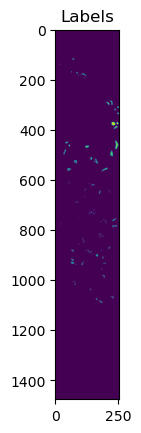

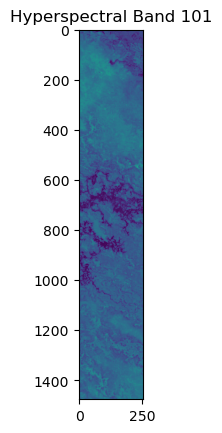

In [5]:
dataset_dir = r"C:\Users\vella\Documents\GitHub\FYP2425_LOCAL\FYP_DATASET"

gt_files = 'Botswana_gt.mat'
data_files = 'Botswana.mat'
label_files = 'Botswana_gt'
hypercube_files = 'Botswana'

def extract_Features():
    gt_file = os.path.join(dataset_dir, gt_files)
    data_file = os.path.join(dataset_dir, data_files)

    gt = sio.loadmat(gt_file)
    labels = gt[label_files]

    data = sio.loadmat(data_file)
    hypercube = data[hypercube_files]
    #scaling the data in place and setting to float32 to reduce memory usage
    max_value = np.max(hypercube)
    hypercube = (hypercube / max_value).astype(np.float32)


    #shapes of loaded data
    print(f"Labels shape: {labels.shape}")
    print(f"Hypercube shape: {hypercube.shape}")

    #visualisation of label map and a given band of hyperspectral data
    plt.figure()
    plt.imshow(labels)
    plt.title('Labels')

    band = 101
    plt.figure()
    plt.imshow(hypercube[:,:,band])
    plt.title(f'Hyperspectral Band {band}')
    plt.show()

    return hypercube, labels

hypercube, labels = extract_Features()

In [6]:
def extract_windows(data, labels, window_size):
    extract_windows_save_dir = 'extracted_windows_labels'
    if not os.path.exists(extract_windows_save_dir):
        os.makedirs(extract_windows_save_dir)
        print(f"Created directory: {extract_windows_save_dir}")

    margin = window_size // 2
    padded_data = np.pad(data, ((margin, margin), (margin, margin), (0, 0)), mode='constant')
    padded_labels = np.pad(labels, ((margin, margin), (margin, margin)), mode='constant')

    X_windows = []  #extracted windows
    y_labels = []   #corresponding labels

    print("Starting window extraction...")
    for i in range(margin, padded_data.shape[0] - margin):
        for j in range(margin, padded_data.shape[1] - margin):
            window = padded_data[i-margin:i+margin+1, j-margin:j+margin+1, :]
            label = padded_labels[i, j]

            if label != 0:
                #print('ignoring label 0 (background)')
                X_windows.append(window)
                y_labels.append(label)

    #convertying to numpy arrays
    X_windows = np.array(X_windows)
    y_labels = np.array(y_labels)

    #saving extracted windows and labels
    windows_file = os.path.join(extract_windows_save_dir, 'extracted_windows.npy')
    labels_file = os.path.join(extract_windows_save_dir, 'extracted_labels.npy')

    np.save(windows_file, X_windows)
    np.save(labels_file, y_labels)

    print(f"Saved extracted windows to: {windows_file}")
    print(f"Saved corresponding labels to: {labels_file}")
    print(f"\nTotal windows extracted: {len(X_windows)}")
    print(f"Extracted windows shape: {X_windows.shape}")
    print(f"Corresponding labels shape: {y_labels.shape}")

    return X_windows, y_labels

In [7]:
window_size = 5

X_windows, y_labels = extract_windows(hypercube, labels, window_size)

Created directory: extracted_windows_labels
Starting window extraction...


Saved extracted windows to: extracted_windows_labels\extracted_windows.npy
Saved corresponding labels to: extracted_windows_labels\extracted_labels.npy

Total windows extracted: 3248
Extracted windows shape: (3248, 5, 5, 145)
Corresponding labels shape: (3248,)


In [8]:
def get_samples(X_windows, y_labels, samples_per_class):
    
    indices_save_dir = 'indices'
    if not os.path.exists(indices_save_dir):
        os.makedirs(indices_save_dir)
        print(f"Created directory: {indices_save_dir}")
    
    #get unique classes
    classes = np.unique(y_labels)
    print(f"Unique classes found as: {classes}")

    #init lists
    X_sampled = [] #to store training samples
    y_sampled = [] #to store training labels

    X_val = [] # to store validation samples
    y_val = [] # to store validation labels

    selected_indices_total = [] #to store indices of selected training and validation samples
    validation_selected = [] #temp storage for validation indices
    validation_total = [] #to store all validation indices

    print("\n == STARTING SAMPLING PROCESS ==")
    for cls in classes:
        if cls == 0:
            print(f"!! SKIPPING CLASS 0 !!")
            continue

        #getting the indices for the current class:
        class_indices = np.where(y_labels == cls)[0]
        print(f"Class: {cls}: Found {len(class_indices)} samples")

        # shuffle class-specific indices to ensure randomness
        np.random.shuffle(class_indices)
        print(f"Shuffled class indices for class '{cls}'")

        #select 'samples_per_class' samples for training
        selected_indices = class_indices[:samples_per_class]
        #selecting 5 samples for validation
        validation_selected = class_indices[samples_per_class:samples_per_class+5]

        print(f"Selected {len(selected_indices)} training samples and {len(validation_selected)} validation samples for class '{cls}'\n")

        #store selected indices for training and validation
        selected_indices_total.extend(selected_indices)
        validation_total.extend(validation_selected)

        # appending the selected samples and their labels to the lists
        X_sampled.append(X_windows[selected_indices])
        y_sampled.append(y_labels[selected_indices])

        X_val.append(X_windows[validation_selected])
        y_val.append(y_labels[validation_selected])

    #concat the sampled arrays for training
    X_train = np.vstack(X_sampled)
    y_train = np.hstack(y_sampled)

    # shift labels to start from 0
    y_train = y_train - 1

    print(f"\n -- Training set created with: \n\t{X_train.shape[0]} samples\n\tshape {X_train.shape} --")

    #concat the sampled arrays for validation
    X_val = np.vstack(X_val)
    y_val = np.hstack(y_val)
    y_val = y_val - 1

    print(f"\n -- Validation set created with: \n\t{X_val.shape[0]} samples\n\tshape {X_val.shape} --")

    #create the test set from the remaining data (i.e. that which is not selected for training or validation)
    selected_indices_total.extend(validation_total)

    #getting indices not in the training or val sets
    test_indices = np.setdiff1d(np.arange(X_windows.shape[0]), selected_indices_total)
    X_test = X_windows[test_indices]
    y_test = y_labels[test_indices]
    y_test = y_test - 1

    print(f"\n -- Test set created with: \n\t{X_test.shape[0]} samples\n\tshape {X_test.shape} --\n")

    # Save the datasets to the 'datasets' folder
    np.save(os.path.join(indices_save_dir, 'X_train.npy'), X_train)
    np.save(os.path.join(indices_save_dir, 'y_train.npy'), y_train)
    np.save(os.path.join(indices_save_dir, 'X_val.npy'), X_val)
    np.save(os.path.join(indices_save_dir, 'y_val.npy'), y_val)
    np.save(os.path.join(indices_save_dir, 'X_test.npy'), X_test)
    np.save(os.path.join(indices_save_dir, 'y_test.npy'), y_test)

    print(f"\nAll datasets saved to the '{indices_save_dir}' folder.")

    #return the training, val, test sets + selected indices
    return X_train, X_test, y_train, y_test, X_val, y_val, selected_indices_total

In [9]:
X_train, X_test, y_train, y_test, X_val, y_val, selected_indices_total = get_samples(X_windows, y_labels, 5)
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

Created directory: indices
Unique classes found as: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14]

 == STARTING SAMPLING PROCESS ==
Class: 1: Found 270 samples
Shuffled class indices for class '1'
Selected 5 training samples and 5 validation samples for class '1'

Class: 2: Found 101 samples
Shuffled class indices for class '2'
Selected 5 training samples and 5 validation samples for class '2'

Class: 3: Found 251 samples
Shuffled class indices for class '3'
Selected 5 training samples and 5 validation samples for class '3'

Class: 4: Found 215 samples
Shuffled class indices for class '4'
Selected 5 training samples and 5 validation samples for class '4'

Class: 5: Found 269 samples
Shuffled class indices for class '5'
Selected 5 training samples and 5 validation samples for class '5'

Class: 6: Found 269 samples
Shuffled class indices for class '6'
Selected 5 training samples and 5 validation samples for class '6'

Class: 7: Found 259 samples
Shuffled class indices for class '7'
Selecte


All datasets saved to the 'indices' folder.
(70, 5, 5, 145)
(70, 5, 5, 145)
(3108, 5, 5, 145)


In [10]:
class HyperspectralDataset(Dataset):
    def __init__(self, X, y):
        """
        Args:
            X (numpy.ndarray): Hyperspectral data of shape (num_samples, height, width, num_bands).
            y (numpy.ndarray): Labels of shape (num_samples,).
        """
        #converting to pytorch tensor
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.long)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [11]:
#loading the saved datasets
X_train = np.load('indices/X_train.npy')
y_train = np.load('indices/y_train.npy')
X_val = np.load('indices/X_val.npy')
y_val = np.load('indices/y_val.npy')
X_test = np.load('indices/X_test.npy')
y_test = np.load('indices/y_test.npy')


#creating pytorch datasets
train_dataset = HyperspectralDataset(X_train, y_train)
val_dataset = HyperspectralDataset(X_val, y_val)
test_dataset = HyperspectralDataset(X_test, y_test)

m = 20
num_classes = len(np.unique(y_train))

#theoretical batch size calc
required_batch_size = m * num_classes  # 10 * 9 = 90

#ensuring batch size doesn't exceed training set size
if required_batch_size > len(train_dataset):
    #case 1: not enough samples - reduce m proportionally
    print("Case 1 applied")
    max_possible_m = len(train_dataset) // num_classes
    m = max(1, max_possible_m)
    batch_size_train = m * num_classes
else:
    #case 2: use full batch size
    print("Case 2 applied")
    batch_size_train = required_batch_size

sampler = MPerClassSampler(labels = y_train, m=m, batch_size = batch_size_train, length_before_new_iter = len(train_dataset))

#dataloaders
train_loader = DataLoader(train_dataset, batch_size = batch_size_train, sampler=sampler)

batch_size = 256
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print("DataLoaders created successfully!")

#class dist in first batch
for X_batch, y_batch in train_loader:
    unique, counts = np.unique(y_batch.numpy(), return_counts=True)
    print(f"Training batch size: {batch_size_train}")
    print("Class distribution in batch:", dict(zip(unique, counts)))
    break



Case 1 applied
DataLoaders created successfully!
Training batch size: 70
Class distribution in batch: {0: 5, 1: 5, 2: 5, 3: 5, 4: 5, 5: 5, 6: 5, 7: 5, 8: 5, 9: 5, 10: 5, 11: 5, 12: 5, 13: 5}


## Creating directory for saving model predictions

In [12]:
predictions_dir = 'model_predictions'
os.makedirs(predictions_dir, exist_ok=True)
print(f"Created dir: {predictions_dir}")

Created dir: model_predictions


## Creating the Dataset splits and Dataloaders for unsupervised tasks

In [13]:
X_train, X_val = train_test_split(X_windows, test_size=0.2, random_state=42)

print(f"Training data shape: {X_train.shape}")
print(f"Validation data shape: {X_val.shape}")

Training data shape: (2598, 5, 5, 145)
Validation data shape: (650, 5, 5, 145)


In [14]:
class UnsupervisedDataset(Dataset):
    def __init__(self, data):
        self.data = torch.tensor(data, dtype=torch.float32)  #converting to pytorch tensor

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

In [15]:
#creating datasets for unsupervised task
unsup_train_dataset = UnsupervisedDataset(X_train)
unsup_val_dataset = UnsupervisedDataset(X_val)

#dataloaders for unsupervised task
batch_size = 64
train_loader_cae = DataLoader(unsup_train_dataset, batch_size=batch_size, shuffle=True)
val_loader_cae = DataLoader(unsup_val_dataset, batch_size=batch_size, shuffle=False)

print("DataLoaders created successfully!")

DataLoaders created successfully!


In [16]:
window_num_channels = X_windows.shape[3]
print(window_num_channels)

145


## Convolutional Autoencoder

In [17]:
class ConvAutoEncode(nn.Module):
    def __init__(self, dropout_prob=0.1):
        super(ConvAutoEncode, self).__init__()

        #encoder
        self.encoder = nn.Sequential(
            #Block 1
            nn.Conv2d(window_num_channels, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Dropout(dropout_prob),

            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # 5x5 -> 2x2

            #Block 2
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Dropout(dropout_prob),

            #Bottleneck
            nn.Conv2d(128, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.MaxPool2d(2, 2)  # 2x2 -> 1x1
        )

        #decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 128, kernel_size=2, stride=2),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Dropout(dropout_prob),

            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.ConvTranspose2d(64, 64, kernel_size=2, stride=2, output_padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Dropout(dropout_prob),

            nn.ConvTranspose2d(64, window_num_channels, kernel_size=3, stride=1, padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return encoded, decoded


LOG: Epoch [1/50]


	 Training Batch [1/41], Loss: 0.2192, PSNR: -9.4576


Epoch [1/50] Training Loss: 0.2139, PSNR: -8.6662
	[Val]   Batch [1/11] Loss: 0.2045, PSNR: -6.1433
	[Val]   Batch [10/11] Loss: 0.2046, PSNR: -8.3822
Epoch [1/50] Validation Loss: 0.2045, PSNR: -8.0742

LOG: Epoch [2/50]
	 Training Batch [1/41], Loss: 0.2007, PSNR: -10.4155


Epoch [2/50] Training Loss: 0.1921, PSNR: -8.4207
	[Val]   Batch [1/11] Loss: 0.1788, PSNR: -5.5596
	[Val]   Batch [10/11] Loss: 0.1791, PSNR: -7.8045
Epoch [2/50] Validation Loss: 0.1788, PSNR: -7.4907

LOG: Epoch [3/50]
	 Training Batch [1/41], Loss: 0.1796, PSNR: -7.1635


Epoch [3/50] Training Loss: 0.1715, PSNR: -7.8475
	[Val]   Batch [1/11] Loss: 0.1562, PSNR: -4.9741
	[Val]   Batch [10/11] Loss: 0.1566, PSNR: -7.2216
Epoch [3/50] Validation Loss: 0.1563, PSNR: -6.9072

LOG: Epoch [4/50]
	 Training Batch [1/41], Loss: 0.1575, PSNR: -5.0107


Epoch [4/50] Training Loss: 0.1514, PSNR: -7.3164
	[Val]   Batch [1/11] Loss: 0.1369, PSNR: -4.4019
	[Val]   Batch [10/11] Loss: 0.1373, PSNR: -6.6489
Epoch [4/50] Validation Loss: 0.1370, PSNR: -6.3338

LOG: Epoch [5/50]
	 Training Batch [1/41], Loss: 0.1391, PSNR: -7.4113


Epoch [5/50] Training Loss: 0.1324, PSNR: -6.7156
	[Val]   Batch [1/11] Loss: 0.1178, PSNR: -3.7488
	[Val]   Batch [10/11] Loss: 0.1180, PSNR: -5.9922
Epoch [5/50] Validation Loss: 0.1177, PSNR: -5.6773

LOG: Epoch [6/50]
	 Training Batch [1/41], Loss: 0.1207, PSNR: -6.7041


Epoch [6/50] Training Loss: 0.1147, PSNR: -6.2023
	[Val]   Batch [1/11] Loss: 0.1011, PSNR: -3.0846
	[Val]   Batch [10/11] Loss: 0.1012, PSNR: -5.3233
Epoch [6/50] Validation Loss: 0.1011, PSNR: -5.0135

LOG: Epoch [7/50]
	 Training Batch [1/41], Loss: 0.1044, PSNR: -4.8069


Epoch [7/50] Training Loss: 0.0988, PSNR: -5.4571
	[Val]   Batch [1/11] Loss: 0.0876, PSNR: -2.4608
	[Val]   Batch [10/11] Loss: 0.0876, PSNR: -4.6974
Epoch [7/50] Validation Loss: 0.0875, PSNR: -4.3898

LOG: Epoch [8/50]
	 Training Batch [1/41], Loss: 0.0902, PSNR: -7.1533


Epoch [8/50] Training Loss: 0.0850, PSNR: -4.6869
	[Val]   Batch [1/11] Loss: 0.0754, PSNR: -1.8111
	[Val]   Batch [10/11] Loss: 0.0754, PSNR: -4.0486
Epoch [8/50] Validation Loss: 0.0754, PSNR: -3.7410

LOG: Epoch [9/50]
	 Training Batch [1/41], Loss: 0.0762, PSNR: -1.8590


Epoch [9/50] Training Loss: 0.0732, PSNR: -4.2443
	[Val]   Batch [1/11] Loss: 0.0655, PSNR: -1.1993
	[Val]   Batch [10/11] Loss: 0.0655, PSNR: -3.4372
Epoch [9/50] Validation Loss: 0.0655, PSNR: -3.1288

LOG: Epoch [10/50]
	 Training Batch [1/41], Loss: 0.0669, PSNR: -3.2273


Epoch [10/50] Training Loss: 0.0633, PSNR: -3.5957
	[Val]   Batch [1/11] Loss: 0.0574, PSNR: -0.6239
	[Val]   Batch [10/11] Loss: 0.0574, PSNR: -2.8609
Epoch [10/50] Validation Loss: 0.0574, PSNR: -2.5536

LOG: Epoch [11/50]
	 Training Batch [1/41], Loss: 0.0578, PSNR: -2.2374


Epoch [11/50] Training Loss: 0.0551, PSNR: -3.0095
	[Val]   Batch [1/11] Loss: 0.0503, PSNR: -0.0567
	[Val]   Batch [10/11] Loss: 0.0504, PSNR: -2.2932
Epoch [11/50] Validation Loss: 0.0503, PSNR: -1.9858

LOG: Epoch [12/50]
	 Training Batch [1/41], Loss: 0.0500, PSNR: -1.9658


Epoch [12/50] Training Loss: 0.0483, PSNR: -2.4137
	[Val]   Batch [1/11] Loss: 0.0453, PSNR: 0.3991
	[Val]   Batch [10/11] Loss: 0.0453, PSNR: -1.8378
Epoch [12/50] Validation Loss: 0.0453, PSNR: -1.5293

LOG: Epoch [13/50]
	 Training Batch [1/41], Loss: 0.0445, PSNR: -2.9428


Epoch [13/50] Training Loss: 0.0426, PSNR: -1.6873
	[Val]   Batch [1/11] Loss: 0.0398, PSNR: 0.9622
	[Val]   Batch [10/11] Loss: 0.0398, PSNR: -1.2750
Epoch [13/50] Validation Loss: 0.0398, PSNR: -0.9656

LOG: Epoch [14/50]
	 Training Batch [1/41], Loss: 0.0388, PSNR: -1.8672


Epoch [14/50] Training Loss: 0.0378, PSNR: -1.2575
	[Val]   Batch [1/11] Loss: 0.0360, PSNR: 1.4020
	[Val]   Batch [10/11] Loss: 0.0360, PSNR: -0.8349
Epoch [14/50] Validation Loss: 0.0360, PSNR: -0.5253

LOG: Epoch [15/50]
	 Training Batch [1/41], Loss: 0.0347, PSNR: 1.5566


Epoch [15/50] Training Loss: 0.0338, PSNR: -0.7133
	[Val]   Batch [1/11] Loss: 0.0322, PSNR: 1.8902
	[Val]   Batch [10/11] Loss: 0.0322, PSNR: -0.3453
Epoch [15/50] Validation Loss: 0.0321, PSNR: -0.0368

LOG: Epoch [16/50]
	 Training Batch [1/41], Loss: 0.0319, PSNR: -2.5222


Epoch [16/50] Training Loss: 0.0303, PSNR: -0.5114
	[Val]   Batch [1/11] Loss: 0.0291, PSNR: 2.3271
	[Val]   Batch [10/11] Loss: 0.0291, PSNR: 0.0910
Epoch [16/50] Validation Loss: 0.0291, PSNR: 0.4004

LOG: Epoch [17/50]
	 Training Batch [1/41], Loss: 0.0278, PSNR: 0.5862


Epoch [17/50] Training Loss: 0.0274, PSNR: 0.1851
	[Val]   Batch [1/11] Loss: 0.0265, PSNR: 2.7334
	[Val]   Batch [10/11] Loss: 0.0265, PSNR: 0.4976
Epoch [17/50] Validation Loss: 0.0265, PSNR: 0.8066

LOG: Epoch [18/50]
	 Training Batch [1/41], Loss: 0.0259, PSNR: -0.5968


Epoch [18/50] Training Loss: 0.0249, PSNR: 0.6064
	[Val]   Batch [1/11] Loss: 0.0240, PSNR: 3.1571
	[Val]   Batch [10/11] Loss: 0.0240, PSNR: 0.9211
Epoch [18/50] Validation Loss: 0.0240, PSNR: 1.2302

LOG: Epoch [19/50]
	 Training Batch [1/41], Loss: 0.0232, PSNR: -0.9175


Epoch [19/50] Training Loss: 0.0227, PSNR: 1.0174
	[Val]   Batch [1/11] Loss: 0.0221, PSNR: 3.5174
	[Val]   Batch [10/11] Loss: 0.0221, PSNR: 1.2815
Epoch [19/50] Validation Loss: 0.0221, PSNR: 1.5914

LOG: Epoch [20/50]
	 Training Batch [1/41], Loss: 0.0217, PSNR: 3.5901


Epoch [20/50] Training Loss: 0.0208, PSNR: 1.2480
	[Val]   Batch [1/11] Loss: 0.0203, PSNR: 3.8807
	[Val]   Batch [10/11] Loss: 0.0203, PSNR: 1.6442
Epoch [20/50] Validation Loss: 0.0203, PSNR: 1.9550

LOG: Epoch [21/50]
	 Training Batch [1/41], Loss: 0.0195, PSNR: 1.1211


Epoch [21/50] Training Loss: 0.0191, PSNR: 1.8273
	[Val]   Batch [1/11] Loss: 0.0187, PSNR: 4.2436
	[Val]   Batch [10/11] Loss: 0.0187, PSNR: 2.0069
Epoch [21/50] Validation Loss: 0.0187, PSNR: 2.3177

LOG: Epoch [22/50]
	 Training Batch [1/41], Loss: 0.0178, PSNR: 1.5310


Epoch [22/50] Training Loss: 0.0176, PSNR: 2.0653
	[Val]   Batch [1/11] Loss: 0.0174, PSNR: 4.5664
	[Val]   Batch [10/11] Loss: 0.0174, PSNR: 2.3283
Epoch [22/50] Validation Loss: 0.0173, PSNR: 2.6403

LOG: Epoch [23/50]
	 Training Batch [1/41], Loss: 0.0166, PSNR: 2.3388


Epoch [23/50] Training Loss: 0.0163, PSNR: 2.2339
	[Val]   Batch [1/11] Loss: 0.0161, PSNR: 4.8978
	[Val]   Batch [10/11] Loss: 0.0161, PSNR: 2.6596
Epoch [23/50] Validation Loss: 0.0161, PSNR: 2.9716

LOG: Epoch [24/50]
	 Training Batch [1/41], Loss: 0.0157, PSNR: 3.0794


Epoch [24/50] Training Loss: 0.0152, PSNR: 2.7315
	[Val]   Batch [1/11] Loss: 0.0150, PSNR: 5.2054
	[Val]   Batch [10/11] Loss: 0.0150, PSNR: 2.9672
Epoch [24/50] Validation Loss: 0.0150, PSNR: 3.2791

LOG: Epoch [25/50]
	 Training Batch [1/41], Loss: 0.0144, PSNR: 2.4302


Epoch [25/50] Training Loss: 0.0141, PSNR: 2.9117
	[Val]   Batch [1/11] Loss: 0.0139, PSNR: 5.5266
	[Val]   Batch [10/11] Loss: 0.0139, PSNR: 3.2883
Epoch [25/50] Validation Loss: 0.0139, PSNR: 3.6003

LOG: Epoch [26/50]
	 Training Batch [1/41], Loss: 0.0136, PSNR: 1.0487


Epoch [26/50] Training Loss: 0.0132, PSNR: 3.3327
	[Val]   Batch [1/11] Loss: 0.0130, PSNR: 5.8272
	[Val]   Batch [10/11] Loss: 0.0130, PSNR: 3.5889
Epoch [26/50] Validation Loss: 0.0130, PSNR: 3.9010

LOG: Epoch [27/50]
	 Training Batch [1/41], Loss: 0.0124, PSNR: 3.1616


Epoch [27/50] Training Loss: 0.0123, PSNR: 3.6562
	[Val]   Batch [1/11] Loss: 0.0122, PSNR: 6.1071
	[Val]   Batch [10/11] Loss: 0.0122, PSNR: 3.8696
Epoch [27/50] Validation Loss: 0.0122, PSNR: 4.1810

LOG: Epoch [28/50]
	 Training Batch [1/41], Loss: 0.0115, PSNR: 4.7762


Epoch [28/50] Training Loss: 0.0115, PSNR: 3.9544
	[Val]   Batch [1/11] Loss: 0.0114, PSNR: 6.3778
	[Val]   Batch [10/11] Loss: 0.0114, PSNR: 4.1400
Epoch [28/50] Validation Loss: 0.0114, PSNR: 4.4523

LOG: Epoch [29/50]
	 Training Batch [1/41], Loss: 0.0109, PSNR: 3.6664


Epoch [29/50] Training Loss: 0.0108, PSNR: 4.2097
	[Val]   Batch [1/11] Loss: 0.0108, PSNR: 6.6422
	[Val]   Batch [10/11] Loss: 0.0108, PSNR: 4.4054
Epoch [29/50] Validation Loss: 0.0108, PSNR: 4.7174

LOG: Epoch [30/50]
	 Training Batch [1/41], Loss: 0.0104, PSNR: 5.1929


Epoch [30/50] Training Loss: 0.0102, PSNR: 4.3302
	[Val]   Batch [1/11] Loss: 0.0101, PSNR: 6.9007
	[Val]   Batch [10/11] Loss: 0.0101, PSNR: 4.6643
Epoch [30/50] Validation Loss: 0.0101, PSNR: 4.9756

LOG: Epoch [31/50]
	 Training Batch [1/41], Loss: 0.0096, PSNR: 7.1267


Epoch [31/50] Training Loss: 0.0096, PSNR: 4.5694
	[Val]   Batch [1/11] Loss: 0.0095, PSNR: 7.1706
	[Val]   Batch [10/11] Loss: 0.0095, PSNR: 4.9342
Epoch [31/50] Validation Loss: 0.0095, PSNR: 5.2466

LOG: Epoch [32/50]
	 Training Batch [1/41], Loss: 0.0093, PSNR: 3.0168


Epoch [32/50] Training Loss: 0.0091, PSNR: 4.7968
	[Val]   Batch [1/11] Loss: 0.0090, PSNR: 7.4036
	[Val]   Batch [10/11] Loss: 0.0090, PSNR: 5.1675
Epoch [32/50] Validation Loss: 0.0090, PSNR: 5.4799

LOG: Epoch [33/50]
	 Training Batch [1/41], Loss: 0.0086, PSNR: 4.6545


Epoch [33/50] Training Loss: 0.0086, PSNR: 4.9873
	[Val]   Batch [1/11] Loss: 0.0086, PSNR: 7.6255
	[Val]   Batch [10/11] Loss: 0.0086, PSNR: 5.3899
Epoch [33/50] Validation Loss: 0.0086, PSNR: 5.7018

LOG: Epoch [34/50]
	 Training Batch [1/41], Loss: 0.0084, PSNR: 4.3075


Epoch [34/50] Training Loss: 0.0081, PSNR: 5.2896
	[Val]   Batch [1/11] Loss: 0.0081, PSNR: 7.8687
	[Val]   Batch [10/11] Loss: 0.0081, PSNR: 5.6331
Epoch [34/50] Validation Loss: 0.0081, PSNR: 5.9451

LOG: Epoch [35/50]
	 Training Batch [1/41], Loss: 0.0078, PSNR: 6.4078


Epoch [35/50] Training Loss: 0.0077, PSNR: 5.5945
	[Val]   Batch [1/11] Loss: 0.0077, PSNR: 8.1089
	[Val]   Batch [10/11] Loss: 0.0077, PSNR: 5.8726
Epoch [35/50] Validation Loss: 0.0077, PSNR: 6.1856

LOG: Epoch [36/50]
	 Training Batch [1/41], Loss: 0.0074, PSNR: 4.8373


Epoch [36/50] Training Loss: 0.0073, PSNR: 5.8504
	[Val]   Batch [1/11] Loss: 0.0073, PSNR: 8.3172
	[Val]   Batch [10/11] Loss: 0.0073, PSNR: 6.0803
Epoch [36/50] Validation Loss: 0.0073, PSNR: 6.3938

LOG: Epoch [37/50]
	 Training Batch [1/41], Loss: 0.0071, PSNR: 4.5146


Epoch [37/50] Training Loss: 0.0069, PSNR: 5.9472
	[Val]   Batch [1/11] Loss: 0.0070, PSNR: 8.5038
	[Val]   Batch [10/11] Loss: 0.0070, PSNR: 6.2671
Epoch [37/50] Validation Loss: 0.0070, PSNR: 6.5808

LOG: Epoch [38/50]
	 Training Batch [1/41], Loss: 0.0068, PSNR: 6.1989


Epoch [38/50] Training Loss: 0.0066, PSNR: 6.1924
	[Val]   Batch [1/11] Loss: 0.0066, PSNR: 8.7439
	[Val]   Batch [10/11] Loss: 0.0066, PSNR: 6.5079
Epoch [38/50] Validation Loss: 0.0066, PSNR: 6.8215

LOG: Epoch [39/50]
	 Training Batch [1/41], Loss: 0.0062, PSNR: 5.4362


Epoch [39/50] Training Loss: 0.0063, PSNR: 6.5348
	[Val]   Batch [1/11] Loss: 0.0064, PSNR: 8.9194
	[Val]   Batch [10/11] Loss: 0.0064, PSNR: 6.6832
Epoch [39/50] Validation Loss: 0.0064, PSNR: 6.9974

LOG: Epoch [40/50]
	 Training Batch [1/41], Loss: 0.0060, PSNR: 9.1735


Epoch [40/50] Training Loss: 0.0060, PSNR: 6.6137
	[Val]   Batch [1/11] Loss: 0.0060, PSNR: 9.1461
	[Val]   Batch [10/11] Loss: 0.0060, PSNR: 6.9110
Epoch [40/50] Validation Loss: 0.0060, PSNR: 7.2244

LOG: Epoch [41/50]
	 Training Batch [1/41], Loss: 0.0057, PSNR: 7.4468


Epoch [41/50] Training Loss: 0.0058, PSNR: 6.7721
	[Val]   Batch [1/11] Loss: 0.0058, PSNR: 9.3164
	[Val]   Batch [10/11] Loss: 0.0058, PSNR: 7.0818
Epoch [41/50] Validation Loss: 0.0058, PSNR: 7.3949

LOG: Epoch [42/50]
	 Training Batch [1/41], Loss: 0.0055, PSNR: 5.3320


Epoch [42/50] Training Loss: 0.0055, PSNR: 7.1397
	[Val]   Batch [1/11] Loss: 0.0055, PSNR: 9.5305
	[Val]   Batch [10/11] Loss: 0.0055, PSNR: 7.2953
Epoch [42/50] Validation Loss: 0.0055, PSNR: 7.6102

LOG: Epoch [43/50]
	 Training Batch [1/41], Loss: 0.0056, PSNR: 7.0897


Epoch [43/50] Training Loss: 0.0053, PSNR: 7.0818
	[Val]   Batch [1/11] Loss: 0.0053, PSNR: 9.7144
	[Val]   Batch [10/11] Loss: 0.0053, PSNR: 7.4790
Epoch [43/50] Validation Loss: 0.0053, PSNR: 7.7952

LOG: Epoch [44/50]
	 Training Batch [1/41], Loss: 0.0051, PSNR: 8.2178


Epoch [44/50] Training Loss: 0.0051, PSNR: 7.4711
	[Val]   Batch [1/11] Loss: 0.0051, PSNR: 9.8808
	[Val]   Batch [10/11] Loss: 0.0051, PSNR: 7.6458
Epoch [44/50] Validation Loss: 0.0051, PSNR: 7.9618

LOG: Epoch [45/50]
	 Training Batch [1/41], Loss: 0.0047, PSNR: 6.4786


Epoch [45/50] Training Loss: 0.0048, PSNR: 7.5511
	[Val]   Batch [1/11] Loss: 0.0049, PSNR: 10.0494
	[Val]   Batch [10/11] Loss: 0.0049, PSNR: 7.8147
Epoch [45/50] Validation Loss: 0.0049, PSNR: 8.1301

LOG: Epoch [46/50]
	 Training Batch [1/41], Loss: 0.0046, PSNR: 8.7755


Epoch [46/50] Training Loss: 0.0046, PSNR: 7.5694
	[Val]   Batch [1/11] Loss: 0.0047, PSNR: 10.2519
	[Val]   Batch [10/11] Loss: 0.0047, PSNR: 8.0171
Epoch [46/50] Validation Loss: 0.0047, PSNR: 8.3328

LOG: Epoch [47/50]
	 Training Batch [1/41], Loss: 0.0046, PSNR: 7.4105


Epoch [47/50] Training Loss: 0.0045, PSNR: 8.1050
	[Val]   Batch [1/11] Loss: 0.0045, PSNR: 10.4564
	[Val]   Batch [10/11] Loss: 0.0045, PSNR: 8.2206
Epoch [47/50] Validation Loss: 0.0045, PSNR: 8.5373

LOG: Epoch [48/50]
	 Training Batch [1/41], Loss: 0.0044, PSNR: 8.9774


Epoch [48/50] Training Loss: 0.0043, PSNR: 8.2967
	[Val]   Batch [1/11] Loss: 0.0043, PSNR: 10.6178
	[Val]   Batch [10/11] Loss: 0.0043, PSNR: 8.3821
Epoch [48/50] Validation Loss: 0.0043, PSNR: 8.6993

LOG: Epoch [49/50]
	 Training Batch [1/41], Loss: 0.0042, PSNR: 9.0965


Epoch [49/50] Training Loss: 0.0041, PSNR: 8.2820
	[Val]   Batch [1/11] Loss: 0.0042, PSNR: 10.7693
	[Val]   Batch [10/11] Loss: 0.0042, PSNR: 8.5338
Epoch [49/50] Validation Loss: 0.0042, PSNR: 8.8509

LOG: Epoch [50/50]
	 Training Batch [1/41], Loss: 0.0040, PSNR: 9.3362


Epoch [50/50] Training Loss: 0.0040, PSNR: 8.4552
	[Val]   Batch [1/11] Loss: 0.0040, PSNR: 10.9421
	[Val]   Batch [10/11] Loss: 0.0040, PSNR: 8.7066
Epoch [50/50] Validation Loss: 0.0040, PSNR: 9.0244


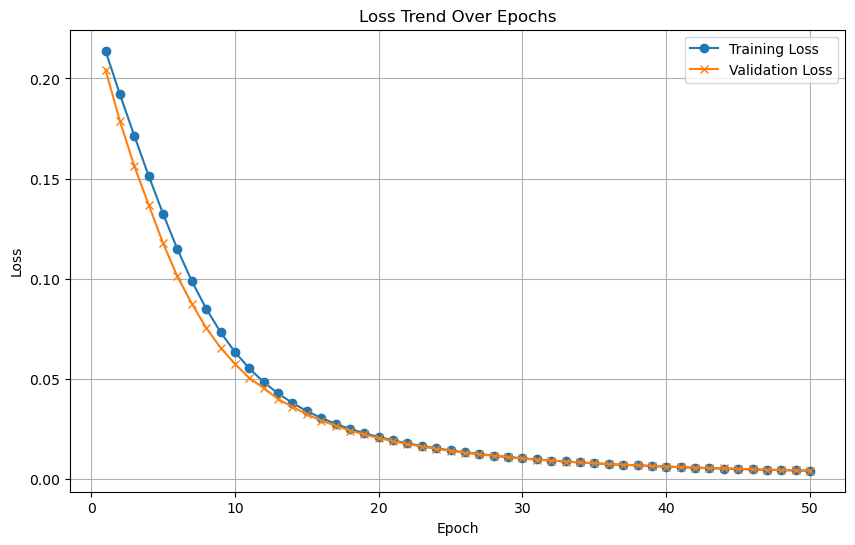

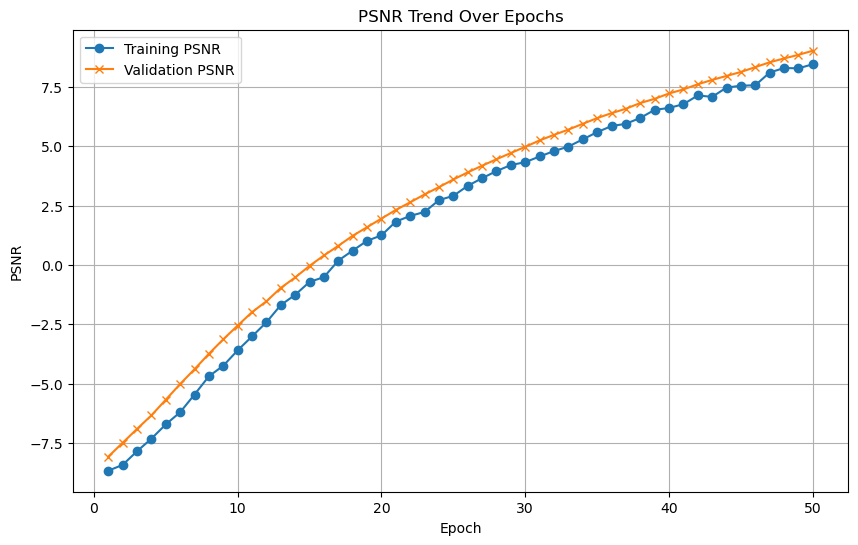

In [18]:
model_cae = ConvAutoEncode()
criterion_cae = nn.MSELoss()
optimizer_cae = optim.Adam(model_cae.parameters(), lr=0.0001)

#parameters for CAE
num_epochs_cae = 50
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_cae = model_cae.to(device)

#early stopping parameters
patience = 3  # number of epochs to wait for improvement
tolerance = 1e-4
best_val_loss = float('inf')
epochs_without_improvement = 0

#grad accumulation parameters
accumulation_steps = 8 

# for loss and metrics tracking
autoencoder_epoch_losses_cae = []
validation_epoch_losses_cae = []
train_psnr = []
val_psnr = []

psnr = PeakSignalNoiseRatio().to(device)

# mixed precision training
scaler = GradScaler()  # Gradient scaler for mixed precision

for epoch in range(num_epochs_cae):
    # training
    model_cae.train()
    running_loss = 0.0
    running_psnr = 0.0

    print(f"\nLOG: Epoch [{epoch + 1}/{num_epochs_cae}]")

    optimizer_cae.zero_grad()

    for batch_idx, data in enumerate(train_loader_cae):
        data = data.to(device).permute(0, 3, 1, 2)

        # mixed precision forward pass
        with autocast(device_type='cuda', dtype=torch.float16):
            _, decoded = model_cae(data)
            loss = criterion_cae(decoded, data) / accumulation_steps

            with torch.no_grad():
                nan_in_out = torch.isnan(decoded).any().item()
                inf_in_out = torch.isinf(decoded).any().item()

        #backward pass with gradient scaling
        scaler.scale(loss).backward()

        loss_value = loss.item() * accumulation_steps
        running_loss += loss_value

        psnr_value = psnr(decoded, data).item()
        running_psnr += psnr_value


        # performing optimizer step and reset gradients after `accumulation_steps` batches
        if (batch_idx + 1) % accumulation_steps == 0 or (batch_idx + 1) == len(train_loader_cae):
            scaler.step(optimizer_cae)
            scaler.update()
            optimizer_cae.zero_grad()

        if batch_idx == 0 or (batch_idx + 1) % 200 == 0:
            print(
    f"\t Training Batch [{batch_idx + 1}/{len(train_loader_cae)}], "
    f"Loss: {loss_value:.4f}, PSNR: {psnr_value:.4f}"
)


        #delete intermediate variables and clear GPU cache
        del data, decoded, loss
        torch.cuda.empty_cache()

    #compute average metrics for the epoch
    avg_train_loss = running_loss / len(train_loader_cae)
    avg_train_psnr = running_psnr / len(train_loader_cae)

    autoencoder_epoch_losses_cae.append(avg_train_loss)
    train_psnr.append(avg_train_psnr)

    print(f"Epoch [{epoch + 1}/{num_epochs_cae}] Training Loss: {avg_train_loss:.4f}, PSNR: {avg_train_psnr:.4f}")

    #clear GPU cache after training
    torch.cuda.empty_cache()

    #validation
    model_cae.eval()
    validation_loss = 0.0
    val_psnr_epoch = 0.0

    with torch.no_grad():
        for batch_idx, data in enumerate(val_loader_cae):
            data = data.to(device).permute(0, 3, 1, 2)

            # Mixed precision forward pass for validation
            with autocast(device_type='cuda', dtype=torch.float16):
                _, decoded = model_cae(data)
                loss = criterion_cae(decoded, data)

            validation_loss += loss.item()
            val_psnr_epoch += psnr(decoded, data).item()

            if batch_idx == 0 or (batch_idx + 1) % 10 == 0:
                loss_val = loss.item()
                psnr_val = psnr(decoded, data).item()
                print(
                    f"\t[Val]   Batch [{batch_idx + 1}/{len(val_loader_cae)}] "
                    f"Loss: {loss_val:.4f}, PSNR: {psnr_val:.4f}"
                )

            del data, decoded, loss
            torch.cuda.empty_cache()

    # average validation metrics for the epoch
    avg_val_loss = validation_loss / len(val_loader_cae)
    avg_val_psnr = val_psnr_epoch / len(val_loader_cae)

    validation_epoch_losses_cae.append(avg_val_loss)
    val_psnr.append(avg_val_psnr)

    print(f"Epoch [{epoch + 1}/{num_epochs_cae}] Validation Loss: {avg_val_loss:.4f}, PSNR: {avg_val_psnr:.4f}")

    # early stopping logic
    if avg_val_loss < best_val_loss - tolerance:
        best_val_loss = avg_val_loss
        epochs_without_improvement = 0  # Reset counter
        #best model checkpoint
        #torch.save(model_cae.state_dict(), 'best_model_cae.pth')
    else:
        epochs_without_improvement += 1

    if epochs_without_improvement >= patience:
        print(f"Early stopping triggered at epoch {epoch + 1}. No improvement for {patience} epochs.")
        break

#plot for training and validation loss trends
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(autoencoder_epoch_losses_cae) + 1), autoencoder_epoch_losses_cae, marker='o', label="Training Loss")
plt.plot(range(1, len(validation_epoch_losses_cae) + 1), validation_epoch_losses_cae, marker='x', label="Validation Loss")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Trend Over Epochs')
plt.legend()
plt.grid()
plt.show()

#plot for PSNR trends
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(train_psnr) + 1), train_psnr, marker='o', label="Training PSNR")
plt.plot(range(1, len(val_psnr) + 1), val_psnr, marker='x', label="Validation PSNR")
plt.xlabel('Epoch')
plt.ylabel('PSNR')
plt.title('PSNR Trend Over Epochs')
plt.legend()
plt.grid()
plt.show()

## Using the encoder section of CAE as feature extractor to generate compact representations

In [19]:
#dir to save encoded representations
encoded_dir = 'encoded_representations'
os.makedirs(encoded_dir, exist_ok=True)

loaders = {
    'train': train_loader,
    'val': val_loader,
    'test': test_loader
}

model_cae.eval()

# Feature extraction
with torch.no_grad():
    for subset_name, loader in loaders.items():
        print(f"\nExtracting representations for the {subset_name} dataset...")

        # dir for the given subset's encoded features
        subset_encoded_dir = os.path.join(encoded_dir, subset_name)
        os.makedirs(subset_encoded_dir, exist_ok=True)

        for batch_idx, (data, labels) in enumerate(loader):
            data = data.to(device).permute(0, 3, 1, 2)

            # passing data through the encoder to obtain representations
            encoded_features, _ = model_cae(data)  # latent representation

            # moving to CPU and convert to NumPy
            encoded_features = encoded_features.cpu().numpy()  
            labels = labels.cpu().numpy() 

            #saving the encoded features and labels
            np.save(os.path.join(subset_encoded_dir, f'encoded_batch_{batch_idx}.npy'), encoded_features)
            np.save(os.path.join(subset_encoded_dir, f'labels_batch_{batch_idx}.npy'), labels)

            if batch_idx % 1 == 0 and subset_name != 'test':
                print(f"    Processed batch {batch_idx + 1}/{len(loader)} for {subset_name} dataset.")
            elif subset_name == 'test' and batch_idx % 100 == 0:  # Log less frequently for the test set
                print(f"    Processed batch {batch_idx + 1}/{len(loader)} for {subset_name} dataset.")

        print(f"Completed encoding for the {subset_name} dataset.")

print("Feature extraction completed for all subsets.")


Extracting representations for the train dataset...
    Processed batch 1/1 for train dataset.
Completed encoding for the train dataset.

Extracting representations for the val dataset...
    Processed batch 1/1 for val dataset.
Completed encoding for the val dataset.

Extracting representations for the test dataset...
    Processed batch 1/13 for test dataset.
Completed encoding for the test dataset.
Feature extraction completed for all subsets.


## End-To-End CNN

In [20]:
class hyperspectralCNN(nn.Module):
    def __init__(self, input_channels, num_classes):
        super(hyperspectralCNN, self).__init__()

        self.cnn_layers = nn.Sequential(
            # Block 1
            nn.Conv2d(input_channels, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # 5x5 -> 2x2

            # Block 2
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),

            # Bottleneck
            nn.Conv2d(128, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.MaxPool2d(2, 2)  # 2x2 -> 1x1
        )

        #fully connected layers for classification
        self.fc_layers = nn.Sequential(
            nn.Flatten(),  #3D to 1D vector for input to FC layers
            nn.Linear(16 * 2 * 2, 64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, num_classes)
        )

    def forward(self, x):
        x = self.cnn_layers(x)
        x = self.fc_layers(x)
        return x


LOG: Epoch [1/1000] - Training


Epoch [1/1000] completed, Average Training Loss: 2.6524
    Validation Batch [1/1], Loss: 2.6429
Validation Loss: 2.6429, Validation Accuracy: 7.14%
Validation loss improved from inf to 2.6429. Saving model...

LOG: Epoch [2/1000] - Training
Epoch [2/1000] completed, Average Training Loss: 2.6283
    Validation Batch [1/1], Loss: 2.6429
Validation Loss: 2.6429, Validation Accuracy: 7.14%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [3/1000] - Training
Epoch [3/1000] completed, Average Training Loss: 2.5910
    Validation Batch [1/1], Loss: 2.6429
Validation Loss: 2.6429, Validation Accuracy: 7.14%
Validation loss improved from 2.6429 to 2.6429. Saving model...

LOG: Epoch [4/1000] - Training
Epoch [4/1000] completed, Average Training Loss: 2.5711
    Validation Batch [1/1], Loss: 2.6429
Validation Loss: 2.6429, Validation Accuracy: 7.14%
Validation loss improved from 2.6429 to 2.6429. Saving model...

LOG: Epoch [5/1000] - Training
Epoch [5/1000] completed, Average Trai

Epoch [21/1000] completed, Average Training Loss: 2.3539
    Validation Batch [1/1], Loss: 2.6438
Validation Loss: 2.6438, Validation Accuracy: 7.14%
Validation loss did not improve. Patience: 14/100

LOG: Epoch [22/1000] - Training
Epoch [22/1000] completed, Average Training Loss: 2.3382
    Validation Batch [1/1], Loss: 2.6439
Validation Loss: 2.6439, Validation Accuracy: 7.14%
Validation loss did not improve. Patience: 15/100

LOG: Epoch [23/1000] - Training
Epoch [23/1000] completed, Average Training Loss: 2.3191
    Validation Batch [1/1], Loss: 2.6440
Validation Loss: 2.6440, Validation Accuracy: 7.14%
Validation loss did not improve. Patience: 16/100

LOG: Epoch [24/1000] - Training
Epoch [24/1000] completed, Average Training Loss: 2.3156
    Validation Batch [1/1], Loss: 2.6441
Validation Loss: 2.6441, Validation Accuracy: 7.14%
Validation loss did not improve. Patience: 17/100

LOG: Epoch [25/1000] - Training
Epoch [25/1000] completed, Average Training Loss: 2.3070
    Validat

Epoch [29/1000] completed, Average Training Loss: 2.2821
    Validation Batch [1/1], Loss: 2.6451
Validation Loss: 2.6451, Validation Accuracy: 7.14%
Validation loss did not improve. Patience: 22/100

LOG: Epoch [30/1000] - Training
Epoch [30/1000] completed, Average Training Loss: 2.2728
    Validation Batch [1/1], Loss: 2.6452
Validation Loss: 2.6452, Validation Accuracy: 7.14%
Validation loss did not improve. Patience: 23/100

LOG: Epoch [31/1000] - Training
Epoch [31/1000] completed, Average Training Loss: 2.2880
    Validation Batch [1/1], Loss: 2.6451
Validation Loss: 2.6451, Validation Accuracy: 7.14%
Validation loss did not improve. Patience: 24/100

LOG: Epoch [32/1000] - Training
Epoch [32/1000] completed, Average Training Loss: 2.2109
    Validation Batch [1/1], Loss: 2.6450
Validation Loss: 2.6450, Validation Accuracy: 7.14%
Validation loss did not improve. Patience: 25/100

LOG: Epoch [33/1000] - Training
Epoch [33/1000] completed, Average Training Loss: 2.2090
    Validat

Epoch [52/1000] completed, Average Training Loss: 2.0604
    Validation Batch [1/1], Loss: 2.6176
Validation Loss: 2.6176, Validation Accuracy: 14.29%
Validation loss improved from 2.6209 to 2.6176. Saving model...

LOG: Epoch [53/1000] - Training
Epoch [53/1000] completed, Average Training Loss: 2.0354
    Validation Batch [1/1], Loss: 2.6129
Validation Loss: 2.6129, Validation Accuracy: 14.29%
Validation loss improved from 2.6176 to 2.6129. Saving model...

LOG: Epoch [54/1000] - Training
Epoch [54/1000] completed, Average Training Loss: 2.0664
    Validation Batch [1/1], Loss: 2.6079
Validation Loss: 2.6079, Validation Accuracy: 14.29%
Validation loss improved from 2.6129 to 2.6079. Saving model...

LOG: Epoch [55/1000] - Training
Epoch [55/1000] completed, Average Training Loss: 2.0691
    Validation Batch [1/1], Loss: 2.6023
Validation Loss: 2.6023, Validation Accuracy: 14.29%
Validation loss improved from 2.6079 to 2.6023. Saving model...

LOG: Epoch [56/1000] - Training
Epoch [5

Epoch [58/1000] completed, Average Training Loss: 2.0533
    Validation Batch [1/1], Loss: 2.5844
Validation Loss: 2.5844, Validation Accuracy: 14.29%
Validation loss improved from 2.5907 to 2.5844. Saving model...

LOG: Epoch [59/1000] - Training
Epoch [59/1000] completed, Average Training Loss: 2.0346
    Validation Batch [1/1], Loss: 2.5771
Validation Loss: 2.5771, Validation Accuracy: 14.29%
Validation loss improved from 2.5844 to 2.5771. Saving model...

LOG: Epoch [60/1000] - Training
Epoch [60/1000] completed, Average Training Loss: 2.0287
    Validation Batch [1/1], Loss: 2.5684
Validation Loss: 2.5684, Validation Accuracy: 14.29%
Validation loss improved from 2.5771 to 2.5684. Saving model...

LOG: Epoch [61/1000] - Training
Epoch [61/1000] completed, Average Training Loss: 2.0119
    Validation Batch [1/1], Loss: 2.5578
Validation Loss: 2.5578, Validation Accuracy: 14.29%
Validation loss improved from 2.5684 to 2.5578. Saving model...

LOG: Epoch [62/1000] - Training
Epoch [6

Epoch [82/1000] completed, Average Training Loss: 1.8481
    Validation Batch [1/1], Loss: 2.1803
Validation Loss: 2.1803, Validation Accuracy: 30.00%
Validation loss improved from 2.1965 to 2.1803. Saving model...

LOG: Epoch [83/1000] - Training
Epoch [83/1000] completed, Average Training Loss: 1.8423
    Validation Batch [1/1], Loss: 2.1652
Validation Loss: 2.1652, Validation Accuracy: 30.00%
Validation loss improved from 2.1803 to 2.1652. Saving model...

LOG: Epoch [84/1000] - Training
Epoch [84/1000] completed, Average Training Loss: 1.8131
    Validation Batch [1/1], Loss: 2.1389
Validation Loss: 2.1389, Validation Accuracy: 37.14%
Validation loss improved from 2.1652 to 2.1389. Saving model...

LOG: Epoch [85/1000] - Training
Epoch [85/1000] completed, Average Training Loss: 1.8304
    Validation Batch [1/1], Loss: 2.1077
Validation Loss: 2.1077, Validation Accuracy: 44.29%
Validation loss improved from 2.1389 to 2.1077. Saving model...

LOG: Epoch [86/1000] - Training
Epoch [8

Epoch [89/1000] completed, Average Training Loss: 1.7594
    Validation Batch [1/1], Loss: 2.0224
Validation Loss: 2.0224, Validation Accuracy: 54.29%
Validation loss improved from 2.0453 to 2.0224. Saving model...

LOG: Epoch [90/1000] - Training
Epoch [90/1000] completed, Average Training Loss: 1.7353
    Validation Batch [1/1], Loss: 2.0108
Validation Loss: 2.0108, Validation Accuracy: 54.29%
Validation loss improved from 2.0224 to 2.0108. Saving model...

LOG: Epoch [91/1000] - Training
Epoch [91/1000] completed, Average Training Loss: 1.7840
    Validation Batch [1/1], Loss: 2.0075
Validation Loss: 2.0075, Validation Accuracy: 48.57%
Validation loss improved from 2.0108 to 2.0075. Saving model...

LOG: Epoch [92/1000] - Training
Epoch [92/1000] completed, Average Training Loss: 1.7616
    Validation Batch [1/1], Loss: 1.9976
Validation Loss: 1.9976, Validation Accuracy: 48.57%
Validation loss improved from 2.0075 to 1.9976. Saving model...

LOG: Epoch [93/1000] - Training
Epoch [9

    Validation Batch [1/1], Loss: 1.7571
Validation Loss: 1.7571, Validation Accuracy: 64.29%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [112/1000] - Training
Epoch [112/1000] completed, Average Training Loss: 1.6183
    Validation Batch [1/1], Loss: 1.7488
Validation Loss: 1.7488, Validation Accuracy: 67.14%
Validation loss improved from 1.7562 to 1.7488. Saving model...

LOG: Epoch [113/1000] - Training
Epoch [113/1000] completed, Average Training Loss: 1.5832
    Validation Batch [1/1], Loss: 1.7319
Validation Loss: 1.7319, Validation Accuracy: 68.57%
Validation loss improved from 1.7488 to 1.7319. Saving model...

LOG: Epoch [114/1000] - Training
Epoch [114/1000] completed, Average Training Loss: 1.5962
    Validation Batch [1/1], Loss: 1.7090
Validation Loss: 1.7090, Validation Accuracy: 67.14%
Validation loss improved from 1.7319 to 1.7090. Saving model...

LOG: Epoch [115/1000] - Training
Epoch [115/1000] completed, Average Training Loss: 1.6213
    Validation 


LOG: Epoch [118/1000] - Training
Epoch [118/1000] completed, Average Training Loss: 1.4934
    Validation Batch [1/1], Loss: 1.6785
Validation Loss: 1.6785, Validation Accuracy: 68.57%
Validation loss improved from 1.6873 to 1.6785. Saving model...

LOG: Epoch [119/1000] - Training
Epoch [119/1000] completed, Average Training Loss: 1.5247
    Validation Batch [1/1], Loss: 1.6610
Validation Loss: 1.6610, Validation Accuracy: 70.00%
Validation loss improved from 1.6785 to 1.6610. Saving model...

LOG: Epoch [120/1000] - Training
Epoch [120/1000] completed, Average Training Loss: 1.5345
    Validation Batch [1/1], Loss: 1.6492
Validation Loss: 1.6492, Validation Accuracy: 70.00%
Validation loss improved from 1.6610 to 1.6492. Saving model...

LOG: Epoch [121/1000] - Training
Epoch [121/1000] completed, Average Training Loss: 1.5896
    Validation Batch [1/1], Loss: 1.6355
Validation Loss: 1.6355, Validation Accuracy: 74.29%
Validation loss improved from 1.6492 to 1.6355. Saving model...


    Validation Batch [1/1], Loss: 1.4829
Validation Loss: 1.4829, Validation Accuracy: 72.86%
Validation loss improved from 1.4894 to 1.4829. Saving model...

LOG: Epoch [142/1000] - Training
Epoch [142/1000] completed, Average Training Loss: 1.3394
    Validation Batch [1/1], Loss: 1.4778
Validation Loss: 1.4778, Validation Accuracy: 74.29%
Validation loss improved from 1.4829 to 1.4778. Saving model...

LOG: Epoch [143/1000] - Training
Epoch [143/1000] completed, Average Training Loss: 1.3292
    Validation Batch [1/1], Loss: 1.4804
Validation Loss: 1.4804, Validation Accuracy: 71.43%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [144/1000] - Training
Epoch [144/1000] completed, Average Training Loss: 1.3926
    Validation Batch [1/1], Loss: 1.4731
Validation Loss: 1.4731, Validation Accuracy: 70.00%
Validation loss improved from 1.4778 to 1.4731. Saving model...

LOG: Epoch [145/1000] - Training
Epoch [145/1000] completed, Average Training Loss: 1.3363
    Validation 

Epoch [150/1000] completed, Average Training Loss: 1.3213
    Validation Batch [1/1], Loss: 1.4373
Validation Loss: 1.4373, Validation Accuracy: 72.86%
Validation loss improved from 1.4556 to 1.4373. Saving model...

LOG: Epoch [151/1000] - Training
Epoch [151/1000] completed, Average Training Loss: 1.3292
    Validation Batch [1/1], Loss: 1.4352
Validation Loss: 1.4352, Validation Accuracy: 74.29%
Validation loss improved from 1.4373 to 1.4352. Saving model...

LOG: Epoch [152/1000] - Training
Epoch [152/1000] completed, Average Training Loss: 1.2377
    Validation Batch [1/1], Loss: 1.4459
Validation Loss: 1.4459, Validation Accuracy: 77.14%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [153/1000] - Training
Epoch [153/1000] completed, Average Training Loss: 1.2965
    Validation Batch [1/1], Loss: 1.4409
Validation Loss: 1.4409, Validation Accuracy: 77.14%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [154/1000] - Training
Epoch [154/1000] completed, Av

    Validation Batch [1/1], Loss: 1.3136
Validation Loss: 1.3136, Validation Accuracy: 77.14%
Validation loss improved from 1.3175 to 1.3136. Saving model...

LOG: Epoch [171/1000] - Training
Epoch [171/1000] completed, Average Training Loss: 1.1428
    Validation Batch [1/1], Loss: 1.2992
Validation Loss: 1.2992, Validation Accuracy: 78.57%
Validation loss improved from 1.3136 to 1.2992. Saving model...

LOG: Epoch [172/1000] - Training
Epoch [172/1000] completed, Average Training Loss: 1.1626
    Validation Batch [1/1], Loss: 1.2952
Validation Loss: 1.2952, Validation Accuracy: 78.57%
Validation loss improved from 1.2992 to 1.2952. Saving model...

LOG: Epoch [173/1000] - Training
Epoch [173/1000] completed, Average Training Loss: 1.0595
    Validation Batch [1/1], Loss: 1.2869
Validation Loss: 1.2869, Validation Accuracy: 77.14%
Validation loss improved from 1.2952 to 1.2869. Saving model...

LOG: Epoch [174/1000] - Training
Epoch [174/1000] completed, Average Training Loss: 1.1625


Epoch [181/1000] completed, Average Training Loss: 1.0766
    Validation Batch [1/1], Loss: 1.2350
Validation Loss: 1.2350, Validation Accuracy: 78.57%
Validation loss improved from 1.2374 to 1.2350. Saving model...

LOG: Epoch [182/1000] - Training
Epoch [182/1000] completed, Average Training Loss: 1.0812
    Validation Batch [1/1], Loss: 1.2352
Validation Loss: 1.2352, Validation Accuracy: 78.57%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [183/1000] - Training
Epoch [183/1000] completed, Average Training Loss: 1.0847
    Validation Batch [1/1], Loss: 1.2154
Validation Loss: 1.2154, Validation Accuracy: 78.57%
Validation loss improved from 1.2350 to 1.2154. Saving model...

LOG: Epoch [184/1000] - Training
Epoch [184/1000] completed, Average Training Loss: 1.0482
    Validation Batch [1/1], Loss: 1.2070
Validation Loss: 1.2070, Validation Accuracy: 77.14%
Validation loss improved from 1.2154 to 1.2070. Saving model...

LOG: Epoch [185/1000] - Training
Epoch [185/1000

    Validation Batch [1/1], Loss: 1.1127
Validation Loss: 1.1127, Validation Accuracy: 81.43%
Validation loss improved from 1.1248 to 1.1127. Saving model...

LOG: Epoch [203/1000] - Training
Epoch [203/1000] completed, Average Training Loss: 0.9399
    Validation Batch [1/1], Loss: 1.1040
Validation Loss: 1.1040, Validation Accuracy: 82.86%
Validation loss improved from 1.1127 to 1.1040. Saving model...

LOG: Epoch [204/1000] - Training
Epoch [204/1000] completed, Average Training Loss: 0.9748
    Validation Batch [1/1], Loss: 1.0927
Validation Loss: 1.0927, Validation Accuracy: 82.86%
Validation loss improved from 1.1040 to 1.0927. Saving model...

LOG: Epoch [205/1000] - Training
Epoch [205/1000] completed, Average Training Loss: 0.9512
    Validation Batch [1/1], Loss: 1.0869
Validation Loss: 1.0869, Validation Accuracy: 82.86%
Validation loss improved from 1.0927 to 1.0869. Saving model...

LOG: Epoch [206/1000] - Training
Epoch [206/1000] completed, Average Training Loss: 0.9632


    Validation Batch [1/1], Loss: 1.0865
Validation Loss: 1.0865, Validation Accuracy: 84.29%
Validation loss improved from 1.0869 to 1.0865. Saving model...

LOG: Epoch [211/1000] - Training
Epoch [211/1000] completed, Average Training Loss: 0.9149
    Validation Batch [1/1], Loss: 1.0643
Validation Loss: 1.0643, Validation Accuracy: 84.29%
Validation loss improved from 1.0865 to 1.0643. Saving model...

LOG: Epoch [212/1000] - Training
Epoch [212/1000] completed, Average Training Loss: 0.8904
    Validation Batch [1/1], Loss: 1.0643
Validation Loss: 1.0643, Validation Accuracy: 82.86%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [213/1000] - Training
Epoch [213/1000] completed, Average Training Loss: 0.9116
    Validation Batch [1/1], Loss: 1.0582
Validation Loss: 1.0582, Validation Accuracy: 82.86%
Validation loss improved from 1.0643 to 1.0582. Saving model...

LOG: Epoch [214/1000] - Training
Epoch [214/1000] completed, Average Training Loss: 0.9102
    Validation 

Epoch [231/1000] completed, Average Training Loss: 0.8401
    Validation Batch [1/1], Loss: 0.9792
Validation Loss: 0.9792, Validation Accuracy: 82.86%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [232/1000] - Training
Epoch [232/1000] completed, Average Training Loss: 0.8204
    Validation Batch [1/1], Loss: 0.9945
Validation Loss: 0.9945, Validation Accuracy: 82.86%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [233/1000] - Training
Epoch [233/1000] completed, Average Training Loss: 0.7810
    Validation Batch [1/1], Loss: 0.9980
Validation Loss: 0.9980, Validation Accuracy: 82.86%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [234/1000] - Training
Epoch [234/1000] completed, Average Training Loss: 0.7898
    Validation Batch [1/1], Loss: 0.9771
Validation Loss: 0.9771, Validation Accuracy: 82.86%
Validation loss did not improve. Patience: 4/100

LOG: Epoch [235/1000] - Training
Epoch [235/1000] completed, Average Training Loss: 0.7664
  

Epoch [239/1000] completed, Average Training Loss: 0.8469
    Validation Batch [1/1], Loss: 0.9403
Validation Loss: 0.9403, Validation Accuracy: 84.29%
Validation loss improved from 0.9411 to 0.9403. Saving model...

LOG: Epoch [240/1000] - Training
Epoch [240/1000] completed, Average Training Loss: 0.7698
    Validation Batch [1/1], Loss: 0.9433
Validation Loss: 0.9433, Validation Accuracy: 85.71%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [241/1000] - Training
Epoch [241/1000] completed, Average Training Loss: 0.7402
    Validation Batch [1/1], Loss: 0.9330
Validation Loss: 0.9330, Validation Accuracy: 85.71%
Validation loss improved from 0.9403 to 0.9330. Saving model...

LOG: Epoch [242/1000] - Training
Epoch [242/1000] completed, Average Training Loss: 0.7677
    Validation Batch [1/1], Loss: 0.9282
Validation Loss: 0.9282, Validation Accuracy: 85.71%
Validation loss improved from 0.9330 to 0.9282. Saving model...

LOG: Epoch [243/1000] - Training
Epoch [243/1000

    Validation Batch [1/1], Loss: 0.8697
Validation Loss: 0.8697, Validation Accuracy: 84.29%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [262/1000] - Training
Epoch [262/1000] completed, Average Training Loss: 0.5789
    Validation Batch [1/1], Loss: 0.8566
Validation Loss: 0.8566, Validation Accuracy: 84.29%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [263/1000] - Training
Epoch [263/1000] completed, Average Training Loss: 0.6174
    Validation Batch [1/1], Loss: 0.8835
Validation Loss: 0.8835, Validation Accuracy: 85.71%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [264/1000] - Training
Epoch [264/1000] completed, Average Training Loss: 0.6656
    Validation Batch [1/1], Loss: 0.8733
Validation Loss: 0.8733, Validation Accuracy: 84.29%
Validation loss did not improve. Patience: 4/100

LOG: Epoch [265/1000] - Training
Epoch [265/1000] completed, Average Training Loss: 0.6351
    Validation Batch [1/1], Loss: 0.8326
Validation Loss: 0.

    Validation Batch [1/1], Loss: 0.7943
Validation Loss: 0.7943, Validation Accuracy: 84.29%
Validation loss improved from 0.8168 to 0.7943. Saving model...

LOG: Epoch [272/1000] - Training
Epoch [272/1000] completed, Average Training Loss: 0.6313
    Validation Batch [1/1], Loss: 0.8126
Validation Loss: 0.8126, Validation Accuracy: 84.29%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [273/1000] - Training
Epoch [273/1000] completed, Average Training Loss: 0.5845
    Validation Batch [1/1], Loss: 0.7958
Validation Loss: 0.7958, Validation Accuracy: 84.29%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [274/1000] - Training
Epoch [274/1000] completed, Average Training Loss: 0.6062
    Validation Batch [1/1], Loss: 0.8053
Validation Loss: 0.8053, Validation Accuracy: 85.71%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [275/1000] - Training
Epoch [275/1000] completed, Average Training Loss: 0.6066
    Validation Batch [1/1], Loss: 0.8166
Vali

    Validation Batch [1/1], Loss: 0.7474
Validation Loss: 0.7474, Validation Accuracy: 85.71%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [291/1000] - Training
Epoch [291/1000] completed, Average Training Loss: 0.6040
    Validation Batch [1/1], Loss: 0.7322
Validation Loss: 0.7322, Validation Accuracy: 87.14%
Validation loss improved from 0.7416 to 0.7322. Saving model...

LOG: Epoch [292/1000] - Training
Epoch [292/1000] completed, Average Training Loss: 0.5355
    Validation Batch [1/1], Loss: 0.7296
Validation Loss: 0.7296, Validation Accuracy: 85.71%
Validation loss improved from 0.7322 to 0.7296. Saving model...

LOG: Epoch [293/1000] - Training
Epoch [293/1000] completed, Average Training Loss: 0.5142
    Validation Batch [1/1], Loss: 0.7255
Validation Loss: 0.7255, Validation Accuracy: 88.57%
Validation loss improved from 0.7296 to 0.7255. Saving model...

LOG: Epoch [294/1000] - Training
Epoch [294/1000] completed, Average Training Loss: 0.5758
    Validation 

Epoch [300/1000] completed, Average Training Loss: 0.4851
    Validation Batch [1/1], Loss: 0.7128
Validation Loss: 0.7128, Validation Accuracy: 85.71%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [301/1000] - Training
Epoch [301/1000] completed, Average Training Loss: 0.5092
    Validation Batch [1/1], Loss: 0.7104
Validation Loss: 0.7104, Validation Accuracy: 85.71%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [302/1000] - Training
Epoch [302/1000] completed, Average Training Loss: 0.5202
    Validation Batch [1/1], Loss: 0.7060
Validation Loss: 0.7060, Validation Accuracy: 85.71%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [303/1000] - Training
Epoch [303/1000] completed, Average Training Loss: 0.4622
    Validation Batch [1/1], Loss: 0.7142
Validation Loss: 0.7142, Validation Accuracy: 87.14%
Validation loss did not improve. Patience: 4/100

LOG: Epoch [304/1000] - Training
Epoch [304/1000] completed, Average Training Loss: 0.4904
  

Epoch [319/1000] completed, Average Training Loss: 0.4477
    Validation Batch [1/1], Loss: 0.6611
Validation Loss: 0.6611, Validation Accuracy: 87.14%
Validation loss improved from 0.6620 to 0.6611. Saving model...

LOG: Epoch [320/1000] - Training
Epoch [320/1000] completed, Average Training Loss: 0.4427
    Validation Batch [1/1], Loss: 0.6589
Validation Loss: 0.6589, Validation Accuracy: 84.29%
Validation loss improved from 0.6611 to 0.6589. Saving model...

LOG: Epoch [321/1000] - Training
Epoch [321/1000] completed, Average Training Loss: 0.4608
    Validation Batch [1/1], Loss: 0.6608
Validation Loss: 0.6608, Validation Accuracy: 85.71%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [322/1000] - Training
Epoch [322/1000] completed, Average Training Loss: 0.4175
    Validation Batch [1/1], Loss: 0.6527
Validation Loss: 0.6527, Validation Accuracy: 87.14%
Validation loss improved from 0.6589 to 0.6527. Saving model...

LOG: Epoch [323/1000] - Training
Epoch [323/1000

Epoch [333/1000] completed, Average Training Loss: 0.4127
    Validation Batch [1/1], Loss: 0.5947
Validation Loss: 0.5947, Validation Accuracy: 90.00%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [334/1000] - Training
Epoch [334/1000] completed, Average Training Loss: 0.4329
    Validation Batch [1/1], Loss: 0.5999
Validation Loss: 0.5999, Validation Accuracy: 90.00%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [335/1000] - Training
Epoch [335/1000] completed, Average Training Loss: 0.4296
    Validation Batch [1/1], Loss: 0.6027
Validation Loss: 0.6027, Validation Accuracy: 90.00%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [336/1000] - Training
Epoch [336/1000] completed, Average Training Loss: 0.4339
    Validation Batch [1/1], Loss: 0.6010
Validation Loss: 0.6010, Validation Accuracy: 88.57%
Validation loss did not improve. Patience: 4/100

LOG: Epoch [337/1000] - Training
Epoch [337/1000] completed, Average Training Loss: 0.3717
  

Epoch [349/1000] completed, Average Training Loss: 0.3991
    Validation Batch [1/1], Loss: 0.5668
Validation Loss: 0.5668, Validation Accuracy: 90.00%
Validation loss improved from 0.5694 to 0.5668. Saving model...

LOG: Epoch [350/1000] - Training
Epoch [350/1000] completed, Average Training Loss: 0.3756
    Validation Batch [1/1], Loss: 0.5648
Validation Loss: 0.5648, Validation Accuracy: 90.00%
Validation loss improved from 0.5668 to 0.5648. Saving model...

LOG: Epoch [351/1000] - Training
Epoch [351/1000] completed, Average Training Loss: 0.3837
    Validation Batch [1/1], Loss: 0.5527
Validation Loss: 0.5527, Validation Accuracy: 90.00%
Validation loss improved from 0.5648 to 0.5527. Saving model...

LOG: Epoch [352/1000] - Training
Epoch [352/1000] completed, Average Training Loss: 0.3926
    Validation Batch [1/1], Loss: 0.5438
Validation Loss: 0.5438, Validation Accuracy: 91.43%
Validation loss improved from 0.5527 to 0.5438. Saving model...

LOG: Epoch [353/1000] - Training


Epoch [366/1000] completed, Average Training Loss: 0.3548
    Validation Batch [1/1], Loss: 0.5241
Validation Loss: 0.5241, Validation Accuracy: 94.29%
Validation loss improved from 0.5308 to 0.5241. Saving model...

LOG: Epoch [367/1000] - Training
Epoch [367/1000] completed, Average Training Loss: 0.3139
    Validation Batch [1/1], Loss: 0.5325
Validation Loss: 0.5325, Validation Accuracy: 92.86%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [368/1000] - Training
Epoch [368/1000] completed, Average Training Loss: 0.3238
    Validation Batch [1/1], Loss: 0.5187
Validation Loss: 0.5187, Validation Accuracy: 92.86%
Validation loss improved from 0.5241 to 0.5187. Saving model...

LOG: Epoch [369/1000] - Training
Epoch [369/1000] completed, Average Training Loss: 0.3043
    Validation Batch [1/1], Loss: 0.5072
Validation Loss: 0.5072, Validation Accuracy: 92.86%
Validation loss improved from 0.5187 to 0.5072. Saving model...

LOG: Epoch [370/1000] - Training
Epoch [370/1000

Epoch [377/1000] completed, Average Training Loss: 0.2787
    Validation Batch [1/1], Loss: 0.5149
Validation Loss: 0.5149, Validation Accuracy: 92.86%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [378/1000] - Training
Epoch [378/1000] completed, Average Training Loss: 0.2716
    Validation Batch [1/1], Loss: 0.5142
Validation Loss: 0.5142, Validation Accuracy: 94.29%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [379/1000] - Training
Epoch [379/1000] completed, Average Training Loss: 0.3175
    Validation Batch [1/1], Loss: 0.4954
Validation Loss: 0.4954, Validation Accuracy: 92.86%
Validation loss improved from 0.5053 to 0.4954. Saving model...

LOG: Epoch [380/1000] - Training
Epoch [380/1000] completed, Average Training Loss: 0.2662
    Validation Batch [1/1], Loss: 0.4864
Validation Loss: 0.4864, Validation Accuracy: 92.86%
Validation loss improved from 0.4954 to 0.4864. Saving model...

LOG: Epoch [381/1000] - Training
Epoch [381/1000] completed, Av

Epoch [393/1000] completed, Average Training Loss: 0.2786
    Validation Batch [1/1], Loss: 0.4594
Validation Loss: 0.4594, Validation Accuracy: 92.86%
Validation loss did not improve. Patience: 4/100

LOG: Epoch [394/1000] - Training
Epoch [394/1000] completed, Average Training Loss: 0.2446
    Validation Batch [1/1], Loss: 0.4638
Validation Loss: 0.4638, Validation Accuracy: 94.29%
Validation loss did not improve. Patience: 5/100

LOG: Epoch [395/1000] - Training
Epoch [395/1000] completed, Average Training Loss: 0.2663
    Validation Batch [1/1], Loss: 0.4594
Validation Loss: 0.4594, Validation Accuracy: 92.86%
Validation loss did not improve. Patience: 6/100

LOG: Epoch [396/1000] - Training
Epoch [396/1000] completed, Average Training Loss: 0.2673
    Validation Batch [1/1], Loss: 0.4473
Validation Loss: 0.4473, Validation Accuracy: 92.86%
Validation loss improved from 0.4556 to 0.4473. Saving model...

LOG: Epoch [397/1000] - Training
Epoch [397/1000] completed, Average Training 

Epoch [408/1000] completed, Average Training Loss: 0.2620
    Validation Batch [1/1], Loss: 0.4365
Validation Loss: 0.4365, Validation Accuracy: 94.29%
Validation loss did not improve. Patience: 6/100

LOG: Epoch [409/1000] - Training
Epoch [409/1000] completed, Average Training Loss: 0.2514
    Validation Batch [1/1], Loss: 0.4379
Validation Loss: 0.4379, Validation Accuracy: 92.86%
Validation loss did not improve. Patience: 7/100

LOG: Epoch [410/1000] - Training
Epoch [410/1000] completed, Average Training Loss: 0.2408
    Validation Batch [1/1], Loss: 0.4683
Validation Loss: 0.4683, Validation Accuracy: 91.43%
Validation loss did not improve. Patience: 8/100

LOG: Epoch [411/1000] - Training
Epoch [411/1000] completed, Average Training Loss: 0.2212
    Validation Batch [1/1], Loss: 0.4961
Validation Loss: 0.4961, Validation Accuracy: 88.57%
Validation loss did not improve. Patience: 9/100

LOG: Epoch [412/1000] - Training
Epoch [412/1000] completed, Average Training Loss: 0.2196
  

Epoch [423/1000] completed, Average Training Loss: 0.2263
    Validation Batch [1/1], Loss: 0.4105
Validation Loss: 0.4105, Validation Accuracy: 94.29%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [424/1000] - Training
Epoch [424/1000] completed, Average Training Loss: 0.2058
    Validation Batch [1/1], Loss: 0.4043
Validation Loss: 0.4043, Validation Accuracy: 94.29%
Validation loss did not improve. Patience: 4/100

LOG: Epoch [425/1000] - Training
Epoch [425/1000] completed, Average Training Loss: 0.2119
    Validation Batch [1/1], Loss: 0.4004
Validation Loss: 0.4004, Validation Accuracy: 92.86%
Validation loss did not improve. Patience: 5/100

LOG: Epoch [426/1000] - Training
Epoch [426/1000] completed, Average Training Loss: 0.2133
    Validation Batch [1/1], Loss: 0.4012
Validation Loss: 0.4012, Validation Accuracy: 92.86%
Validation loss did not improve. Patience: 6/100

LOG: Epoch [427/1000] - Training
Epoch [427/1000] completed, Average Training Loss: 0.2098
  

Epoch [439/1000] completed, Average Training Loss: 0.1336
    Validation Batch [1/1], Loss: 0.3993
Validation Loss: 0.3993, Validation Accuracy: 92.86%
Validation loss did not improve. Patience: 5/100

LOG: Epoch [440/1000] - Training
Epoch [440/1000] completed, Average Training Loss: 0.1580
    Validation Batch [1/1], Loss: 0.3948
Validation Loss: 0.3948, Validation Accuracy: 92.86%
Validation loss did not improve. Patience: 6/100

LOG: Epoch [441/1000] - Training
Epoch [441/1000] completed, Average Training Loss: 0.1968
    Validation Batch [1/1], Loss: 0.3531
Validation Loss: 0.3531, Validation Accuracy: 94.29%
Validation loss improved from 0.3542 to 0.3531. Saving model...

LOG: Epoch [442/1000] - Training
Epoch [442/1000] completed, Average Training Loss: 0.2137
    Validation Batch [1/1], Loss: 0.3365
Validation Loss: 0.3365, Validation Accuracy: 94.29%
Validation loss improved from 0.3531 to 0.3365. Saving model...

LOG: Epoch [443/1000] - Training
Epoch [443/1000] completed, Av

Epoch [454/1000] completed, Average Training Loss: 0.1991
    Validation Batch [1/1], Loss: 0.3885
Validation Loss: 0.3885, Validation Accuracy: 92.86%
Validation loss did not improve. Patience: 9/100

LOG: Epoch [455/1000] - Training
Epoch [455/1000] completed, Average Training Loss: 0.1567
    Validation Batch [1/1], Loss: 0.4032
Validation Loss: 0.4032, Validation Accuracy: 90.00%
Validation loss did not improve. Patience: 10/100

LOG: Epoch [456/1000] - Training
Epoch [456/1000] completed, Average Training Loss: 0.1521
    Validation Batch [1/1], Loss: 0.3851
Validation Loss: 0.3851, Validation Accuracy: 92.86%
Validation loss did not improve. Patience: 11/100

LOG: Epoch [457/1000] - Training
Epoch [457/1000] completed, Average Training Loss: 0.1391
    Validation Batch [1/1], Loss: 0.3512
Validation Loss: 0.3512, Validation Accuracy: 92.86%
Validation loss did not improve. Patience: 12/100

LOG: Epoch [458/1000] - Training
Epoch [458/1000] completed, Average Training Loss: 0.1514

Epoch [467/1000] completed, Average Training Loss: 0.1566
    Validation Batch [1/1], Loss: 0.3571
Validation Loss: 0.3571, Validation Accuracy: 92.86%
Validation loss did not improve. Patience: 22/100

LOG: Epoch [468/1000] - Training
Epoch [468/1000] completed, Average Training Loss: 0.1533
    Validation Batch [1/1], Loss: 0.3451
Validation Loss: 0.3451, Validation Accuracy: 92.86%
Validation loss did not improve. Patience: 23/100

LOG: Epoch [469/1000] - Training
Epoch [469/1000] completed, Average Training Loss: 0.1733
    Validation Batch [1/1], Loss: 0.3553
Validation Loss: 0.3553, Validation Accuracy: 94.29%
Validation loss did not improve. Patience: 24/100

LOG: Epoch [470/1000] - Training
Epoch [470/1000] completed, Average Training Loss: 0.1475
    Validation Batch [1/1], Loss: 0.3566
Validation Loss: 0.3566, Validation Accuracy: 94.29%
Validation loss did not improve. Patience: 25/100

LOG: Epoch [471/1000] - Training
Epoch [471/1000] completed, Average Training Loss: 0.144

    Validation Batch [1/1], Loss: 0.3295
Validation Loss: 0.3295, Validation Accuracy: 92.86%
Validation loss did not improve. Patience: 10/100

LOG: Epoch [485/1000] - Training
Epoch [485/1000] completed, Average Training Loss: 0.1653
    Validation Batch [1/1], Loss: 0.3122
Validation Loss: 0.3122, Validation Accuracy: 94.29%
Validation loss improved from 0.3129 to 0.3122. Saving model...

LOG: Epoch [486/1000] - Training
Epoch [486/1000] completed, Average Training Loss: 0.1206
    Validation Batch [1/1], Loss: 0.3007
Validation Loss: 0.3007, Validation Accuracy: 95.71%
Validation loss improved from 0.3122 to 0.3007. Saving model...

LOG: Epoch [487/1000] - Training
Epoch [487/1000] completed, Average Training Loss: 0.1568
    Validation Batch [1/1], Loss: 0.3054
Validation Loss: 0.3054, Validation Accuracy: 95.71%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [488/1000] - Training
Epoch [488/1000] completed, Average Training Loss: 0.1270
    Validation Batch [1/1], L

Epoch [498/1000] completed, Average Training Loss: 0.1220
    Validation Batch [1/1], Loss: 0.3248
Validation Loss: 0.3248, Validation Accuracy: 94.29%
Validation loss did not improve. Patience: 12/100

LOG: Epoch [499/1000] - Training
Epoch [499/1000] completed, Average Training Loss: 0.1080
    Validation Batch [1/1], Loss: 0.3315
Validation Loss: 0.3315, Validation Accuracy: 94.29%
Validation loss did not improve. Patience: 13/100

LOG: Epoch [500/1000] - Training
Epoch [500/1000] completed, Average Training Loss: 0.1271
    Validation Batch [1/1], Loss: 0.3138
Validation Loss: 0.3138, Validation Accuracy: 94.29%
Validation loss did not improve. Patience: 14/100

LOG: Epoch [501/1000] - Training
Epoch [501/1000] completed, Average Training Loss: 0.1574
    Validation Batch [1/1], Loss: 0.2934
Validation Loss: 0.2934, Validation Accuracy: 94.29%
Validation loss improved from 0.3007 to 0.2934. Saving model...

LOG: Epoch [502/1000] - Training
Epoch [502/1000] completed, Average Traini

Epoch [515/1000] completed, Average Training Loss: 0.1452
    Validation Batch [1/1], Loss: 0.3338
Validation Loss: 0.3338, Validation Accuracy: 94.29%
Validation loss did not improve. Patience: 5/100

LOG: Epoch [516/1000] - Training
Epoch [516/1000] completed, Average Training Loss: 0.1182
    Validation Batch [1/1], Loss: 0.3300
Validation Loss: 0.3300, Validation Accuracy: 92.86%
Validation loss did not improve. Patience: 6/100

LOG: Epoch [517/1000] - Training
Epoch [517/1000] completed, Average Training Loss: 0.0945
    Validation Batch [1/1], Loss: 0.3227
Validation Loss: 0.3227, Validation Accuracy: 92.86%
Validation loss did not improve. Patience: 7/100

LOG: Epoch [518/1000] - Training
Epoch [518/1000] completed, Average Training Loss: 0.1183
    Validation Batch [1/1], Loss: 0.3003
Validation Loss: 0.3003, Validation Accuracy: 94.29%
Validation loss did not improve. Patience: 8/100

LOG: Epoch [519/1000] - Training
Epoch [519/1000] completed, Average Training Loss: 0.0812
  

    Validation Batch [1/1], Loss: 0.2969
Validation Loss: 0.2969, Validation Accuracy: 94.29%
Validation loss did not improve. Patience: 16/100

LOG: Epoch [527/1000] - Training
Epoch [527/1000] completed, Average Training Loss: 0.1256
    Validation Batch [1/1], Loss: 0.3017
Validation Loss: 0.3017, Validation Accuracy: 94.29%
Validation loss did not improve. Patience: 17/100

LOG: Epoch [528/1000] - Training
Epoch [528/1000] completed, Average Training Loss: 0.0919
    Validation Batch [1/1], Loss: 0.3154
Validation Loss: 0.3154, Validation Accuracy: 92.86%
Validation loss did not improve. Patience: 18/100

LOG: Epoch [529/1000] - Training
Epoch [529/1000] completed, Average Training Loss: 0.1251
    Validation Batch [1/1], Loss: 0.3227
Validation Loss: 0.3227, Validation Accuracy: 92.86%
Validation loss did not improve. Patience: 19/100

LOG: Epoch [530/1000] - Training
Epoch [530/1000] completed, Average Training Loss: 0.1080
    Validation Batch [1/1], Loss: 0.3186
Validation Loss

Epoch [543/1000] completed, Average Training Loss: 0.0836
    Validation Batch [1/1], Loss: 0.2629
Validation Loss: 0.2629, Validation Accuracy: 95.71%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [544/1000] - Training
Epoch [544/1000] completed, Average Training Loss: 0.0896
    Validation Batch [1/1], Loss: 0.2528
Validation Loss: 0.2528, Validation Accuracy: 95.71%
Validation loss improved from 0.2624 to 0.2528. Saving model...

LOG: Epoch [545/1000] - Training
Epoch [545/1000] completed, Average Training Loss: 0.1238
    Validation Batch [1/1], Loss: 0.2573
Validation Loss: 0.2573, Validation Accuracy: 95.71%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [546/1000] - Training
Epoch [546/1000] completed, Average Training Loss: 0.0867
    Validation Batch [1/1], Loss: 0.2707
Validation Loss: 0.2707, Validation Accuracy: 95.71%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [547/1000] - Training
Epoch [547/1000] completed, Average Training 

Epoch [556/1000] completed, Average Training Loss: 0.0867
    Validation Batch [1/1], Loss: 0.3522
Validation Loss: 0.3522, Validation Accuracy: 90.00%
Validation loss did not improve. Patience: 12/100

LOG: Epoch [557/1000] - Training
Epoch [557/1000] completed, Average Training Loss: 0.0660
    Validation Batch [1/1], Loss: 0.3152
Validation Loss: 0.3152, Validation Accuracy: 92.86%
Validation loss did not improve. Patience: 13/100

LOG: Epoch [558/1000] - Training
Epoch [558/1000] completed, Average Training Loss: 0.1036
    Validation Batch [1/1], Loss: 0.2763
Validation Loss: 0.2763, Validation Accuracy: 94.29%
Validation loss did not improve. Patience: 14/100

LOG: Epoch [559/1000] - Training
Epoch [559/1000] completed, Average Training Loss: 0.1222
    Validation Batch [1/1], Loss: 0.2792
Validation Loss: 0.2792, Validation Accuracy: 92.86%
Validation loss did not improve. Patience: 15/100

LOG: Epoch [560/1000] - Training
Epoch [560/1000] completed, Average Training Loss: 0.081

    Validation Batch [1/1], Loss: 0.2422
Validation Loss: 0.2422, Validation Accuracy: 94.29%
Validation loss improved from 0.2510 to 0.2422. Saving model...

LOG: Epoch [573/1000] - Training
Epoch [573/1000] completed, Average Training Loss: 0.0703
    Validation Batch [1/1], Loss: 0.2439
Validation Loss: 0.2439, Validation Accuracy: 97.14%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [574/1000] - Training
Epoch [574/1000] completed, Average Training Loss: 0.0798
    Validation Batch [1/1], Loss: 0.2536
Validation Loss: 0.2536, Validation Accuracy: 95.71%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [575/1000] - Training
Epoch [575/1000] completed, Average Training Loss: 0.0780
    Validation Batch [1/1], Loss: 0.2634
Validation Loss: 0.2634, Validation Accuracy: 94.29%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [576/1000] - Training
Epoch [576/1000] completed, Average Training Loss: 0.0856
    Validation Batch [1/1], Loss: 0.2734
Vali

Epoch [584/1000] completed, Average Training Loss: 0.0720
    Validation Batch [1/1], Loss: 0.2609
Validation Loss: 0.2609, Validation Accuracy: 94.29%
Validation loss did not improve. Patience: 12/100

LOG: Epoch [585/1000] - Training
Epoch [585/1000] completed, Average Training Loss: 0.0749
    Validation Batch [1/1], Loss: 0.2598
Validation Loss: 0.2598, Validation Accuracy: 94.29%
Validation loss did not improve. Patience: 13/100

LOG: Epoch [586/1000] - Training
Epoch [586/1000] completed, Average Training Loss: 0.0582
    Validation Batch [1/1], Loss: 0.2702
Validation Loss: 0.2702, Validation Accuracy: 94.29%
Validation loss did not improve. Patience: 14/100

LOG: Epoch [587/1000] - Training
Epoch [587/1000] completed, Average Training Loss: 0.0954
    Validation Batch [1/1], Loss: 0.2821
Validation Loss: 0.2821, Validation Accuracy: 92.86%
Validation loss did not improve. Patience: 15/100

LOG: Epoch [588/1000] - Training
Epoch [588/1000] completed, Average Training Loss: 0.062

Epoch [604/1000] completed, Average Training Loss: 0.0898
    Validation Batch [1/1], Loss: 0.2562
Validation Loss: 0.2562, Validation Accuracy: 95.71%
Validation loss did not improve. Patience: 32/100

LOG: Epoch [605/1000] - Training
Epoch [605/1000] completed, Average Training Loss: 0.0711
    Validation Batch [1/1], Loss: 0.2571
Validation Loss: 0.2571, Validation Accuracy: 95.71%
Validation loss did not improve. Patience: 33/100

LOG: Epoch [606/1000] - Training
Epoch [606/1000] completed, Average Training Loss: 0.0688
    Validation Batch [1/1], Loss: 0.2710
Validation Loss: 0.2710, Validation Accuracy: 94.29%
Validation loss did not improve. Patience: 34/100

LOG: Epoch [607/1000] - Training
Epoch [607/1000] completed, Average Training Loss: 0.0718
    Validation Batch [1/1], Loss: 0.2965
Validation Loss: 0.2965, Validation Accuracy: 91.43%
Validation loss did not improve. Patience: 35/100

LOG: Epoch [608/1000] - Training
Epoch [608/1000] completed, Average Training Loss: 0.091

Epoch [615/1000] completed, Average Training Loss: 0.0630
    Validation Batch [1/1], Loss: 0.2915
Validation Loss: 0.2915, Validation Accuracy: 92.86%
Validation loss did not improve. Patience: 43/100

LOG: Epoch [616/1000] - Training
Epoch [616/1000] completed, Average Training Loss: 0.0712
    Validation Batch [1/1], Loss: 0.2776
Validation Loss: 0.2776, Validation Accuracy: 92.86%
Validation loss did not improve. Patience: 44/100

LOG: Epoch [617/1000] - Training
Epoch [617/1000] completed, Average Training Loss: 0.0880
    Validation Batch [1/1], Loss: 0.2662
Validation Loss: 0.2662, Validation Accuracy: 94.29%
Validation loss did not improve. Patience: 45/100

LOG: Epoch [618/1000] - Training
Epoch [618/1000] completed, Average Training Loss: 0.0741
    Validation Batch [1/1], Loss: 0.2680
Validation Loss: 0.2680, Validation Accuracy: 92.86%
Validation loss did not improve. Patience: 46/100

LOG: Epoch [619/1000] - Training
Epoch [619/1000] completed, Average Training Loss: 0.087

    Validation Batch [1/1], Loss: 0.2415
Validation Loss: 0.2415, Validation Accuracy: 94.29%
Validation loss did not improve. Patience: 9/100

LOG: Epoch [635/1000] - Training
Epoch [635/1000] completed, Average Training Loss: 0.0769
    Validation Batch [1/1], Loss: 0.2350
Validation Loss: 0.2350, Validation Accuracy: 94.29%
Validation loss did not improve. Patience: 10/100

LOG: Epoch [636/1000] - Training
Epoch [636/1000] completed, Average Training Loss: 0.0727
    Validation Batch [1/1], Loss: 0.2271
Validation Loss: 0.2271, Validation Accuracy: 94.29%
Validation loss improved from 0.2348 to 0.2271. Saving model...

LOG: Epoch [637/1000] - Training
Epoch [637/1000] completed, Average Training Loss: 0.0556
    Validation Batch [1/1], Loss: 0.2273
Validation Loss: 0.2273, Validation Accuracy: 94.29%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [638/1000] - Training
Epoch [638/1000] completed, Average Training Loss: 0.0765
    Validation Batch [1/1], Loss: 0.2245
Val

Epoch [644/1000] completed, Average Training Loss: 0.0465
    Validation Batch [1/1], Loss: 0.2272
Validation Loss: 0.2272, Validation Accuracy: 94.29%
Validation loss did not improve. Patience: 4/100

LOG: Epoch [645/1000] - Training
Epoch [645/1000] completed, Average Training Loss: 0.0526
    Validation Batch [1/1], Loss: 0.2279
Validation Loss: 0.2279, Validation Accuracy: 94.29%
Validation loss did not improve. Patience: 5/100

LOG: Epoch [646/1000] - Training
Epoch [646/1000] completed, Average Training Loss: 0.0836
    Validation Batch [1/1], Loss: 0.2290
Validation Loss: 0.2290, Validation Accuracy: 94.29%
Validation loss did not improve. Patience: 6/100

LOG: Epoch [647/1000] - Training
Epoch [647/1000] completed, Average Training Loss: 0.0455
    Validation Batch [1/1], Loss: 0.2364
Validation Loss: 0.2364, Validation Accuracy: 94.29%
Validation loss did not improve. Patience: 7/100

LOG: Epoch [648/1000] - Training
Epoch [648/1000] completed, Average Training Loss: 0.0917
  

Epoch [667/1000] completed, Average Training Loss: 0.0557
    Validation Batch [1/1], Loss: 0.2499
Validation Loss: 0.2499, Validation Accuracy: 92.86%
Validation loss did not improve. Patience: 27/100

LOG: Epoch [668/1000] - Training
Epoch [668/1000] completed, Average Training Loss: 0.0712
    Validation Batch [1/1], Loss: 0.2369
Validation Loss: 0.2369, Validation Accuracy: 94.29%
Validation loss did not improve. Patience: 28/100

LOG: Epoch [669/1000] - Training
Epoch [669/1000] completed, Average Training Loss: 0.0338
    Validation Batch [1/1], Loss: 0.2258
Validation Loss: 0.2258, Validation Accuracy: 95.71%
Validation loss did not improve. Patience: 29/100

LOG: Epoch [670/1000] - Training
Epoch [670/1000] completed, Average Training Loss: 0.0533
    Validation Batch [1/1], Loss: 0.2195
Validation Loss: 0.2195, Validation Accuracy: 94.29%
Validation loss did not improve. Patience: 30/100

LOG: Epoch [671/1000] - Training
Epoch [671/1000] completed, Average Training Loss: 0.057

    Validation Batch [1/1], Loss: 0.2227
Validation Loss: 0.2227, Validation Accuracy: 94.29%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [674/1000] - Training
Epoch [674/1000] completed, Average Training Loss: 0.0434
    Validation Batch [1/1], Loss: 0.2319
Validation Loss: 0.2319, Validation Accuracy: 94.29%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [675/1000] - Training
Epoch [675/1000] completed, Average Training Loss: 0.0530
    Validation Batch [1/1], Loss: 0.2367
Validation Loss: 0.2367, Validation Accuracy: 94.29%
Validation loss did not improve. Patience: 4/100

LOG: Epoch [676/1000] - Training
Epoch [676/1000] completed, Average Training Loss: 0.0487
    Validation Batch [1/1], Loss: 0.2365
Validation Loss: 0.2365, Validation Accuracy: 94.29%
Validation loss did not improve. Patience: 5/100

LOG: Epoch [677/1000] - Training
Epoch [677/1000] completed, Average Training Loss: 0.0508
    Validation Batch [1/1], Loss: 0.2356
Validation Loss: 0.

Epoch [698/1000] completed, Average Training Loss: 0.0697
    Validation Batch [1/1], Loss: 0.2320
Validation Loss: 0.2320, Validation Accuracy: 94.29%
Validation loss did not improve. Patience: 17/100

LOG: Epoch [699/1000] - Training
Epoch [699/1000] completed, Average Training Loss: 0.0500
    Validation Batch [1/1], Loss: 0.2465
Validation Loss: 0.2465, Validation Accuracy: 95.71%
Validation loss did not improve. Patience: 18/100

LOG: Epoch [700/1000] - Training
Epoch [700/1000] completed, Average Training Loss: 0.0500
    Validation Batch [1/1], Loss: 0.2565
Validation Loss: 0.2565, Validation Accuracy: 95.71%
Validation loss did not improve. Patience: 19/100

LOG: Epoch [701/1000] - Training
Epoch [701/1000] completed, Average Training Loss: 0.0484
    Validation Batch [1/1], Loss: 0.2424
Validation Loss: 0.2424, Validation Accuracy: 97.14%
Validation loss did not improve. Patience: 20/100

LOG: Epoch [702/1000] - Training
Epoch [702/1000] completed, Average Training Loss: 0.050

Epoch [703/1000] completed, Average Training Loss: 0.0362
    Validation Batch [1/1], Loss: 0.2327
Validation Loss: 0.2327, Validation Accuracy: 97.14%
Validation loss did not improve. Patience: 22/100

LOG: Epoch [704/1000] - Training
Epoch [704/1000] completed, Average Training Loss: 0.0578
    Validation Batch [1/1], Loss: 0.2303
Validation Loss: 0.2303, Validation Accuracy: 97.14%
Validation loss did not improve. Patience: 23/100

LOG: Epoch [705/1000] - Training
Epoch [705/1000] completed, Average Training Loss: 0.0538
    Validation Batch [1/1], Loss: 0.2228
Validation Loss: 0.2228, Validation Accuracy: 97.14%
Validation loss did not improve. Patience: 24/100

LOG: Epoch [706/1000] - Training
Epoch [706/1000] completed, Average Training Loss: 0.0509
    Validation Batch [1/1], Loss: 0.2130
Validation Loss: 0.2130, Validation Accuracy: 95.71%
Validation loss did not improve. Patience: 25/100

LOG: Epoch [707/1000] - Training
Epoch [707/1000] completed, Average Training Loss: 0.055

    Validation Batch [1/1], Loss: 0.2134
Validation Loss: 0.2134, Validation Accuracy: 94.29%
Validation loss did not improve. Patience: 47/100

LOG: Epoch [729/1000] - Training


Epoch [729/1000] completed, Average Training Loss: 0.0547
    Validation Batch [1/1], Loss: 0.2190
Validation Loss: 0.2190, Validation Accuracy: 92.86%
Validation loss did not improve. Patience: 48/100

LOG: Epoch [730/1000] - Training
Epoch [730/1000] completed, Average Training Loss: 0.0463
    Validation Batch [1/1], Loss: 0.2221
Validation Loss: 0.2221, Validation Accuracy: 92.86%
Validation loss did not improve. Patience: 49/100

LOG: Epoch [731/1000] - Training
Epoch [731/1000] completed, Average Training Loss: 0.0410
    Validation Batch [1/1], Loss: 0.2197
Validation Loss: 0.2197, Validation Accuracy: 92.86%
Validation loss did not improve. Patience: 50/100

LOG: Epoch [732/1000] - Training
Epoch [732/1000] completed, Average Training Loss: 0.0496
    Validation Batch [1/1], Loss: 0.2178
Validation Loss: 0.2178, Validation Accuracy: 94.29%
Validation loss did not improve. Patience: 51/100

LOG: Epoch [733/1000] - Training
Epoch [733/1000] completed, Average Training Loss: 0.034

Epoch [758/1000] completed, Average Training Loss: 0.0279
    Validation Batch [1/1], Loss: 0.2118
Validation Loss: 0.2118, Validation Accuracy: 95.71%
Validation loss did not improve. Patience: 4/100

LOG: Epoch [759/1000] - Training
Epoch [759/1000] completed, Average Training Loss: 0.0364
    Validation Batch [1/1], Loss: 0.2146
Validation Loss: 0.2146, Validation Accuracy: 94.29%
Validation loss did not improve. Patience: 5/100

LOG: Epoch [760/1000] - Training
Epoch [760/1000] completed, Average Training Loss: 0.0403
    Validation Batch [1/1], Loss: 0.2151
Validation Loss: 0.2151, Validation Accuracy: 94.29%
Validation loss did not improve. Patience: 6/100

LOG: Epoch [761/1000] - Training
Epoch [761/1000] completed, Average Training Loss: 0.0392
    Validation Batch [1/1], Loss: 0.2104
Validation Loss: 0.2104, Validation Accuracy: 95.71%
Validation loss did not improve. Patience: 7/100

LOG: Epoch [762/1000] - Training
Epoch [762/1000] completed, Average Training Loss: 0.0424
  

Epoch [788/1000] completed, Average Training Loss: 0.0229
    Validation Batch [1/1], Loss: 0.2554
Validation Loss: 0.2554, Validation Accuracy: 94.29%
Validation loss did not improve. Patience: 34/100

LOG: Epoch [789/1000] - Training
Epoch [789/1000] completed, Average Training Loss: 0.0335
    Validation Batch [1/1], Loss: 0.2613
Validation Loss: 0.2613, Validation Accuracy: 92.86%
Validation loss did not improve. Patience: 35/100

LOG: Epoch [790/1000] - Training
Epoch [790/1000] completed, Average Training Loss: 0.0289
    Validation Batch [1/1], Loss: 0.2659
Validation Loss: 0.2659, Validation Accuracy: 92.86%
Validation loss did not improve. Patience: 36/100

LOG: Epoch [791/1000] - Training
Epoch [791/1000] completed, Average Training Loss: 0.0248
    Validation Batch [1/1], Loss: 0.2642
Validation Loss: 0.2642, Validation Accuracy: 92.86%
Validation loss did not improve. Patience: 37/100

LOG: Epoch [792/1000] - Training
Epoch [792/1000] completed, Average Training Loss: 0.036

Epoch [818/1000] completed, Average Training Loss: 0.0333
    Validation Batch [1/1], Loss: 0.2108
Validation Loss: 0.2108, Validation Accuracy: 95.71%
Validation loss did not improve. Patience: 64/100

LOG: Epoch [819/1000] - Training
Epoch [819/1000] completed, Average Training Loss: 0.0384
    Validation Batch [1/1], Loss: 0.2139
Validation Loss: 0.2139, Validation Accuracy: 94.29%
Validation loss did not improve. Patience: 65/100

LOG: Epoch [820/1000] - Training
Epoch [820/1000] completed, Average Training Loss: 0.0390
    Validation Batch [1/1], Loss: 0.2124
Validation Loss: 0.2124, Validation Accuracy: 94.29%
Validation loss did not improve. Patience: 66/100

LOG: Epoch [821/1000] - Training
Epoch [821/1000] completed, Average Training Loss: 0.0346
    Validation Batch [1/1], Loss: 0.2073
Validation Loss: 0.2073, Validation Accuracy: 94.29%
Validation loss did not improve. Patience: 67/100

LOG: Epoch [822/1000] - Training
Epoch [822/1000] completed, Average Training Loss: 0.042

Epoch [849/1000] completed, Average Training Loss: 0.0224
    Validation Batch [1/1], Loss: 0.2049
Validation Loss: 0.2049, Validation Accuracy: 95.71%
Validation loss did not improve. Patience: 18/100

LOG: Epoch [850/1000] - Training
Epoch [850/1000] completed, Average Training Loss: 0.0420
    Validation Batch [1/1], Loss: 0.1993
Validation Loss: 0.1993, Validation Accuracy: 95.71%
Validation loss did not improve. Patience: 19/100

LOG: Epoch [851/1000] - Training
Epoch [851/1000] completed, Average Training Loss: 0.0333
    Validation Batch [1/1], Loss: 0.1966
Validation Loss: 0.1966, Validation Accuracy: 94.29%
Validation loss did not improve. Patience: 20/100

LOG: Epoch [852/1000] - Training
Epoch [852/1000] completed, Average Training Loss: 0.0390
    Validation Batch [1/1], Loss: 0.1881
Validation Loss: 0.1881, Validation Accuracy: 95.71%
Validation loss did not improve. Patience: 21/100

LOG: Epoch [853/1000] - Training
Epoch [853/1000] completed, Average Training Loss: 0.043

Epoch [880/1000] completed, Average Training Loss: 0.0314
    Validation Batch [1/1], Loss: 0.2768
Validation Loss: 0.2768, Validation Accuracy: 90.00%
Validation loss did not improve. Patience: 27/100

LOG: Epoch [881/1000] - Training
Epoch [881/1000] completed, Average Training Loss: 0.0318
    Validation Batch [1/1], Loss: 0.2990
Validation Loss: 0.2990, Validation Accuracy: 87.14%
Validation loss did not improve. Patience: 28/100

LOG: Epoch [882/1000] - Training
Epoch [882/1000] completed, Average Training Loss: 0.0256
    Validation Batch [1/1], Loss: 0.2903
Validation Loss: 0.2903, Validation Accuracy: 91.43%
Validation loss did not improve. Patience: 29/100

LOG: Epoch [883/1000] - Training
Epoch [883/1000] completed, Average Training Loss: 0.0341
    Validation Batch [1/1], Loss: 0.2487
Validation Loss: 0.2487, Validation Accuracy: 91.43%
Validation loss did not improve. Patience: 30/100

LOG: Epoch [884/1000] - Training
Epoch [884/1000] completed, Average Training Loss: 0.016

Epoch [911/1000] completed, Average Training Loss: 0.0294
    Validation Batch [1/1], Loss: 0.1827
Validation Loss: 0.1827, Validation Accuracy: 97.14%
Validation loss did not improve. Patience: 6/100

LOG: Epoch [912/1000] - Training
Epoch [912/1000] completed, Average Training Loss: 0.0201
    Validation Batch [1/1], Loss: 0.1878
Validation Loss: 0.1878, Validation Accuracy: 97.14%
Validation loss did not improve. Patience: 7/100

LOG: Epoch [913/1000] - Training
Epoch [913/1000] completed, Average Training Loss: 0.0288
    Validation Batch [1/1], Loss: 0.1870
Validation Loss: 0.1870, Validation Accuracy: 97.14%
Validation loss did not improve. Patience: 8/100

LOG: Epoch [914/1000] - Training
Epoch [914/1000] completed, Average Training Loss: 0.0196
    Validation Batch [1/1], Loss: 0.1861
Validation Loss: 0.1861, Validation Accuracy: 97.14%
Validation loss did not improve. Patience: 9/100

LOG: Epoch [915/1000] - Training
Epoch [915/1000] completed, Average Training Loss: 0.0421
  

    Validation Batch [1/1], Loss: 0.1755
Validation Loss: 0.1755, Validation Accuracy: 95.71%
Validation loss did not improve. Patience: 35/100

LOG: Epoch [941/1000] - Training
Epoch [941/1000] completed, Average Training Loss: 0.0219
    Validation Batch [1/1], Loss: 0.1700
Validation Loss: 0.1700, Validation Accuracy: 95.71%
Validation loss did not improve. Patience: 36/100

LOG: Epoch [942/1000] - Training
Epoch [942/1000] completed, Average Training Loss: 0.0298
    Validation Batch [1/1], Loss: 0.1706
Validation Loss: 0.1706, Validation Accuracy: 95.71%
Validation loss did not improve. Patience: 37/100

LOG: Epoch [943/1000] - Training
Epoch [943/1000] completed, Average Training Loss: 0.0232
    Validation Batch [1/1], Loss: 0.1758
Validation Loss: 0.1758, Validation Accuracy: 95.71%
Validation loss did not improve. Patience: 38/100

LOG: Epoch [944/1000] - Training
Epoch [944/1000] completed, Average Training Loss: 0.0238
    Validation Batch [1/1], Loss: 0.1838
Validation Loss

Epoch [971/1000] completed, Average Training Loss: 0.0438
    Validation Batch [1/1], Loss: 0.1737
Validation Loss: 0.1737, Validation Accuracy: 95.71%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [972/1000] - Training
Epoch [972/1000] completed, Average Training Loss: 0.0293
    Validation Batch [1/1], Loss: 0.1859
Validation Loss: 0.1859, Validation Accuracy: 95.71%
Validation loss did not improve. Patience: 4/100

LOG: Epoch [973/1000] - Training
Epoch [973/1000] completed, Average Training Loss: 0.0151
    Validation Batch [1/1], Loss: 0.1980
Validation Loss: 0.1980, Validation Accuracy: 94.29%
Validation loss did not improve. Patience: 5/100

LOG: Epoch [974/1000] - Training
Epoch [974/1000] completed, Average Training Loss: 0.0171
    Validation Batch [1/1], Loss: 0.2079
Validation Loss: 0.2079, Validation Accuracy: 94.29%
Validation loss did not improve. Patience: 6/100

LOG: Epoch [975/1000] - Training
Epoch [975/1000] completed, Average Training Loss: 0.0205
  

    Validation Batch [1/1], Loss: 0.2154
Validation Loss: 0.2154, Validation Accuracy: 94.29%
Validation loss did not improve. Patience: 31/100

LOG: Epoch [1000/1000] - Training
Epoch [1000/1000] completed, Average Training Loss: 0.0215
    Validation Batch [1/1], Loss: 0.2135
Validation Loss: 0.2135, Validation Accuracy: 92.86%
Validation loss did not improve. Patience: 32/100
Loading the best model weights...


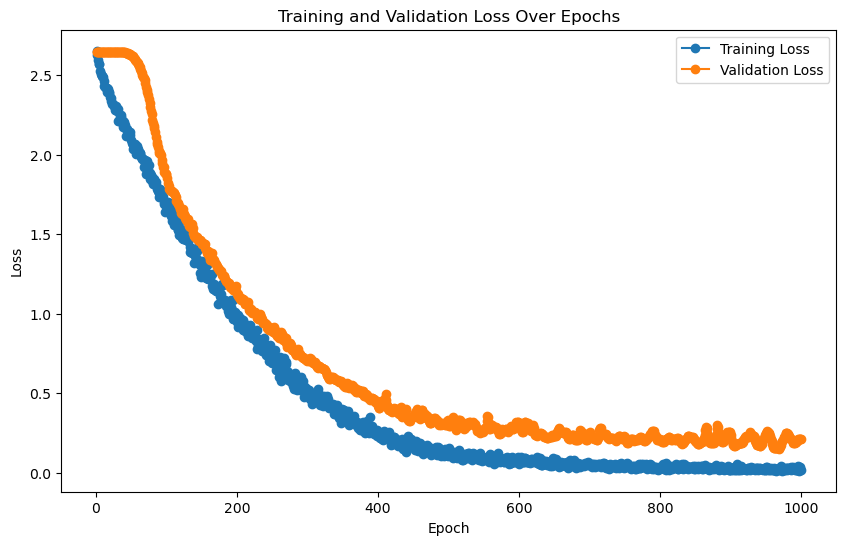

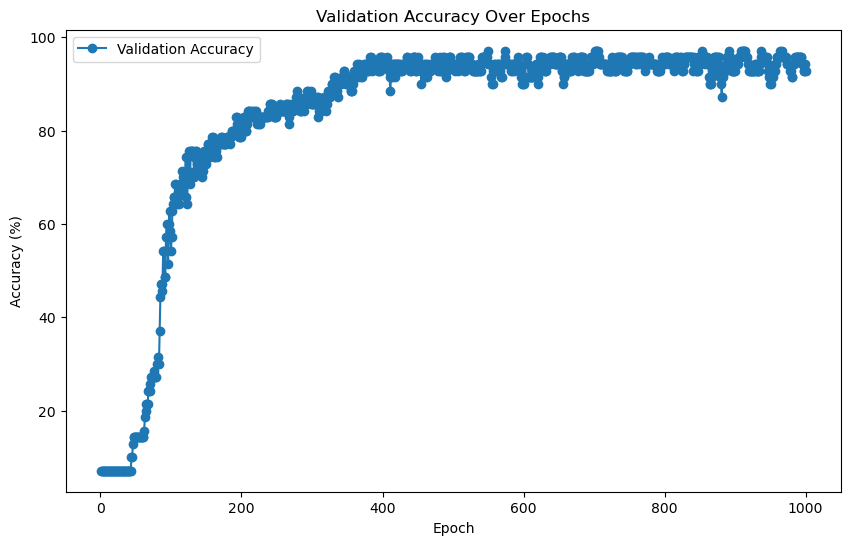


Evaluating on the test set...
    Test Batch [1/13], Loss: 0.0825



Final Test Loss: 0.3834, Test Accuracy: 88.26%
Saved E2E CNN predictions and true labels to model_predictions


In [21]:
#hyperparameters
num_epochs = 1000
learning_rate = 0.0001

#init the model, CrossEntropy loss function, and optimizer
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

#getting unique labels from entire dataset (train, validation, test)
all_labels = []
for loader in [train_loader, val_loader, test_loader]:
    for _, labels in loader:
        all_labels.extend(labels.tolist())
all_labels = np.unique(all_labels)

# init model with correct number of classes
num_classes = len(all_labels)
model = hyperspectralCNN(input_channels=window_num_channels, num_classes=num_classes).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
#lists to store losses and accuracies
classification_epoch_losses = []
validation_epoch_losses = []
val_accuracies = []

#early stopping parameters
patience = 100
best_val_loss = float('inf')
epochs_without_improvement = 0
best_model_weights = None

#training loop + validation with early stopping
for epoch in range(num_epochs):
    # TRAINING
    model.train()
    running_loss = 0.0
    print(f"\nLOG: Epoch [{epoch + 1}/{num_epochs}] - Training")

    for batch_idx, (data, target) in enumerate(train_loader):
        data = data.to(device).permute(0, 3, 1, 2) 
        target = target.to(device)

        # forward pass
        outputs = model(data)
        loss = criterion(outputs, target)

        # backward pass + optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # accum loss
        running_loss += loss.item()

        if (batch_idx + 1) % 10 == 0:
            print(f"    Training Batch [{batch_idx + 1}/{len(train_loader)}], Loss: {loss.item():.4f}")

    # calc + store average training loss per epoch
    avg_train_loss = running_loss / len(train_loader)
    classification_epoch_losses.append(avg_train_loss)
    print(f"Epoch [{epoch + 1}/{num_epochs}] completed, Average Training Loss: {avg_train_loss:.4f}")

    # VALIDATION
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(val_loader):
            data = data.to(device).permute(0, 3, 1, 2)
            target = target.to(device)
            outputs = model(data)
            loss = criterion(outputs, target)
            val_loss += loss.item()

            # accu calculation
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == target).sum().item()
            total += target.size(0)

            if batch_idx == 0 or (batch_idx + 1) % 10 == 0:
                print(f"    Validation Batch [{batch_idx + 1}/{len(val_loader)}], Loss: {loss.item():.4f}")

    # calc + store validation metrics
    avg_val_loss = val_loss / len(val_loader)
    validation_epoch_losses.append(avg_val_loss)
    val_accuracy = 100 * correct / total
    val_accuracies.append(val_accuracy)
    print(f"Validation Loss: {avg_val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%")

    # early stopping logic
    if avg_val_loss <= best_val_loss:
        print(f"Validation loss improved from {best_val_loss:.4f} to {avg_val_loss:.4f}. Saving model...")
        best_val_loss = avg_val_loss
        epochs_without_improvement = 0
        best_model_weights = model.state_dict()
    else:
        epochs_without_improvement += 1
        print(f"Validation loss did not improve. Patience: {epochs_without_improvement}/{patience}")

    if epochs_without_improvement >= patience:
        print(f"Early stopping triggered at epoch {epoch + 1}. No improvement for {patience} epochs.")
        break

# loading the best model weights
if best_model_weights is not None:
    print("Loading the best model weights...")
    model.load_state_dict(best_model_weights)

completed_epochs = len(classification_epoch_losses)

# plot for loss and accuracy trends over epochs
plt.figure(figsize=(10,6))
plt.plot(range(1, completed_epochs + 1), classification_epoch_losses, label="Training Loss", marker='o')
plt.plot(range(1, completed_epochs + 1), validation_epoch_losses, label="Validation Loss", marker='o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.show()

plt.figure(figsize=(10,6))
plt.plot(range(1, completed_epochs + 1), val_accuracies, label="Validation Accuracy", marker='o')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Validation Accuracy Over Epochs')
plt.legend()
plt.show()

#test Set Evaluation
print("\nEvaluating on the test set...")
model.eval()
test_loss = 0.0
correct = 0
total = 0
e2ecnn_test_predictions = []
e2ecnn_test_true_labels = []

with torch.no_grad():
    for batch_idx, (data, target) in enumerate(test_loader):
        data = data.to(device).permute(0, 3, 1, 2)
        target = target.to(device)
        outputs = model(data)
        loss = criterion(outputs, target)
        test_loss += loss.item()

        #accuracy calc
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == target).sum().item()
        total += target.size(0)

        e2ecnn_test_predictions.extend(predicted.cpu().numpy())
        e2ecnn_test_true_labels.extend(target.cpu().numpy())

        if batch_idx == 0 or (batch_idx + 1) % 1000 == 0:
            print(f"    Test Batch [{batch_idx + 1}/{len(test_loader)}], Loss: {loss.item():.4f}")

#calc + print test metrics
avg_test_loss = test_loss / len(test_loader)
test_accuracy = 100 * correct / total
print(f"\nFinal Test Loss: {avg_test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%")

# Convert to numpy arrays and save
e2e_test_predictions = np.array(e2ecnn_test_predictions)
e2e_test_true_labels = np.array(e2ecnn_test_true_labels)

np.save(os.path.join(predictions_dir, 'e2e_cnn_predictions.npy'), e2e_test_predictions)
np.save(os.path.join(predictions_dir, 'e2e_cnn_true_labels.npy'), e2e_test_true_labels)
print(f"Saved E2E CNN predictions and true labels to {predictions_dir}")

In [22]:
# dir to save the cnn representations
e2ecnn_rep_dir = "e2ecnn_representations"
os.makedirs(e2ecnn_rep_dir, exist_ok=True)

e2ecnn_loaders = {
    'train': train_loader,
    'val': val_loader,
    'test': test_loader
}


model.eval()

with torch.no_grad():
    for e2ecnn_split_name, e2ecnn_loader in e2ecnn_loaders.items():
        print(f"\nExtracting SCL representations for the {e2ecnn_split_name} dataset...")
        # creating subfolder for the split
        e2ecnn_split_dir = os.path.join(e2ecnn_rep_dir, e2ecnn_split_name)
        os.makedirs(e2ecnn_split_dir, exist_ok=True)

        # processing the data batch-wise
        for e2ecnn_batch_idx, (e2ecnn_vectors, e2ecnn_labels) in enumerate(e2ecnn_loader):
            e2ecnn_vectors = e2ecnn_vectors.permute(0, 3, 1, 2) 
            e2ecnn_vectors = e2ecnn_vectors.to(device).float()
            # computing projections using the trained SCL model
            e2ecnn_projections = model(e2ecnn_vectors)

            # converting projections and labels to np arrays
            e2ecnn_projections_np = e2ecnn_projections.cpu().numpy()
            e2ecnn_labels_np = e2ecnn_labels.cpu().numpy()

            # saving the batch projections and labels
            np.save(os.path.join(e2ecnn_split_dir, f"cnn_encoded_batch_{e2ecnn_batch_idx}.npy"), e2ecnn_projections_np)
            np.save(os.path.join(e2ecnn_split_dir, f"cnn_labels_batch_{e2ecnn_batch_idx}.npy"), e2ecnn_labels_np)

            if (e2ecnn_batch_idx + 1) % 10 == 0:
                print(f"  Processed batch {e2ecnn_batch_idx + 1}/{len(e2ecnn_loader)} for {e2ecnn_split_name} dataset.")

        print(f"Completed extraction for the {e2ecnn_split_name} dataset. Representations saved in '{e2ecnn_split_dir}'.")

print("E2E CNN representations extraction complete.")


Extracting SCL representations for the train dataset...
Completed extraction for the train dataset. Representations saved in 'e2ecnn_representations\train'.

Extracting SCL representations for the val dataset...
Completed extraction for the val dataset. Representations saved in 'e2ecnn_representations\val'.

Extracting SCL representations for the test dataset...
  Processed batch 10/13 for test dataset.
Completed extraction for the test dataset. Representations saved in 'e2ecnn_representations\test'.
E2E CNN representations extraction complete.


In [23]:
def load_cnn_reps_and_labels(split_dir):
    #gather all the cnn_encoded_batch npy files in sorted order
    cnn_rep_files = sorted(glob.glob(os.path.join(split_dir, "cnn_encoded_batch_*.npy")))

    cnn_all_reps = []
    cnn_all_labels = []

    for cnn_rep_file in cnn_rep_files:
        #deriving label filenames
        cnn_label_file = cnn_rep_file.replace("cnn_encoded_batch_", "cnn_labels_batch_")

        cnn_reps = np.load(cnn_rep_file)
        cnn_labels = np.load(cnn_label_file)

        cnn_all_reps.append(cnn_reps)
        cnn_all_labels.append(cnn_labels)

    #concat along first dim
    cnn_all_reps = np.concatenate(cnn_all_reps, axis = 0)
    cnn_all_labels = np.concatenate(cnn_all_labels, axis = 0)

    return cnn_all_reps, cnn_all_labels

In [24]:
cnn_train_dir = os.path.join("e2ecnn_representations", "train")
cnn_val_dir   = os.path.join("e2ecnn_representations", "val")
cnn_test_dir  = os.path.join("e2ecnn_representations", "test")

cnn_train_reps, cnn_train_labels = load_cnn_reps_and_labels(cnn_train_dir)
cnn_val_reps, cnn_val_labels = load_cnn_reps_and_labels(cnn_val_dir)
cnn_test_reps, cnn_test_labels = load_cnn_reps_and_labels(cnn_test_dir)

## Logistic Regression Model

In [25]:
def load_encoded_data(encoded_dir):
    print(f"LOG: Loading encoded data (representations) from {encoded_dir}...")
    features_list = []
    labels_list = []

    #iter through batches
    for filename in sorted(os.listdir(encoded_dir)):
        if filename.startswith('encoded_batch_') and filename.endswith('.npy'):

            #load the features
            features = np.load(os.path.join(encoded_dir, filename))
            features_flat = features.reshape(features.shape[0], -1) #flatten features for LRM
            features_list.append(features_flat)
        
        elif filename.startswith('labels_batch_') and filename.endswith('.npy'):

            #load labels
            labels = np.load(os.path.join(encoded_dir, filename))
            labels_list.append(labels)

    #concat all batches into a single array
    encoded_features = np.vstack(features_list)
    encoded_labels = np.hstack(labels_list)

    print(f"LOG: Loaded {encoded_features.shape[0]} samples with {encoded_features.shape[1]} features each")
    print(f"LOG: Labels shape: {encoded_labels.shape}")

    return encoded_features, encoded_labels

In [26]:
lrm_encoded_train_dir = os.path.join(encoded_dir, 'train')
lrm_encoded_val_dir = os.path.join(encoded_dir, 'val')
lrm_encoded_test_dir = os.path.join(encoded_dir, 'test')

print("\nLoading training data for LRM...")
lrm_train_features, lrm_train_labels = load_encoded_data(lrm_encoded_train_dir)

print("\nLoading validation data for LRM...")
lrm_val_features, lrm_val_labels = load_encoded_data(lrm_encoded_val_dir)

print("\nLoading test data for LRM...")
lrm_test_features, lrm_test_labels = load_encoded_data(lrm_encoded_test_dir)

#verify shapes
print(f"\nLOG: Training features shape: {lrm_train_features.shape}, Training labels shape: {lrm_train_labels.shape}")
print(f"LOG: Validation features shape: {lrm_val_features.shape}, Validation labels shape: {lrm_val_labels.shape}")
print(f"LOG: Test features shape: {lrm_test_features.shape}, Test labels shape: {lrm_test_labels.shape}")

print("\nLOG: Training Logistic Regression model...")
logistic_clf = LogisticRegression(max_iter=5000, random_state=42, class_weight = 'balanced')
logistic_clf.fit(lrm_train_features, lrm_train_labels)
print("LOG: Logistic Regression training complete.")

#eval on Validation Set
print("\nLOG: Evaluating on the validation set...")
lrm_val_predictions = logistic_clf.predict(lrm_val_features)
lrm_val_accuracy = accuracy_score(lrm_val_labels, lrm_val_predictions)
print(f"Validation Accuracy: {lrm_val_accuracy * 100:.2f}%")
print("\nValidation Classification Report:\n", classification_report(lrm_val_labels, lrm_val_predictions))

#eval on Test Set
print("\nLOG: Evaluating on the test set...")
lrm_test_predictions = logistic_clf.predict(lrm_test_features)
lrm_test_accuracy = accuracy_score(lrm_test_labels, lrm_test_predictions)
print(f"Test Accuracy: {lrm_test_accuracy * 100:.2f}%")
print("\nTest Classification Report:\n", classification_report(lrm_test_labels, lrm_test_predictions))

np.save(os.path.join(predictions_dir, 'cae_lrm_predictions.npy'), lrm_test_predictions)
np.save(os.path.join(predictions_dir, 'cae_lrm_true_labels.npy'), lrm_test_labels)
print(f"Saved CAE+LRM predictions and true labels to {predictions_dir}")



Loading training data for LRM...
LOG: Loading encoded data (representations) from encoded_representations\train...
LOG: Loaded 70 samples with 64 features each
LOG: Labels shape: (70,)

Loading validation data for LRM...
LOG: Loading encoded data (representations) from encoded_representations\val...
LOG: Loaded 70 samples with 64 features each
LOG: Labels shape: (70,)

Loading test data for LRM...
LOG: Loading encoded data (representations) from encoded_representations\test...
LOG: Loaded 3108 samples with 64 features each
LOG: Labels shape: (3108,)

LOG: Training features shape: (70, 64), Training labels shape: (70,)
LOG: Validation features shape: (70, 64), Validation labels shape: (70,)
LOG: Test features shape: (3108, 64), Test labels shape: (3108,)

LOG: Training Logistic Regression model...
LOG: Logistic Regression training complete.

LOG: Evaluating on the validation set...
Validation Accuracy: 57.14%

Validation Classification Report:
               precision    recall  f1-sco

### Classifying CAE Embeddings with MLP

In [27]:
class MLPClassifier(nn.Module):
    def __init__(self, input_dim, num_classes):
        super(MLPClassifier, self).__init__()
        self.fc1 = nn.Linear(input_dim, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, 32)
        self.fc4 = nn.Linear(32, num_classes)
        
        self._init_weights()
    
    def _init_weights(self):
        for m in self.modules(): 
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                nn.init.constant_(m.bias, 0)
    
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        return self.fc4(x)

In [28]:
cae_mlp_train_dir = os.path.join("encoded_representations", "train")
cae_mlp_val_dir   = os.path.join("encoded_representations", "val")
cae_mlp_test_dir  = os.path.join("encoded_representations", "test")

cae_mlp_train_reps, cae_mlp_train_labels = load_encoded_data(cae_mlp_train_dir)
cae_mlp_val_reps, cae_mlp_val_labels = load_encoded_data(cae_mlp_val_dir)
cae_mlp_test_reps, cae_mlp_test_labels = load_encoded_data(cae_mlp_test_dir)

print("Train reps shape:",cae_mlp_train_reps.shape)
print("Train labels shape:", cae_mlp_train_labels.shape)

print("Val reps shape:", cae_mlp_val_reps.shape)
print("Val labels shape:", cae_mlp_val_labels.shape)

print("Test reps shape:", cae_mlp_test_reps.shape)
print("Test labels shape:", cae_mlp_test_labels.shape)

LOG: Loading encoded data (representations) from encoded_representations\train...
LOG: Loaded 70 samples with 64 features each
LOG: Labels shape: (70,)
LOG: Loading encoded data (representations) from encoded_representations\val...
LOG: Loaded 70 samples with 64 features each
LOG: Labels shape: (70,)
LOG: Loading encoded data (representations) from encoded_representations\test...
LOG: Loaded 3108 samples with 64 features each
LOG: Labels shape: (3108,)
Train reps shape: (70, 64)
Train labels shape: (70,)
Val reps shape: (70, 64)
Val labels shape: (70,)
Test reps shape: (3108, 64)
Test labels shape: (3108,)


In [29]:
#converting arrays to torch tensors
cae_mlp_train_embeddings_torch = torch.tensor(cae_mlp_train_reps, dtype=torch.float32)
cae_mlp_train_labels_torch = torch.tensor(cae_mlp_train_labels, dtype=torch.long)

cae_mlp_val_embeddings_torch = torch.tensor(cae_mlp_val_reps, dtype=torch.float32)
cae_mlp_val_labels_torch = torch.tensor(cae_mlp_val_labels, dtype=torch.long)

cae_mlp_test_embeddings_torch = torch.tensor(cae_mlp_test_reps, dtype=torch.float32)
cae_mlp_test_labels_torch = torch.tensor(cae_mlp_test_labels, dtype=torch.long)

#building datasets for mlp
cae_mlp_train_dataset = TensorDataset(cae_mlp_train_embeddings_torch, cae_mlp_train_labels_torch)
cae_mlp_val_dataset = TensorDataset(cae_mlp_val_embeddings_torch, cae_mlp_val_labels_torch)
cae_mlp_test_dataset = TensorDataset(cae_mlp_test_embeddings_torch, cae_mlp_test_labels_torch)

cae_mlp_batch_size = 64
cae_mlp_train_loader = DataLoader(cae_mlp_train_dataset, batch_size=cae_mlp_batch_size, shuffle=True)
cae_mlp_val_loader = DataLoader(cae_mlp_val_dataset, batch_size=cae_mlp_batch_size, shuffle=False)
cae_mlp_test_loader = DataLoader(cae_mlp_test_dataset, batch_size=cae_mlp_batch_size, shuffle=False)


[Epoch 1/1000] Train Loss: 2.8968  |  Val Loss: 2.7678
Validation loss improved from inf to 2.7678.
[Epoch 2/1000] Train Loss: 2.7628  |  Val Loss: 2.7014
Validation loss improved from 2.7678 to 2.7014.
[Epoch 3/1000] Train Loss: 2.6949  |  Val Loss: 2.6695
Validation loss improved from 2.7014 to 2.6695.
[Epoch 4/1000] Train Loss: 2.6691  |  Val Loss: 2.6512
Validation loss improved from 2.6695 to 2.6512.
[Epoch 5/1000] Train Loss: 2.6526  |  Val Loss: 2.6512
Validation loss improved from 2.6512 to 2.6512.
[Epoch 6/1000] Train Loss: 2.6510  |  Val Loss: 2.6540
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 7/1000] Train Loss: 2.6551  |  Val Loss: 2.6528
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 8/1000] Train Loss: 2.6541  |  Val Loss: 2.6489
Validation loss improved from 2.6512 to 2.6489.


[Epoch 9/1000] Train Loss: 2.6498  |  Val Loss: 2.6442
Validation loss improved from 2.6489 to 2.6442.
[Epoch 10/1000] Train Loss: 2.6454  |  Val Loss: 2.6406
Validation loss improved from 2.6442 to 2.6406.
[Epoch 11/1000] Train Loss: 2.6402  |  Val Loss: 2.6368
Validation loss improved from 2.6406 to 2.6368.
[Epoch 12/1000] Train Loss: 2.6366  |  Val Loss: 2.6333
Validation loss improved from 2.6368 to 2.6333.
[Epoch 13/1000] Train Loss: 2.6334  |  Val Loss: 2.6310
Validation loss improved from 2.6333 to 2.6310.
[Epoch 14/1000] Train Loss: 2.6302  |  Val Loss: 2.6282
Validation loss improved from 2.6310 to 2.6282.
[Epoch 15/1000] Train Loss: 2.6269  |  Val Loss: 2.6251
Validation loss improved from 2.6282 to 2.6251.
[Epoch 16/1000] Train Loss: 2.6242  |  Val Loss: 2.6227
Validation loss improved from 2.6251 to 2.6227.
[Epoch 17/1000] Train Loss: 2.6217  |  Val Loss: 2.6197
Validation loss improved from 2.6227 to 2.6197.
[Epoch 18/1000] Train Loss: 2.6187  |  Val Loss: 2.6166
Validatio

[Epoch 36/1000] Train Loss: 2.5822  |  Val Loss: 2.5792
Validation loss improved from 2.5812 to 2.5792.
[Epoch 37/1000] Train Loss: 2.5798  |  Val Loss: 2.5754
Validation loss improved from 2.5792 to 2.5754.
[Epoch 38/1000] Train Loss: 2.5762  |  Val Loss: 2.5716
Validation loss improved from 2.5754 to 2.5716.
[Epoch 39/1000] Train Loss: 2.5719  |  Val Loss: 2.5670
Validation loss improved from 2.5716 to 2.5670.
[Epoch 40/1000] Train Loss: 2.5671  |  Val Loss: 2.5614
Validation loss improved from 2.5670 to 2.5614.
[Epoch 41/1000] Train Loss: 2.5624  |  Val Loss: 2.5576
Validation loss improved from 2.5614 to 2.5576.
[Epoch 42/1000] Train Loss: 2.5590  |  Val Loss: 2.5561
Validation loss improved from 2.5576 to 2.5561.


[Epoch 43/1000] Train Loss: 2.5568  |  Val Loss: 2.5529
Validation loss improved from 2.5561 to 2.5529.
[Epoch 44/1000] Train Loss: 2.5529  |  Val Loss: 2.5496
Validation loss improved from 2.5529 to 2.5496.
[Epoch 45/1000] Train Loss: 2.5503  |  Val Loss: 2.5461
Validation loss improved from 2.5496 to 2.5461.
[Epoch 46/1000] Train Loss: 2.5458  |  Val Loss: 2.5430
Validation loss improved from 2.5461 to 2.5430.
[Epoch 47/1000] Train Loss: 2.5417  |  Val Loss: 2.5434
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 48/1000] Train Loss: 2.5429  |  Val Loss: 2.5409
Validation loss improved from 2.5430 to 2.5409.
[Epoch 49/1000] Train Loss: 2.5404  |  Val Loss: 2.5310
Validation loss improved from 2.5409 to 2.5310.
[Epoch 50/1000] Train Loss: 2.5317  |  Val Loss: 2.5229
Validation loss improved from 2.5310 to 2.5229.
[Epoch 51/1000] Train Loss: 2.5229  |  Val Loss: 2.5175
Validation loss improved from 2.5229 to 2.5175.


[Epoch 52/1000] Train Loss: 2.5177  |  Val Loss: 2.5160
Validation loss improved from 2.5175 to 2.5160.
[Epoch 53/1000] Train Loss: 2.5150  |  Val Loss: 2.5209
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 54/1000] Train Loss: 2.5207  |  Val Loss: 2.5220
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 55/1000] Train Loss: 2.5212  |  Val Loss: 2.5154
Validation loss improved from 2.5160 to 2.5154.
[Epoch 56/1000] Train Loss: 2.5159  |  Val Loss: 2.5070
Validation loss improved from 2.5154 to 2.5070.
[Epoch 57/1000] Train Loss: 2.5056  |  Val Loss: 2.4923
Validation loss improved from 2.5070 to 2.4923.
[Epoch 58/1000] Train Loss: 2.4942  |  Val Loss: 2.4849
Validation loss improved from 2.4923 to 2.4849.
[Epoch 59/1000] Train Loss: 2.4875  |  Val Loss: 2.4802
Validation loss improved from 2.4849 to 2.4802.
[Epoch 60/1000] Train Loss: 2.4807  |  Val Loss: 2.4667
Validation loss improved from 2.4802 to 2.4667.
[Epoch 61/1000] Train Loss: 2.4695  |  Val Loss: 2.4

[Epoch 77/1000] Train Loss: 2.3499  |  Val Loss: 2.3314
Validation loss improved from 2.3506 to 2.3314.
[Epoch 78/1000] Train Loss: 2.3302  |  Val Loss: 2.3234
Validation loss improved from 2.3314 to 2.3234.
[Epoch 79/1000] Train Loss: 2.3224  |  Val Loss: 2.3271
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 80/1000] Train Loss: 2.3271  |  Val Loss: 2.3200
Validation loss improved from 2.3234 to 2.3200.
[Epoch 81/1000] Train Loss: 2.3177  |  Val Loss: 2.2976
Validation loss improved from 2.3200 to 2.2976.
[Epoch 82/1000] Train Loss: 2.2966  |  Val Loss: 2.3133
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 83/1000] Train Loss: 2.3089  |  Val Loss: 2.3040
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 84/1000] Train Loss: 2.2959  |  Val Loss: 2.2475
Validation loss improved from 2.2976 to 2.2475.
[Epoch 85/1000] Train Loss: 2.2470  |  Val Loss: 2.2651
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 86/1000] Train Loss: 2.2680  |  V

[Epoch 89/1000] Train Loss: 2.2332  |  Val Loss: 2.2006
Validation loss improved from 2.2174 to 2.2006.
[Epoch 90/1000] Train Loss: 2.2019  |  Val Loss: 2.1833
Validation loss improved from 2.2006 to 2.1833.
[Epoch 91/1000] Train Loss: 2.1863  |  Val Loss: 2.1888
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 92/1000] Train Loss: 2.1902  |  Val Loss: 2.1619
Validation loss improved from 2.1833 to 2.1619.
[Epoch 93/1000] Train Loss: 2.1630  |  Val Loss: 2.1574
Validation loss improved from 2.1619 to 2.1574.
[Epoch 94/1000] Train Loss: 2.1592  |  Val Loss: 2.1590
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 95/1000] Train Loss: 2.1574  |  Val Loss: 2.1317
Validation loss improved from 2.1574 to 2.1317.
[Epoch 96/1000] Train Loss: 2.1334  |  Val Loss: 2.1262
Validation loss improved from 2.1317 to 2.1262.
[Epoch 97/1000] Train Loss: 2.1277  |  Val Loss: 2.1234
Validation loss improved from 2.1262 to 2.1234.
[Epoch 98/1000] Train Loss: 2.1235  |  Val Loss: 2.1

[Epoch 115/1000] Train Loss: 1.9278  |  Val Loss: 1.9457
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 116/1000] Train Loss: 1.9377  |  Val Loss: 1.9293
Validation loss improved from 1.9318 to 1.9293.
[Epoch 117/1000] Train Loss: 1.9216  |  Val Loss: 1.9111
Validation loss improved from 1.9293 to 1.9111.
[Epoch 118/1000] Train Loss: 1.9125  |  Val Loss: 1.8955
Validation loss improved from 1.9111 to 1.8955.
[Epoch 119/1000] Train Loss: 1.8943  |  Val Loss: 1.8995
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 120/1000] Train Loss: 1.8955  |  Val Loss: 1.9166
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 121/1000] Train Loss: 1.9093  |  Val Loss: 1.8776
Validation loss improved from 1.8955 to 1.8776.
[Epoch 122/1000] Train Loss: 1.8839  |  Val Loss: 1.9074
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 123/1000] Train Loss: 1.9171  |  Val Loss: 1.8614
Validation loss improved from 1.8776 to 1.8614.
[Epoch 124/1000] Train Loss: 1.

[Epoch 130/1000] Train Loss: 1.7992  |  Val Loss: 1.8027
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 131/1000] Train Loss: 1.7865  |  Val Loss: 1.7845
Validation loss improved from 1.8019 to 1.7845.
[Epoch 132/1000] Train Loss: 1.7789  |  Val Loss: 1.8127
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 133/1000] Train Loss: 1.8121  |  Val Loss: 1.7732
Validation loss improved from 1.7845 to 1.7732.
[Epoch 134/1000] Train Loss: 1.7696  |  Val Loss: 1.8141
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 135/1000] Train Loss: 1.7920  |  Val Loss: 1.7863
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 136/1000] Train Loss: 1.7640  |  Val Loss: 1.7580
Validation loss improved from 1.7732 to 1.7580.
[Epoch 137/1000] Train Loss: 1.7525  |  Val Loss: 1.7500
Validation loss improved from 1.7580 to 1.7500.
[Epoch 138/1000] Train Loss: 1.7430  |  Val Loss: 1.7342
Validation loss improved from 1.7500 to 1.7342.
[Epoch 139/1000] Train Loss: 1.

[Epoch 152/1000] Train Loss: 1.6339  |  Val Loss: 1.6329
Validation loss improved from 1.6499 to 1.6329.
[Epoch 153/1000] Train Loss: 1.6179  |  Val Loss: 1.6149
Validation loss improved from 1.6329 to 1.6149.
[Epoch 154/1000] Train Loss: 1.6044  |  Val Loss: 1.6236
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 155/1000] Train Loss: 1.6223  |  Val Loss: 1.6365
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 156/1000] Train Loss: 1.6390  |  Val Loss: 1.6646
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 157/1000] Train Loss: 1.6542  |  Val Loss: 1.6492
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 158/1000] Train Loss: 1.6441  |  Val Loss: 1.6413
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 159/1000] Train Loss: 1.6433  |  Val Loss: 1.6140
Validation loss improved from 1.6149 to 1.6140.
[Epoch 160/1000] Train Loss: 1.6126  |  Val Loss: 1.5961
Validation loss improved from 1.6140 to 1.5961.
[Epoch 161/1000] Train Lo

[Epoch 170/1000] Train Loss: 1.5641  |  Val Loss: 1.5505
Validation loss improved from 1.5612 to 1.5505.
[Epoch 171/1000] Train Loss: 1.5281  |  Val Loss: 1.5371
Validation loss improved from 1.5505 to 1.5371.
[Epoch 172/1000] Train Loss: 1.5255  |  Val Loss: 1.5429
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 173/1000] Train Loss: 1.5326  |  Val Loss: 1.5495
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 174/1000] Train Loss: 1.5357  |  Val Loss: 1.5586
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 175/1000] Train Loss: 1.5434  |  Val Loss: 1.5692
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 176/1000] Train Loss: 1.5502  |  Val Loss: 1.5747
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 177/1000] Train Loss: 1.5454  |  Val Loss: 1.5734
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 178/1000] Train Loss: 1.5393  |  Val Loss: 1.5691
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 179/10

[Epoch 192/1000] Train Loss: 1.4647  |  Val Loss: 1.5266
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 193/1000] Train Loss: 1.4887  |  Val Loss: 1.5092
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 194/1000] Train Loss: 1.4653  |  Val Loss: 1.4795
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 195/1000] Train Loss: 1.4518  |  Val Loss: 1.4642
Validation loss improved from 1.4733 to 1.4642.
[Epoch 196/1000] Train Loss: 1.4266  |  Val Loss: 1.4892
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 197/1000] Train Loss: 1.4453  |  Val Loss: 1.4754
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 198/1000] Train Loss: 1.4360  |  Val Loss: 1.4589
Validation loss improved from 1.4642 to 1.4589.
[Epoch 199/1000] Train Loss: 1.4398  |  Val Loss: 1.4530
Validation loss improved from 1.4589 to 1.4530.
[Epoch 200/1000] Train Loss: 1.4351  |  Val Loss: 1.4258
Validation loss improved from 1.4530 to 1.4258.
[Epoch 201/1000] Train Lo

[Epoch 211/1000] Train Loss: 1.3750  |  Val Loss: 1.4087
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 212/1000] Train Loss: 1.3694  |  Val Loss: 1.4341
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 213/1000] Train Loss: 1.3982  |  Val Loss: 1.4342
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 214/1000] Train Loss: 1.3914  |  Val Loss: 1.4423
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 215/1000] Train Loss: 1.3848  |  Val Loss: 1.4637
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 216/1000] Train Loss: 1.3966  |  Val Loss: 1.4216
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 217/1000] Train Loss: 1.3601  |  Val Loss: 1.4508
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 218/1000] Train Loss: 1.4180  |  Val Loss: 1.4176
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 219/1000] Train Loss: 1.3801  |  Val Loss: 1.4296
!! Validation loss did NOT improve !! Patience: 10/100


[Epoch 231/1000] Train Loss: 1.3061  |  Val Loss: 1.3524
Validation loss improved from 1.3541 to 1.3524.
[Epoch 232/1000] Train Loss: 1.3118  |  Val Loss: 1.3381
Validation loss improved from 1.3524 to 1.3381.
[Epoch 233/1000] Train Loss: 1.2974  |  Val Loss: 1.3521
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 234/1000] Train Loss: 1.3059  |  Val Loss: 1.3475
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 235/1000] Train Loss: 1.2991  |  Val Loss: 1.3454
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 236/1000] Train Loss: 1.2990  |  Val Loss: 1.3553
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 237/1000] Train Loss: 1.3023  |  Val Loss: 1.3836
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 238/1000] Train Loss: 1.3213  |  Val Loss: 1.3870
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 239/1000] Train Loss: 1.3198  |  Val Loss: 1.3925
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 240/10

[Epoch 251/1000] Train Loss: 1.3661  |  Val Loss: 1.3446
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 252/1000] Train Loss: 1.3535  |  Val Loss: 1.3547
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 253/1000] Train Loss: 1.3504  |  Val Loss: 1.3759
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 254/1000] Train Loss: 1.3577  |  Val Loss: 1.3641
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 255/1000] Train Loss: 1.3270  |  Val Loss: 1.3480
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 256/1000] Train Loss: 1.3007  |  Val Loss: 1.3444
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 257/1000] Train Loss: 1.2785  |  Val Loss: 1.3789
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 258/1000] Train Loss: 1.3021  |  Val Loss: 1.3966
!! Validation loss did NOT improve !! Patience: 10/100
[Epoch 259/1000] Train Loss: 1.3095  |  Val Loss: 1.3789
!! Validation loss did NOT improve !! Patience: 11/100

[Epoch 273/1000] Train Loss: 1.2641  |  Val Loss: 1.3089
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 274/1000] Train Loss: 1.2457  |  Val Loss: 1.2930
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 275/1000] Train Loss: 1.2447  |  Val Loss: 1.3108
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 276/1000] Train Loss: 1.2704  |  Val Loss: 1.2896
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 277/1000] Train Loss: 1.2327  |  Val Loss: 1.3264
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 278/1000] Train Loss: 1.2523  |  Val Loss: 1.3271
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 279/1000] Train Loss: 1.2476  |  Val Loss: 1.2806
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 280/1000] Train Loss: 1.2232  |  Val Loss: 1.2765
!! Validation loss did NOT improve !! Patience: 10/100
[Epoch 281/1000] Train Loss: 1.2288  |  Val Loss: 1.2662
Validation loss improved from 1.2757 to 1.2662.
[Epoch

[Epoch 291/1000] Train Loss: 1.1904  |  Val Loss: 1.3165
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 292/1000] Train Loss: 1.2537  |  Val Loss: 1.2637
Validation loss improved from 1.2638 to 1.2637.
[Epoch 293/1000] Train Loss: 1.2012  |  Val Loss: 1.2636
Validation loss improved from 1.2637 to 1.2636.
[Epoch 294/1000] Train Loss: 1.1933  |  Val Loss: 1.2523
Validation loss improved from 1.2636 to 1.2523.
[Epoch 295/1000] Train Loss: 1.1896  |  Val Loss: 1.2461
Validation loss improved from 1.2523 to 1.2461.
[Epoch 296/1000] Train Loss: 1.1801  |  Val Loss: 1.2524
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 297/1000] Train Loss: 1.1805  |  Val Loss: 1.2474
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 298/1000] Train Loss: 1.1717  |  Val Loss: 1.2549
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 299/1000] Train Loss: 1.1777  |  Val Loss: 1.2818
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 300/1000] Train Lo

[Epoch 313/1000] Train Loss: 1.1757  |  Val Loss: 1.2587
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 314/1000] Train Loss: 1.1668  |  Val Loss: 1.2454
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 315/1000] Train Loss: 1.1511  |  Val Loss: 1.3042
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 316/1000] Train Loss: 1.2228  |  Val Loss: 1.2878
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 317/1000] Train Loss: 1.1950  |  Val Loss: 1.2962
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 318/1000] Train Loss: 1.1879  |  Val Loss: 1.2922
!! Validation loss did NOT improve !! Patience: 10/100
[Epoch 319/1000] Train Loss: 1.1762  |  Val Loss: 1.3043
!! Validation loss did NOT improve !! Patience: 11/100
[Epoch 320/1000] Train Loss: 1.2035  |  Val Loss: 1.3075
!! Validation loss did NOT improve !! Patience: 12/100
[Epoch 321/1000] Train Loss: 1.2084  |  Val Loss: 1.2580
!! Validation loss did NOT improve !! Patience: 13/1

[Epoch 330/1000] Train Loss: 1.1832  |  Val Loss: 1.2744
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 331/1000] Train Loss: 1.1871  |  Val Loss: 1.2909
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 332/1000] Train Loss: 1.1842  |  Val Loss: 1.2816
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 333/1000] Train Loss: 1.1593  |  Val Loss: 1.3690
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 334/1000] Train Loss: 1.2386  |  Val Loss: 1.2697
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 335/1000] Train Loss: 1.1405  |  Val Loss: 1.3022
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 336/1000] Train Loss: 1.2069  |  Val Loss: 1.2361
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 337/1000] Train Loss: 1.1210  |  Val Loss: 1.3739
!! Validation loss did NOT improve !! Patience: 10/100
[Epoch 338/1000] Train Loss: 1.2683  |  Val Loss: 1.3716
!! Validation loss did NOT improve !! Patience: 11/100

[Epoch 356/1000] Train Loss: 1.1384  |  Val Loss: 1.2459
!! Validation loss did NOT improve !! Patience: 10/100
[Epoch 357/1000] Train Loss: 1.1273  |  Val Loss: 1.3452
!! Validation loss did NOT improve !! Patience: 11/100
[Epoch 358/1000] Train Loss: 1.2357  |  Val Loss: 1.2845
!! Validation loss did NOT improve !! Patience: 12/100
[Epoch 359/1000] Train Loss: 1.1784  |  Val Loss: 1.2829
!! Validation loss did NOT improve !! Patience: 13/100
[Epoch 360/1000] Train Loss: 1.2161  |  Val Loss: 1.2751
!! Validation loss did NOT improve !! Patience: 14/100
[Epoch 361/1000] Train Loss: 1.2085  |  Val Loss: 1.2484
!! Validation loss did NOT improve !! Patience: 15/100
[Epoch 362/1000] Train Loss: 1.1546  |  Val Loss: 1.2476
!! Validation loss did NOT improve !! Patience: 16/100
[Epoch 363/1000] Train Loss: 1.1347  |  Val Loss: 1.2201
!! Validation loss did NOT improve !! Patience: 17/100
[Epoch 364/1000] Train Loss: 1.1128  |  Val Loss: 1.2528
!! Validation loss did NOT improve !! Patience:

[Epoch 379/1000] Train Loss: 1.1739  |  Val Loss: 1.2638
!! Validation loss did NOT improve !! Patience: 33/100
[Epoch 380/1000] Train Loss: 1.1197  |  Val Loss: 1.2346
!! Validation loss did NOT improve !! Patience: 34/100
[Epoch 381/1000] Train Loss: 1.0952  |  Val Loss: 1.2682
!! Validation loss did NOT improve !! Patience: 35/100
[Epoch 382/1000] Train Loss: 1.1288  |  Val Loss: 1.2519
!! Validation loss did NOT improve !! Patience: 36/100
[Epoch 383/1000] Train Loss: 1.1127  |  Val Loss: 1.2551
!! Validation loss did NOT improve !! Patience: 37/100
[Epoch 384/1000] Train Loss: 1.1068  |  Val Loss: 1.2555
!! Validation loss did NOT improve !! Patience: 38/100
[Epoch 385/1000] Train Loss: 1.1187  |  Val Loss: 1.2397
!! Validation loss did NOT improve !! Patience: 39/100
[Epoch 386/1000] Train Loss: 1.0950  |  Val Loss: 1.2844
!! Validation loss did NOT improve !! Patience: 40/100
[Epoch 387/1000] Train Loss: 1.1490  |  Val Loss: 1.2389
!! Validation loss did NOT improve !! Patience:

[Epoch 400/1000] Train Loss: 1.0980  |  Val Loss: 1.2847
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 401/1000] Train Loss: 1.1477  |  Val Loss: 1.2568
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 402/1000] Train Loss: 1.1224  |  Val Loss: 1.2100
!! Validation loss did NOT improve !! Patience: 10/100
[Epoch 403/1000] Train Loss: 1.0766  |  Val Loss: 1.2057
!! Validation loss did NOT improve !! Patience: 11/100
[Epoch 404/1000] Train Loss: 1.0905  |  Val Loss: 1.2076
!! Validation loss did NOT improve !! Patience: 12/100
[Epoch 405/1000] Train Loss: 1.0931  |  Val Loss: 1.2296
!! Validation loss did NOT improve !! Patience: 13/100
[Epoch 406/1000] Train Loss: 1.1290  |  Val Loss: 1.2719
!! Validation loss did NOT improve !! Patience: 14/100
[Epoch 407/1000] Train Loss: 1.1711  |  Val Loss: 1.2626
!! Validation loss did NOT improve !! Patience: 15/100
[Epoch 408/1000] Train Loss: 1.1514  |  Val Loss: 1.2491
!! Validation loss did NOT improve !! Patience: 1

[Epoch 421/1000] Train Loss: 1.2039  |  Val Loss: 1.2328
!! Validation loss did NOT improve !! Patience: 12/100
[Epoch 422/1000] Train Loss: 1.1203  |  Val Loss: 1.2036
!! Validation loss did NOT improve !! Patience: 13/100
[Epoch 423/1000] Train Loss: 1.0711  |  Val Loss: 1.2851
!! Validation loss did NOT improve !! Patience: 14/100
[Epoch 424/1000] Train Loss: 1.1554  |  Val Loss: 1.1961
Validation loss improved from 1.1963 to 1.1961.
[Epoch 425/1000] Train Loss: 1.0795  |  Val Loss: 1.2092
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 426/1000] Train Loss: 1.1141  |  Val Loss: 1.2335
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 427/1000] Train Loss: 1.1360  |  Val Loss: 1.2009
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 428/1000] Train Loss: 1.0824  |  Val Loss: 1.3032
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 429/1000] Train Loss: 1.1818  |  Val Loss: 1.3022
!! Validation loss did NOT improve !! Patience: 5/100
[Epo

[Epoch 441/1000] Train Loss: 1.0431  |  Val Loss: 1.1965
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 442/1000] Train Loss: 1.0800  |  Val Loss: 1.2505
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 443/1000] Train Loss: 1.1313  |  Val Loss: 1.1860
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 444/1000] Train Loss: 1.0463  |  Val Loss: 1.2397
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 445/1000] Train Loss: 1.0869  |  Val Loss: 1.2580
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 446/1000] Train Loss: 1.0924  |  Val Loss: 1.2152
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 447/1000] Train Loss: 1.0426  |  Val Loss: 1.2429
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 448/1000] Train Loss: 1.0754  |  Val Loss: 1.2405
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 449/1000] Train Loss: 1.0499  |  Val Loss: 1.2614
!! Validation loss did NOT improve !! Patience: 9/100
[

[Epoch 460/1000] Train Loss: 1.0561  |  Val Loss: 1.2188
!! Validation loss did NOT improve !! Patience: 20/100
[Epoch 461/1000] Train Loss: 1.0739  |  Val Loss: 1.3032
!! Validation loss did NOT improve !! Patience: 21/100
[Epoch 462/1000] Train Loss: 1.1458  |  Val Loss: 1.2755
!! Validation loss did NOT improve !! Patience: 22/100
[Epoch 463/1000] Train Loss: 1.1092  |  Val Loss: 1.2117
!! Validation loss did NOT improve !! Patience: 23/100
[Epoch 464/1000] Train Loss: 1.0497  |  Val Loss: 1.2419
!! Validation loss did NOT improve !! Patience: 24/100
[Epoch 465/1000] Train Loss: 1.0680  |  Val Loss: 1.2179
!! Validation loss did NOT improve !! Patience: 25/100
[Epoch 466/1000] Train Loss: 1.0464  |  Val Loss: 1.2297
!! Validation loss did NOT improve !! Patience: 26/100
[Epoch 467/1000] Train Loss: 1.0680  |  Val Loss: 1.2104
!! Validation loss did NOT improve !! Patience: 27/100
[Epoch 468/1000] Train Loss: 1.0480  |  Val Loss: 1.1911
!! Validation loss did NOT improve !! Patience:

[Epoch 481/1000] Train Loss: 1.1180  |  Val Loss: 1.2662
!! Validation loss did NOT improve !! Patience: 41/100
[Epoch 482/1000] Train Loss: 1.0839  |  Val Loss: 1.3358
!! Validation loss did NOT improve !! Patience: 42/100
[Epoch 483/1000] Train Loss: 1.1587  |  Val Loss: 1.3317
!! Validation loss did NOT improve !! Patience: 43/100
[Epoch 484/1000] Train Loss: 1.1510  |  Val Loss: 1.2139
!! Validation loss did NOT improve !! Patience: 44/100
[Epoch 485/1000] Train Loss: 1.0391  |  Val Loss: 1.2382
!! Validation loss did NOT improve !! Patience: 45/100
[Epoch 486/1000] Train Loss: 1.0747  |  Val Loss: 1.2243
!! Validation loss did NOT improve !! Patience: 46/100
[Epoch 487/1000] Train Loss: 1.0478  |  Val Loss: 1.3505
!! Validation loss did NOT improve !! Patience: 47/100
[Epoch 488/1000] Train Loss: 1.1835  |  Val Loss: 1.2530
!! Validation loss did NOT improve !! Patience: 48/100
[Epoch 489/1000] Train Loss: 1.0891  |  Val Loss: 1.2427
!! Validation loss did NOT improve !! Patience:

[Epoch 503/1000] Train Loss: 1.0975  |  Val Loss: 1.2692
!! Validation loss did NOT improve !! Patience: 63/100
[Epoch 504/1000] Train Loss: 1.0431  |  Val Loss: 1.2756
!! Validation loss did NOT improve !! Patience: 64/100
[Epoch 505/1000] Train Loss: 1.0617  |  Val Loss: 1.2625
!! Validation loss did NOT improve !! Patience: 65/100
[Epoch 506/1000] Train Loss: 1.0450  |  Val Loss: 1.2262
!! Validation loss did NOT improve !! Patience: 66/100
[Epoch 507/1000] Train Loss: 1.0157  |  Val Loss: 1.2238
!! Validation loss did NOT improve !! Patience: 67/100
[Epoch 508/1000] Train Loss: 1.0112  |  Val Loss: 1.2082
!! Validation loss did NOT improve !! Patience: 68/100
[Epoch 509/1000] Train Loss: 1.0073  |  Val Loss: 1.2025
!! Validation loss did NOT improve !! Patience: 69/100
[Epoch 510/1000] Train Loss: 1.0067  |  Val Loss: 1.2065
!! Validation loss did NOT improve !! Patience: 70/100
[Epoch 511/1000] Train Loss: 1.0336  |  Val Loss: 1.2244
!! Validation loss did NOT improve !! Patience:

[Epoch 520/1000] Train Loss: 1.0168  |  Val Loss: 1.1581
Validation loss improved from 1.1607 to 1.1581.
[Epoch 521/1000] Train Loss: 0.9956  |  Val Loss: 1.1696
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 522/1000] Train Loss: 1.0126  |  Val Loss: 1.1801
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 523/1000] Train Loss: 1.0139  |  Val Loss: 1.1910
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 524/1000] Train Loss: 1.0202  |  Val Loss: 1.2074
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 525/1000] Train Loss: 1.0307  |  Val Loss: 1.2029
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 526/1000] Train Loss: 1.0248  |  Val Loss: 1.2090
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 527/1000] Train Loss: 1.0343  |  Val Loss: 1.2110
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 528/1000] Train Loss: 1.0355  |  Val Loss: 1.2100
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 

[Epoch 540/1000] Train Loss: 1.0362  |  Val Loss: 1.2473
!! Validation loss did NOT improve !! Patience: 20/100
[Epoch 541/1000] Train Loss: 1.0146  |  Val Loss: 1.2419
!! Validation loss did NOT improve !! Patience: 21/100
[Epoch 542/1000] Train Loss: 1.0298  |  Val Loss: 1.2120
!! Validation loss did NOT improve !! Patience: 22/100
[Epoch 543/1000] Train Loss: 1.0026  |  Val Loss: 1.2279
!! Validation loss did NOT improve !! Patience: 23/100
[Epoch 544/1000] Train Loss: 1.0293  |  Val Loss: 1.2288
!! Validation loss did NOT improve !! Patience: 24/100
[Epoch 545/1000] Train Loss: 1.0303  |  Val Loss: 1.2053
!! Validation loss did NOT improve !! Patience: 25/100
[Epoch 546/1000] Train Loss: 1.0161  |  Val Loss: 1.2974
!! Validation loss did NOT improve !! Patience: 26/100
[Epoch 547/1000] Train Loss: 1.0852  |  Val Loss: 1.1982
!! Validation loss did NOT improve !! Patience: 27/100
[Epoch 548/1000] Train Loss: 0.9843  |  Val Loss: 1.2862
!! Validation loss did NOT improve !! Patience:

[Epoch 563/1000] Train Loss: 1.0456  |  Val Loss: 1.2294
!! Validation loss did NOT improve !! Patience: 43/100
[Epoch 564/1000] Train Loss: 1.0368  |  Val Loss: 1.1997
!! Validation loss did NOT improve !! Patience: 44/100
[Epoch 565/1000] Train Loss: 1.0123  |  Val Loss: 1.2723
!! Validation loss did NOT improve !! Patience: 45/100
[Epoch 566/1000] Train Loss: 1.0853  |  Val Loss: 1.2350
!! Validation loss did NOT improve !! Patience: 46/100
[Epoch 567/1000] Train Loss: 1.0450  |  Val Loss: 1.2436
!! Validation loss did NOT improve !! Patience: 47/100
[Epoch 568/1000] Train Loss: 1.0526  |  Val Loss: 1.2357
!! Validation loss did NOT improve !! Patience: 48/100
[Epoch 569/1000] Train Loss: 1.0411  |  Val Loss: 1.2313
!! Validation loss did NOT improve !! Patience: 49/100
[Epoch 570/1000] Train Loss: 1.0379  |  Val Loss: 1.2571
!! Validation loss did NOT improve !! Patience: 50/100
[Epoch 571/1000] Train Loss: 1.0686  |  Val Loss: 1.2407
!! Validation loss did NOT improve !! Patience:

[Epoch 583/1000] Train Loss: 0.9891  |  Val Loss: 1.1725
!! Validation loss did NOT improve !! Patience: 63/100
[Epoch 584/1000] Train Loss: 0.9733  |  Val Loss: 1.1861
!! Validation loss did NOT improve !! Patience: 64/100
[Epoch 585/1000] Train Loss: 0.9815  |  Val Loss: 1.1797
!! Validation loss did NOT improve !! Patience: 65/100
[Epoch 586/1000] Train Loss: 0.9699  |  Val Loss: 1.2083
!! Validation loss did NOT improve !! Patience: 66/100
[Epoch 587/1000] Train Loss: 1.0073  |  Val Loss: 1.2079
!! Validation loss did NOT improve !! Patience: 67/100
[Epoch 588/1000] Train Loss: 0.9984  |  Val Loss: 1.2112
!! Validation loss did NOT improve !! Patience: 68/100
[Epoch 589/1000] Train Loss: 0.9979  |  Val Loss: 1.2153
!! Validation loss did NOT improve !! Patience: 69/100
[Epoch 590/1000] Train Loss: 0.9958  |  Val Loss: 1.2054
!! Validation loss did NOT improve !! Patience: 70/100
[Epoch 591/1000] Train Loss: 0.9735  |  Val Loss: 1.2293
!! Validation loss did NOT improve !! Patience:

[Epoch 606/1000] Train Loss: 0.9843  |  Val Loss: 1.2293
!! Validation loss did NOT improve !! Patience: 86/100
[Epoch 607/1000] Train Loss: 1.0226  |  Val Loss: 1.3225
!! Validation loss did NOT improve !! Patience: 87/100
[Epoch 608/1000] Train Loss: 1.1206  |  Val Loss: 1.2178
!! Validation loss did NOT improve !! Patience: 88/100
[Epoch 609/1000] Train Loss: 1.0029  |  Val Loss: 1.2389
!! Validation loss did NOT improve !! Patience: 89/100
[Epoch 610/1000] Train Loss: 1.0161  |  Val Loss: 1.2114
!! Validation loss did NOT improve !! Patience: 90/100
[Epoch 611/1000] Train Loss: 0.9654  |  Val Loss: 1.3268
!! Validation loss did NOT improve !! Patience: 91/100
[Epoch 612/1000] Train Loss: 1.0974  |  Val Loss: 1.2346
!! Validation loss did NOT improve !! Patience: 92/100
[Epoch 613/1000] Train Loss: 0.9654  |  Val Loss: 1.4086
!! Validation loss did NOT improve !! Patience: 93/100
[Epoch 614/1000] Train Loss: 1.1804  |  Val Loss: 1.4164
!! Validation loss did NOT improve !! Patience:

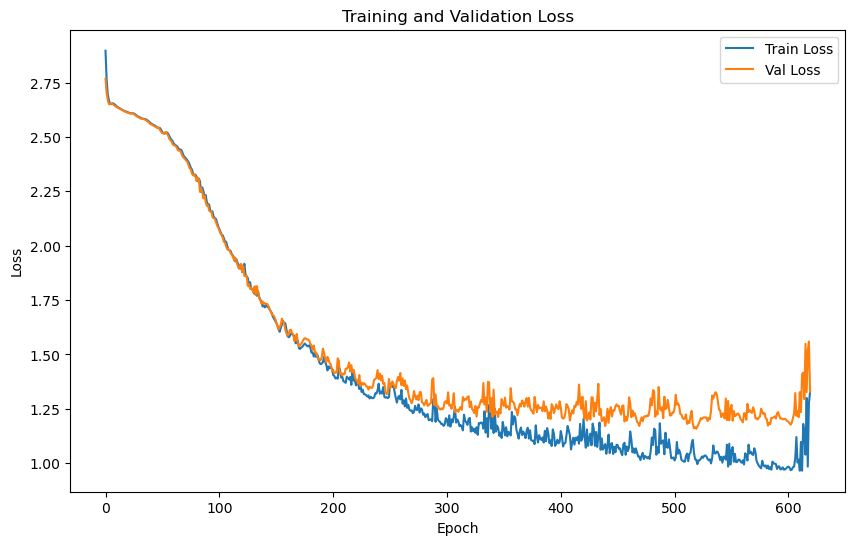

In [30]:
cae_mlp_input_dim = cae_mlp_train_reps.shape[1]
cae_mlp_num_classes = len(torch.unique(cae_mlp_train_labels_torch))
cae_mlp_model = MLPClassifier(cae_mlp_input_dim, cae_mlp_num_classes).to(device)

cae_mlp_criterion = nn.CrossEntropyLoss()
cae_mlp_optimizer = optim.Adam(cae_mlp_model.parameters(), lr=1e-3)

cae_mlp_num_epochs = 1000
cae_mlp_patience = 100

cae_mlp_train_losses = []
cae_mlp_val_losses = []

cae_mlp_best_val_loss = float('inf')
cae_mlp_epochs_without_improvement = 0

for cae_mlp_epoch in range(cae_mlp_num_epochs):
    # Training
    cae_mlp_model.train()
    cae_mlp_train_running_loss = 0.0
    
    for cae_mlp_embeddings_batch, cae_mlp_labels_batch in cae_mlp_train_loader:
        cae_mlp_embeddings_batch = cae_mlp_embeddings_batch.to(device)
        cae_mlp_labels_batch = cae_mlp_labels_batch.to(device)
        
        cae_mlp_optimizer.zero_grad()
        
        # Forward
        cae_mlp_outputs = cae_mlp_model(cae_mlp_embeddings_batch)
        cae_mlp_loss = cae_mlp_criterion(cae_mlp_outputs, cae_mlp_labels_batch)
        
        # Backward & Update
        cae_mlp_loss.backward()
        cae_mlp_optimizer.step()
        
        cae_mlp_train_running_loss += cae_mlp_loss.item() * cae_mlp_embeddings_batch.size(0)
    
    cae_mlp_epoch_train_loss = cae_mlp_train_running_loss / len(cae_mlp_train_loader.dataset)
    cae_mlp_train_losses.append(cae_mlp_epoch_train_loss)


    # Validation

    cae_mlp_model.eval()
    cae_mlp_val_running_loss = 0.0
    
    with torch.no_grad():
        for cae_mlp_val_embeddings_batch, cae_mlp_val_labels_batch in cae_mlp_val_loader:
            cae_mlp_val_embeddings_batch = cae_mlp_val_embeddings_batch.to(device)
            cae_mlp_val_labels_batch = cae_mlp_val_labels_batch.to(device)

            cae_mlp_val_outputs = cae_mlp_model(cae_mlp_val_embeddings_batch)
            cae_mlp_val_loss = cae_mlp_criterion(cae_mlp_val_outputs, cae_mlp_val_labels_batch)

            cae_mlp_val_running_loss += cae_mlp_val_loss.item() * cae_mlp_val_embeddings_batch.size(0)

    cae_mlp_epoch_val_loss = cae_mlp_val_running_loss / len(cae_mlp_val_loader.dataset)
    cae_mlp_val_losses.append(cae_mlp_epoch_val_loss)

    print(f"[Epoch {cae_mlp_epoch+1}/{cae_mlp_num_epochs}] "
          f"Train Loss: {cae_mlp_epoch_train_loss:.4f}  |  "
          f"Val Loss: {cae_mlp_epoch_val_loss:.4f}")

    # Early stopping

    if cae_mlp_epoch_val_loss < cae_mlp_best_val_loss:
        # improvement, reset patience
        print(f"Validation loss improved from {cae_mlp_best_val_loss:.4f} to {cae_mlp_epoch_val_loss:.4f}.")
        cae_mlp_best_val_loss = cae_mlp_epoch_val_loss
        cae_mlp_epochs_without_improvement = 0

    else:
        # no improvement
        cae_mlp_epochs_without_improvement += 1
        print(f"!! Validation loss did NOT improve !! "
              f"Patience: {cae_mlp_epochs_without_improvement}/{cae_mlp_patience}")
        
        if cae_mlp_epochs_without_improvement >= cae_mlp_patience:
            print(f"!! Early stopping triggered at epoch {cae_mlp_epoch+1} !!\n"
                  f"No improvement for {cae_mlp_patience} epochs.")
            break

plt.figure(figsize=(10,6))
plt.plot(cae_mlp_train_losses, label='Train Loss')
plt.plot(cae_mlp_val_losses,   label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


Saved CAE+MLP predictions and true labels to model_predictions
Test Loss: 1.6165 | Test Accuracy: 41.51%


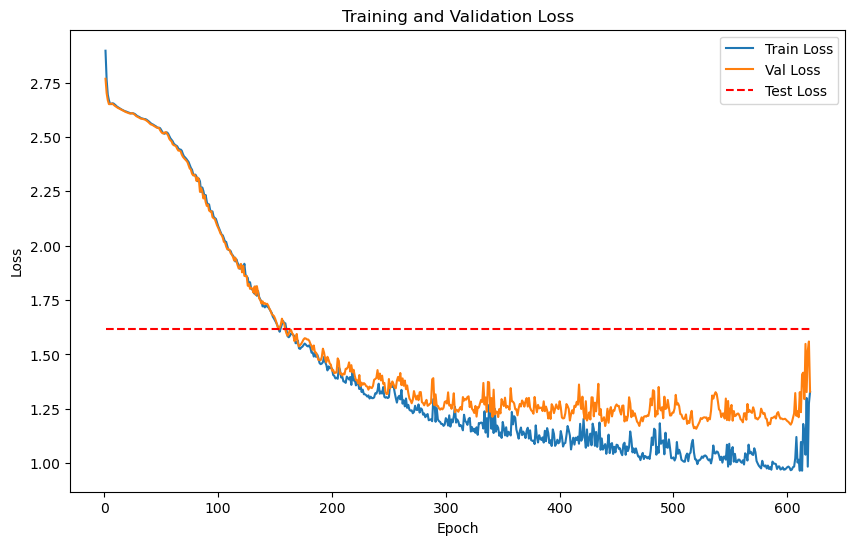

In [31]:
cae_mlp_model.eval()

cae_mlp_test_running_loss = 0.0
cae_mlp_test_correct = 0
cae_mlp_all_predictions = []
cae_mlp_all_true_labels = []

with torch.no_grad():
    for cae_mlp_test_embeddings_batch, cae_mlp_test_labels_batch in cae_mlp_test_loader:
        cae_mlp_test_embeddings_batch = cae_mlp_test_embeddings_batch.to(device)
        cae_mlp_test_labels_batch = cae_mlp_test_labels_batch.to(device)

        cae_mlp_test_outputs = cae_mlp_model(cae_mlp_test_embeddings_batch)
        
        cae_mlp_test_loss_batch = cae_mlp_criterion(cae_mlp_test_outputs, cae_mlp_test_labels_batch)
        cae_mlp_test_running_loss += cae_mlp_test_loss_batch.item() * cae_mlp_test_embeddings_batch.size(0)

        _, cae_mlp_test_predicted = torch.max(cae_mlp_test_outputs, dim=1)
        cae_mlp_test_correct += (cae_mlp_test_predicted == cae_mlp_test_labels_batch).sum().item()

        #saving predictions for conf matrix
        cae_mlp_all_predictions.extend(cae_mlp_test_predicted.cpu().numpy())
        cae_mlp_all_true_labels.extend(cae_mlp_test_labels_batch.cpu().numpy())

np.save(os.path.join(predictions_dir, 'cae_mlp_predictions.npy'), np.array(cae_mlp_all_predictions))
np.save(os.path.join(predictions_dir, 'cae_mlp_true_labels.npy'), np.array(cae_mlp_all_true_labels))
print(f"Saved CAE+MLP predictions and true labels to {predictions_dir}")

cae_mlp_epoch_test_loss = cae_mlp_test_running_loss / len(cae_mlp_test_loader.dataset)
cae_mlp_test_accuracy = cae_mlp_test_correct / len(cae_mlp_test_loader.dataset)

cae_mlp_test_accuracy_pct = cae_mlp_test_accuracy * 100.0

print(f"Test Loss: {cae_mlp_epoch_test_loss:.4f} | Test Accuracy: {cae_mlp_test_accuracy_pct:.2f}%")

cae_mlp_num_epochs_run = len(cae_mlp_train_losses)

plt.figure(figsize=(10,6))

plt.plot(range(1, cae_mlp_num_epochs_run + 1),
         cae_mlp_train_losses,
         label='Train Loss')
plt.plot(range(1, cae_mlp_num_epochs_run + 1),
         cae_mlp_val_losses,
         label='Val Loss')

plt.plot(range(1, cae_mlp_num_epochs_run + 1),
         [cae_mlp_epoch_test_loss]*cae_mlp_num_epochs_run,
         'r--',
         label='Test Loss')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

## Typical SCL with Cosine Similarity (Supervised Contrastive Loss)

In [32]:
tscl_encoded_train_dir = os.path.join(encoded_dir, 'train')
tscl_encoded_val_dir = os.path.join(encoded_dir, 'val')
tscl_encoded_test_dir = os.path.join(encoded_dir, 'test')

tscl_train_embeddings, tscl_train_labels = load_encoded_data(tscl_encoded_train_dir)
tscl_val_embeddings, tscl_val_labels = load_encoded_data(tscl_encoded_val_dir)
tscl_test_embeddings, tscl_test_labels = load_encoded_data(tscl_encoded_test_dir)

#shape verification
print(f"\n\nTrain embeddings shape: {tscl_train_embeddings.shape}, \nTrain labels shape: {tscl_train_labels.shape}")
print(f"\n\nVal embeddings shape: {tscl_val_embeddings.shape}, \nVal labels shape: {tscl_val_labels.shape}")
print(f"\n\nTest embeddings shape: {tscl_test_embeddings.shape}, \nTest labels shape: {tscl_test_labels.shape}")

LOG: Loading encoded data (representations) from encoded_representations\train...
LOG: Loaded 70 samples with 64 features each
LOG: Labels shape: (70,)
LOG: Loading encoded data (representations) from encoded_representations\val...
LOG: Loaded 70 samples with 64 features each
LOG: Labels shape: (70,)
LOG: Loading encoded data (representations) from encoded_representations\test...
LOG: Loaded 3108 samples with 64 features each
LOG: Labels shape: (3108,)


Train embeddings shape: (70, 64), 
Train labels shape: (70,)


Val embeddings shape: (70, 64), 
Val labels shape: (70,)


Test embeddings shape: (3108, 64), 
Test labels shape: (3108,)


In [33]:
#flattening embeddings to (num_samples, 64)
tscl_train_embeddings = tscl_train_embeddings.reshape(tscl_train_embeddings.shape[0], -1)
tscl_val_embeddings = tscl_val_embeddings.reshape(tscl_val_embeddings.shape[0], -1)
tscl_test_embeddings = tscl_test_embeddings.reshape(tscl_test_embeddings.shape[0], -1)

#compute mean and std from training set
tscl_train_mean = np.mean(tscl_train_embeddings, axis=0)
tscl_train_std = np.std(tscl_train_embeddings, axis=0)

#normalize all datasets from above training mean and std
tscl_train_embeddings = (tscl_train_embeddings - tscl_train_mean) / tscl_train_std
tscl_val_embeddings = (tscl_val_embeddings - tscl_train_mean) / tscl_train_std
tscl_test_embeddings = (tscl_test_embeddings - tscl_train_mean) / tscl_train_std

tscl_train_dataset = TensorDataset(torch.tensor(tscl_train_embeddings, dtype=torch.float32), torch.tensor(tscl_train_labels, dtype=torch.long))
tscl_val_dataset = TensorDataset(torch.tensor(tscl_val_embeddings, dtype=torch.float32), torch.tensor(tscl_val_labels, dtype=torch.long))
tscl_test_dataset = TensorDataset(torch.tensor(tscl_test_embeddings, dtype=torch.float32), torch.tensor(tscl_test_labels, dtype=torch.long))

tscl_m = 20
tscl_num_classes = len(np.unique(tscl_train_labels))

# Calculate theoretical required batch size
tscl_required_batch_size = tscl_m * tscl_num_classes

# Ensure batch size doesn't exceed training set size
if tscl_required_batch_size > len(tscl_train_dataset):
    #case 1: Not enough samples - reduce m proportionally
    tscl_max_possible_m = len(tscl_train_dataset) // tscl_num_classes
    tscl_m = max(1, tscl_max_possible_m)  # Ensure m >= 1
    tscl_batch_size_train = tscl_m * tscl_num_classes
else:
    #case 2: Use full batch size
    tscl_batch_size_train = tscl_required_batch_size

tscl_sampler = MPerClassSampler(labels = tscl_train_labels, m = tscl_m, batch_size = tscl_batch_size_train, length_before_new_iter=len(tscl_train_dataset))
tscl_train_loader = DataLoader(tscl_train_dataset, batch_size=tscl_batch_size_train, sampler=tscl_sampler)

#creating dataloaders for scl
tscl_dataloader_bs = 256
tscl_val_loader = DataLoader(tscl_val_dataset, batch_size=tscl_dataloader_bs, shuffle=False)
tscl_test_loader = DataLoader(tscl_test_dataset, batch_size=tscl_dataloader_bs, shuffle=False)

for tscl_X_batch, tscl_y_batch in tscl_train_loader:
    tscl_unique, tscl_counts = np.unique(y_batch.numpy(), return_counts=True)
    print("Class distribution in batch:", dict(zip(tscl_unique, tscl_counts)))
    print(f"Training batch size: {tscl_batch_size_train}")
    break

Class distribution in batch: {0: 5, 1: 5, 2: 5, 3: 5, 4: 5, 5: 5, 6: 5, 7: 5, 8: 5, 9: 5, 10: 5, 11: 5, 12: 5, 13: 5}
Training batch size: 70


In [34]:
class SupConLoss(nn.Module):
    def __init__(self, temperature = 0.07):
        super(SupConLoss, self).__init__()
        self.temperature = temperature

    def forward(self, features, labels):
        #normalize feat vectors
        features = F.normalize(features, p=2, dim = 1)

        #compute cosine simi matrix
        similarity_matrix = torch.matmul(features, features.T) / self.temperature

        #create a mask for +ve pairs - i.e. same class
        labels = labels.unsqueeze(1)
        mask = torch.eq(labels, labels.T).float().to(features.device)

        #loss computation
        exp_sim = torch.exp(similarity_matrix)
        log_prob = similarity_matrix - torch.log(exp_sim.sum(dim = 1, keepdim=True))

        #mask out diagonal - i.e. self similarity
        mask_self = torch.eye(mask.shape[0], dtype = torch.bool).to(features.device)
        mask = mask * (~mask_self)

        #handling edge cases when there is no +ve pair
        mask_pos_pairs = mask.sum(dim=1)
        mask_pos_pairs = torch.where(mask_pos_pairs < 1e-6, 1, mask_pos_pairs)

        loss = -(mask * log_prob).sum(dim=1) / mask_pos_pairs

        return loss.mean() 

In [35]:
class SupConNet(nn.Module):
    def __init__(self, feature_dim=128):
        super(SupConNet, self).__init__()

        self.projection_head = nn.Sequential(
            nn.Linear(64, 128), #expects input of shape (batch_size, 64)
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, feature_dim)
        )

    def forward(self, x):
        #flattening input tensor
        #x = x.view(x.size(0), -1)  #reshaping -> (batch_size, channels * height * width)
        projections = self.projection_head(x)
        return projections


LOG: Epoch [1/2000] - Training
    Batch [1/1], Train Loss: 8.0079
Epoch [1/2000], Avg Train Loss: 8.0079
Epoch [1/2000], Avg Val Loss: 3.4504
Validation loss improved from inf to 3.4504. Saving model...

LOG: Epoch [2/2000] - Training


    Batch [1/1], Train Loss: 8.1537
Epoch [2/2000], Avg Train Loss: 8.1537
Epoch [2/2000], Avg Val Loss: 3.4332
Validation loss improved from 3.4504 to 3.4332. Saving model...

LOG: Epoch [3/2000] - Training
    Batch [1/1], Train Loss: 7.8168
Epoch [3/2000], Avg Train Loss: 7.8168
Epoch [3/2000], Avg Val Loss: 3.4169
Validation loss improved from 3.4332 to 3.4169. Saving model...

LOG: Epoch [4/2000] - Training
    Batch [1/1], Train Loss: 7.4900
Epoch [4/2000], Avg Train Loss: 7.4900
Epoch [4/2000], Avg Val Loss: 3.4013
Validation loss improved from 3.4169 to 3.4013. Saving model...

LOG: Epoch [5/2000] - Training
    Batch [1/1], Train Loss: 7.6864
Epoch [5/2000], Avg Train Loss: 7.6864
Epoch [5/2000], Avg Val Loss: 3.3864
Validation loss improved from 3.4013 to 3.3864. Saving model...

LOG: Epoch [6/2000] - Training
    Batch [1/1], Train Loss: 8.0193
Epoch [6/2000], Avg Train Loss: 8.0193
Epoch [6/2000], Avg Val Loss: 3.3719
Validation loss improved from 3.3864 to 3.3719. Saving m

    Batch [1/1], Train Loss: 6.5350
Epoch [22/2000], Avg Train Loss: 6.5350
Epoch [22/2000], Avg Val Loss: 3.2056
Validation loss improved from 3.2130 to 3.2056. Saving model...

LOG: Epoch [23/2000] - Training
    Batch [1/1], Train Loss: 6.7192
Epoch [23/2000], Avg Train Loss: 6.7192
Epoch [23/2000], Avg Val Loss: 3.1986
Validation loss improved from 3.2056 to 3.1986. Saving model...

LOG: Epoch [24/2000] - Training
    Batch [1/1], Train Loss: 6.3704
Epoch [24/2000], Avg Train Loss: 6.3704
Epoch [24/2000], Avg Val Loss: 3.1919
Validation loss improved from 3.1986 to 3.1919. Saving model...

LOG: Epoch [25/2000] - Training
    Batch [1/1], Train Loss: 6.3766
Epoch [25/2000], Avg Train Loss: 6.3766
Epoch [25/2000], Avg Val Loss: 3.1854
Validation loss improved from 3.1919 to 3.1854. Saving model...

LOG: Epoch [26/2000] - Training
    Batch [1/1], Train Loss: 6.1669
Epoch [26/2000], Avg Train Loss: 6.1669
Epoch [26/2000], Avg Val Loss: 3.1793
Validation loss improved from 3.1854 to 3.

Epoch [28/2000], Avg Val Loss: 3.1679
Validation loss improved from 3.1735 to 3.1679. Saving model...

LOG: Epoch [29/2000] - Training
    Batch [1/1], Train Loss: 6.0410
Epoch [29/2000], Avg Train Loss: 6.0410
Epoch [29/2000], Avg Val Loss: 3.1625
Validation loss improved from 3.1679 to 3.1625. Saving model...

LOG: Epoch [30/2000] - Training
    Batch [1/1], Train Loss: 6.5047
Epoch [30/2000], Avg Train Loss: 6.5047
Epoch [30/2000], Avg Val Loss: 3.1573
Validation loss improved from 3.1625 to 3.1573. Saving model...

LOG: Epoch [31/2000] - Training
    Batch [1/1], Train Loss: 5.8844
Epoch [31/2000], Avg Train Loss: 5.8844
Epoch [31/2000], Avg Val Loss: 3.1523
Validation loss improved from 3.1573 to 3.1523. Saving model...

LOG: Epoch [32/2000] - Training
    Batch [1/1], Train Loss: 5.9135
Epoch [32/2000], Avg Train Loss: 5.9135
Epoch [32/2000], Avg Val Loss: 3.1476
Validation loss improved from 3.1523 to 3.1476. Saving model...

LOG: Epoch [33/2000] - Training
    Batch [1/1], Trai

    Batch [1/1], Train Loss: 5.0080
Epoch [48/2000], Avg Train Loss: 5.0080
Epoch [48/2000], Avg Val Loss: 3.0989
Validation loss improved from 3.1008 to 3.0989. Saving model...

LOG: Epoch [49/2000] - Training
    Batch [1/1], Train Loss: 4.9066
Epoch [49/2000], Avg Train Loss: 4.9066
Epoch [49/2000], Avg Val Loss: 3.0972
Validation loss improved from 3.0989 to 3.0972. Saving model...

LOG: Epoch [50/2000] - Training
    Batch [1/1], Train Loss: 5.2989
Epoch [50/2000], Avg Train Loss: 5.2989
Epoch [50/2000], Avg Val Loss: 3.0956
Validation loss improved from 3.0972 to 3.0956. Saving model...

LOG: Epoch [51/2000] - Training
    Batch [1/1], Train Loss: 5.3203
Epoch [51/2000], Avg Train Loss: 5.3203
Epoch [51/2000], Avg Val Loss: 3.0941
Validation loss improved from 3.0956 to 3.0941. Saving model...

LOG: Epoch [52/2000] - Training
    Batch [1/1], Train Loss: 5.2720
Epoch [52/2000], Avg Train Loss: 5.2720
Epoch [52/2000], Avg Val Loss: 3.0927
Validation loss improved from 3.0941 to 3.

    Batch [1/1], Train Loss: 4.6687
Epoch [70/2000], Avg Train Loss: 4.6687


Epoch [70/2000], Avg Val Loss: 3.0820
Validation loss improved from 3.0821 to 3.0820. Saving model...

LOG: Epoch [71/2000] - Training
    Batch [1/1], Train Loss: 4.6453
Epoch [71/2000], Avg Train Loss: 4.6453
Epoch [71/2000], Avg Val Loss: 3.0819
Validation loss improved from 3.0820 to 3.0819. Saving model...

LOG: Epoch [72/2000] - Training
    Batch [1/1], Train Loss: 4.5515
Epoch [72/2000], Avg Train Loss: 4.5515
Epoch [72/2000], Avg Val Loss: 3.0819
Validation loss improved from 3.0819 to 3.0819. Saving model...

LOG: Epoch [73/2000] - Training
    Batch [1/1], Train Loss: 4.6960
Epoch [73/2000], Avg Train Loss: 4.6960
Epoch [73/2000], Avg Val Loss: 3.0819
Validation loss did not improve. Patience: 1/100

LOG: Epoch [74/2000] - Training
    Batch [1/1], Train Loss: 4.7169
Epoch [74/2000], Avg Train Loss: 4.7169
Epoch [74/2000], Avg Val Loss: 3.0819
Validation loss did not improve. Patience: 2/100

LOG: Epoch [75/2000] - Training
    Batch [1/1], Train Loss: 4.6196
Epoch [75/2000]

Epoch [97/2000], Avg Val Loss: 3.0858
Validation loss did not improve. Patience: 25/100

LOG: Epoch [98/2000] - Training
    Batch [1/1], Train Loss: 4.3187
Epoch [98/2000], Avg Train Loss: 4.3187
Epoch [98/2000], Avg Val Loss: 3.0861
Validation loss did not improve. Patience: 26/100

LOG: Epoch [99/2000] - Training
    Batch [1/1], Train Loss: 4.1569
Epoch [99/2000], Avg Train Loss: 4.1569
Epoch [99/2000], Avg Val Loss: 3.0864
Validation loss did not improve. Patience: 27/100

LOG: Epoch [100/2000] - Training
    Batch [1/1], Train Loss: 4.1220
Epoch [100/2000], Avg Train Loss: 4.1220
Epoch [100/2000], Avg Val Loss: 3.0867
Validation loss did not improve. Patience: 28/100

LOG: Epoch [101/2000] - Training
    Batch [1/1], Train Loss: 4.1125
Epoch [101/2000], Avg Train Loss: 4.1125
Epoch [101/2000], Avg Val Loss: 3.0870
Validation loss did not improve. Patience: 29/100

LOG: Epoch [102/2000] - Training
    Batch [1/1], Train Loss: 4.2090
Epoch [102/2000], Avg Train Loss: 4.2090
Epoch [

Epoch [118/2000], Avg Val Loss: 3.0919


Validation loss did not improve. Patience: 46/100

LOG: Epoch [119/2000] - Training
    Batch [1/1], Train Loss: 4.1268
Epoch [119/2000], Avg Train Loss: 4.1268
Epoch [119/2000], Avg Val Loss: 3.0921
Validation loss did not improve. Patience: 47/100

LOG: Epoch [120/2000] - Training
    Batch [1/1], Train Loss: 4.2049
Epoch [120/2000], Avg Train Loss: 4.2049
Epoch [120/2000], Avg Val Loss: 3.0923
Validation loss did not improve. Patience: 48/100

LOG: Epoch [121/2000] - Training
    Batch [1/1], Train Loss: 4.0699
Epoch [121/2000], Avg Train Loss: 4.0699
Epoch [121/2000], Avg Val Loss: 3.0926
Validation loss did not improve. Patience: 49/100

LOG: Epoch [122/2000] - Training
    Batch [1/1], Train Loss: 3.9278
Epoch [122/2000], Avg Train Loss: 3.9278
Epoch [122/2000], Avg Val Loss: 3.0928
Validation loss did not improve. Patience: 50/100

LOG: Epoch [123/2000] - Training
    Batch [1/1], Train Loss: 4.0273
Epoch [123/2000], Avg Train Loss: 4.0273
Epoch [123/2000], Avg Val Loss: 3.0930

    Batch [1/1], Train Loss: 3.8461
Epoch [141/2000], Avg Train Loss: 3.8461
Epoch [141/2000], Avg Val Loss: 3.0930
Validation loss did not improve. Patience: 69/100

LOG: Epoch [142/2000] - Training
    Batch [1/1], Train Loss: 3.8095
Epoch [142/2000], Avg Train Loss: 3.8095
Epoch [142/2000], Avg Val Loss: 3.0929
Validation loss did not improve. Patience: 70/100

LOG: Epoch [143/2000] - Training
    Batch [1/1], Train Loss: 3.8424
Epoch [143/2000], Avg Train Loss: 3.8424
Epoch [143/2000], Avg Val Loss: 3.0928
Validation loss did not improve. Patience: 71/100

LOG: Epoch [144/2000] - Training
    Batch [1/1], Train Loss: 3.8303
Epoch [144/2000], Avg Train Loss: 3.8303
Epoch [144/2000], Avg Val Loss: 3.0927
Validation loss did not improve. Patience: 72/100

LOG: Epoch [145/2000] - Training
    Batch [1/1], Train Loss: 3.9300
Epoch [145/2000], Avg Train Loss: 3.9300
Epoch [145/2000], Avg Val Loss: 3.0926
Validation loss did not improve. Patience: 73/100

LOG: Epoch [146/2000] - Training


    Batch [1/1], Train Loss: 3.7271
Epoch [164/2000], Avg Train Loss: 3.7271
Epoch [164/2000], Avg Val Loss: 3.0892
Validation loss did not improve. Patience: 92/100

LOG: Epoch [165/2000] - Training
    Batch [1/1], Train Loss: 3.7932
Epoch [165/2000], Avg Train Loss: 3.7932
Epoch [165/2000], Avg Val Loss: 3.0889
Validation loss did not improve. Patience: 93/100

LOG: Epoch [166/2000] - Training
    Batch [1/1], Train Loss: 3.7754
Epoch [166/2000], Avg Train Loss: 3.7754
Epoch [166/2000], Avg Val Loss: 3.0886
Validation loss did not improve. Patience: 94/100

LOG: Epoch [167/2000] - Training
    Batch [1/1], Train Loss: 3.7738
Epoch [167/2000], Avg Train Loss: 3.7738
Epoch [167/2000], Avg Val Loss: 3.0884
Validation loss did not improve. Patience: 95/100

LOG: Epoch [168/2000] - Training
    Batch [1/1], Train Loss: 3.6975
Epoch [168/2000], Avg Train Loss: 3.6975
Epoch [168/2000], Avg Val Loss: 3.0881
Validation loss did not improve. Patience: 96/100

LOG: Epoch [169/2000] - Training


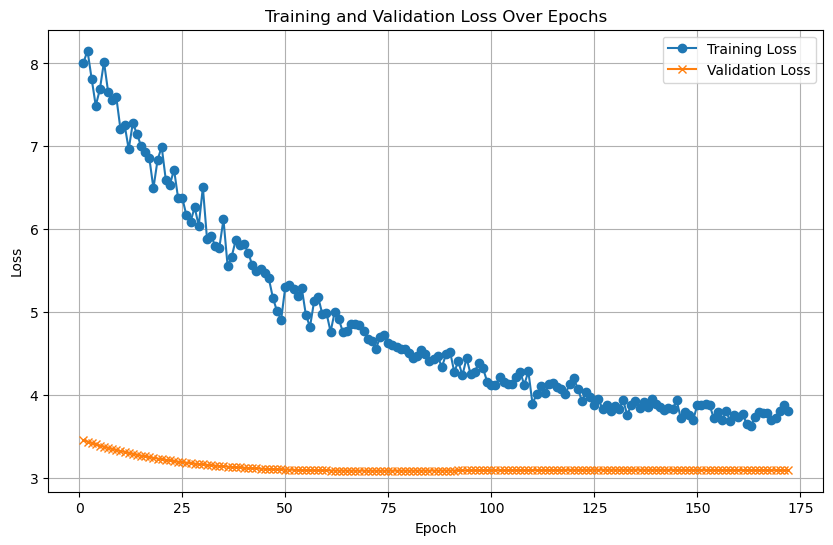

In [36]:
tscl_model = SupConNet().to(device)
tscl_criterion = SupConLoss(temperature=0.07).to(device)
tscl_optimizer = optim.Adam(tscl_model.parameters(), lr=1e-4, weight_decay=1e-5)  # Increased learning rate

tscl_patience = 100
tscl_best_val_loss = float('inf')
tscl_epochs_without_improvement = 0

tscl_num_epochs = 2000
tscl_train_losses = []
tscl_val_losses = []

# TRAINING
for tscl_epoch in range(tscl_num_epochs):
    print(f"\nLOG: Epoch [{tscl_epoch + 1}/{tscl_num_epochs}] - Training")
    tscl_model.train()
    tscl_total_loss = 0

    for batch_idx, (vectors, labels) in enumerate(tscl_train_loader):
        vectors = vectors.to(device).float()  # moving input tensors to GPU
        labels = labels.to(device)  # moving labels to GPU

        # forward pass to get projections
        projections = tscl_model(vectors)

        # calc contrastive loss
        loss = tscl_criterion(projections, labels)

        # backprop and optimization
        tscl_optimizer.zero_grad()
        loss.backward()
        tscl_optimizer.step()

        tscl_total_loss += loss.item()

        if (batch_idx + 1) % 1 == 0:
            print(f"    Batch [{batch_idx + 1}/{len(tscl_train_loader)}], "
                  f"Train Loss: {loss.item():.4f}")

    # calc avg training loss for the epoch
    tscl_avg_train_loss = tscl_total_loss / len(tscl_train_loader)
    tscl_train_losses.append(tscl_avg_train_loss)
    print(f"Epoch [{tscl_epoch + 1}/{tscl_num_epochs}], "
          f"Avg Train Loss: {tscl_avg_train_loss:.4f}")

    # VALIDATION
    tscl_model.eval()
    total_val_loss = 0.0

    with torch.no_grad():
        for batch_idx, (vectors, labels) in enumerate(tscl_val_loader):
            vectors = vectors.to(device).float()
            labels = labels.to(device)

            projections = tscl_model(vectors)

            loss = tscl_criterion(projections, labels)
            total_val_loss += loss.item()

            if (batch_idx + 1) % 10 == 0:
                print(f"    Batch [{batch_idx + 1}/{len(tscl_val_loader)}], "
                      f"Val Loss: {loss.item():.4f}")

    tscl_avg_val_loss = total_val_loss / len(tscl_val_loader)
    tscl_val_losses.append(tscl_avg_val_loss)
    print(f"Epoch [{tscl_epoch + 1}/{tscl_num_epochs}], "
          f"Avg Val Loss: {tscl_avg_val_loss:.4f}")

    # early stopping logic
    if tscl_avg_val_loss < tscl_best_val_loss:
        print(f"Validation loss improved from {tscl_best_val_loss:.4f} to {tscl_avg_val_loss:.4f}. Saving model...")
        tscl_best_val_loss = tscl_avg_val_loss
        tscl_epochs_without_improvement = 0
    else:
        tscl_epochs_without_improvement += 1
        print(f"Validation loss did not improve. Patience: {tscl_epochs_without_improvement}/{tscl_patience}")

    # stopping training if validation loss hasn't improved for patience amount of epochs
    if tscl_epochs_without_improvement >= tscl_patience:
        print(f"Early stopping triggered at epoch {tscl_epoch + 1}. No improvement for {tscl_patience} epochs.")
        break

plt.figure(figsize=(10, 6))
plt.plot(range(1, len(tscl_train_losses) + 1), tscl_train_losses, label="Training Loss", marker='o')
plt.plot(range(1, len(tscl_val_losses) + 1), tscl_val_losses, label="Validation Loss", marker='x')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.grid()
plt.show()

Test Batch [10/13], Loss: 5.3283

Test Loss: 4.9932


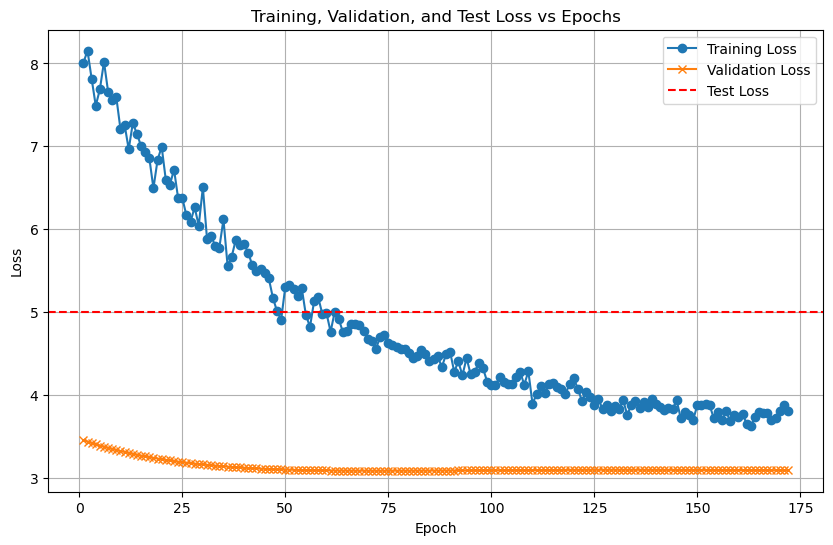

In [37]:
# Test Evaluation
tscl_model.eval()
total_test_loss = 0.0

with torch.no_grad():
    for batch_idx, (vectors, labels) in enumerate(tscl_test_loader):
        vectors = vectors.to(device).float()
        labels = labels.to(device)
        projections = tscl_model(vectors)
        loss = criterion(projections, labels)
        total_test_loss += loss.item()
        if (batch_idx + 1) % 10 == 0:
            print(f"Test Batch [{batch_idx + 1}/{len(tscl_test_loader)}], Loss: {loss.item():.4f}")

avg_test_loss = total_test_loss / len(tscl_test_loader)
print(f"\nTest Loss: {avg_test_loss:.4f}")


plt.figure(figsize=(10, 6))
epochs = range(1, len(tscl_train_losses) + 1)
plt.plot(epochs, tscl_train_losses, label="Training Loss", marker='o')
plt.plot(epochs, tscl_val_losses, label="Validation Loss", marker='x')
# test loss = horizontal dashed line
plt.axhline(y=avg_test_loss, color='r', linestyle='--', label="Test Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training, Validation, and Test Loss vs Epochs")
plt.legend()
plt.grid(True)
plt.show()

### Saving representations learnt by Typical SCL Model

In [38]:
# dir to save the SCL representations
tscl_rep_dir = "tscl_representations"
os.makedirs(tscl_rep_dir, exist_ok=True)

tscl_loaders = {
    'train': tscl_train_loader,
    'val': tscl_val_loader,
    'test': tscl_test_loader
}

tscl_model.eval()

with torch.no_grad():
    for tscl_split_name, tscl_loader in tscl_loaders.items():
        print(f"\nExtracting SCL representations for the {tscl_split_name} dataset...")
        # creating subfolder for the split
        tscl_split_dir = os.path.join(tscl_rep_dir, tscl_split_name)
        os.makedirs(tscl_split_dir, exist_ok=True)
        
        # processing the data batch-wise
        for tscl_batch_idx, (tscl_vectors, tscl_labels) in enumerate(tscl_loader):
            tscl_vectors = tscl_vectors.to(device).float()
            # computing projections using the trained SCL model
            tscl_projections = tscl_model(tscl_vectors)
            
            # converting projections and labels to np arrays
            tscl_projections_np = tscl_projections.cpu().numpy()
            tscl_labels_np = tscl_labels.cpu().numpy()
            
            # saving the batch projections and labels
            np.save(os.path.join(tscl_split_dir, f"scl_encoded_batch_{tscl_batch_idx}.npy"), tscl_projections_np)
            np.save(os.path.join(tscl_split_dir, f"scl_labels_batch_{tscl_batch_idx}.npy"), tscl_labels_np)
            
            if (tscl_batch_idx + 1) % 10 == 0:
                print(f"  Processed batch {tscl_batch_idx + 1}/{len(tscl_loader)} for {tscl_split_name} dataset.")

        print(f"Completed extraction for the {tscl_split_name} dataset. Representations saved in '{tscl_split_dir}'.")

print("SCL representations extraction complete.")


Extracting SCL representations for the train dataset...
Completed extraction for the train dataset. Representations saved in 'tscl_representations\train'.

Extracting SCL representations for the val dataset...
Completed extraction for the val dataset. Representations saved in 'tscl_representations\val'.

Extracting SCL representations for the test dataset...


  Processed batch 10/13 for test dataset.
Completed extraction for the test dataset. Representations saved in 'tscl_representations\test'.
SCL representations extraction complete.


### Classifying representations learnt by SCL Model with LRM

In [39]:
def load_tscl_reps_and_labels(split_dir):
    #gather all the scl_encoded_batch npy files in sorted order
    tscl_rep_files = sorted(glob.glob(os.path.join(split_dir, "scl_encoded_batch_*.npy")))

    tscl_all_reps = []
    tscl_all_labels = []

    for tscl_rep_file in tscl_rep_files:
        #deriving label filenames
        tscl_label_file = tscl_rep_file.replace("scl_encoded_batch_", "scl_labels_batch_")

        tscl_reps = np.load(tscl_rep_file)
        tscl_labels = np.load(tscl_label_file)

        tscl_all_reps.append(tscl_reps)
        tscl_all_labels.append(tscl_labels)

    #concat along first dim
    tscl_all_reps = np.concatenate(tscl_all_reps, axis = 0)
    tscl_all_labels = np.concatenate(tscl_all_labels, axis = 0)

    return tscl_all_reps, tscl_all_labels

In [40]:
tscl_lrm_train_dir = os.path.join("tscl_representations", "train")
tscl_lrm_val_dir   = os.path.join("tscl_representations", "val")
tscl_lrm_test_dir  = os.path.join("tscl_representations", "test")

tscl_lrm_train_reps, tscl_lrm_train_labels = load_tscl_reps_and_labels(tscl_lrm_train_dir)
tscl_lrm_val_reps, tscl_lrm_val_labels = load_tscl_reps_and_labels(tscl_lrm_val_dir)
tscl_lrm_test_reps, tscl_lrm_test_labels = load_tscl_reps_and_labels(tscl_lrm_test_dir)

print("Train reps shape:", tscl_lrm_train_reps.shape)
print("Train labels shape:", tscl_lrm_train_labels.shape)

print("Val reps shape:", tscl_lrm_val_reps.shape)
print("Val labels shape:", tscl_lrm_val_labels.shape)

print("Test reps shape:", tscl_lrm_test_reps.shape)
print("Test labels shape:", tscl_lrm_test_labels.shape)

Train reps shape: (70, 128)
Train labels shape: (70,)
Val reps shape: (70, 128)
Val labels shape: (70,)
Test reps shape: (3108, 128)
Test labels shape: (3108,)


In [41]:
# training LRM on the tscl representations
print("\nLOG: Training Logistic Regression model on SCL SDL representations...")
tscl_logistic_clf = LogisticRegression(max_iter=5000, random_state=42, class_weight='balanced')
tscl_logistic_clf.fit(tscl_lrm_train_reps, tscl_lrm_train_labels)
print("LOG: Logistic Regression training complete.")

# eval on val set
print("\nLOG: Evaluating on the validation set...")
tscl_lrm_val_predictions = tscl_logistic_clf.predict(tscl_lrm_val_reps)
tscl_lrm_val_accuracy = accuracy_score(tscl_lrm_val_labels, tscl_lrm_val_predictions)
print(f"Validation Accuracy: {tscl_lrm_val_accuracy * 100:.2f}%")
print("\nValidation Classification Report:\n", classification_report(tscl_lrm_val_labels, tscl_lrm_val_predictions))

# eval on test
print("\nLOG: Evaluating on the test set...")
tscl_lrm_test_predictions = tscl_logistic_clf.predict(tscl_lrm_test_reps)
tscl_lrm_test_accuracy = accuracy_score(tscl_lrm_test_labels, tscl_lrm_test_predictions)
print(f"Test Accuracy: {tscl_lrm_test_accuracy * 100:.2f}%")
print("\nTest Classification Report:\n", classification_report(tscl_lrm_test_labels, tscl_lrm_test_predictions))

np.save(os.path.join(predictions_dir, 'tscl_lrm_predictions.npy'), tscl_lrm_test_predictions)
np.save(os.path.join(predictions_dir, 'tscl_lrm_true_labels.npy'), tscl_lrm_test_labels)
print(f"Saved CAE+LRM predictions and true labels to {predictions_dir}")


LOG: Training Logistic Regression model on SCL SDL representations...
LOG: Logistic Regression training complete.

LOG: Evaluating on the validation set...
Validation Accuracy: 80.00%

Validation Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         5
           1       1.00      1.00      1.00         5
           2       0.80      0.80      0.80         5
           3       0.44      0.80      0.57         5
           4       1.00      0.60      0.75         5
           5       1.00      0.80      0.89         5
           6       0.83      1.00      0.91         5
           7       0.00      0.00      0.00         5
           8       0.67      0.40      0.50         5
           9       0.83      1.00      0.91         5
          10       1.00      1.00      1.00         5
          11       0.50      1.00      0.67         5
          12       1.00      0.80      0.89         5
          13       1.0

C:\Users\vella\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\vella\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\vella\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


### Classifying the representations learnt by Typical SCL Model with MLP Classifier

In [42]:
class MLPClassifier(nn.Module):
    def __init__(self, input_dim, num_classes):
        super(MLPClassifier, self).__init__()
        self.fc1 = nn.Linear(input_dim, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, 32)
        self.fc4 = nn.Linear(32, num_classes)
        
        self._init_weights()
    
    def _init_weights(self):
        for m in self.modules(): 
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                nn.init.constant_(m.bias, 0)
    
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        return self.fc4(x)

In [43]:
tscl_mlp_train_dir = os.path.join("tscl_representations", "train")
tscl_mlp_val_dir   = os.path.join("tscl_representations", "val")
tscl_mlp_test_dir  = os.path.join("tscl_representations", "test")

tscl_mlp_train_reps, tscl_mlp_train_labels = load_tscl_reps_and_labels(tscl_mlp_train_dir)
tscl_mlp_val_reps, tscl_mlp_val_labels = load_tscl_reps_and_labels(tscl_mlp_val_dir)
tscl_mlp_test_reps, tscl_mlp_test_labels = load_tscl_reps_and_labels(tscl_mlp_test_dir)

print("Train reps shape:",tscl_mlp_train_reps.shape)
print("Train labels shape:", tscl_mlp_train_labels.shape)

print("Val reps shape:", tscl_mlp_val_reps.shape)
print("Val labels shape:", tscl_mlp_val_labels.shape)

print("Test reps shape:", tscl_mlp_test_reps.shape)
print("Test labels shape:", tscl_mlp_test_labels.shape)

Train reps shape: (70, 128)
Train labels shape: (70,)
Val reps shape: (70, 128)
Val labels shape: (70,)
Test reps shape: (3108, 128)
Test labels shape: (3108,)


In [44]:
#converting arrays to torch tensors
tscl_mlp_train_embeddings_torch = torch.tensor(tscl_mlp_train_reps, dtype=torch.float32)
tscl_mlp_train_labels_torch = torch.tensor(tscl_mlp_train_labels, dtype=torch.long)

tscl_mlp_val_embeddings_torch = torch.tensor(tscl_mlp_val_reps, dtype=torch.float32)
tscl_mlp_val_labels_torch = torch.tensor(tscl_mlp_val_labels, dtype=torch.long)

tscl_mlp_test_embeddings_torch = torch.tensor(tscl_mlp_test_reps, dtype=torch.float32)
tscl_mlp_test_labels_torch = torch.tensor(tscl_mlp_test_labels, dtype=torch.long)

#building datasets for mlp
tscl_mlp_train_dataset = TensorDataset(tscl_mlp_train_embeddings_torch, tscl_mlp_train_labels_torch)
tscl_mlp_val_dataset = TensorDataset(tscl_mlp_val_embeddings_torch, tscl_mlp_val_labels_torch)
tscl_mlp_test_dataset = TensorDataset(tscl_mlp_test_embeddings_torch, tscl_mlp_test_labels_torch)

tscl_mlp_batch_size = 64
tscl_mlp_train_loader = DataLoader(tscl_mlp_train_dataset, batch_size=tscl_mlp_batch_size, shuffle=True)
tscl_mlp_val_loader = DataLoader(tscl_mlp_val_dataset, batch_size=tscl_mlp_batch_size, shuffle=False)
tscl_mlp_test_loader = DataLoader(tscl_mlp_test_dataset, batch_size=tscl_mlp_batch_size, shuffle=False)


[Epoch 1/1000] Train Loss: 2.6307  |  Val Loss: 2.6223
Validation loss improved from inf to 2.6223.
[Epoch 2/1000] Train Loss: 2.6224  |  Val Loss: 2.6154
Validation loss improved from 2.6223 to 2.6154.
[Epoch 3/1000] Train Loss: 2.6153  |  Val Loss: 2.6085
Validation loss improved from 2.6154 to 2.6085.
[Epoch 4/1000] Train Loss: 2.6089  |  Val Loss: 2.6020
Validation loss improved from 2.6085 to 2.6020.
[Epoch 5/1000] Train Loss: 2.6022  |  Val Loss: 2.5961
Validation loss improved from 2.6020 to 2.5961.
[Epoch 6/1000] Train Loss: 2.5969  |  Val Loss: 2.5906
Validation loss improved from 2.5961 to 2.5906.
[Epoch 7/1000] Train Loss: 2.5910  |  Val Loss: 2.5856
Validation loss improved from 2.5906 to 2.5856.
[Epoch 8/1000] Train Loss: 2.5862  |  Val Loss: 2.5808
Validation loss improved from 2.5856 to 2.5808.
[Epoch 9/1000] Train Loss: 2.5813  |  Val Loss: 2.5764
Validation loss improved from 2.5808 to 2.5764.
[Epoch 10/1000] Train Loss: 2.5769  |  Val Loss: 2.5720
Validation loss impr

[Epoch 21/1000] Train Loss: 2.5336  |  Val Loss: 2.5312
Validation loss improved from 2.5344 to 2.5312.
[Epoch 22/1000] Train Loss: 2.5301  |  Val Loss: 2.5281
Validation loss improved from 2.5312 to 2.5281.
[Epoch 23/1000] Train Loss: 2.5268  |  Val Loss: 2.5250
Validation loss improved from 2.5281 to 2.5250.
[Epoch 24/1000] Train Loss: 2.5236  |  Val Loss: 2.5222
Validation loss improved from 2.5250 to 2.5222.
[Epoch 25/1000] Train Loss: 2.5208  |  Val Loss: 2.5193
Validation loss improved from 2.5222 to 2.5193.
[Epoch 26/1000] Train Loss: 2.5176  |  Val Loss: 2.5162
Validation loss improved from 2.5193 to 2.5162.
[Epoch 27/1000] Train Loss: 2.5142  |  Val Loss: 2.5132
Validation loss improved from 2.5162 to 2.5132.
[Epoch 28/1000] Train Loss: 2.5110  |  Val Loss: 2.5100
Validation loss improved from 2.5132 to 2.5100.


[Epoch 29/1000] Train Loss: 2.5078  |  Val Loss: 2.5070
Validation loss improved from 2.5100 to 2.5070.
[Epoch 30/1000] Train Loss: 2.5047  |  Val Loss: 2.5043
Validation loss improved from 2.5070 to 2.5043.
[Epoch 31/1000] Train Loss: 2.5017  |  Val Loss: 2.5017
Validation loss improved from 2.5043 to 2.5017.
[Epoch 32/1000] Train Loss: 2.4988  |  Val Loss: 2.4990
Validation loss improved from 2.5017 to 2.4990.
[Epoch 33/1000] Train Loss: 2.4961  |  Val Loss: 2.4963
Validation loss improved from 2.4990 to 2.4963.
[Epoch 34/1000] Train Loss: 2.4933  |  Val Loss: 2.4937
Validation loss improved from 2.4963 to 2.4937.
[Epoch 35/1000] Train Loss: 2.4902  |  Val Loss: 2.4911
Validation loss improved from 2.4937 to 2.4911.
[Epoch 36/1000] Train Loss: 2.4874  |  Val Loss: 2.4884
Validation loss improved from 2.4911 to 2.4884.
[Epoch 37/1000] Train Loss: 2.4844  |  Val Loss: 2.4857
Validation loss improved from 2.4884 to 2.4857.
[Epoch 38/1000] Train Loss: 2.4816  |  Val Loss: 2.4833
Validati

[Epoch 42/1000] Train Loss: 2.4705  |  Val Loss: 2.4725
Validation loss improved from 2.4755 to 2.4725.
[Epoch 43/1000] Train Loss: 2.4676  |  Val Loss: 2.4695
Validation loss improved from 2.4725 to 2.4695.
[Epoch 44/1000] Train Loss: 2.4644  |  Val Loss: 2.4664
Validation loss improved from 2.4695 to 2.4664.
[Epoch 45/1000] Train Loss: 2.4612  |  Val Loss: 2.4631
Validation loss improved from 2.4664 to 2.4631.
[Epoch 46/1000] Train Loss: 2.4580  |  Val Loss: 2.4599
Validation loss improved from 2.4631 to 2.4599.
[Epoch 47/1000] Train Loss: 2.4547  |  Val Loss: 2.4568
Validation loss improved from 2.4599 to 2.4568.
[Epoch 48/1000] Train Loss: 2.4514  |  Val Loss: 2.4538
Validation loss improved from 2.4568 to 2.4538.
[Epoch 49/1000] Train Loss: 2.4484  |  Val Loss: 2.4509
Validation loss improved from 2.4538 to 2.4509.
[Epoch 50/1000] Train Loss: 2.4453  |  Val Loss: 2.4480
Validation loss improved from 2.4509 to 2.4480.
[Epoch 51/1000] Train Loss: 2.4423  |  Val Loss: 2.4454
Validati

[Epoch 64/1000] Train Loss: 2.4036  |  Val Loss: 2.4073
Validation loss improved from 2.4100 to 2.4073.
[Epoch 65/1000] Train Loss: 2.4008  |  Val Loss: 2.4045
Validation loss improved from 2.4073 to 2.4045.
[Epoch 66/1000] Train Loss: 2.3978  |  Val Loss: 2.4014
Validation loss improved from 2.4045 to 2.4014.
[Epoch 67/1000] Train Loss: 2.3946  |  Val Loss: 2.3982
Validation loss improved from 2.4014 to 2.3982.
[Epoch 68/1000] Train Loss: 2.3913  |  Val Loss: 2.3950
Validation loss improved from 2.3982 to 2.3950.
[Epoch 69/1000] Train Loss: 2.3876  |  Val Loss: 2.3914
Validation loss improved from 2.3950 to 2.3914.
[Epoch 70/1000] Train Loss: 2.3842  |  Val Loss: 2.3876
Validation loss improved from 2.3914 to 2.3876.
[Epoch 71/1000] Train Loss: 2.3803  |  Val Loss: 2.3839
Validation loss improved from 2.3876 to 2.3839.
[Epoch 72/1000] Train Loss: 2.3766  |  Val Loss: 2.3801
Validation loss improved from 2.3839 to 2.3801.


[Epoch 73/1000] Train Loss: 2.3727  |  Val Loss: 2.3760
Validation loss improved from 2.3801 to 2.3760.
[Epoch 74/1000] Train Loss: 2.3689  |  Val Loss: 2.3720
Validation loss improved from 2.3760 to 2.3720.
[Epoch 75/1000] Train Loss: 2.3650  |  Val Loss: 2.3680
Validation loss improved from 2.3720 to 2.3680.
[Epoch 76/1000] Train Loss: 2.3612  |  Val Loss: 2.3643
Validation loss improved from 2.3680 to 2.3643.
[Epoch 77/1000] Train Loss: 2.3573  |  Val Loss: 2.3607
Validation loss improved from 2.3643 to 2.3607.
[Epoch 78/1000] Train Loss: 2.3537  |  Val Loss: 2.3572
Validation loss improved from 2.3607 to 2.3572.
[Epoch 79/1000] Train Loss: 2.3499  |  Val Loss: 2.3536
Validation loss improved from 2.3572 to 2.3536.
[Epoch 80/1000] Train Loss: 2.3464  |  Val Loss: 2.3501
Validation loss improved from 2.3536 to 2.3501.
[Epoch 81/1000] Train Loss: 2.3425  |  Val Loss: 2.3466
Validation loss improved from 2.3501 to 2.3466.
[Epoch 82/1000] Train Loss: 2.3390  |  Val Loss: 2.3432
Validati

[Epoch 83/1000] Train Loss: 2.3352  |  Val Loss: 2.3397
Validation loss improved from 2.3432 to 2.3397.
[Epoch 84/1000] Train Loss: 2.3316  |  Val Loss: 2.3362
Validation loss improved from 2.3397 to 2.3362.
[Epoch 85/1000] Train Loss: 2.3278  |  Val Loss: 2.3327
Validation loss improved from 2.3362 to 2.3327.
[Epoch 86/1000] Train Loss: 2.3242  |  Val Loss: 2.3292
Validation loss improved from 2.3327 to 2.3292.
[Epoch 87/1000] Train Loss: 2.3207  |  Val Loss: 2.3257
Validation loss improved from 2.3292 to 2.3257.
[Epoch 88/1000] Train Loss: 2.3169  |  Val Loss: 2.3222
Validation loss improved from 2.3257 to 2.3222.
[Epoch 89/1000] Train Loss: 2.3132  |  Val Loss: 2.3185
Validation loss improved from 2.3222 to 2.3185.
[Epoch 90/1000] Train Loss: 2.3096  |  Val Loss: 2.3148
Validation loss improved from 2.3185 to 2.3148.
[Epoch 91/1000] Train Loss: 2.3059  |  Val Loss: 2.3115
Validation loss improved from 2.3148 to 2.3115.
[Epoch 92/1000] Train Loss: 2.3020  |  Val Loss: 2.3083
Validati

[Epoch 103/1000] Train Loss: 2.2627  |  Val Loss: 2.2700
Validation loss improved from 2.2739 to 2.2700.
[Epoch 104/1000] Train Loss: 2.2586  |  Val Loss: 2.2659
Validation loss improved from 2.2700 to 2.2659.
[Epoch 105/1000] Train Loss: 2.2547  |  Val Loss: 2.2619
Validation loss improved from 2.2659 to 2.2619.
[Epoch 106/1000] Train Loss: 2.2509  |  Val Loss: 2.2578
Validation loss improved from 2.2619 to 2.2578.
[Epoch 107/1000] Train Loss: 2.2470  |  Val Loss: 2.2539
Validation loss improved from 2.2578 to 2.2539.
[Epoch 108/1000] Train Loss: 2.2431  |  Val Loss: 2.2501
Validation loss improved from 2.2539 to 2.2501.
[Epoch 109/1000] Train Loss: 2.2393  |  Val Loss: 2.2462
Validation loss improved from 2.2501 to 2.2462.
[Epoch 110/1000] Train Loss: 2.2356  |  Val Loss: 2.2423
Validation loss improved from 2.2462 to 2.2423.
[Epoch 111/1000] Train Loss: 2.2315  |  Val Loss: 2.2383
Validation loss improved from 2.2423 to 2.2383.


[Epoch 112/1000] Train Loss: 2.2275  |  Val Loss: 2.2346
Validation loss improved from 2.2383 to 2.2346.
[Epoch 113/1000] Train Loss: 2.2234  |  Val Loss: 2.2309
Validation loss improved from 2.2346 to 2.2309.
[Epoch 114/1000] Train Loss: 2.2195  |  Val Loss: 2.2273
Validation loss improved from 2.2309 to 2.2273.
[Epoch 115/1000] Train Loss: 2.2157  |  Val Loss: 2.2237
Validation loss improved from 2.2273 to 2.2237.
[Epoch 116/1000] Train Loss: 2.2119  |  Val Loss: 2.2202
Validation loss improved from 2.2237 to 2.2202.
[Epoch 117/1000] Train Loss: 2.2084  |  Val Loss: 2.2167
Validation loss improved from 2.2202 to 2.2167.
[Epoch 118/1000] Train Loss: 2.2049  |  Val Loss: 2.2134
Validation loss improved from 2.2167 to 2.2134.
[Epoch 119/1000] Train Loss: 2.2015  |  Val Loss: 2.2101
Validation loss improved from 2.2134 to 2.2101.
[Epoch 120/1000] Train Loss: 2.1981  |  Val Loss: 2.2068
Validation loss improved from 2.2101 to 2.2068.
[Epoch 121/1000] Train Loss: 2.1947  |  Val Loss: 2.203

[Epoch 127/1000] Train Loss: 2.1738  |  Val Loss: 2.1839
Validation loss improved from 2.1872 to 2.1839.
[Epoch 128/1000] Train Loss: 2.1701  |  Val Loss: 2.1804
Validation loss improved from 2.1839 to 2.1804.
[Epoch 129/1000] Train Loss: 2.1663  |  Val Loss: 2.1769
Validation loss improved from 2.1804 to 2.1769.
[Epoch 130/1000] Train Loss: 2.1625  |  Val Loss: 2.1733
Validation loss improved from 2.1769 to 2.1733.
[Epoch 131/1000] Train Loss: 2.1588  |  Val Loss: 2.1698
Validation loss improved from 2.1733 to 2.1698.
[Epoch 132/1000] Train Loss: 2.1551  |  Val Loss: 2.1663
Validation loss improved from 2.1698 to 2.1663.
[Epoch 133/1000] Train Loss: 2.1514  |  Val Loss: 2.1627
Validation loss improved from 2.1663 to 2.1627.
[Epoch 134/1000] Train Loss: 2.1477  |  Val Loss: 2.1589
Validation loss improved from 2.1627 to 2.1589.
[Epoch 135/1000] Train Loss: 2.1436  |  Val Loss: 2.1548
Validation loss improved from 2.1589 to 2.1548.
[Epoch 136/1000] Train Loss: 2.1396  |  Val Loss: 2.150

[Epoch 146/1000] Train Loss: 2.0991  |  Val Loss: 2.1112
Validation loss improved from 2.1151 to 2.1112.
[Epoch 147/1000] Train Loss: 2.0954  |  Val Loss: 2.1075
Validation loss improved from 2.1112 to 2.1075.
[Epoch 148/1000] Train Loss: 2.0916  |  Val Loss: 2.1038
Validation loss improved from 2.1075 to 2.1038.
[Epoch 149/1000] Train Loss: 2.0880  |  Val Loss: 2.1003
Validation loss improved from 2.1038 to 2.1003.
[Epoch 150/1000] Train Loss: 2.0843  |  Val Loss: 2.0968
Validation loss improved from 2.1003 to 2.0968.
[Epoch 151/1000] Train Loss: 2.0806  |  Val Loss: 2.0934
Validation loss improved from 2.0968 to 2.0934.
[Epoch 152/1000] Train Loss: 2.0771  |  Val Loss: 2.0899
Validation loss improved from 2.0934 to 2.0899.
[Epoch 153/1000] Train Loss: 2.0734  |  Val Loss: 2.0864
Validation loss improved from 2.0899 to 2.0864.


[Epoch 154/1000] Train Loss: 2.0697  |  Val Loss: 2.0828
Validation loss improved from 2.0864 to 2.0828.
[Epoch 155/1000] Train Loss: 2.0660  |  Val Loss: 2.0792
Validation loss improved from 2.0828 to 2.0792.
[Epoch 156/1000] Train Loss: 2.0627  |  Val Loss: 2.0757
Validation loss improved from 2.0792 to 2.0757.
[Epoch 157/1000] Train Loss: 2.0590  |  Val Loss: 2.0723
Validation loss improved from 2.0757 to 2.0723.
[Epoch 158/1000] Train Loss: 2.0555  |  Val Loss: 2.0688
Validation loss improved from 2.0723 to 2.0688.
[Epoch 159/1000] Train Loss: 2.0520  |  Val Loss: 2.0650
Validation loss improved from 2.0688 to 2.0650.
[Epoch 160/1000] Train Loss: 2.0481  |  Val Loss: 2.0612
Validation loss improved from 2.0650 to 2.0612.
[Epoch 161/1000] Train Loss: 2.0441  |  Val Loss: 2.0572
Validation loss improved from 2.0612 to 2.0572.
[Epoch 162/1000] Train Loss: 2.0401  |  Val Loss: 2.0532
Validation loss improved from 2.0572 to 2.0532.
[Epoch 163/1000] Train Loss: 2.0361  |  Val Loss: 2.049

[Epoch 169/1000] Train Loss: 2.0124  |  Val Loss: 2.0250
Validation loss improved from 2.0290 to 2.0250.
[Epoch 170/1000] Train Loss: 2.0084  |  Val Loss: 2.0210
Validation loss improved from 2.0250 to 2.0210.
[Epoch 171/1000] Train Loss: 2.0044  |  Val Loss: 2.0173
Validation loss improved from 2.0210 to 2.0173.
[Epoch 172/1000] Train Loss: 2.0007  |  Val Loss: 2.0136
Validation loss improved from 2.0173 to 2.0136.
[Epoch 173/1000] Train Loss: 1.9970  |  Val Loss: 2.0100
Validation loss improved from 2.0136 to 2.0100.
[Epoch 174/1000] Train Loss: 1.9930  |  Val Loss: 2.0064
Validation loss improved from 2.0100 to 2.0064.
[Epoch 175/1000] Train Loss: 1.9892  |  Val Loss: 2.0028
Validation loss improved from 2.0064 to 2.0028.
[Epoch 176/1000] Train Loss: 1.9854  |  Val Loss: 1.9991
Validation loss improved from 2.0028 to 1.9991.
[Epoch 177/1000] Train Loss: 1.9815  |  Val Loss: 1.9955
Validation loss improved from 1.9991 to 1.9955.
[Epoch 178/1000] Train Loss: 1.9777  |  Val Loss: 1.992

[Epoch 189/1000] Train Loss: 1.9363  |  Val Loss: 1.9530
Validation loss improved from 1.9566 to 1.9530.
[Epoch 190/1000] Train Loss: 1.9325  |  Val Loss: 1.9494
Validation loss improved from 1.9530 to 1.9494.
[Epoch 191/1000] Train Loss: 1.9288  |  Val Loss: 1.9461
Validation loss improved from 1.9494 to 1.9461.
[Epoch 192/1000] Train Loss: 1.9254  |  Val Loss: 1.9428
Validation loss improved from 1.9461 to 1.9428.
[Epoch 193/1000] Train Loss: 1.9218  |  Val Loss: 1.9396
Validation loss improved from 1.9428 to 1.9396.
[Epoch 194/1000] Train Loss: 1.9187  |  Val Loss: 1.9365
Validation loss improved from 1.9396 to 1.9365.
[Epoch 195/1000] Train Loss: 1.9150  |  Val Loss: 1.9335
Validation loss improved from 1.9365 to 1.9335.
[Epoch 196/1000] Train Loss: 1.9112  |  Val Loss: 1.9305
Validation loss improved from 1.9335 to 1.9305.
[Epoch 197/1000] Train Loss: 1.9077  |  Val Loss: 1.9275
Validation loss improved from 1.9305 to 1.9275.


[Epoch 198/1000] Train Loss: 1.9039  |  Val Loss: 1.9242
Validation loss improved from 1.9275 to 1.9242.
[Epoch 199/1000] Train Loss: 1.9006  |  Val Loss: 1.9208
Validation loss improved from 1.9242 to 1.9208.
[Epoch 200/1000] Train Loss: 1.8968  |  Val Loss: 1.9175
Validation loss improved from 1.9208 to 1.9175.
[Epoch 201/1000] Train Loss: 1.8932  |  Val Loss: 1.9142
Validation loss improved from 1.9175 to 1.9142.
[Epoch 202/1000] Train Loss: 1.8897  |  Val Loss: 1.9108
Validation loss improved from 1.9142 to 1.9108.
[Epoch 203/1000] Train Loss: 1.8861  |  Val Loss: 1.9074
Validation loss improved from 1.9108 to 1.9074.
[Epoch 204/1000] Train Loss: 1.8828  |  Val Loss: 1.9043
Validation loss improved from 1.9074 to 1.9043.
[Epoch 205/1000] Train Loss: 1.8796  |  Val Loss: 1.9013
Validation loss improved from 1.9043 to 1.9013.
[Epoch 206/1000] Train Loss: 1.8762  |  Val Loss: 1.8980
Validation loss improved from 1.9013 to 1.8980.
[Epoch 207/1000] Train Loss: 1.8728  |  Val Loss: 1.894

[Epoch 211/1000] Train Loss: 1.8590  |  Val Loss: 1.8806
Validation loss improved from 1.8837 to 1.8806.
[Epoch 212/1000] Train Loss: 1.8556  |  Val Loss: 1.8776
Validation loss improved from 1.8806 to 1.8776.
[Epoch 213/1000] Train Loss: 1.8524  |  Val Loss: 1.8744
Validation loss improved from 1.8776 to 1.8744.
[Epoch 214/1000] Train Loss: 1.8491  |  Val Loss: 1.8713
Validation loss improved from 1.8744 to 1.8713.
[Epoch 215/1000] Train Loss: 1.8456  |  Val Loss: 1.8681
Validation loss improved from 1.8713 to 1.8681.
[Epoch 216/1000] Train Loss: 1.8423  |  Val Loss: 1.8649
Validation loss improved from 1.8681 to 1.8649.
[Epoch 217/1000] Train Loss: 1.8392  |  Val Loss: 1.8614
Validation loss improved from 1.8649 to 1.8614.
[Epoch 218/1000] Train Loss: 1.8359  |  Val Loss: 1.8579
Validation loss improved from 1.8614 to 1.8579.
[Epoch 219/1000] Train Loss: 1.8323  |  Val Loss: 1.8547
Validation loss improved from 1.8579 to 1.8547.
[Epoch 220/1000] Train Loss: 1.8290  |  Val Loss: 1.851

[Epoch 227/1000] Train Loss: 1.8069  |  Val Loss: 1.8294
Validation loss improved from 1.8326 to 1.8294.
[Epoch 228/1000] Train Loss: 1.8034  |  Val Loss: 1.8264
Validation loss improved from 1.8294 to 1.8264.
[Epoch 229/1000] Train Loss: 1.8000  |  Val Loss: 1.8235
Validation loss improved from 1.8264 to 1.8235.
[Epoch 230/1000] Train Loss: 1.7966  |  Val Loss: 1.8206
Validation loss improved from 1.8235 to 1.8206.
[Epoch 231/1000] Train Loss: 1.7930  |  Val Loss: 1.8175
Validation loss improved from 1.8206 to 1.8175.
[Epoch 232/1000] Train Loss: 1.7896  |  Val Loss: 1.8144
Validation loss improved from 1.8175 to 1.8144.
[Epoch 233/1000] Train Loss: 1.7864  |  Val Loss: 1.8112
Validation loss improved from 1.8144 to 1.8112.
[Epoch 234/1000] Train Loss: 1.7831  |  Val Loss: 1.8078
Validation loss improved from 1.8112 to 1.8078.
[Epoch 235/1000] Train Loss: 1.7795  |  Val Loss: 1.8044
Validation loss improved from 1.8078 to 1.8044.
[Epoch 236/1000] Train Loss: 1.7760  |  Val Loss: 1.801

[Epoch 239/1000] Train Loss: 1.7656  |  Val Loss: 1.7907
Validation loss improved from 1.7941 to 1.7907.
[Epoch 240/1000] Train Loss: 1.7619  |  Val Loss: 1.7876
Validation loss improved from 1.7907 to 1.7876.
[Epoch 241/1000] Train Loss: 1.7586  |  Val Loss: 1.7843
Validation loss improved from 1.7876 to 1.7843.
[Epoch 242/1000] Train Loss: 1.7552  |  Val Loss: 1.7810
Validation loss improved from 1.7843 to 1.7810.
[Epoch 243/1000] Train Loss: 1.7513  |  Val Loss: 1.7773
Validation loss improved from 1.7810 to 1.7773.
[Epoch 244/1000] Train Loss: 1.7480  |  Val Loss: 1.7736
Validation loss improved from 1.7773 to 1.7736.
[Epoch 245/1000] Train Loss: 1.7442  |  Val Loss: 1.7700
Validation loss improved from 1.7736 to 1.7700.
[Epoch 246/1000] Train Loss: 1.7407  |  Val Loss: 1.7666
Validation loss improved from 1.7700 to 1.7666.
[Epoch 247/1000] Train Loss: 1.7372  |  Val Loss: 1.7632
Validation loss improved from 1.7666 to 1.7632.
[Epoch 248/1000] Train Loss: 1.7340  |  Val Loss: 1.759

[Epoch 250/1000] Train Loss: 1.7275  |  Val Loss: 1.7535
Validation loss improved from 1.7565 to 1.7535.
[Epoch 251/1000] Train Loss: 1.7242  |  Val Loss: 1.7503
Validation loss improved from 1.7535 to 1.7503.
[Epoch 252/1000] Train Loss: 1.7209  |  Val Loss: 1.7472
Validation loss improved from 1.7503 to 1.7472.
[Epoch 253/1000] Train Loss: 1.7178  |  Val Loss: 1.7442
Validation loss improved from 1.7472 to 1.7442.
[Epoch 254/1000] Train Loss: 1.7145  |  Val Loss: 1.7410
Validation loss improved from 1.7442 to 1.7410.
[Epoch 255/1000] Train Loss: 1.7112  |  Val Loss: 1.7377
Validation loss improved from 1.7410 to 1.7377.
[Epoch 256/1000] Train Loss: 1.7080  |  Val Loss: 1.7343
Validation loss improved from 1.7377 to 1.7343.
[Epoch 257/1000] Train Loss: 1.7051  |  Val Loss: 1.7309
Validation loss improved from 1.7343 to 1.7309.
[Epoch 258/1000] Train Loss: 1.7025  |  Val Loss: 1.7276
Validation loss improved from 1.7309 to 1.7276.
[Epoch 259/1000] Train Loss: 1.6999  |  Val Loss: 1.724

[Epoch 268/1000] Train Loss: 1.6665  |  Val Loss: 1.6966
Validation loss improved from 1.6993 to 1.6966.
[Epoch 269/1000] Train Loss: 1.6629  |  Val Loss: 1.6939
Validation loss improved from 1.6966 to 1.6939.
[Epoch 270/1000] Train Loss: 1.6597  |  Val Loss: 1.6912
Validation loss improved from 1.6939 to 1.6912.
[Epoch 271/1000] Train Loss: 1.6564  |  Val Loss: 1.6887
Validation loss improved from 1.6912 to 1.6887.
[Epoch 272/1000] Train Loss: 1.6534  |  Val Loss: 1.6864
Validation loss improved from 1.6887 to 1.6864.
[Epoch 273/1000] Train Loss: 1.6503  |  Val Loss: 1.6836
Validation loss improved from 1.6864 to 1.6836.
[Epoch 274/1000] Train Loss: 1.6472  |  Val Loss: 1.6804
Validation loss improved from 1.6836 to 1.6804.
[Epoch 275/1000] Train Loss: 1.6436  |  Val Loss: 1.6766
Validation loss improved from 1.6804 to 1.6766.
[Epoch 276/1000] Train Loss: 1.6399  |  Val Loss: 1.6727
Validation loss improved from 1.6766 to 1.6727.


[Epoch 277/1000] Train Loss: 1.6363  |  Val Loss: 1.6688
Validation loss improved from 1.6727 to 1.6688.
[Epoch 278/1000] Train Loss: 1.6333  |  Val Loss: 1.6651
Validation loss improved from 1.6688 to 1.6651.
[Epoch 279/1000] Train Loss: 1.6300  |  Val Loss: 1.6618
Validation loss improved from 1.6651 to 1.6618.
[Epoch 280/1000] Train Loss: 1.6271  |  Val Loss: 1.6586
Validation loss improved from 1.6618 to 1.6586.
[Epoch 281/1000] Train Loss: 1.6234  |  Val Loss: 1.6553
Validation loss improved from 1.6586 to 1.6553.
[Epoch 282/1000] Train Loss: 1.6197  |  Val Loss: 1.6519
Validation loss improved from 1.6553 to 1.6519.
[Epoch 283/1000] Train Loss: 1.6163  |  Val Loss: 1.6488
Validation loss improved from 1.6519 to 1.6488.
[Epoch 284/1000] Train Loss: 1.6124  |  Val Loss: 1.6457
Validation loss improved from 1.6488 to 1.6457.
[Epoch 285/1000] Train Loss: 1.6088  |  Val Loss: 1.6428
Validation loss improved from 1.6457 to 1.6428.
[Epoch 286/1000] Train Loss: 1.6053  |  Val Loss: 1.640

[Epoch 290/1000] Train Loss: 1.5939  |  Val Loss: 1.6281
Validation loss improved from 1.6317 to 1.6281.
[Epoch 291/1000] Train Loss: 1.5908  |  Val Loss: 1.6245
Validation loss improved from 1.6281 to 1.6245.
[Epoch 292/1000] Train Loss: 1.5876  |  Val Loss: 1.6209
Validation loss improved from 1.6245 to 1.6209.
[Epoch 293/1000] Train Loss: 1.5848  |  Val Loss: 1.6175
Validation loss improved from 1.6209 to 1.6175.
[Epoch 294/1000] Train Loss: 1.5817  |  Val Loss: 1.6143
Validation loss improved from 1.6175 to 1.6143.
[Epoch 295/1000] Train Loss: 1.5786  |  Val Loss: 1.6110
Validation loss improved from 1.6143 to 1.6110.
[Epoch 296/1000] Train Loss: 1.5751  |  Val Loss: 1.6077
Validation loss improved from 1.6110 to 1.6077.
[Epoch 297/1000] Train Loss: 1.5712  |  Val Loss: 1.6043
Validation loss improved from 1.6077 to 1.6043.
[Epoch 298/1000] Train Loss: 1.5673  |  Val Loss: 1.6009
Validation loss improved from 1.6043 to 1.6009.
[Epoch 299/1000] Train Loss: 1.5636  |  Val Loss: 1.597

[Epoch 309/1000] Train Loss: 1.5309  |  Val Loss: 1.5669
Validation loss improved from 1.5694 to 1.5669.
[Epoch 310/1000] Train Loss: 1.5279  |  Val Loss: 1.5642
Validation loss improved from 1.5669 to 1.5642.
[Epoch 311/1000] Train Loss: 1.5247  |  Val Loss: 1.5616
Validation loss improved from 1.5642 to 1.5616.
[Epoch 312/1000] Train Loss: 1.5216  |  Val Loss: 1.5591
Validation loss improved from 1.5616 to 1.5591.
[Epoch 313/1000] Train Loss: 1.5184  |  Val Loss: 1.5563
Validation loss improved from 1.5591 to 1.5563.
[Epoch 314/1000] Train Loss: 1.5154  |  Val Loss: 1.5536
Validation loss improved from 1.5563 to 1.5536.
[Epoch 315/1000] Train Loss: 1.5124  |  Val Loss: 1.5512
Validation loss improved from 1.5536 to 1.5512.
[Epoch 316/1000] Train Loss: 1.5094  |  Val Loss: 1.5491
Validation loss improved from 1.5512 to 1.5491.
[Epoch 317/1000] Train Loss: 1.5066  |  Val Loss: 1.5470
Validation loss improved from 1.5491 to 1.5470.


[Epoch 318/1000] Train Loss: 1.5039  |  Val Loss: 1.5447
Validation loss improved from 1.5470 to 1.5447.
[Epoch 319/1000] Train Loss: 1.5013  |  Val Loss: 1.5421
Validation loss improved from 1.5447 to 1.5421.
[Epoch 320/1000] Train Loss: 1.4992  |  Val Loss: 1.5396
Validation loss improved from 1.5421 to 1.5396.
[Epoch 321/1000] Train Loss: 1.4961  |  Val Loss: 1.5374
Validation loss improved from 1.5396 to 1.5374.
[Epoch 322/1000] Train Loss: 1.4936  |  Val Loss: 1.5349
Validation loss improved from 1.5374 to 1.5349.
[Epoch 323/1000] Train Loss: 1.4907  |  Val Loss: 1.5322
Validation loss improved from 1.5349 to 1.5322.
[Epoch 324/1000] Train Loss: 1.4878  |  Val Loss: 1.5298
Validation loss improved from 1.5322 to 1.5298.
[Epoch 325/1000] Train Loss: 1.4849  |  Val Loss: 1.5274
Validation loss improved from 1.5298 to 1.5274.
[Epoch 326/1000] Train Loss: 1.4822  |  Val Loss: 1.5251
Validation loss improved from 1.5274 to 1.5251.
[Epoch 327/1000] Train Loss: 1.4798  |  Val Loss: 1.522

[Epoch 335/1000] Train Loss: 1.4608  |  Val Loss: 1.5047
Validation loss improved from 1.5069 to 1.5047.
[Epoch 336/1000] Train Loss: 1.4582  |  Val Loss: 1.5026
Validation loss improved from 1.5047 to 1.5026.
[Epoch 337/1000] Train Loss: 1.4560  |  Val Loss: 1.5002
Validation loss improved from 1.5026 to 1.5002.
[Epoch 338/1000] Train Loss: 1.4535  |  Val Loss: 1.4977
Validation loss improved from 1.5002 to 1.4977.
[Epoch 339/1000] Train Loss: 1.4514  |  Val Loss: 1.4953
Validation loss improved from 1.4977 to 1.4953.
[Epoch 340/1000] Train Loss: 1.4495  |  Val Loss: 1.4931
Validation loss improved from 1.4953 to 1.4931.
[Epoch 341/1000] Train Loss: 1.4468  |  Val Loss: 1.4911
Validation loss improved from 1.4931 to 1.4911.
[Epoch 342/1000] Train Loss: 1.4449  |  Val Loss: 1.4890
Validation loss improved from 1.4911 to 1.4890.
[Epoch 343/1000] Train Loss: 1.4420  |  Val Loss: 1.4870
Validation loss improved from 1.4890 to 1.4870.
[Epoch 344/1000] Train Loss: 1.4391  |  Val Loss: 1.485

[Epoch 354/1000] Train Loss: 1.4113  |  Val Loss: 1.4593
Validation loss improved from 1.4619 to 1.4593.
[Epoch 355/1000] Train Loss: 1.4085  |  Val Loss: 1.4573
Validation loss improved from 1.4593 to 1.4573.
[Epoch 356/1000] Train Loss: 1.4058  |  Val Loss: 1.4556
Validation loss improved from 1.4573 to 1.4556.
[Epoch 357/1000] Train Loss: 1.4033  |  Val Loss: 1.4539
Validation loss improved from 1.4556 to 1.4539.
[Epoch 358/1000] Train Loss: 1.4007  |  Val Loss: 1.4521
Validation loss improved from 1.4539 to 1.4521.
[Epoch 359/1000] Train Loss: 1.3983  |  Val Loss: 1.4498
Validation loss improved from 1.4521 to 1.4498.
[Epoch 360/1000] Train Loss: 1.3965  |  Val Loss: 1.4470
Validation loss improved from 1.4498 to 1.4470.
[Epoch 361/1000] Train Loss: 1.3940  |  Val Loss: 1.4439
Validation loss improved from 1.4470 to 1.4439.
[Epoch 362/1000] Train Loss: 1.3913  |  Val Loss: 1.4408
Validation loss improved from 1.4439 to 1.4408.
[Epoch 363/1000] Train Loss: 1.3888  |  Val Loss: 1.437

[Epoch 364/1000] Train Loss: 1.3865  |  Val Loss: 1.4351
Validation loss improved from 1.4379 to 1.4351.
[Epoch 365/1000] Train Loss: 1.3844  |  Val Loss: 1.4321
Validation loss improved from 1.4351 to 1.4321.
[Epoch 366/1000] Train Loss: 1.3823  |  Val Loss: 1.4292
Validation loss improved from 1.4321 to 1.4292.
[Epoch 367/1000] Train Loss: 1.3797  |  Val Loss: 1.4268
Validation loss improved from 1.4292 to 1.4268.
[Epoch 368/1000] Train Loss: 1.3775  |  Val Loss: 1.4245
Validation loss improved from 1.4268 to 1.4245.
[Epoch 369/1000] Train Loss: 1.3750  |  Val Loss: 1.4223
Validation loss improved from 1.4245 to 1.4223.
[Epoch 370/1000] Train Loss: 1.3728  |  Val Loss: 1.4203
Validation loss improved from 1.4223 to 1.4203.
[Epoch 371/1000] Train Loss: 1.3706  |  Val Loss: 1.4185
Validation loss improved from 1.4203 to 1.4185.
[Epoch 372/1000] Train Loss: 1.3683  |  Val Loss: 1.4163
Validation loss improved from 1.4185 to 1.4163.
[Epoch 373/1000] Train Loss: 1.3661  |  Val Loss: 1.413

[Epoch 378/1000] Train Loss: 1.3561  |  Val Loss: 1.4049
Validation loss improved from 1.4068 to 1.4049.
[Epoch 379/1000] Train Loss: 1.3539  |  Val Loss: 1.4030
Validation loss improved from 1.4049 to 1.4030.
[Epoch 380/1000] Train Loss: 1.3517  |  Val Loss: 1.4013
Validation loss improved from 1.4030 to 1.4013.
[Epoch 381/1000] Train Loss: 1.3496  |  Val Loss: 1.3997
Validation loss improved from 1.4013 to 1.3997.
[Epoch 382/1000] Train Loss: 1.3471  |  Val Loss: 1.3980
Validation loss improved from 1.3997 to 1.3980.
[Epoch 383/1000] Train Loss: 1.3451  |  Val Loss: 1.3963
Validation loss improved from 1.3980 to 1.3963.
[Epoch 384/1000] Train Loss: 1.3430  |  Val Loss: 1.3940
Validation loss improved from 1.3963 to 1.3940.
[Epoch 385/1000] Train Loss: 1.3408  |  Val Loss: 1.3917
Validation loss improved from 1.3940 to 1.3917.
[Epoch 386/1000] Train Loss: 1.3385  |  Val Loss: 1.3894
Validation loss improved from 1.3917 to 1.3894.
[Epoch 387/1000] Train Loss: 1.3361  |  Val Loss: 1.387

[Epoch 397/1000] Train Loss: 1.3143  |  Val Loss: 1.3648
Validation loss improved from 1.3671 to 1.3648.
[Epoch 398/1000] Train Loss: 1.3118  |  Val Loss: 1.3630
Validation loss improved from 1.3648 to 1.3630.
[Epoch 399/1000] Train Loss: 1.3095  |  Val Loss: 1.3614
Validation loss improved from 1.3630 to 1.3614.
[Epoch 400/1000] Train Loss: 1.3077  |  Val Loss: 1.3599
Validation loss improved from 1.3614 to 1.3599.
[Epoch 401/1000] Train Loss: 1.3054  |  Val Loss: 1.3582
Validation loss improved from 1.3599 to 1.3582.
[Epoch 402/1000] Train Loss: 1.3030  |  Val Loss: 1.3564
Validation loss improved from 1.3582 to 1.3564.


[Epoch 403/1000] Train Loss: 1.3014  |  Val Loss: 1.3547
Validation loss improved from 1.3564 to 1.3547.
[Epoch 404/1000] Train Loss: 1.2989  |  Val Loss: 1.3530
Validation loss improved from 1.3547 to 1.3530.
[Epoch 405/1000] Train Loss: 1.2967  |  Val Loss: 1.3513
Validation loss improved from 1.3530 to 1.3513.
[Epoch 406/1000] Train Loss: 1.2946  |  Val Loss: 1.3493
Validation loss improved from 1.3513 to 1.3493.
[Epoch 407/1000] Train Loss: 1.2924  |  Val Loss: 1.3472
Validation loss improved from 1.3493 to 1.3472.
[Epoch 408/1000] Train Loss: 1.2901  |  Val Loss: 1.3449
Validation loss improved from 1.3472 to 1.3449.
[Epoch 409/1000] Train Loss: 1.2878  |  Val Loss: 1.3428
Validation loss improved from 1.3449 to 1.3428.
[Epoch 410/1000] Train Loss: 1.2855  |  Val Loss: 1.3409
Validation loss improved from 1.3428 to 1.3409.
[Epoch 411/1000] Train Loss: 1.2831  |  Val Loss: 1.3391
Validation loss improved from 1.3409 to 1.3391.
[Epoch 412/1000] Train Loss: 1.2810  |  Val Loss: 1.337

[Epoch 422/1000] Train Loss: 1.2606  |  Val Loss: 1.3197
Validation loss improved from 1.3216 to 1.3197.
[Epoch 423/1000] Train Loss: 1.2587  |  Val Loss: 1.3177
Validation loss improved from 1.3197 to 1.3177.
[Epoch 424/1000] Train Loss: 1.2570  |  Val Loss: 1.3157
Validation loss improved from 1.3177 to 1.3157.
[Epoch 425/1000] Train Loss: 1.2549  |  Val Loss: 1.3135
Validation loss improved from 1.3157 to 1.3135.
[Epoch 426/1000] Train Loss: 1.2529  |  Val Loss: 1.3113
Validation loss improved from 1.3135 to 1.3113.
[Epoch 427/1000] Train Loss: 1.2508  |  Val Loss: 1.3090
Validation loss improved from 1.3113 to 1.3090.
[Epoch 428/1000] Train Loss: 1.2493  |  Val Loss: 1.3066
Validation loss improved from 1.3090 to 1.3066.
[Epoch 429/1000] Train Loss: 1.2479  |  Val Loss: 1.3043
Validation loss improved from 1.3066 to 1.3043.
[Epoch 430/1000] Train Loss: 1.2453  |  Val Loss: 1.3023
Validation loss improved from 1.3043 to 1.3023.
[Epoch 431/1000] Train Loss: 1.2434  |  Val Loss: 1.300

[Epoch 441/1000] Train Loss: 1.2234  |  Val Loss: 1.2815
Validation loss improved from 1.2839 to 1.2815.


[Epoch 442/1000] Train Loss: 1.2211  |  Val Loss: 1.2792
Validation loss improved from 1.2815 to 1.2792.
[Epoch 443/1000] Train Loss: 1.2189  |  Val Loss: 1.2776
Validation loss improved from 1.2792 to 1.2776.
[Epoch 444/1000] Train Loss: 1.2162  |  Val Loss: 1.2762
Validation loss improved from 1.2776 to 1.2762.
[Epoch 445/1000] Train Loss: 1.2143  |  Val Loss: 1.2751
Validation loss improved from 1.2762 to 1.2751.
[Epoch 446/1000] Train Loss: 1.2124  |  Val Loss: 1.2741
Validation loss improved from 1.2751 to 1.2741.
[Epoch 447/1000] Train Loss: 1.2104  |  Val Loss: 1.2725
Validation loss improved from 1.2741 to 1.2725.
[Epoch 448/1000] Train Loss: 1.2085  |  Val Loss: 1.2708
Validation loss improved from 1.2725 to 1.2708.
[Epoch 449/1000] Train Loss: 1.2067  |  Val Loss: 1.2694
Validation loss improved from 1.2708 to 1.2694.
[Epoch 450/1000] Train Loss: 1.2050  |  Val Loss: 1.2681
Validation loss improved from 1.2694 to 1.2681.
[Epoch 451/1000] Train Loss: 1.2032  |  Val Loss: 1.266

[Epoch 466/1000] Train Loss: 1.1774  |  Val Loss: 1.2455
Validation loss improved from 1.2466 to 1.2455.
[Epoch 467/1000] Train Loss: 1.1756  |  Val Loss: 1.2449
Validation loss improved from 1.2455 to 1.2449.
[Epoch 468/1000] Train Loss: 1.1745  |  Val Loss: 1.2444
Validation loss improved from 1.2449 to 1.2444.
[Epoch 469/1000] Train Loss: 1.1732  |  Val Loss: 1.2435
Validation loss improved from 1.2444 to 1.2435.
[Epoch 470/1000] Train Loss: 1.1720  |  Val Loss: 1.2425
Validation loss improved from 1.2435 to 1.2425.
[Epoch 471/1000] Train Loss: 1.1711  |  Val Loss: 1.2418
Validation loss improved from 1.2425 to 1.2418.
[Epoch 472/1000] Train Loss: 1.1699  |  Val Loss: 1.2409
Validation loss improved from 1.2418 to 1.2409.
[Epoch 473/1000] Train Loss: 1.1692  |  Val Loss: 1.2394
Validation loss improved from 1.2409 to 1.2394.
[Epoch 474/1000] Train Loss: 1.1677  |  Val Loss: 1.2376
Validation loss improved from 1.2394 to 1.2376.
[Epoch 475/1000] Train Loss: 1.1659  |  Val Loss: 1.236

[Epoch 482/1000] Train Loss: 1.1524  |  Val Loss: 1.2243
Validation loss improved from 1.2258 to 1.2243.
[Epoch 483/1000] Train Loss: 1.1504  |  Val Loss: 1.2225
Validation loss improved from 1.2243 to 1.2225.
[Epoch 484/1000] Train Loss: 1.1484  |  Val Loss: 1.2207
Validation loss improved from 1.2225 to 1.2207.
[Epoch 485/1000] Train Loss: 1.1464  |  Val Loss: 1.2189
Validation loss improved from 1.2207 to 1.2189.
[Epoch 486/1000] Train Loss: 1.1445  |  Val Loss: 1.2174
Validation loss improved from 1.2189 to 1.2174.
[Epoch 487/1000] Train Loss: 1.1430  |  Val Loss: 1.2159
Validation loss improved from 1.2174 to 1.2159.
[Epoch 488/1000] Train Loss: 1.1413  |  Val Loss: 1.2138
Validation loss improved from 1.2159 to 1.2138.
[Epoch 489/1000] Train Loss: 1.1400  |  Val Loss: 1.2122
Validation loss improved from 1.2138 to 1.2122.
[Epoch 490/1000] Train Loss: 1.1386  |  Val Loss: 1.2108
Validation loss improved from 1.2122 to 1.2108.
[Epoch 491/1000] Train Loss: 1.1371  |  Val Loss: 1.208

[Epoch 507/1000] Train Loss: 1.1091  |  Val Loss: 1.1840
Validation loss improved from 1.1852 to 1.1840.
[Epoch 508/1000] Train Loss: 1.1078  |  Val Loss: 1.1830
Validation loss improved from 1.1840 to 1.1830.
[Epoch 509/1000] Train Loss: 1.1065  |  Val Loss: 1.1819
Validation loss improved from 1.1830 to 1.1819.
[Epoch 510/1000] Train Loss: 1.1053  |  Val Loss: 1.1809
Validation loss improved from 1.1819 to 1.1809.
[Epoch 511/1000] Train Loss: 1.1043  |  Val Loss: 1.1796
Validation loss improved from 1.1809 to 1.1796.
[Epoch 512/1000] Train Loss: 1.1027  |  Val Loss: 1.1778
Validation loss improved from 1.1796 to 1.1778.
[Epoch 513/1000] Train Loss: 1.1014  |  Val Loss: 1.1763
Validation loss improved from 1.1778 to 1.1763.
[Epoch 514/1000] Train Loss: 1.0997  |  Val Loss: 1.1753
Validation loss improved from 1.1763 to 1.1753.
[Epoch 515/1000] Train Loss: 1.0983  |  Val Loss: 1.1738
Validation loss improved from 1.1753 to 1.1738.
[Epoch 516/1000] Train Loss: 1.0963  |  Val Loss: 1.172

[Epoch 523/1000] Train Loss: 1.0809  |  Val Loss: 1.1634
Validation loss improved from 1.1637 to 1.1634.
[Epoch 524/1000] Train Loss: 1.0796  |  Val Loss: 1.1630
Validation loss improved from 1.1634 to 1.1630.
[Epoch 525/1000] Train Loss: 1.0778  |  Val Loss: 1.1622
Validation loss improved from 1.1630 to 1.1622.
[Epoch 526/1000] Train Loss: 1.0765  |  Val Loss: 1.1617
Validation loss improved from 1.1622 to 1.1617.
[Epoch 527/1000] Train Loss: 1.0753  |  Val Loss: 1.1611
Validation loss improved from 1.1617 to 1.1611.
[Epoch 528/1000] Train Loss: 1.0740  |  Val Loss: 1.1600
Validation loss improved from 1.1611 to 1.1600.
[Epoch 529/1000] Train Loss: 1.0723  |  Val Loss: 1.1588
Validation loss improved from 1.1600 to 1.1588.
[Epoch 530/1000] Train Loss: 1.0706  |  Val Loss: 1.1575
Validation loss improved from 1.1588 to 1.1575.
[Epoch 531/1000] Train Loss: 1.0689  |  Val Loss: 1.1561
Validation loss improved from 1.1575 to 1.1561.
[Epoch 532/1000] Train Loss: 1.0670  |  Val Loss: 1.154

[Epoch 548/1000] Train Loss: 1.0426  |  Val Loss: 1.1238
Validation loss improved from 1.1258 to 1.1238.
[Epoch 549/1000] Train Loss: 1.0410  |  Val Loss: 1.1220
Validation loss improved from 1.1238 to 1.1220.
[Epoch 550/1000] Train Loss: 1.0399  |  Val Loss: 1.1205
Validation loss improved from 1.1220 to 1.1205.
[Epoch 551/1000] Train Loss: 1.0386  |  Val Loss: 1.1190
Validation loss improved from 1.1205 to 1.1190.
[Epoch 552/1000] Train Loss: 1.0371  |  Val Loss: 1.1178
Validation loss improved from 1.1190 to 1.1178.
[Epoch 553/1000] Train Loss: 1.0354  |  Val Loss: 1.1166
Validation loss improved from 1.1178 to 1.1166.
[Epoch 554/1000] Train Loss: 1.0340  |  Val Loss: 1.1154
Validation loss improved from 1.1166 to 1.1154.
[Epoch 555/1000] Train Loss: 1.0330  |  Val Loss: 1.1143
Validation loss improved from 1.1154 to 1.1143.
[Epoch 556/1000] Train Loss: 1.0320  |  Val Loss: 1.1131
Validation loss improved from 1.1143 to 1.1131.
[Epoch 557/1000] Train Loss: 1.0303  |  Val Loss: 1.111

[Epoch 561/1000] Train Loss: 1.0247  |  Val Loss: 1.1070
Validation loss improved from 1.1079 to 1.1070.
[Epoch 562/1000] Train Loss: 1.0223  |  Val Loss: 1.1062
Validation loss improved from 1.1070 to 1.1062.
[Epoch 563/1000] Train Loss: 1.0202  |  Val Loss: 1.1055
Validation loss improved from 1.1062 to 1.1055.
[Epoch 564/1000] Train Loss: 1.0182  |  Val Loss: 1.1049
Validation loss improved from 1.1055 to 1.1049.
[Epoch 565/1000] Train Loss: 1.0169  |  Val Loss: 1.1042
Validation loss improved from 1.1049 to 1.1042.
[Epoch 566/1000] Train Loss: 1.0157  |  Val Loss: 1.1036
Validation loss improved from 1.1042 to 1.1036.
[Epoch 567/1000] Train Loss: 1.0151  |  Val Loss: 1.1030
Validation loss improved from 1.1036 to 1.1030.
[Epoch 568/1000] Train Loss: 1.0138  |  Val Loss: 1.1022
Validation loss improved from 1.1030 to 1.1022.
[Epoch 569/1000] Train Loss: 1.0121  |  Val Loss: 1.1012
Validation loss improved from 1.1022 to 1.1012.
[Epoch 570/1000] Train Loss: 1.0103  |  Val Loss: 1.100

[Epoch 593/1000] Train Loss: 0.9822  |  Val Loss: 1.0875
Validation loss improved from 1.0900 to 1.0875.
[Epoch 594/1000] Train Loss: 0.9801  |  Val Loss: 1.0851
Validation loss improved from 1.0875 to 1.0851.
[Epoch 595/1000] Train Loss: 0.9784  |  Val Loss: 1.0828
Validation loss improved from 1.0851 to 1.0828.
[Epoch 596/1000] Train Loss: 0.9769  |  Val Loss: 1.0807
Validation loss improved from 1.0828 to 1.0807.
[Epoch 597/1000] Train Loss: 0.9752  |  Val Loss: 1.0792
Validation loss improved from 1.0807 to 1.0792.
[Epoch 598/1000] Train Loss: 0.9734  |  Val Loss: 1.0772
Validation loss improved from 1.0792 to 1.0772.
[Epoch 599/1000] Train Loss: 0.9722  |  Val Loss: 1.0749
Validation loss improved from 1.0772 to 1.0749.
[Epoch 600/1000] Train Loss: 0.9702  |  Val Loss: 1.0726
Validation loss improved from 1.0749 to 1.0726.
[Epoch 601/1000] Train Loss: 0.9688  |  Val Loss: 1.0704
Validation loss improved from 1.0726 to 1.0704.
[Epoch 602/1000] Train Loss: 0.9671  |  Val Loss: 1.068

[Epoch 606/1000] Train Loss: 0.9623  |  Val Loss: 1.0666
Validation loss improved from 1.0673 to 1.0666.
[Epoch 607/1000] Train Loss: 0.9610  |  Val Loss: 1.0659
Validation loss improved from 1.0666 to 1.0659.
[Epoch 608/1000] Train Loss: 0.9604  |  Val Loss: 1.0649
Validation loss improved from 1.0659 to 1.0649.
[Epoch 609/1000] Train Loss: 0.9593  |  Val Loss: 1.0633
Validation loss improved from 1.0649 to 1.0633.
[Epoch 610/1000] Train Loss: 0.9582  |  Val Loss: 1.0612
Validation loss improved from 1.0633 to 1.0612.
[Epoch 611/1000] Train Loss: 0.9568  |  Val Loss: 1.0594
Validation loss improved from 1.0612 to 1.0594.
[Epoch 612/1000] Train Loss: 0.9549  |  Val Loss: 1.0579
Validation loss improved from 1.0594 to 1.0579.
[Epoch 613/1000] Train Loss: 0.9533  |  Val Loss: 1.0566
Validation loss improved from 1.0579 to 1.0566.
[Epoch 614/1000] Train Loss: 0.9514  |  Val Loss: 1.0554
Validation loss improved from 1.0566 to 1.0554.
[Epoch 615/1000] Train Loss: 0.9498  |  Val Loss: 1.054

[Epoch 633/1000] Train Loss: 0.9262  |  Val Loss: 1.0290
Validation loss improved from 1.0303 to 1.0290.
[Epoch 634/1000] Train Loss: 0.9248  |  Val Loss: 1.0280
Validation loss improved from 1.0290 to 1.0280.
[Epoch 635/1000] Train Loss: 0.9231  |  Val Loss: 1.0269
Validation loss improved from 1.0280 to 1.0269.
[Epoch 636/1000] Train Loss: 0.9214  |  Val Loss: 1.0260
Validation loss improved from 1.0269 to 1.0260.
[Epoch 637/1000] Train Loss: 0.9204  |  Val Loss: 1.0254
Validation loss improved from 1.0260 to 1.0254.
[Epoch 638/1000] Train Loss: 0.9183  |  Val Loss: 1.0248
Validation loss improved from 1.0254 to 1.0248.
[Epoch 639/1000] Train Loss: 0.9173  |  Val Loss: 1.0245
Validation loss improved from 1.0248 to 1.0245.
[Epoch 640/1000] Train Loss: 0.9155  |  Val Loss: 1.0243
Validation loss improved from 1.0245 to 1.0243.
[Epoch 641/1000] Train Loss: 0.9144  |  Val Loss: 1.0242
Validation loss improved from 1.0243 to 1.0242.
[Epoch 642/1000] Train Loss: 0.9134  |  Val Loss: 1.024

[Epoch 643/1000] Train Loss: 0.9122  |  Val Loss: 1.0238
Validation loss improved from 1.0240 to 1.0238.
[Epoch 644/1000] Train Loss: 0.9112  |  Val Loss: 1.0243
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 645/1000] Train Loss: 0.9104  |  Val Loss: 1.0258
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 646/1000] Train Loss: 0.9099  |  Val Loss: 1.0278
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 647/1000] Train Loss: 0.9094  |  Val Loss: 1.0294
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 648/1000] Train Loss: 0.9089  |  Val Loss: 1.0301
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 649/1000] Train Loss: 0.9079  |  Val Loss: 1.0303
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 650/1000] Train Loss: 0.9071  |  Val Loss: 1.0303
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 651/1000] Train Loss: 0.9057  |  Val Loss: 1.0296
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 

[Epoch 678/1000] Train Loss: 0.8691  |  Val Loss: 0.9983
Validation loss improved from 0.9986 to 0.9983.
[Epoch 679/1000] Train Loss: 0.8676  |  Val Loss: 0.9981
Validation loss improved from 0.9983 to 0.9981.
[Epoch 680/1000] Train Loss: 0.8665  |  Val Loss: 0.9978
Validation loss improved from 0.9981 to 0.9978.
[Epoch 681/1000] Train Loss: 0.8657  |  Val Loss: 0.9976
Validation loss improved from 0.9978 to 0.9976.
[Epoch 682/1000] Train Loss: 0.8652  |  Val Loss: 0.9972
Validation loss improved from 0.9976 to 0.9972.
[Epoch 683/1000] Train Loss: 0.8639  |  Val Loss: 0.9959
Validation loss improved from 0.9972 to 0.9959.
[Epoch 684/1000] Train Loss: 0.8628  |  Val Loss: 0.9938
Validation loss improved from 0.9959 to 0.9938.
[Epoch 685/1000] Train Loss: 0.8614  |  Val Loss: 0.9911
Validation loss improved from 0.9938 to 0.9911.


[Epoch 686/1000] Train Loss: 0.8598  |  Val Loss: 0.9885
Validation loss improved from 0.9911 to 0.9885.
[Epoch 687/1000] Train Loss: 0.8584  |  Val Loss: 0.9860
Validation loss improved from 0.9885 to 0.9860.
[Epoch 688/1000] Train Loss: 0.8568  |  Val Loss: 0.9831
Validation loss improved from 0.9860 to 0.9831.
[Epoch 689/1000] Train Loss: 0.8558  |  Val Loss: 0.9803
Validation loss improved from 0.9831 to 0.9803.
[Epoch 690/1000] Train Loss: 0.8544  |  Val Loss: 0.9778
Validation loss improved from 0.9803 to 0.9778.
[Epoch 691/1000] Train Loss: 0.8534  |  Val Loss: 0.9757
Validation loss improved from 0.9778 to 0.9757.
[Epoch 692/1000] Train Loss: 0.8524  |  Val Loss: 0.9740
Validation loss improved from 0.9757 to 0.9740.
[Epoch 693/1000] Train Loss: 0.8511  |  Val Loss: 0.9724
Validation loss improved from 0.9740 to 0.9724.
[Epoch 694/1000] Train Loss: 0.8503  |  Val Loss: 0.9713
Validation loss improved from 0.9724 to 0.9713.
[Epoch 695/1000] Train Loss: 0.8491  |  Val Loss: 0.971

[Epoch 719/1000] Train Loss: 0.8234  |  Val Loss: 0.9670
Validation loss improved from 0.9684 to 0.9670.
[Epoch 720/1000] Train Loss: 0.8224  |  Val Loss: 0.9652
Validation loss improved from 0.9670 to 0.9652.
[Epoch 721/1000] Train Loss: 0.8207  |  Val Loss: 0.9630
Validation loss improved from 0.9652 to 0.9630.
[Epoch 722/1000] Train Loss: 0.8195  |  Val Loss: 0.9608
Validation loss improved from 0.9630 to 0.9608.
[Epoch 723/1000] Train Loss: 0.8183  |  Val Loss: 0.9587
Validation loss improved from 0.9608 to 0.9587.
[Epoch 724/1000] Train Loss: 0.8166  |  Val Loss: 0.9569
Validation loss improved from 0.9587 to 0.9569.
[Epoch 725/1000] Train Loss: 0.8154  |  Val Loss: 0.9551
Validation loss improved from 0.9569 to 0.9551.


[Epoch 726/1000] Train Loss: 0.8139  |  Val Loss: 0.9534
Validation loss improved from 0.9551 to 0.9534.
[Epoch 727/1000] Train Loss: 0.8126  |  Val Loss: 0.9523
Validation loss improved from 0.9534 to 0.9523.
[Epoch 728/1000] Train Loss: 0.8113  |  Val Loss: 0.9509
Validation loss improved from 0.9523 to 0.9509.
[Epoch 729/1000] Train Loss: 0.8095  |  Val Loss: 0.9493
Validation loss improved from 0.9509 to 0.9493.
[Epoch 730/1000] Train Loss: 0.8090  |  Val Loss: 0.9484
Validation loss improved from 0.9493 to 0.9484.
[Epoch 731/1000] Train Loss: 0.8082  |  Val Loss: 0.9482
Validation loss improved from 0.9484 to 0.9482.
[Epoch 732/1000] Train Loss: 0.8072  |  Val Loss: 0.9485
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 733/1000] Train Loss: 0.8070  |  Val Loss: 0.9484
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 734/1000] Train Loss: 0.8059  |  Val Loss: 0.9480
Validation loss improved from 0.9482 to 0.9480.
[Epoch 735/1000] Train Loss: 0.8047  |  Val

[Epoch 762/1000] Train Loss: 0.7778  |  Val Loss: 0.9314
!! Validation loss did NOT improve !! Patience: 3/100


[Epoch 763/1000] Train Loss: 0.7763  |  Val Loss: 0.9330
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 764/1000] Train Loss: 0.7749  |  Val Loss: 0.9355
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 765/1000] Train Loss: 0.7742  |  Val Loss: 0.9385
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 766/1000] Train Loss: 0.7734  |  Val Loss: 0.9419
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 767/1000] Train Loss: 0.7730  |  Val Loss: 0.9459
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 768/1000] Train Loss: 0.7735  |  Val Loss: 0.9489
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 769/1000] Train Loss: 0.7731  |  Val Loss: 0.9497
!! Validation loss did NOT improve !! Patience: 10/100
[Epoch 770/1000] Train Loss: 0.7724  |  Val Loss: 0.9487
!! Validation loss did NOT improve !! Patience: 11/100
[Epoch 771/1000] Train Loss: 0.7709  |  Val Loss: 0.9471
!! Validation loss did NOT improve !! Patience: 12/10

[Epoch 804/1000] Train Loss: 0.7334  |  Val Loss: 0.9030
Validation loss improved from 0.9038 to 0.9030.
[Epoch 805/1000] Train Loss: 0.7322  |  Val Loss: 0.9020
Validation loss improved from 0.9030 to 0.9020.
[Epoch 806/1000] Train Loss: 0.7312  |  Val Loss: 0.9012
Validation loss improved from 0.9020 to 0.9012.
[Epoch 807/1000] Train Loss: 0.7304  |  Val Loss: 0.8996
Validation loss improved from 0.9012 to 0.8996.
[Epoch 808/1000] Train Loss: 0.7297  |  Val Loss: 0.8977
Validation loss improved from 0.8996 to 0.8977.
[Epoch 809/1000] Train Loss: 0.7289  |  Val Loss: 0.8958
Validation loss improved from 0.8977 to 0.8958.
[Epoch 810/1000] Train Loss: 0.7289  |  Val Loss: 0.8943
Validation loss improved from 0.8958 to 0.8943.
[Epoch 811/1000] Train Loss: 0.7279  |  Val Loss: 0.8933
Validation loss improved from 0.8943 to 0.8933.
[Epoch 812/1000] Train Loss: 0.7268  |  Val Loss: 0.8922
Validation loss improved from 0.8933 to 0.8922.
[Epoch 813/1000] Train Loss: 0.7255  |  Val Loss: 0.891

[Epoch 844/1000] Train Loss: 0.6997  |  Val Loss: 0.8848
!! Validation loss did NOT improve !! Patience: 14/100
[Epoch 845/1000] Train Loss: 0.6988  |  Val Loss: 0.8841
!! Validation loss did NOT improve !! Patience: 15/100
[Epoch 846/1000] Train Loss: 0.6975  |  Val Loss: 0.8830
!! Validation loss did NOT improve !! Patience: 16/100
[Epoch 847/1000] Train Loss: 0.6964  |  Val Loss: 0.8808
Validation loss improved from 0.8814 to 0.8808.
[Epoch 848/1000] Train Loss: 0.6950  |  Val Loss: 0.8781
Validation loss improved from 0.8808 to 0.8781.
[Epoch 849/1000] Train Loss: 0.6938  |  Val Loss: 0.8759
Validation loss improved from 0.8781 to 0.8759.
[Epoch 850/1000] Train Loss: 0.6927  |  Val Loss: 0.8743
Validation loss improved from 0.8759 to 0.8743.
[Epoch 851/1000] Train Loss: 0.6914  |  Val Loss: 0.8733
Validation loss improved from 0.8743 to 0.8733.
[Epoch 852/1000] Train Loss: 0.6900  |  Val Loss: 0.8721
Validation loss improved from 0.8733 to 0.8721.
[Epoch 853/1000] Train Loss: 0.689

[Epoch 885/1000] Train Loss: 0.6595  |  Val Loss: 0.8660
!! Validation loss did NOT improve !! Patience: 22/100
[Epoch 886/1000] Train Loss: 0.6594  |  Val Loss: 0.8663
!! Validation loss did NOT improve !! Patience: 23/100
[Epoch 887/1000] Train Loss: 0.6587  |  Val Loss: 0.8658
!! Validation loss did NOT improve !! Patience: 24/100
[Epoch 888/1000] Train Loss: 0.6582  |  Val Loss: 0.8653
!! Validation loss did NOT improve !! Patience: 25/100
[Epoch 889/1000] Train Loss: 0.6573  |  Val Loss: 0.8647
!! Validation loss did NOT improve !! Patience: 26/100
[Epoch 890/1000] Train Loss: 0.6565  |  Val Loss: 0.8633
!! Validation loss did NOT improve !! Patience: 27/100
[Epoch 891/1000] Train Loss: 0.6552  |  Val Loss: 0.8614
Validation loss improved from 0.8628 to 0.8614.
[Epoch 892/1000] Train Loss: 0.6538  |  Val Loss: 0.8602
Validation loss improved from 0.8614 to 0.8602.
[Epoch 893/1000] Train Loss: 0.6530  |  Val Loss: 0.8600
Validation loss improved from 0.8602 to 0.8600.
[Epoch 894/10

[Epoch 928/1000] Train Loss: 0.6254  |  Val Loss: 0.8505
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 929/1000] Train Loss: 0.6247  |  Val Loss: 0.8508
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 930/1000] Train Loss: 0.6237  |  Val Loss: 0.8504
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 931/1000] Train Loss: 0.6226  |  Val Loss: 0.8493
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 932/1000] Train Loss: 0.6213  |  Val Loss: 0.8486
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 933/1000] Train Loss: 0.6206  |  Val Loss: 0.8484
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 934/1000] Train Loss: 0.6200  |  Val Loss: 0.8477
Validation loss improved from 0.8480 to 0.8477.
[Epoch 935/1000] Train Loss: 0.6194  |  Val Loss: 0.8462
Validation loss improved from 0.8477 to 0.8462.
[Epoch 936/1000] Train Loss: 0.6192  |  Val Loss: 0.8442
Validation loss improved from 0.8462 to 0.8442.
[Epoch 937/1000] Tr

[Epoch 971/1000] Train Loss: 0.5914  |  Val Loss: 0.8251
!! Validation loss did NOT improve !! Patience: 12/100
[Epoch 972/1000] Train Loss: 0.5906  |  Val Loss: 0.8242
!! Validation loss did NOT improve !! Patience: 13/100
[Epoch 973/1000] Train Loss: 0.5902  |  Val Loss: 0.8233
Validation loss improved from 0.8242 to 0.8233.
[Epoch 974/1000] Train Loss: 0.5895  |  Val Loss: 0.8225
Validation loss improved from 0.8233 to 0.8225.
[Epoch 975/1000] Train Loss: 0.5890  |  Val Loss: 0.8218
Validation loss improved from 0.8225 to 0.8218.
[Epoch 976/1000] Train Loss: 0.5885  |  Val Loss: 0.8211
Validation loss improved from 0.8218 to 0.8211.
[Epoch 977/1000] Train Loss: 0.5880  |  Val Loss: 0.8207
Validation loss improved from 0.8211 to 0.8207.
[Epoch 978/1000] Train Loss: 0.5875  |  Val Loss: 0.8210
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 979/1000] Train Loss: 0.5871  |  Val Loss: 0.8218
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 980/1000] Train Loss: 

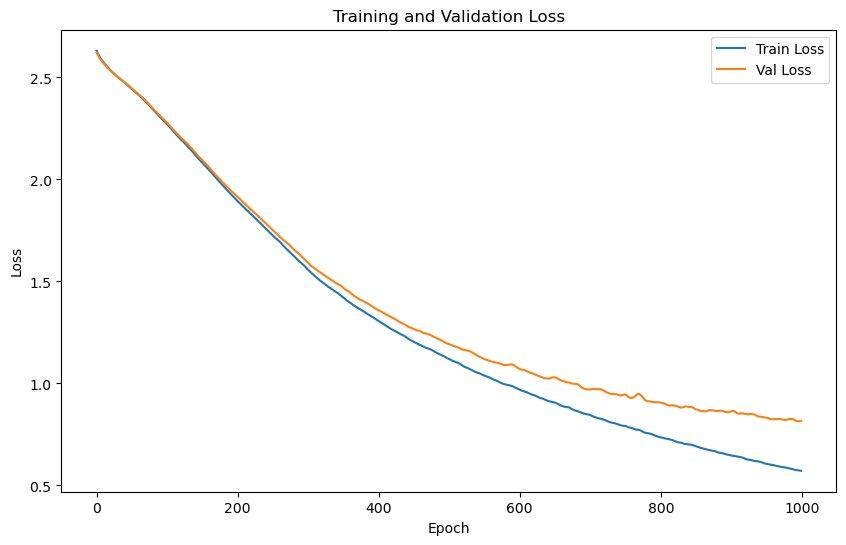

In [45]:
tscl_mlp_input_dim = tscl_mlp_train_reps.shape[1]
tscl_mlp_num_classes = len(torch.unique(tscl_mlp_train_labels_torch))
tscl_mlp_model = MLPClassifier(tscl_mlp_input_dim, tscl_mlp_num_classes).to(device)

tscl_mlp_criterion = nn.CrossEntropyLoss()
tscl_mlp_optimizer = optim.Adam(tscl_mlp_model.parameters(), lr=1e-4)

tscl_mlp_num_epochs = 1000
tscl_mlp_patience = 100

tscl_mlp_train_losses = []
tscl_mlp_val_losses = []

tscl_mlp_best_val_loss = float('inf')
tscl_mlp_epochs_without_improvement = 0

for tscl_mlp_epoch in range(tscl_mlp_num_epochs):
    # Training
    tscl_mlp_model.train()
    tscl_mlp_train_running_loss = 0.0
    
    for tscl_mlp_embeddings_batch, tscl_mlp_labels_batch in tscl_mlp_train_loader:
        tscl_mlp_embeddings_batch = tscl_mlp_embeddings_batch.to(device)
        tscl_mlp_labels_batch = tscl_mlp_labels_batch.to(device)
        
        tscl_mlp_optimizer.zero_grad()
        
        # Forward
        tscl_mlp_outputs = tscl_mlp_model(tscl_mlp_embeddings_batch)
        tscl_mlp_loss = tscl_mlp_criterion(tscl_mlp_outputs, tscl_mlp_labels_batch)
        
        # Backward & Update
        tscl_mlp_loss.backward()
        tscl_mlp_optimizer.step()
        
        tscl_mlp_train_running_loss += tscl_mlp_loss.item() * tscl_mlp_embeddings_batch.size(0)
    
    tscl_mlp_epoch_train_loss = tscl_mlp_train_running_loss / len(tscl_mlp_train_loader.dataset)
    tscl_mlp_train_losses.append(tscl_mlp_epoch_train_loss)

    # Validation
    tscl_mlp_model.eval()
    tscl_mlp_val_running_loss = 0.0
    
    with torch.no_grad():
        for tscl_mlp_val_embeddings_batch, tscl_mlp_val_labels_batch in tscl_mlp_val_loader:
            tscl_mlp_val_embeddings_batch = tscl_mlp_val_embeddings_batch.to(device)
            tscl_mlp_val_labels_batch = tscl_mlp_val_labels_batch.to(device)

            tscl_mlp_val_outputs = tscl_mlp_model(tscl_mlp_val_embeddings_batch)
            tscl_mlp_val_loss = tscl_mlp_criterion(tscl_mlp_val_outputs, tscl_mlp_val_labels_batch)

            tscl_mlp_val_running_loss += tscl_mlp_val_loss.item() * tscl_mlp_val_embeddings_batch.size(0)

    tscl_mlp_epoch_val_loss = tscl_mlp_val_running_loss / len(tscl_mlp_val_loader.dataset)
    tscl_mlp_val_losses.append(tscl_mlp_epoch_val_loss)

    print(f"[Epoch {tscl_mlp_epoch+1}/{tscl_mlp_num_epochs}] "
          f"Train Loss: {tscl_mlp_epoch_train_loss:.4f}  |  "
          f"Val Loss: {tscl_mlp_epoch_val_loss:.4f}")

    # Early stopping
    if tscl_mlp_epoch_val_loss < tscl_mlp_best_val_loss:
        print(f"Validation loss improved from {tscl_mlp_best_val_loss:.4f} to {tscl_mlp_epoch_val_loss:.4f}.")
        tscl_mlp_best_val_loss = tscl_mlp_epoch_val_loss
        tscl_mlp_epochs_without_improvement = 0

    else:
        # no improvement
        tscl_mlp_epochs_without_improvement += 1
        print(f"!! Validation loss did NOT improve !! "
              f"Patience: {tscl_mlp_epochs_without_improvement}/{tscl_mlp_patience}")
        
        if tscl_mlp_epochs_without_improvement >= tscl_mlp_patience:
            print(f"!! Early stopping triggered at epoch {tscl_mlp_epoch+1} !!\n"
                  f"No improvement for {tscl_mlp_patience} epochs.")
            break

plt.figure(figsize=(10,6))
plt.plot(tscl_mlp_train_losses, label='Train Loss')
plt.plot(tscl_mlp_val_losses,   label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


Saved TSCL+MLP predictions and true labels to model_predictions
Test Loss: 1.0719 | Test Accuracy: 58.66%


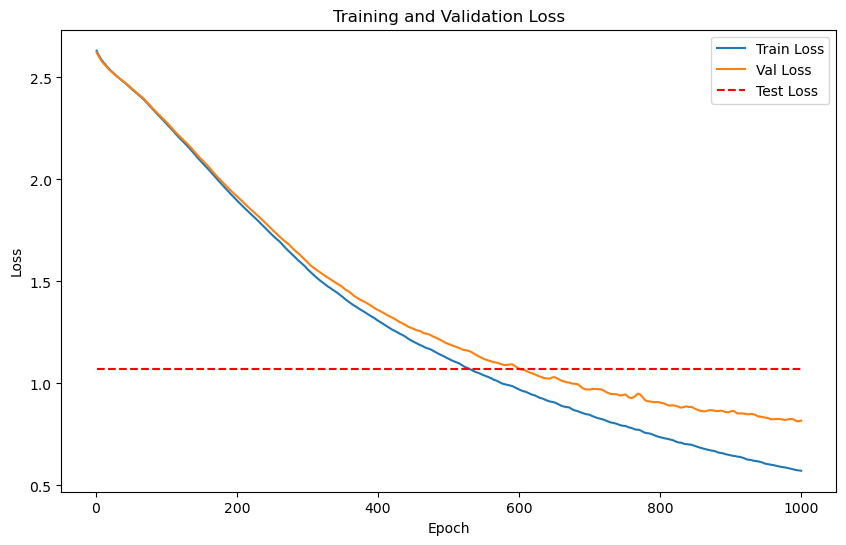

In [46]:
tscl_mlp_model.eval()

tscl_mlp_test_running_loss = 0.0
tscl_mlp_test_correct = 0
tscl_mlp_all_predictions = []
tscl_mlp_all_true_labels = []

with torch.no_grad():
    for tscl_mlp_test_embeddings_batch, tscl_mlp_test_labels_batch in tscl_mlp_test_loader:
        tscl_mlp_test_embeddings_batch = tscl_mlp_test_embeddings_batch.to(device)
        tscl_mlp_test_labels_batch = tscl_mlp_test_labels_batch.to(device)

        tscl_mlp_test_outputs = tscl_mlp_model(tscl_mlp_test_embeddings_batch)
        
        tscl_mlp_test_loss_batch = tscl_mlp_criterion(tscl_mlp_test_outputs, tscl_mlp_test_labels_batch)
        tscl_mlp_test_running_loss += tscl_mlp_test_loss_batch.item() * tscl_mlp_test_embeddings_batch.size(0)

        _, tscl_mlp_test_predicted = torch.max(tscl_mlp_test_outputs, dim=1)
        tscl_mlp_test_correct += (tscl_mlp_test_predicted == tscl_mlp_test_labels_batch).sum().item()

        tscl_mlp_all_predictions.extend(tscl_mlp_test_predicted.cpu().numpy())
        tscl_mlp_all_true_labels.extend(tscl_mlp_test_labels_batch.cpu().numpy())

np.save(os.path.join(predictions_dir, 'tscl_mlp_predictions.npy'), np.array(tscl_mlp_all_predictions))
np.save(os.path.join(predictions_dir, 'tscl_mlp_true_labels.npy'), np.array(tscl_mlp_all_true_labels))
print(f"Saved TSCL+MLP predictions and true labels to {predictions_dir}")

tscl_mlp_epoch_test_loss = tscl_mlp_test_running_loss / len(tscl_mlp_test_loader.dataset)
tscl_mlp_test_accuracy = tscl_mlp_test_correct / len(tscl_mlp_test_loader.dataset)

tscl_mlp_test_accuracy_pct = tscl_mlp_test_accuracy * 100.0

print(f"Test Loss: {tscl_mlp_epoch_test_loss:.4f} | Test Accuracy: {tscl_mlp_test_accuracy_pct:.2f}%")

tscl_mlp_num_epochs_run = len(tscl_mlp_train_losses)

plt.figure(figsize=(10,6))

plt.plot(range(1, tscl_mlp_num_epochs_run + 1),
         tscl_mlp_train_losses,
         label='Train Loss')
plt.plot(range(1, tscl_mlp_num_epochs_run + 1),
         tscl_mlp_val_losses,
         label='Val Loss')

plt.plot(range(1, tscl_mlp_num_epochs_run + 1),
         [tscl_mlp_epoch_test_loss]*tscl_mlp_num_epochs_run,
         'r--',
         label='Test Loss')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


## Model - Supervised Contrastive Learning with Silhouette Distance Loss

In [47]:
sclsdl_encoded_train_dir = os.path.join(encoded_dir, 'train')
sclsdl_encoded_val_dir = os.path.join(encoded_dir, 'val')
sclsdl_encoded_test_dir = os.path.join(encoded_dir, 'test')

sclsdl_train_embeddings, sclsdl_train_labels = load_encoded_data(sclsdl_encoded_train_dir)
sclsdl_val_embeddings, sclsdl_val_labels = load_encoded_data(sclsdl_encoded_val_dir)
sclsdl_test_embeddings, sclsdl_test_labels = load_encoded_data(sclsdl_encoded_test_dir)

#shape verification
print(f"\n\nTrain embeddings shape: {sclsdl_train_embeddings.shape}, \nTrain labels shape: {sclsdl_train_labels.shape}")
print(f"\n\nVal embeddings shape: {sclsdl_val_embeddings.shape}, \nVal labels shape: {sclsdl_val_labels.shape}")
print(f"\n\nTest embeddings shape: {sclsdl_test_embeddings.shape}, \nTest labels shape: {sclsdl_test_labels.shape}")

LOG: Loading encoded data (representations) from encoded_representations\train...
LOG: Loaded 70 samples with 64 features each
LOG: Labels shape: (70,)
LOG: Loading encoded data (representations) from encoded_representations\val...
LOG: Loaded 70 samples with 64 features each
LOG: Labels shape: (70,)
LOG: Loading encoded data (representations) from encoded_representations\test...
LOG: Loaded 3108 samples with 64 features each
LOG: Labels shape: (3108,)


Train embeddings shape: (70, 64), 
Train labels shape: (70,)


Val embeddings shape: (70, 64), 
Val labels shape: (70,)


Test embeddings shape: (3108, 64), 
Test labels shape: (3108,)


In [48]:
#flattening embeddings to (num_samples, 64)
sclsdl_train_embeddings = sclsdl_train_embeddings.reshape(sclsdl_train_embeddings.shape[0], -1)
sclsdl_val_embeddings = sclsdl_val_embeddings.reshape(sclsdl_val_embeddings.shape[0], -1)
sclsdl_test_embeddings = sclsdl_test_embeddings.reshape(sclsdl_test_embeddings.shape[0], -1)

#compute mean and std from training set
sclsdl_train_mean = np.mean(sclsdl_train_embeddings, axis=0)
sclsdl_train_std = np.std(sclsdl_train_embeddings, axis=0)

#normalize all datasets from above training mean and std
#sclsdl_train_embeddings = (sclsdl_train_embeddings - sclsdl_train_mean) / sclsdl_train_std
#sclsdl_val_embeddings = (sclsdl_val_embeddings - sclsdl_train_mean) / sclsdl_train_std
#sclsdl_test_embeddings = (sclsdl_test_embeddings - sclsdl_train_mean) / sclsdl_train_std

sclsdl_train_dataset = TensorDataset(torch.tensor(sclsdl_train_embeddings, dtype=torch.float32), torch.tensor(sclsdl_train_labels, dtype=torch.long))
sclsdl_val_dataset = TensorDataset(torch.tensor(sclsdl_val_embeddings, dtype=torch.float32), torch.tensor(sclsdl_val_labels, dtype=torch.long))
sclsdl_test_dataset = TensorDataset(torch.tensor(sclsdl_test_embeddings, dtype=torch.float32), torch.tensor(sclsdl_test_labels, dtype=torch.long))


sclsdl_m = 20
sclsdl_num_classes = len(np.unique(sclsdl_train_labels))

# calc theoretical required batch size
sclsdl_required_batch_size = sclsdl_m * sclsdl_num_classes

if sclsdl_required_batch_size > len(sclsdl_train_dataset):
    sclsdl_max_possible_m = len(sclsdl_train_dataset) // sclsdl_num_classes
    sclsdl_m = max(1, sclsdl_max_possible_m)
    sclsdl_batch_size_train = sclsdl_m * sclsdl_num_classes
else:
    sclsdl_batch_size_train = sclsdl_required_batch_size

sclsdl_sampler = MPerClassSampler(labels = sclsdl_train_labels, m = sclsdl_m, batch_size = sclsdl_batch_size_train, length_before_new_iter=len(sclsdl_train_dataset))
sclsdl_train_loader = DataLoader(sclsdl_train_dataset, batch_size=sclsdl_batch_size_train, sampler=sclsdl_sampler)

#creating dataloaders for scl
sclsdl_dataloader_bs = 64
sclsdl_val_loader = DataLoader(sclsdl_val_dataset, batch_size=sclsdl_dataloader_bs, shuffle=False)
sclsdl_test_loader = DataLoader(sclsdl_test_dataset, batch_size=sclsdl_dataloader_bs, shuffle=False)

for sclsdl_X_batch, sclsdl_y_batch in sclsdl_train_loader:
    sclsdl_unique, sclsdl_counts = np.unique(y_batch.numpy(), return_counts=True)
    print("Class distribution in batch:", dict(zip(sclsdl_unique, sclsdl_counts)))
    print(f"Training batch size: {sclsdl_batch_size_train}")
    break


Class distribution in batch: {0: 5, 1: 5, 2: 5, 3: 5, 4: 5, 5: 5, 6: 5, 7: 5, 8: 5, 9: 5, 10: 5, 11: 5, 12: 5, 13: 5}
Training batch size: 70


In [49]:
class SupConNet(nn.Module):
    def __init__(self, feature_dim=128):
        super(SupConNet, self).__init__()
        self.projection_head = nn.Sequential(
            nn.Linear(64, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(128, feature_dim)
        )

    def forward(self, x):
        return self.projection_head(x)

In [50]:
class SilhouetteDistanceLoss(nn.Module):
    def __init__(self):
        super(SilhouetteDistanceLoss, self).__init__()

    def forward(self, features, labels):
        return self.score(features, labels, True,True)

    def score(self,X, labels,feature_norm=True, loss=False):
        unique_labels = torch.unique(labels)
        if feature_norm:
            X= F.normalize(X, p=2, dim=1)


        A, B = self._compute_distances(X, labels, unique_labels)

        # A= scale*A
        # B = (1-scale)*B
        sil_samples = (B - A) / torch.clamp(torch.maximum(A, B), min=0.0001)

        # nan values are for clusters of size 1, and should be 0
        mean_sil_score = torch.mean(torch.nan_to_num(sil_samples))
        if loss:
            return (1 - mean_sil_score) / 2
        else:
            return mean_sil_score.item()


    def _compute_distances(self,X, labels, unique_labels):
        intra_dist = torch.zeros_like(labels, dtype=torch.float32)
        inter_dist = torch.full_like(labels, torch.inf, dtype=torch.float32)

        for i, label_a in enumerate(unique_labels):
            cluster_indices_a = (labels == label_a)
            subX_a = X[cluster_indices_a]


            intra_distances_a = torch.cdist(subX_a, subX_a)
            div = (subX_a.size(0) - 1) if subX_a.shape[0]>1 else 1
            intra_dist[cluster_indices_a] = intra_distances_a.sum(dim=1) / div

            for label_b in unique_labels[i + 1:]:
                cluster_indices_b = (labels == label_b)
                subX_b = X[cluster_indices_b]
                inter_distances_ab = torch.cdist(subX_a, subX_b)
                inter_distances_ba = torch.cdist(subX_b, subX_a)

                inter_dist[cluster_indices_a] = torch.minimum(inter_distances_ab.mean(dim=1), inter_dist[cluster_indices_a])
                inter_dist[cluster_indices_b] = torch.minimum(inter_distances_ba.mean(dim=1), inter_dist[cluster_indices_b])

        return intra_dist, inter_dist

LOG: Epoch [1/2000] - Training


    Batch [1/1], Train Loss: 0.4751
LOG: Epoch [1/2000] - Validation
    Batch [1/2], Val Loss: 0.4558
    Batch [2/2], Val Loss: 0.1442
Epoch [1/2000], Avg Train Loss: 0.4751, Avg Val Loss: 0.3000

Validation loss improved from inf to 0.3000. Saving model...
LOG: Epoch [2/2000] - Training


    Batch [1/1], Train Loss: 0.4700
LOG: Epoch [2/2000] - Validation
    Batch [1/2], Val Loss: 0.4554
    Batch [2/2], Val Loss: 0.1452
Epoch [2/2000], Avg Train Loss: 0.4700, Avg Val Loss: 0.3003

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [3/2000] - Training


    Batch [1/1], Train Loss: 0.4696
LOG: Epoch [3/2000] - Validation
    Batch [1/2], Val Loss: 0.4549
    Batch [2/2], Val Loss: 0.1462
Epoch [3/2000], Avg Train Loss: 0.4696, Avg Val Loss: 0.3005

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [4/2000] - Training


    Batch [1/1], Train Loss: 0.4706
LOG: Epoch [4/2000] - Validation
    Batch [1/2], Val Loss: 0.4546
    Batch [2/2], Val Loss: 0.1462
Epoch [4/2000], Avg Train Loss: 0.4706, Avg Val Loss: 0.3004

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [5/2000] - Training


    Batch [1/1], Train Loss: 0.4785
LOG: Epoch [5/2000] - Validation
    Batch [1/2], Val Loss: 0.4546
    Batch [2/2], Val Loss: 0.1459
Epoch [5/2000], Avg Train Loss: 0.4785, Avg Val Loss: 0.3003

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [6/2000] - Training


    Batch [1/1], Train Loss: 0.4811
LOG: Epoch [6/2000] - Validation
    Batch [1/2], Val Loss: 0.4545
    Batch [2/2], Val Loss: 0.1456
Epoch [6/2000], Avg Train Loss: 0.4811, Avg Val Loss: 0.3000

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [7/2000] - Training


    Batch [1/1], Train Loss: 0.4738
LOG: Epoch [7/2000] - Validation
    Batch [1/2], Val Loss: 0.4540
    Batch [2/2], Val Loss: 0.1448
Epoch [7/2000], Avg Train Loss: 0.4738, Avg Val Loss: 0.2994

Validation loss improved from 0.3000 to 0.2994. Saving model...
LOG: Epoch [8/2000] - Training


    Batch [1/1], Train Loss: 0.4657
LOG: Epoch [8/2000] - Validation
    Batch [1/2], Val Loss: 0.4526
    Batch [2/2], Val Loss: 0.1448
Epoch [8/2000], Avg Train Loss: 0.4657, Avg Val Loss: 0.2987

Validation loss improved from 0.2994 to 0.2987. Saving model...
LOG: Epoch [9/2000] - Training


    Batch [1/1], Train Loss: 0.4718
LOG: Epoch [9/2000] - Validation
    Batch [1/2], Val Loss: 0.4505
    Batch [2/2], Val Loss: 0.1451
Epoch [9/2000], Avg Train Loss: 0.4718, Avg Val Loss: 0.2978

Validation loss improved from 0.2987 to 0.2978. Saving model...
LOG: Epoch [10/2000] - Training


    Batch [1/1], Train Loss: 0.4784
LOG: Epoch [10/2000] - Validation
    Batch [1/2], Val Loss: 0.4489
    Batch [2/2], Val Loss: 0.1451
Epoch [10/2000], Avg Train Loss: 0.4784, Avg Val Loss: 0.2970

Validation loss improved from 0.2978 to 0.2970. Saving model...
LOG: Epoch [11/2000] - Training
    Batch [1/1], Train Loss: 0.4673
LOG: Epoch [11/2000] - Validation


    Batch [1/2], Val Loss: 0.4473
    Batch [2/2], Val Loss: 0.1459
Epoch [11/2000], Avg Train Loss: 0.4673, Avg Val Loss: 0.2966

Validation loss improved from 0.2970 to 0.2966. Saving model...
LOG: Epoch [12/2000] - Training


    Batch [1/1], Train Loss: 0.4632
LOG: Epoch [12/2000] - Validation
    Batch [1/2], Val Loss: 0.4461
    Batch [2/2], Val Loss: 0.1474
Epoch [12/2000], Avg Train Loss: 0.4632, Avg Val Loss: 0.2967

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [13/2000] - Training


    Batch [1/1], Train Loss: 0.4588
LOG: Epoch [13/2000] - Validation
    Batch [1/2], Val Loss: 0.4448
    Batch [2/2], Val Loss: 0.1466
Epoch [13/2000], Avg Train Loss: 0.4588, Avg Val Loss: 0.2957

Validation loss improved from 0.2966 to 0.2957. Saving model...
LOG: Epoch [14/2000] - Training


    Batch [1/1], Train Loss: 0.4613
LOG: Epoch [14/2000] - Validation
    Batch [1/2], Val Loss: 0.4442
    Batch [2/2], Val Loss: 0.1427
Epoch [14/2000], Avg Train Loss: 0.4613, Avg Val Loss: 0.2935

Validation loss improved from 0.2957 to 0.2935. Saving model...
LOG: Epoch [15/2000] - Training


    Batch [1/1], Train Loss: 0.4663
LOG: Epoch [15/2000] - Validation
    Batch [1/2], Val Loss: 0.4440
    Batch [2/2], Val Loss: 0.1372
Epoch [15/2000], Avg Train Loss: 0.4663, Avg Val Loss: 0.2906

Validation loss improved from 0.2935 to 0.2906. Saving model...
LOG: Epoch [16/2000] - Training


    Batch [1/1], Train Loss: 0.4652
LOG: Epoch [16/2000] - Validation
    Batch [1/2], Val Loss: 0.4437
    Batch [2/2], Val Loss: 0.1311
Epoch [16/2000], Avg Train Loss: 0.4652, Avg Val Loss: 0.2874

Validation loss improved from 0.2906 to 0.2874. Saving model...
LOG: Epoch [17/2000] - Training


    Batch [1/1], Train Loss: 0.4542
LOG: Epoch [17/2000] - Validation
    Batch [1/2], Val Loss: 0.4435
    Batch [2/2], Val Loss: 0.1260
Epoch [17/2000], Avg Train Loss: 0.4542, Avg Val Loss: 0.2848

Validation loss improved from 0.2874 to 0.2848. Saving model...
LOG: Epoch [18/2000] - Training


    Batch [1/1], Train Loss: 0.4541
LOG: Epoch [18/2000] - Validation
    Batch [1/2], Val Loss: 0.4426
    Batch [2/2], Val Loss: 0.1215
Epoch [18/2000], Avg Train Loss: 0.4541, Avg Val Loss: 0.2821

Validation loss improved from 0.2848 to 0.2821. Saving model...
LOG: Epoch [19/2000] - Training


    Batch [1/1], Train Loss: 0.4679
LOG: Epoch [19/2000] - Validation
    Batch [1/2], Val Loss: 0.4416
    Batch [2/2], Val Loss: 0.1153
Epoch [19/2000], Avg Train Loss: 0.4679, Avg Val Loss: 0.2785

Validation loss improved from 0.2821 to 0.2785. Saving model...
LOG: Epoch [20/2000] - Training


    Batch [1/1], Train Loss: 0.4532
LOG: Epoch [20/2000] - Validation
    Batch [1/2], Val Loss: 0.4408
    Batch [2/2], Val Loss: 0.1081
Epoch [20/2000], Avg Train Loss: 0.4532, Avg Val Loss: 0.2745

Validation loss improved from 0.2785 to 0.2745. Saving model...
LOG: Epoch [21/2000] - Training


    Batch [1/1], Train Loss: 0.4593
LOG: Epoch [21/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.1013
Epoch [21/2000], Avg Train Loss: 0.4593, Avg Val Loss: 0.2708

Validation loss improved from 0.2745 to 0.2708. Saving model...
LOG: Epoch [22/2000] - Training


    Batch [1/1], Train Loss: 0.4541
LOG: Epoch [22/2000] - Validation
    Batch [1/2], Val Loss: 0.4400
    Batch [2/2], Val Loss: 0.0960
Epoch [22/2000], Avg Train Loss: 0.4541, Avg Val Loss: 0.2680

Validation loss improved from 0.2708 to 0.2680. Saving model...
LOG: Epoch [23/2000] - Training


    Batch [1/1], Train Loss: 0.4656
LOG: Epoch [23/2000] - Validation
    Batch [1/2], Val Loss: 0.4398
    Batch [2/2], Val Loss: 0.0923
Epoch [23/2000], Avg Train Loss: 0.4656, Avg Val Loss: 0.2660

Validation loss improved from 0.2680 to 0.2660. Saving model...
LOG: Epoch [24/2000] - Training


    Batch [1/1], Train Loss: 0.4474
LOG: Epoch [24/2000] - Validation
    Batch [1/2], Val Loss: 0.4391
    Batch [2/2], Val Loss: 0.0903
Epoch [24/2000], Avg Train Loss: 0.4474, Avg Val Loss: 0.2647

Validation loss improved from 0.2660 to 0.2647. Saving model...
LOG: Epoch [25/2000] - Training


    Batch [1/1], Train Loss: 0.4527
LOG: Epoch [25/2000] - Validation
    Batch [1/2], Val Loss: 0.4385
    Batch [2/2], Val Loss: 0.0902
Epoch [25/2000], Avg Train Loss: 0.4527, Avg Val Loss: 0.2644

Validation loss improved from 0.2647 to 0.2644. Saving model...
LOG: Epoch [26/2000] - Training


    Batch [1/1], Train Loss: 0.4517
LOG: Epoch [26/2000] - Validation
    Batch [1/2], Val Loss: 0.4385
    Batch [2/2], Val Loss: 0.0902
Epoch [26/2000], Avg Train Loss: 0.4517, Avg Val Loss: 0.2643

Validation loss improved from 0.2644 to 0.2643. Saving model...
LOG: Epoch [27/2000] - Training


    Batch [1/1], Train Loss: 0.4560
LOG: Epoch [27/2000] - Validation
    Batch [1/2], Val Loss: 0.4387
    Batch [2/2], Val Loss: 0.0902
Epoch [27/2000], Avg Train Loss: 0.4560, Avg Val Loss: 0.2645

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [28/2000] - Training


    Batch [1/1], Train Loss: 0.4443
LOG: Epoch [28/2000] - Validation
    Batch [1/2], Val Loss: 0.4386
    Batch [2/2], Val Loss: 0.0904
Epoch [28/2000], Avg Train Loss: 0.4443, Avg Val Loss: 0.2645

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [29/2000] - Training
    Batch [1/1], Train Loss: 0.4632
LOG: Epoch [29/2000] - Validation


    Batch [1/2], Val Loss: 0.4376
    Batch [2/2], Val Loss: 0.0911
Epoch [29/2000], Avg Train Loss: 0.4632, Avg Val Loss: 0.2643

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [30/2000] - Training


    Batch [1/1], Train Loss: 0.4547
LOG: Epoch [30/2000] - Validation
    Batch [1/2], Val Loss: 0.4358
    Batch [2/2], Val Loss: 0.0922
Epoch [30/2000], Avg Train Loss: 0.4547, Avg Val Loss: 0.2640

Validation loss improved from 0.2643 to 0.2640. Saving model...
LOG: Epoch [31/2000] - Training


    Batch [1/1], Train Loss: 0.4450
LOG: Epoch [31/2000] - Validation
    Batch [1/2], Val Loss: 0.4339
    Batch [2/2], Val Loss: 0.0933
Epoch [31/2000], Avg Train Loss: 0.4450, Avg Val Loss: 0.2636

Validation loss improved from 0.2640 to 0.2636. Saving model...
LOG: Epoch [32/2000] - Training


    Batch [1/1], Train Loss: 0.4480
LOG: Epoch [32/2000] - Validation
    Batch [1/2], Val Loss: 0.4321
    Batch [2/2], Val Loss: 0.0946
Epoch [32/2000], Avg Train Loss: 0.4480, Avg Val Loss: 0.2633

Validation loss improved from 0.2636 to 0.2633. Saving model...
LOG: Epoch [33/2000] - Training


    Batch [1/1], Train Loss: 0.4477
LOG: Epoch [33/2000] - Validation
    Batch [1/2], Val Loss: 0.4309
    Batch [2/2], Val Loss: 0.0957
Epoch [33/2000], Avg Train Loss: 0.4477, Avg Val Loss: 0.2633

Validation loss improved from 0.2633 to 0.2633. Saving model...
LOG: Epoch [34/2000] - Training
    Batch [1/1], Train Loss: 0.4481
LOG: Epoch [34/2000] - Validation


    Batch [1/2], Val Loss: 0.4298
    Batch [2/2], Val Loss: 0.0968
Epoch [34/2000], Avg Train Loss: 0.4481, Avg Val Loss: 0.2633

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [35/2000] - Training


    Batch [1/1], Train Loss: 0.4449
LOG: Epoch [35/2000] - Validation
    Batch [1/2], Val Loss: 0.4284
    Batch [2/2], Val Loss: 0.0981
Epoch [35/2000], Avg Train Loss: 0.4449, Avg Val Loss: 0.2632

Validation loss improved from 0.2633 to 0.2632. Saving model...
LOG: Epoch [36/2000] - Training


    Batch [1/1], Train Loss: 0.4550
LOG: Epoch [36/2000] - Validation
    Batch [1/2], Val Loss: 0.4267
    Batch [2/2], Val Loss: 0.0995
Epoch [36/2000], Avg Train Loss: 0.4550, Avg Val Loss: 0.2631

Validation loss improved from 0.2632 to 0.2631. Saving model...
LOG: Epoch [37/2000] - Training


    Batch [1/1], Train Loss: 0.4514
LOG: Epoch [37/2000] - Validation
    Batch [1/2], Val Loss: 0.4254
    Batch [2/2], Val Loss: 0.1009
Epoch [37/2000], Avg Train Loss: 0.4514, Avg Val Loss: 0.2631

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [38/2000] - Training


    Batch [1/1], Train Loss: 0.4400
LOG: Epoch [38/2000] - Validation
    Batch [1/2], Val Loss: 0.4246
    Batch [2/2], Val Loss: 0.1020
Epoch [38/2000], Avg Train Loss: 0.4400, Avg Val Loss: 0.2633

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [39/2000] - Training


    Batch [1/1], Train Loss: 0.4438
LOG: Epoch [39/2000] - Validation
    Batch [1/2], Val Loss: 0.4243
    Batch [2/2], Val Loss: 0.1032
Epoch [39/2000], Avg Train Loss: 0.4438, Avg Val Loss: 0.2638

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [40/2000] - Training


    Batch [1/1], Train Loss: 0.4387
LOG: Epoch [40/2000] - Validation
    Batch [1/2], Val Loss: 0.4239
    Batch [2/2], Val Loss: 0.1044
Epoch [40/2000], Avg Train Loss: 0.4387, Avg Val Loss: 0.2641

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [41/2000] - Training


    Batch [1/1], Train Loss: 0.4483
LOG: Epoch [41/2000] - Validation
    Batch [1/2], Val Loss: 0.4235
    Batch [2/2], Val Loss: 0.1053
Epoch [41/2000], Avg Train Loss: 0.4483, Avg Val Loss: 0.2644

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [42/2000] - Training


    Batch [1/1], Train Loss: 0.4437
LOG: Epoch [42/2000] - Validation
    Batch [1/2], Val Loss: 0.4232
    Batch [2/2], Val Loss: 0.1066
Epoch [42/2000], Avg Train Loss: 0.4437, Avg Val Loss: 0.2649

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [43/2000] - Training


    Batch [1/1], Train Loss: 0.4409
LOG: Epoch [43/2000] - Validation
    Batch [1/2], Val Loss: 0.4227
    Batch [2/2], Val Loss: 0.1079
Epoch [43/2000], Avg Train Loss: 0.4409, Avg Val Loss: 0.2653

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [44/2000] - Training


    Batch [1/1], Train Loss: 0.4384
LOG: Epoch [44/2000] - Validation
    Batch [1/2], Val Loss: 0.4225
    Batch [2/2], Val Loss: 0.1090
Epoch [44/2000], Avg Train Loss: 0.4384, Avg Val Loss: 0.2658

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [45/2000] - Training


    Batch [1/1], Train Loss: 0.4437
LOG: Epoch [45/2000] - Validation
    Batch [1/2], Val Loss: 0.4222
    Batch [2/2], Val Loss: 0.1102
Epoch [45/2000], Avg Train Loss: 0.4437, Avg Val Loss: 0.2662

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [46/2000] - Training


    Batch [1/1], Train Loss: 0.4287
LOG: Epoch [46/2000] - Validation
    Batch [1/2], Val Loss: 0.4218
    Batch [2/2], Val Loss: 0.1111
Epoch [46/2000], Avg Train Loss: 0.4287, Avg Val Loss: 0.2665

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [47/2000] - Training


    Batch [1/1], Train Loss: 0.4499
LOG: Epoch [47/2000] - Validation
    Batch [1/2], Val Loss: 0.4214
    Batch [2/2], Val Loss: 0.1118
Epoch [47/2000], Avg Train Loss: 0.4499, Avg Val Loss: 0.2666

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [48/2000] - Training


    Batch [1/1], Train Loss: 0.4338
LOG: Epoch [48/2000] - Validation
    Batch [1/2], Val Loss: 0.4209
    Batch [2/2], Val Loss: 0.1126
Epoch [48/2000], Avg Train Loss: 0.4338, Avg Val Loss: 0.2667

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [49/2000] - Training


    Batch [1/1], Train Loss: 0.4399
LOG: Epoch [49/2000] - Validation
    Batch [1/2], Val Loss: 0.4205
    Batch [2/2], Val Loss: 0.1136
Epoch [49/2000], Avg Train Loss: 0.4399, Avg Val Loss: 0.2670

!! Validation loss did NOT improve !! Patience: 13/100
LOG: Epoch [50/2000] - Training


    Batch [1/1], Train Loss: 0.4408
LOG: Epoch [50/2000] - Validation
    Batch [1/2], Val Loss: 0.4199
    Batch [2/2], Val Loss: 0.1146
Epoch [50/2000], Avg Train Loss: 0.4408, Avg Val Loss: 0.2672

!! Validation loss did NOT improve !! Patience: 14/100
LOG: Epoch [51/2000] - Training


    Batch [1/1], Train Loss: 0.4298
LOG: Epoch [51/2000] - Validation
    Batch [1/2], Val Loss: 0.4192
    Batch [2/2], Val Loss: 0.1156
Epoch [51/2000], Avg Train Loss: 0.4298, Avg Val Loss: 0.2674

!! Validation loss did NOT improve !! Patience: 15/100
LOG: Epoch [52/2000] - Training


    Batch [1/1], Train Loss: 0.4412
LOG: Epoch [52/2000] - Validation
    Batch [1/2], Val Loss: 0.4185
    Batch [2/2], Val Loss: 0.1165
Epoch [52/2000], Avg Train Loss: 0.4412, Avg Val Loss: 0.2675

!! Validation loss did NOT improve !! Patience: 16/100
LOG: Epoch [53/2000] - Training


    Batch [1/1], Train Loss: 0.4332
LOG: Epoch [53/2000] - Validation
    Batch [1/2], Val Loss: 0.4178
    Batch [2/2], Val Loss: 0.1173
Epoch [53/2000], Avg Train Loss: 0.4332, Avg Val Loss: 0.2675

!! Validation loss did NOT improve !! Patience: 17/100
LOG: Epoch [54/2000] - Training


    Batch [1/1], Train Loss: 0.4340
LOG: Epoch [54/2000] - Validation
    Batch [1/2], Val Loss: 0.4170
    Batch [2/2], Val Loss: 0.1179
Epoch [54/2000], Avg Train Loss: 0.4340, Avg Val Loss: 0.2674

!! Validation loss did NOT improve !! Patience: 18/100
LOG: Epoch [55/2000] - Training


    Batch [1/1], Train Loss: 0.4331
LOG: Epoch [55/2000] - Validation
    Batch [1/2], Val Loss: 0.4159
    Batch [2/2], Val Loss: 0.1186
Epoch [55/2000], Avg Train Loss: 0.4331, Avg Val Loss: 0.2673

!! Validation loss did NOT improve !! Patience: 19/100
LOG: Epoch [56/2000] - Training


    Batch [1/1], Train Loss: 0.4298
LOG: Epoch [56/2000] - Validation
    Batch [1/2], Val Loss: 0.4149
    Batch [2/2], Val Loss: 0.1190
Epoch [56/2000], Avg Train Loss: 0.4298, Avg Val Loss: 0.2670

!! Validation loss did NOT improve !! Patience: 20/100
LOG: Epoch [57/2000] - Training


    Batch [1/1], Train Loss: 0.4281
LOG: Epoch [57/2000] - Validation
    Batch [1/2], Val Loss: 0.4144
    Batch [2/2], Val Loss: 0.1190
Epoch [57/2000], Avg Train Loss: 0.4281, Avg Val Loss: 0.2667

!! Validation loss did NOT improve !! Patience: 21/100
LOG: Epoch [58/2000] - Training


    Batch [1/1], Train Loss: 0.4359
LOG: Epoch [58/2000] - Validation
    Batch [1/2], Val Loss: 0.4139
    Batch [2/2], Val Loss: 0.1187
Epoch [58/2000], Avg Train Loss: 0.4359, Avg Val Loss: 0.2663

!! Validation loss did NOT improve !! Patience: 22/100
LOG: Epoch [59/2000] - Training


    Batch [1/1], Train Loss: 0.4298
LOG: Epoch [59/2000] - Validation
    Batch [1/2], Val Loss: 0.4138
    Batch [2/2], Val Loss: 0.1183
Epoch [59/2000], Avg Train Loss: 0.4298, Avg Val Loss: 0.2660

!! Validation loss did NOT improve !! Patience: 23/100
LOG: Epoch [60/2000] - Training


    Batch [1/1], Train Loss: 0.4293
LOG: Epoch [60/2000] - Validation
    Batch [1/2], Val Loss: 0.4137
    Batch [2/2], Val Loss: 0.1179
Epoch [60/2000], Avg Train Loss: 0.4293, Avg Val Loss: 0.2658

!! Validation loss did NOT improve !! Patience: 24/100
LOG: Epoch [61/2000] - Training
    Batch [1/1], Train Loss: 0.4379
LOG: Epoch [61/2000] - Validation


    Batch [1/2], Val Loss: 0.4133
    Batch [2/2], Val Loss: 0.1175
Epoch [61/2000], Avg Train Loss: 0.4379, Avg Val Loss: 0.2654

!! Validation loss did NOT improve !! Patience: 25/100
LOG: Epoch [62/2000] - Training


    Batch [1/1], Train Loss: 0.4317
LOG: Epoch [62/2000] - Validation
    Batch [1/2], Val Loss: 0.4129
    Batch [2/2], Val Loss: 0.1171
Epoch [62/2000], Avg Train Loss: 0.4317, Avg Val Loss: 0.2650

!! Validation loss did NOT improve !! Patience: 26/100
LOG: Epoch [63/2000] - Training
    Batch [1/1], Train Loss: 0.4282
LOG: Epoch [63/2000] - Validation


    Batch [1/2], Val Loss: 0.4119
    Batch [2/2], Val Loss: 0.1162
Epoch [63/2000], Avg Train Loss: 0.4282, Avg Val Loss: 0.2641

!! Validation loss did NOT improve !! Patience: 27/100
LOG: Epoch [64/2000] - Training
    Batch [1/1], Train Loss: 0.4233
LOG: Epoch [64/2000] - Validation


    Batch [1/2], Val Loss: 0.4111
    Batch [2/2], Val Loss: 0.1154
Epoch [64/2000], Avg Train Loss: 0.4233, Avg Val Loss: 0.2633

!! Validation loss did NOT improve !! Patience: 28/100
LOG: Epoch [65/2000] - Training
    Batch [1/1], Train Loss: 0.4266
LOG: Epoch [65/2000] - Validation


    Batch [1/2], Val Loss: 0.4103
    Batch [2/2], Val Loss: 0.1147
Epoch [65/2000], Avg Train Loss: 0.4266, Avg Val Loss: 0.2625

Validation loss improved from 0.2631 to 0.2625. Saving model...
LOG: Epoch [66/2000] - Training
    Batch [1/1], Train Loss: 0.4323
LOG: Epoch [66/2000] - Validation


    Batch [1/2], Val Loss: 0.4095
    Batch [2/2], Val Loss: 0.1140
Epoch [66/2000], Avg Train Loss: 0.4323, Avg Val Loss: 0.2618

Validation loss improved from 0.2625 to 0.2618. Saving model...
LOG: Epoch [67/2000] - Training
    Batch [1/1], Train Loss: 0.4327
LOG: Epoch [67/2000] - Validation


    Batch [1/2], Val Loss: 0.4088
    Batch [2/2], Val Loss: 0.1136
Epoch [67/2000], Avg Train Loss: 0.4327, Avg Val Loss: 0.2612

Validation loss improved from 0.2618 to 0.2612. Saving model...
LOG: Epoch [68/2000] - Training
    Batch [1/1], Train Loss: 0.4306
LOG: Epoch [68/2000] - Validation


    Batch [1/2], Val Loss: 0.4084
    Batch [2/2], Val Loss: 0.1132
Epoch [68/2000], Avg Train Loss: 0.4306, Avg Val Loss: 0.2608

Validation loss improved from 0.2612 to 0.2608. Saving model...
LOG: Epoch [69/2000] - Training


    Batch [1/1], Train Loss: 0.4265
LOG: Epoch [69/2000] - Validation
    Batch [1/2], Val Loss: 0.4081
    Batch [2/2], Val Loss: 0.1130
Epoch [69/2000], Avg Train Loss: 0.4265, Avg Val Loss: 0.2605

Validation loss improved from 0.2608 to 0.2605. Saving model...
LOG: Epoch [70/2000] - Training


    Batch [1/1], Train Loss: 0.4204
LOG: Epoch [70/2000] - Validation
    Batch [1/2], Val Loss: 0.4079
    Batch [2/2], Val Loss: 0.1130
Epoch [70/2000], Avg Train Loss: 0.4204, Avg Val Loss: 0.2604

Validation loss improved from 0.2605 to 0.2604. Saving model...
LOG: Epoch [71/2000] - Training


    Batch [1/1], Train Loss: 0.4279
LOG: Epoch [71/2000] - Validation
    Batch [1/2], Val Loss: 0.4077
    Batch [2/2], Val Loss: 0.1131
Epoch [71/2000], Avg Train Loss: 0.4279, Avg Val Loss: 0.2604

Validation loss improved from 0.2604 to 0.2604. Saving model...
LOG: Epoch [72/2000] - Training


    Batch [1/1], Train Loss: 0.4323
LOG: Epoch [72/2000] - Validation
    Batch [1/2], Val Loss: 0.4077
    Batch [2/2], Val Loss: 0.1132
Epoch [72/2000], Avg Train Loss: 0.4323, Avg Val Loss: 0.2604

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [73/2000] - Training


    Batch [1/1], Train Loss: 0.4236
LOG: Epoch [73/2000] - Validation
    Batch [1/2], Val Loss: 0.4076
    Batch [2/2], Val Loss: 0.1133
Epoch [73/2000], Avg Train Loss: 0.4236, Avg Val Loss: 0.2605

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [74/2000] - Training


    Batch [1/1], Train Loss: 0.4243
LOG: Epoch [74/2000] - Validation
    Batch [1/2], Val Loss: 0.4075
    Batch [2/2], Val Loss: 0.1135
Epoch [74/2000], Avg Train Loss: 0.4243, Avg Val Loss: 0.2605

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [75/2000] - Training


    Batch [1/1], Train Loss: 0.4249
LOG: Epoch [75/2000] - Validation
    Batch [1/2], Val Loss: 0.4074
    Batch [2/2], Val Loss: 0.1137
Epoch [75/2000], Avg Train Loss: 0.4249, Avg Val Loss: 0.2606

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [76/2000] - Training


    Batch [1/1], Train Loss: 0.4221
LOG: Epoch [76/2000] - Validation
    Batch [1/2], Val Loss: 0.4074
    Batch [2/2], Val Loss: 0.1140
Epoch [76/2000], Avg Train Loss: 0.4221, Avg Val Loss: 0.2607

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [77/2000] - Training


    Batch [1/1], Train Loss: 0.4256
LOG: Epoch [77/2000] - Validation
    Batch [1/2], Val Loss: 0.4073
    Batch [2/2], Val Loss: 0.1143
Epoch [77/2000], Avg Train Loss: 0.4256, Avg Val Loss: 0.2608

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [78/2000] - Training


    Batch [1/1], Train Loss: 0.4242
LOG: Epoch [78/2000] - Validation
    Batch [1/2], Val Loss: 0.4073
    Batch [2/2], Val Loss: 0.1145
Epoch [78/2000], Avg Train Loss: 0.4242, Avg Val Loss: 0.2609

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [79/2000] - Training


    Batch [1/1], Train Loss: 0.4358
LOG: Epoch [79/2000] - Validation
    Batch [1/2], Val Loss: 0.4072
    Batch [2/2], Val Loss: 0.1148
Epoch [79/2000], Avg Train Loss: 0.4358, Avg Val Loss: 0.2610

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [80/2000] - Training


    Batch [1/1], Train Loss: 0.4263
LOG: Epoch [80/2000] - Validation
    Batch [1/2], Val Loss: 0.4070
    Batch [2/2], Val Loss: 0.1151
Epoch [80/2000], Avg Train Loss: 0.4263, Avg Val Loss: 0.2611

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [81/2000] - Training


    Batch [1/1], Train Loss: 0.4308
LOG: Epoch [81/2000] - Validation
    Batch [1/2], Val Loss: 0.4069
    Batch [2/2], Val Loss: 0.1154
Epoch [81/2000], Avg Train Loss: 0.4308, Avg Val Loss: 0.2611

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [82/2000] - Training


    Batch [1/1], Train Loss: 0.4307
LOG: Epoch [82/2000] - Validation
    Batch [1/2], Val Loss: 0.4068
    Batch [2/2], Val Loss: 0.1157
Epoch [82/2000], Avg Train Loss: 0.4307, Avg Val Loss: 0.2612

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [83/2000] - Training


    Batch [1/1], Train Loss: 0.4279
LOG: Epoch [83/2000] - Validation
    Batch [1/2], Val Loss: 0.4068
    Batch [2/2], Val Loss: 0.1159
Epoch [83/2000], Avg Train Loss: 0.4279, Avg Val Loss: 0.2613

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [84/2000] - Training


    Batch [1/1], Train Loss: 0.4269
LOG: Epoch [84/2000] - Validation
    Batch [1/2], Val Loss: 0.4067
    Batch [2/2], Val Loss: 0.1162
Epoch [84/2000], Avg Train Loss: 0.4269, Avg Val Loss: 0.2614

!! Validation loss did NOT improve !! Patience: 13/100
LOG: Epoch [85/2000] - Training


    Batch [1/1], Train Loss: 0.4228
LOG: Epoch [85/2000] - Validation
    Batch [1/2], Val Loss: 0.4066
    Batch [2/2], Val Loss: 0.1165
Epoch [85/2000], Avg Train Loss: 0.4228, Avg Val Loss: 0.2615

!! Validation loss did NOT improve !! Patience: 14/100
LOG: Epoch [86/2000] - Training


    Batch [1/1], Train Loss: 0.4321
LOG: Epoch [86/2000] - Validation
    Batch [1/2], Val Loss: 0.4066
    Batch [2/2], Val Loss: 0.1167
Epoch [86/2000], Avg Train Loss: 0.4321, Avg Val Loss: 0.2616

!! Validation loss did NOT improve !! Patience: 15/100
LOG: Epoch [87/2000] - Training


    Batch [1/1], Train Loss: 0.4295
LOG: Epoch [87/2000] - Validation
    Batch [1/2], Val Loss: 0.4066
    Batch [2/2], Val Loss: 0.1168
Epoch [87/2000], Avg Train Loss: 0.4295, Avg Val Loss: 0.2617

!! Validation loss did NOT improve !! Patience: 16/100
LOG: Epoch [88/2000] - Training


    Batch [1/1], Train Loss: 0.4259
LOG: Epoch [88/2000] - Validation
    Batch [1/2], Val Loss: 0.4065
    Batch [2/2], Val Loss: 0.1170
Epoch [88/2000], Avg Train Loss: 0.4259, Avg Val Loss: 0.2618

!! Validation loss did NOT improve !! Patience: 17/100
LOG: Epoch [89/2000] - Training


    Batch [1/1], Train Loss: 0.4173
LOG: Epoch [89/2000] - Validation
    Batch [1/2], Val Loss: 0.4065
    Batch [2/2], Val Loss: 0.1172
Epoch [89/2000], Avg Train Loss: 0.4173, Avg Val Loss: 0.2618

!! Validation loss did NOT improve !! Patience: 18/100
LOG: Epoch [90/2000] - Training


    Batch [1/1], Train Loss: 0.4337
LOG: Epoch [90/2000] - Validation
    Batch [1/2], Val Loss: 0.4064
    Batch [2/2], Val Loss: 0.1173
Epoch [90/2000], Avg Train Loss: 0.4337, Avg Val Loss: 0.2619

!! Validation loss did NOT improve !! Patience: 19/100
LOG: Epoch [91/2000] - Training


    Batch [1/1], Train Loss: 0.4147
LOG: Epoch [91/2000] - Validation
    Batch [1/2], Val Loss: 0.4064
    Batch [2/2], Val Loss: 0.1174
Epoch [91/2000], Avg Train Loss: 0.4147, Avg Val Loss: 0.2619

!! Validation loss did NOT improve !! Patience: 20/100
LOG: Epoch [92/2000] - Training


    Batch [1/1], Train Loss: 0.4271
LOG: Epoch [92/2000] - Validation
    Batch [1/2], Val Loss: 0.4063
    Batch [2/2], Val Loss: 0.1175
Epoch [92/2000], Avg Train Loss: 0.4271, Avg Val Loss: 0.2619

!! Validation loss did NOT improve !! Patience: 21/100
LOG: Epoch [93/2000] - Training


    Batch [1/1], Train Loss: 0.4240
LOG: Epoch [93/2000] - Validation
    Batch [1/2], Val Loss: 0.4063
    Batch [2/2], Val Loss: 0.1175
Epoch [93/2000], Avg Train Loss: 0.4240, Avg Val Loss: 0.2619

!! Validation loss did NOT improve !! Patience: 22/100
LOG: Epoch [94/2000] - Training


    Batch [1/1], Train Loss: 0.4277
LOG: Epoch [94/2000] - Validation
    Batch [1/2], Val Loss: 0.4062
    Batch [2/2], Val Loss: 0.1176
Epoch [94/2000], Avg Train Loss: 0.4277, Avg Val Loss: 0.2619

!! Validation loss did NOT improve !! Patience: 23/100
LOG: Epoch [95/2000] - Training


    Batch [1/1], Train Loss: 0.4241
LOG: Epoch [95/2000] - Validation
    Batch [1/2], Val Loss: 0.4061
    Batch [2/2], Val Loss: 0.1177
Epoch [95/2000], Avg Train Loss: 0.4241, Avg Val Loss: 0.2619

!! Validation loss did NOT improve !! Patience: 24/100
LOG: Epoch [96/2000] - Training


    Batch [1/1], Train Loss: 0.4338
LOG: Epoch [96/2000] - Validation
    Batch [1/2], Val Loss: 0.4061
    Batch [2/2], Val Loss: 0.1179
Epoch [96/2000], Avg Train Loss: 0.4338, Avg Val Loss: 0.2620

!! Validation loss did NOT improve !! Patience: 25/100
LOG: Epoch [97/2000] - Training
    Batch [1/1], Train Loss: 0.4333
LOG: Epoch [97/2000] - Validation


    Batch [1/2], Val Loss: 0.4060
    Batch [2/2], Val Loss: 0.1179
Epoch [97/2000], Avg Train Loss: 0.4333, Avg Val Loss: 0.2620

!! Validation loss did NOT improve !! Patience: 26/100
LOG: Epoch [98/2000] - Training


    Batch [1/1], Train Loss: 0.4291
LOG: Epoch [98/2000] - Validation
    Batch [1/2], Val Loss: 0.4060
    Batch [2/2], Val Loss: 0.1180
Epoch [98/2000], Avg Train Loss: 0.4291, Avg Val Loss: 0.2620

!! Validation loss did NOT improve !! Patience: 27/100
LOG: Epoch [99/2000] - Training
    Batch [1/1], Train Loss: 0.4314
LOG: Epoch [99/2000] - Validation


    Batch [1/2], Val Loss: 0.4059
    Batch [2/2], Val Loss: 0.1180
Epoch [99/2000], Avg Train Loss: 0.4314, Avg Val Loss: 0.2620

!! Validation loss did NOT improve !! Patience: 28/100
LOG: Epoch [100/2000] - Training
    Batch [1/1], Train Loss: 0.4283
LOG: Epoch [100/2000] - Validation


    Batch [1/2], Val Loss: 0.4059
    Batch [2/2], Val Loss: 0.1181
Epoch [100/2000], Avg Train Loss: 0.4283, Avg Val Loss: 0.2620

!! Validation loss did NOT improve !! Patience: 29/100
LOG: Epoch [101/2000] - Training


    Batch [1/1], Train Loss: 0.4299
LOG: Epoch [101/2000] - Validation
    Batch [1/2], Val Loss: 0.4058
    Batch [2/2], Val Loss: 0.1181
Epoch [101/2000], Avg Train Loss: 0.4299, Avg Val Loss: 0.2620

!! Validation loss did NOT improve !! Patience: 30/100
LOG: Epoch [102/2000] - Training


    Batch [1/1], Train Loss: 0.4276
LOG: Epoch [102/2000] - Validation
    Batch [1/2], Val Loss: 0.4057
    Batch [2/2], Val Loss: 0.1182
Epoch [102/2000], Avg Train Loss: 0.4276, Avg Val Loss: 0.2620

!! Validation loss did NOT improve !! Patience: 31/100
LOG: Epoch [103/2000] - Training


    Batch [1/1], Train Loss: 0.4298
LOG: Epoch [103/2000] - Validation
    Batch [1/2], Val Loss: 0.4056
    Batch [2/2], Val Loss: 0.1182
Epoch [103/2000], Avg Train Loss: 0.4298, Avg Val Loss: 0.2619

!! Validation loss did NOT improve !! Patience: 32/100
LOG: Epoch [104/2000] - Training


    Batch [1/1], Train Loss: 0.4348
LOG: Epoch [104/2000] - Validation
    Batch [1/2], Val Loss: 0.4056
    Batch [2/2], Val Loss: 0.1183
Epoch [104/2000], Avg Train Loss: 0.4348, Avg Val Loss: 0.2619

!! Validation loss did NOT improve !! Patience: 33/100
LOG: Epoch [105/2000] - Training
    Batch [1/1], Train Loss: 0.4236
LOG: Epoch [105/2000] - Validation


    Batch [1/2], Val Loss: 0.4055
    Batch [2/2], Val Loss: 0.1183
Epoch [105/2000], Avg Train Loss: 0.4236, Avg Val Loss: 0.2619

!! Validation loss did NOT improve !! Patience: 34/100
LOG: Epoch [106/2000] - Training
    Batch [1/1], Train Loss: 0.4306
LOG: Epoch [106/2000] - Validation


    Batch [1/2], Val Loss: 0.4055
    Batch [2/2], Val Loss: 0.1183
Epoch [106/2000], Avg Train Loss: 0.4306, Avg Val Loss: 0.2619

!! Validation loss did NOT improve !! Patience: 35/100
LOG: Epoch [107/2000] - Training
    Batch [1/1], Train Loss: 0.4238
LOG: Epoch [107/2000] - Validation


    Batch [1/2], Val Loss: 0.4054
    Batch [2/2], Val Loss: 0.1183
Epoch [107/2000], Avg Train Loss: 0.4238, Avg Val Loss: 0.2619

!! Validation loss did NOT improve !! Patience: 36/100
LOG: Epoch [108/2000] - Training
    Batch [1/1], Train Loss: 0.4397
LOG: Epoch [108/2000] - Validation


    Batch [1/2], Val Loss: 0.4054
    Batch [2/2], Val Loss: 0.1183
Epoch [108/2000], Avg Train Loss: 0.4397, Avg Val Loss: 0.2619

!! Validation loss did NOT improve !! Patience: 37/100
LOG: Epoch [109/2000] - Training


    Batch [1/1], Train Loss: 0.4226
LOG: Epoch [109/2000] - Validation
    Batch [1/2], Val Loss: 0.4054
    Batch [2/2], Val Loss: 0.1183
Epoch [109/2000], Avg Train Loss: 0.4226, Avg Val Loss: 0.2618

!! Validation loss did NOT improve !! Patience: 38/100
LOG: Epoch [110/2000] - Training


    Batch [1/1], Train Loss: 0.4241
LOG: Epoch [110/2000] - Validation
    Batch [1/2], Val Loss: 0.4053
    Batch [2/2], Val Loss: 0.1183
Epoch [110/2000], Avg Train Loss: 0.4241, Avg Val Loss: 0.2618

!! Validation loss did NOT improve !! Patience: 39/100
LOG: Epoch [111/2000] - Training


    Batch [1/1], Train Loss: 0.4262
LOG: Epoch [111/2000] - Validation
    Batch [1/2], Val Loss: 0.4053
    Batch [2/2], Val Loss: 0.1183
Epoch [111/2000], Avg Train Loss: 0.4262, Avg Val Loss: 0.2618

!! Validation loss did NOT improve !! Patience: 40/100
LOG: Epoch [112/2000] - Training


    Batch [1/1], Train Loss: 0.4199
LOG: Epoch [112/2000] - Validation
    Batch [1/2], Val Loss: 0.4053
    Batch [2/2], Val Loss: 0.1184
Epoch [112/2000], Avg Train Loss: 0.4199, Avg Val Loss: 0.2618

!! Validation loss did NOT improve !! Patience: 41/100
LOG: Epoch [113/2000] - Training


    Batch [1/1], Train Loss: 0.4262
LOG: Epoch [113/2000] - Validation
    Batch [1/2], Val Loss: 0.4053
    Batch [2/2], Val Loss: 0.1184
Epoch [113/2000], Avg Train Loss: 0.4262, Avg Val Loss: 0.2618

!! Validation loss did NOT improve !! Patience: 42/100
LOG: Epoch [114/2000] - Training


    Batch [1/1], Train Loss: 0.4233
LOG: Epoch [114/2000] - Validation
    Batch [1/2], Val Loss: 0.4052
    Batch [2/2], Val Loss: 0.1184
Epoch [114/2000], Avg Train Loss: 0.4233, Avg Val Loss: 0.2618

!! Validation loss did NOT improve !! Patience: 43/100
LOG: Epoch [115/2000] - Training


    Batch [1/1], Train Loss: 0.4329
LOG: Epoch [115/2000] - Validation
    Batch [1/2], Val Loss: 0.4052
    Batch [2/2], Val Loss: 0.1184
Epoch [115/2000], Avg Train Loss: 0.4329, Avg Val Loss: 0.2618

!! Validation loss did NOT improve !! Patience: 44/100
LOG: Epoch [116/2000] - Training


    Batch [1/1], Train Loss: 0.4307
LOG: Epoch [116/2000] - Validation
    Batch [1/2], Val Loss: 0.4052
    Batch [2/2], Val Loss: 0.1184
Epoch [116/2000], Avg Train Loss: 0.4307, Avg Val Loss: 0.2618

!! Validation loss did NOT improve !! Patience: 45/100
LOG: Epoch [117/2000] - Training


    Batch [1/1], Train Loss: 0.4284
LOG: Epoch [117/2000] - Validation
    Batch [1/2], Val Loss: 0.4052
    Batch [2/2], Val Loss: 0.1184
Epoch [117/2000], Avg Train Loss: 0.4284, Avg Val Loss: 0.2618

!! Validation loss did NOT improve !! Patience: 46/100
LOG: Epoch [118/2000] - Training
    Batch [1/1], Train Loss: 0.4270
LOG: Epoch [118/2000] - Validation


    Batch [1/2], Val Loss: 0.4051
    Batch [2/2], Val Loss: 0.1184
Epoch [118/2000], Avg Train Loss: 0.4270, Avg Val Loss: 0.2618

!! Validation loss did NOT improve !! Patience: 47/100
LOG: Epoch [119/2000] - Training
    Batch [1/1], Train Loss: 0.4297
LOG: Epoch [119/2000] - Validation


    Batch [1/2], Val Loss: 0.4051
    Batch [2/2], Val Loss: 0.1184
Epoch [119/2000], Avg Train Loss: 0.4297, Avg Val Loss: 0.2618

!! Validation loss did NOT improve !! Patience: 48/100
LOG: Epoch [120/2000] - Training
    Batch [1/1], Train Loss: 0.4237
LOG: Epoch [120/2000] - Validation


    Batch [1/2], Val Loss: 0.4051
    Batch [2/2], Val Loss: 0.1184
Epoch [120/2000], Avg Train Loss: 0.4237, Avg Val Loss: 0.2618

!! Validation loss did NOT improve !! Patience: 49/100
LOG: Epoch [121/2000] - Training
    Batch [1/1], Train Loss: 0.4303
LOG: Epoch [121/2000] - Validation


    Batch [1/2], Val Loss: 0.4051
    Batch [2/2], Val Loss: 0.1184
Epoch [121/2000], Avg Train Loss: 0.4303, Avg Val Loss: 0.2618

!! Validation loss did NOT improve !! Patience: 50/100
LOG: Epoch [122/2000] - Training
    Batch [1/1], Train Loss: 0.4253
LOG: Epoch [122/2000] - Validation


    Batch [1/2], Val Loss: 0.4051
    Batch [2/2], Val Loss: 0.1184
Epoch [122/2000], Avg Train Loss: 0.4253, Avg Val Loss: 0.2618

!! Validation loss did NOT improve !! Patience: 51/100
LOG: Epoch [123/2000] - Training


    Batch [1/1], Train Loss: 0.4218
LOG: Epoch [123/2000] - Validation
    Batch [1/2], Val Loss: 0.4051
    Batch [2/2], Val Loss: 0.1184
Epoch [123/2000], Avg Train Loss: 0.4218, Avg Val Loss: 0.2618

!! Validation loss did NOT improve !! Patience: 52/100
LOG: Epoch [124/2000] - Training


    Batch [1/1], Train Loss: 0.4246
LOG: Epoch [124/2000] - Validation
    Batch [1/2], Val Loss: 0.4051
    Batch [2/2], Val Loss: 0.1184
Epoch [124/2000], Avg Train Loss: 0.4246, Avg Val Loss: 0.2617

!! Validation loss did NOT improve !! Patience: 53/100
LOG: Epoch [125/2000] - Training


    Batch [1/1], Train Loss: 0.4338
LOG: Epoch [125/2000] - Validation
    Batch [1/2], Val Loss: 0.4051
    Batch [2/2], Val Loss: 0.1184
Epoch [125/2000], Avg Train Loss: 0.4338, Avg Val Loss: 0.2617

!! Validation loss did NOT improve !! Patience: 54/100
LOG: Epoch [126/2000] - Training


    Batch [1/1], Train Loss: 0.4294
LOG: Epoch [126/2000] - Validation
    Batch [1/2], Val Loss: 0.4051
    Batch [2/2], Val Loss: 0.1184
Epoch [126/2000], Avg Train Loss: 0.4294, Avg Val Loss: 0.2617

!! Validation loss did NOT improve !! Patience: 55/100
LOG: Epoch [127/2000] - Training
    Batch [1/1], Train Loss: 0.4270
LOG: Epoch [127/2000] - Validation


    Batch [1/2], Val Loss: 0.4051
    Batch [2/2], Val Loss: 0.1184
Epoch [127/2000], Avg Train Loss: 0.4270, Avg Val Loss: 0.2617

!! Validation loss did NOT improve !! Patience: 56/100
LOG: Epoch [128/2000] - Training
    Batch [1/1], Train Loss: 0.4255
LOG: Epoch [128/2000] - Validation


    Batch [1/2], Val Loss: 0.4051
    Batch [2/2], Val Loss: 0.1184
Epoch [128/2000], Avg Train Loss: 0.4255, Avg Val Loss: 0.2617

!! Validation loss did NOT improve !! Patience: 57/100
LOG: Epoch [129/2000] - Training
    Batch [1/1], Train Loss: 0.4186
LOG: Epoch [129/2000] - Validation


    Batch [1/2], Val Loss: 0.4051
    Batch [2/2], Val Loss: 0.1184
Epoch [129/2000], Avg Train Loss: 0.4186, Avg Val Loss: 0.2617

!! Validation loss did NOT improve !! Patience: 58/100
LOG: Epoch [130/2000] - Training
    Batch [1/1], Train Loss: 0.4322
LOG: Epoch [130/2000] - Validation


    Batch [1/2], Val Loss: 0.4051
    Batch [2/2], Val Loss: 0.1184
Epoch [130/2000], Avg Train Loss: 0.4322, Avg Val Loss: 0.2617

!! Validation loss did NOT improve !! Patience: 59/100
LOG: Epoch [131/2000] - Training
    Batch [1/1], Train Loss: 0.4294
LOG: Epoch [131/2000] - Validation


    Batch [1/2], Val Loss: 0.4051
    Batch [2/2], Val Loss: 0.1184
Epoch [131/2000], Avg Train Loss: 0.4294, Avg Val Loss: 0.2617

!! Validation loss did NOT improve !! Patience: 60/100
LOG: Epoch [132/2000] - Training
    Batch [1/1], Train Loss: 0.4424
LOG: Epoch [132/2000] - Validation


    Batch [1/2], Val Loss: 0.4051
    Batch [2/2], Val Loss: 0.1184
Epoch [132/2000], Avg Train Loss: 0.4424, Avg Val Loss: 0.2617

!! Validation loss did NOT improve !! Patience: 61/100
LOG: Epoch [133/2000] - Training
    Batch [1/1], Train Loss: 0.4291
LOG: Epoch [133/2000] - Validation


    Batch [1/2], Val Loss: 0.4051
    Batch [2/2], Val Loss: 0.1184
Epoch [133/2000], Avg Train Loss: 0.4291, Avg Val Loss: 0.2617

!! Validation loss did NOT improve !! Patience: 62/100
LOG: Epoch [134/2000] - Training
    Batch [1/1], Train Loss: 0.4259
LOG: Epoch [134/2000] - Validation


    Batch [1/2], Val Loss: 0.4051
    Batch [2/2], Val Loss: 0.1184
Epoch [134/2000], Avg Train Loss: 0.4259, Avg Val Loss: 0.2617

!! Validation loss did NOT improve !! Patience: 63/100
LOG: Epoch [135/2000] - Training
    Batch [1/1], Train Loss: 0.4186
LOG: Epoch [135/2000] - Validation


    Batch [1/2], Val Loss: 0.4051
    Batch [2/2], Val Loss: 0.1184
Epoch [135/2000], Avg Train Loss: 0.4186, Avg Val Loss: 0.2617

!! Validation loss did NOT improve !! Patience: 64/100
LOG: Epoch [136/2000] - Training
    Batch [1/1], Train Loss: 0.4299
LOG: Epoch [136/2000] - Validation


    Batch [1/2], Val Loss: 0.4051
    Batch [2/2], Val Loss: 0.1184
Epoch [136/2000], Avg Train Loss: 0.4299, Avg Val Loss: 0.2617

!! Validation loss did NOT improve !! Patience: 65/100
LOG: Epoch [137/2000] - Training
    Batch [1/1], Train Loss: 0.4296
LOG: Epoch [137/2000] - Validation


    Batch [1/2], Val Loss: 0.4051
    Batch [2/2], Val Loss: 0.1184
Epoch [137/2000], Avg Train Loss: 0.4296, Avg Val Loss: 0.2617

!! Validation loss did NOT improve !! Patience: 66/100
LOG: Epoch [138/2000] - Training
    Batch [1/1], Train Loss: 0.4254
LOG: Epoch [138/2000] - Validation


    Batch [1/2], Val Loss: 0.4050
    Batch [2/2], Val Loss: 0.1184
Epoch [138/2000], Avg Train Loss: 0.4254, Avg Val Loss: 0.2617

!! Validation loss did NOT improve !! Patience: 67/100
LOG: Epoch [139/2000] - Training
    Batch [1/1], Train Loss: 0.4220
LOG: Epoch [139/2000] - Validation


    Batch [1/2], Val Loss: 0.4050
    Batch [2/2], Val Loss: 0.1183
Epoch [139/2000], Avg Train Loss: 0.4220, Avg Val Loss: 0.2617

!! Validation loss did NOT improve !! Patience: 68/100
LOG: Epoch [140/2000] - Training
    Batch [1/1], Train Loss: 0.4323
LOG: Epoch [140/2000] - Validation


    Batch [1/2], Val Loss: 0.4050
    Batch [2/2], Val Loss: 0.1183
Epoch [140/2000], Avg Train Loss: 0.4323, Avg Val Loss: 0.2617

!! Validation loss did NOT improve !! Patience: 69/100
LOG: Epoch [141/2000] - Training
    Batch [1/1], Train Loss: 0.4216
LOG: Epoch [141/2000] - Validation


    Batch [1/2], Val Loss: 0.4050
    Batch [2/2], Val Loss: 0.1183
Epoch [141/2000], Avg Train Loss: 0.4216, Avg Val Loss: 0.2617

!! Validation loss did NOT improve !! Patience: 70/100
LOG: Epoch [142/2000] - Training
    Batch [1/1], Train Loss: 0.4225
LOG: Epoch [142/2000] - Validation


    Batch [1/2], Val Loss: 0.4050
    Batch [2/2], Val Loss: 0.1183
Epoch [142/2000], Avg Train Loss: 0.4225, Avg Val Loss: 0.2617

!! Validation loss did NOT improve !! Patience: 71/100
LOG: Epoch [143/2000] - Training
    Batch [1/1], Train Loss: 0.4264
LOG: Epoch [143/2000] - Validation


    Batch [1/2], Val Loss: 0.4050
    Batch [2/2], Val Loss: 0.1183
Epoch [143/2000], Avg Train Loss: 0.4264, Avg Val Loss: 0.2617

!! Validation loss did NOT improve !! Patience: 72/100
LOG: Epoch [144/2000] - Training
    Batch [1/1], Train Loss: 0.4341
LOG: Epoch [144/2000] - Validation


    Batch [1/2], Val Loss: 0.4050
    Batch [2/2], Val Loss: 0.1183
Epoch [144/2000], Avg Train Loss: 0.4341, Avg Val Loss: 0.2617

!! Validation loss did NOT improve !! Patience: 73/100
LOG: Epoch [145/2000] - Training
    Batch [1/1], Train Loss: 0.4155
LOG: Epoch [145/2000] - Validation


    Batch [1/2], Val Loss: 0.4050
    Batch [2/2], Val Loss: 0.1183
Epoch [145/2000], Avg Train Loss: 0.4155, Avg Val Loss: 0.2617

!! Validation loss did NOT improve !! Patience: 74/100
LOG: Epoch [146/2000] - Training


    Batch [1/1], Train Loss: 0.4160
LOG: Epoch [146/2000] - Validation
    Batch [1/2], Val Loss: 0.4050
    Batch [2/2], Val Loss: 0.1183
Epoch [146/2000], Avg Train Loss: 0.4160, Avg Val Loss: 0.2617

!! Validation loss did NOT improve !! Patience: 75/100
LOG: Epoch [147/2000] - Training


    Batch [1/1], Train Loss: 0.4342
LOG: Epoch [147/2000] - Validation
    Batch [1/2], Val Loss: 0.4050
    Batch [2/2], Val Loss: 0.1183
Epoch [147/2000], Avg Train Loss: 0.4342, Avg Val Loss: 0.2617

!! Validation loss did NOT improve !! Patience: 76/100
LOG: Epoch [148/2000] - Training


    Batch [1/1], Train Loss: 0.4266
LOG: Epoch [148/2000] - Validation
    Batch [1/2], Val Loss: 0.4050
    Batch [2/2], Val Loss: 0.1183
Epoch [148/2000], Avg Train Loss: 0.4266, Avg Val Loss: 0.2617

!! Validation loss did NOT improve !! Patience: 77/100
LOG: Epoch [149/2000] - Training


    Batch [1/1], Train Loss: 0.4297
LOG: Epoch [149/2000] - Validation
    Batch [1/2], Val Loss: 0.4050
    Batch [2/2], Val Loss: 0.1183
Epoch [149/2000], Avg Train Loss: 0.4297, Avg Val Loss: 0.2617

!! Validation loss did NOT improve !! Patience: 78/100
LOG: Epoch [150/2000] - Training


    Batch [1/1], Train Loss: 0.4374
LOG: Epoch [150/2000] - Validation
    Batch [1/2], Val Loss: 0.4050
    Batch [2/2], Val Loss: 0.1183
Epoch [150/2000], Avg Train Loss: 0.4374, Avg Val Loss: 0.2617

!! Validation loss did NOT improve !! Patience: 79/100
LOG: Epoch [151/2000] - Training


    Batch [1/1], Train Loss: 0.4274
LOG: Epoch [151/2000] - Validation
    Batch [1/2], Val Loss: 0.4050
    Batch [2/2], Val Loss: 0.1183
Epoch [151/2000], Avg Train Loss: 0.4274, Avg Val Loss: 0.2617

!! Validation loss did NOT improve !! Patience: 80/100
LOG: Epoch [152/2000] - Training


    Batch [1/1], Train Loss: 0.4310
LOG: Epoch [152/2000] - Validation
    Batch [1/2], Val Loss: 0.4050
    Batch [2/2], Val Loss: 0.1183
Epoch [152/2000], Avg Train Loss: 0.4310, Avg Val Loss: 0.2617

!! Validation loss did NOT improve !! Patience: 81/100
LOG: Epoch [153/2000] - Training


    Batch [1/1], Train Loss: 0.4340
LOG: Epoch [153/2000] - Validation
    Batch [1/2], Val Loss: 0.4050
    Batch [2/2], Val Loss: 0.1183
Epoch [153/2000], Avg Train Loss: 0.4340, Avg Val Loss: 0.2617

!! Validation loss did NOT improve !! Patience: 82/100
LOG: Epoch [154/2000] - Training


    Batch [1/1], Train Loss: 0.4292
LOG: Epoch [154/2000] - Validation
    Batch [1/2], Val Loss: 0.4050
    Batch [2/2], Val Loss: 0.1183
Epoch [154/2000], Avg Train Loss: 0.4292, Avg Val Loss: 0.2617

!! Validation loss did NOT improve !! Patience: 83/100
LOG: Epoch [155/2000] - Training


    Batch [1/1], Train Loss: 0.4270
LOG: Epoch [155/2000] - Validation
    Batch [1/2], Val Loss: 0.4050
    Batch [2/2], Val Loss: 0.1183
Epoch [155/2000], Avg Train Loss: 0.4270, Avg Val Loss: 0.2617

!! Validation loss did NOT improve !! Patience: 84/100
LOG: Epoch [156/2000] - Training


    Batch [1/1], Train Loss: 0.4200
LOG: Epoch [156/2000] - Validation
    Batch [1/2], Val Loss: 0.4050
    Batch [2/2], Val Loss: 0.1183
Epoch [156/2000], Avg Train Loss: 0.4200, Avg Val Loss: 0.2617

!! Validation loss did NOT improve !! Patience: 85/100
LOG: Epoch [157/2000] - Training


    Batch [1/1], Train Loss: 0.4281
LOG: Epoch [157/2000] - Validation
    Batch [1/2], Val Loss: 0.4050
    Batch [2/2], Val Loss: 0.1183
Epoch [157/2000], Avg Train Loss: 0.4281, Avg Val Loss: 0.2617

!! Validation loss did NOT improve !! Patience: 86/100
LOG: Epoch [158/2000] - Training


    Batch [1/1], Train Loss: 0.4240
LOG: Epoch [158/2000] - Validation
    Batch [1/2], Val Loss: 0.4050
    Batch [2/2], Val Loss: 0.1183
Epoch [158/2000], Avg Train Loss: 0.4240, Avg Val Loss: 0.2617

!! Validation loss did NOT improve !! Patience: 87/100
LOG: Epoch [159/2000] - Training


    Batch [1/1], Train Loss: 0.4222
LOG: Epoch [159/2000] - Validation
    Batch [1/2], Val Loss: 0.4050
    Batch [2/2], Val Loss: 0.1183
Epoch [159/2000], Avg Train Loss: 0.4222, Avg Val Loss: 0.2617

!! Validation loss did NOT improve !! Patience: 88/100
LOG: Epoch [160/2000] - Training


    Batch [1/1], Train Loss: 0.4288
LOG: Epoch [160/2000] - Validation
    Batch [1/2], Val Loss: 0.4050
    Batch [2/2], Val Loss: 0.1183
Epoch [160/2000], Avg Train Loss: 0.4288, Avg Val Loss: 0.2617

!! Validation loss did NOT improve !! Patience: 89/100
LOG: Epoch [161/2000] - Training


    Batch [1/1], Train Loss: 0.4288
LOG: Epoch [161/2000] - Validation
    Batch [1/2], Val Loss: 0.4050
    Batch [2/2], Val Loss: 0.1183
Epoch [161/2000], Avg Train Loss: 0.4288, Avg Val Loss: 0.2617

!! Validation loss did NOT improve !! Patience: 90/100
LOG: Epoch [162/2000] - Training


    Batch [1/1], Train Loss: 0.4225
LOG: Epoch [162/2000] - Validation
    Batch [1/2], Val Loss: 0.4050
    Batch [2/2], Val Loss: 0.1183
Epoch [162/2000], Avg Train Loss: 0.4225, Avg Val Loss: 0.2617

!! Validation loss did NOT improve !! Patience: 91/100
LOG: Epoch [163/2000] - Training
    Batch [1/1], Train Loss: 0.4287
LOG: Epoch [163/2000] - Validation


    Batch [1/2], Val Loss: 0.4050
    Batch [2/2], Val Loss: 0.1183
Epoch [163/2000], Avg Train Loss: 0.4287, Avg Val Loss: 0.2617

!! Validation loss did NOT improve !! Patience: 92/100
LOG: Epoch [164/2000] - Training


    Batch [1/1], Train Loss: 0.4146
LOG: Epoch [164/2000] - Validation
    Batch [1/2], Val Loss: 0.4050
    Batch [2/2], Val Loss: 0.1183
Epoch [164/2000], Avg Train Loss: 0.4146, Avg Val Loss: 0.2617

!! Validation loss did NOT improve !! Patience: 93/100
LOG: Epoch [165/2000] - Training


    Batch [1/1], Train Loss: 0.4237
LOG: Epoch [165/2000] - Validation
    Batch [1/2], Val Loss: 0.4050
    Batch [2/2], Val Loss: 0.1183
Epoch [165/2000], Avg Train Loss: 0.4237, Avg Val Loss: 0.2617

!! Validation loss did NOT improve !! Patience: 94/100
LOG: Epoch [166/2000] - Training


    Batch [1/1], Train Loss: 0.4232
LOG: Epoch [166/2000] - Validation
    Batch [1/2], Val Loss: 0.4050
    Batch [2/2], Val Loss: 0.1183
Epoch [166/2000], Avg Train Loss: 0.4232, Avg Val Loss: 0.2617

!! Validation loss did NOT improve !! Patience: 95/100
LOG: Epoch [167/2000] - Training


    Batch [1/1], Train Loss: 0.4232
LOG: Epoch [167/2000] - Validation
    Batch [1/2], Val Loss: 0.4050
    Batch [2/2], Val Loss: 0.1183
Epoch [167/2000], Avg Train Loss: 0.4232, Avg Val Loss: 0.2617

!! Validation loss did NOT improve !! Patience: 96/100
LOG: Epoch [168/2000] - Training


    Batch [1/1], Train Loss: 0.4247
LOG: Epoch [168/2000] - Validation
    Batch [1/2], Val Loss: 0.4050
    Batch [2/2], Val Loss: 0.1183
Epoch [168/2000], Avg Train Loss: 0.4247, Avg Val Loss: 0.2617

!! Validation loss did NOT improve !! Patience: 97/100
LOG: Epoch [169/2000] - Training


    Batch [1/1], Train Loss: 0.4321
LOG: Epoch [169/2000] - Validation
    Batch [1/2], Val Loss: 0.4050
    Batch [2/2], Val Loss: 0.1183
Epoch [169/2000], Avg Train Loss: 0.4321, Avg Val Loss: 0.2617

!! Validation loss did NOT improve !! Patience: 98/100
LOG: Epoch [170/2000] - Training


    Batch [1/1], Train Loss: 0.4349
LOG: Epoch [170/2000] - Validation
    Batch [1/2], Val Loss: 0.4050
    Batch [2/2], Val Loss: 0.1183
Epoch [170/2000], Avg Train Loss: 0.4349, Avg Val Loss: 0.2617

!! Validation loss did NOT improve !! Patience: 99/100
LOG: Epoch [171/2000] - Training


    Batch [1/1], Train Loss: 0.4274
LOG: Epoch [171/2000] - Validation
    Batch [1/2], Val Loss: 0.4050
    Batch [2/2], Val Loss: 0.1183
Epoch [171/2000], Avg Train Loss: 0.4274, Avg Val Loss: 0.2617

!! Validation loss did NOT improve !! Patience: 100/100
!! Early stopping triggered at epoch 171!!
No improvement for 100 epochs


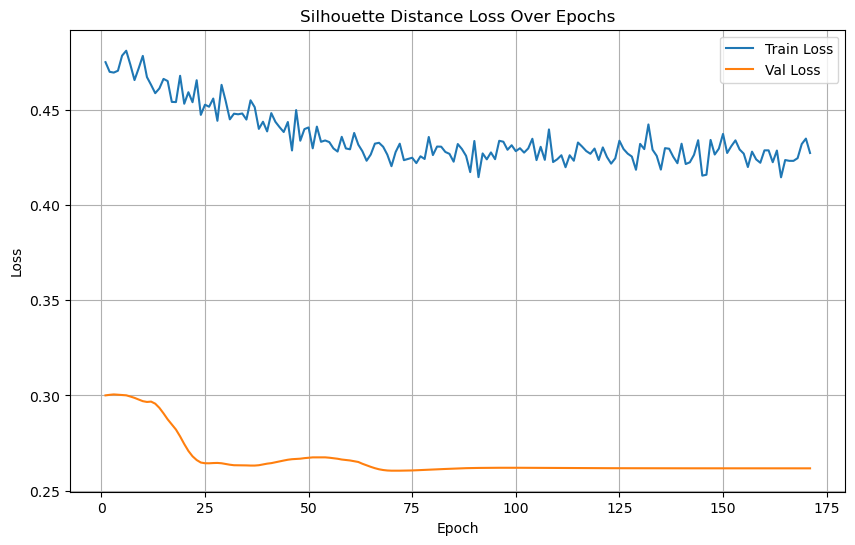

In [51]:
sclsdl_model = SupConNet().to(device)
sclsdl_criterion = SilhouetteDistanceLoss()
sclsdl_optimizer = optim.AdamW(sclsdl_model.parameters(), lr=0.0001, weight_decay=1e-5)
sclsdl_scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    sclsdl_optimizer, 
    mode='min',
    patience=25,
    factor=0.1
)

sclsdl_num_epochs = 2000

sclsdl_patience = 100
sclsdl_best_val_loss = float('inf')
sclsdl_epochs_without_improvement = 0

sclsdl_train_loss_history = []
sclsdl_val_loss_history = []

for sclsdl_epoch in range(sclsdl_num_epochs):
    # Training
    sclsdl_model.train()
    sclsdl_running_train_loss = 0.0
    
    print(f"LOG: Epoch [{sclsdl_epoch+1}/{sclsdl_num_epochs}] - Training")
    for batch_idx, (vectors, labels) in enumerate(sclsdl_train_loader):

        vectors = vectors.to(device).float()
        labels = labels.to(device)

        # Forward pass
        sclsdl_train_projections = sclsdl_model(vectors)

        sclsdl_loss = sclsdl_criterion(sclsdl_train_projections, labels)

        # Backprop and optimize
        sclsdl_optimizer.zero_grad()
        sclsdl_loss.backward()
        sclsdl_optimizer.step()

        sclsdl_running_train_loss += sclsdl_loss.item()
        print(f"    Batch [{batch_idx+1}/{len(sclsdl_train_loader)}], Train Loss: {sclsdl_loss.item():.4f}")

    sclsdl_train_epoch_loss = sclsdl_running_train_loss / len(sclsdl_train_loader)
    sclsdl_train_loss_history.append(sclsdl_train_epoch_loss)

    # Validation
    sclsdl_model.eval()
    sclsdl_running_val_loss = 0.0
    print(f"LOG: Epoch [{sclsdl_epoch+1}/{sclsdl_num_epochs}] - Validation")
    with torch.no_grad():
        for val_batch_idx, (vectors, labels) in enumerate(sclsdl_val_loader):

            vectors = vectors.to(device).float()
            labels = labels.to(device)

            sclsdl_val_projections = sclsdl_model(vectors)
            sclsdl_val_batch_loss = sclsdl_criterion(sclsdl_val_projections, labels).item()
            sclsdl_running_val_loss += sclsdl_val_batch_loss
            print(f"    Batch [{val_batch_idx+1}/{len(sclsdl_val_loader)}], Val Loss: {sclsdl_val_batch_loss:.4f}")

    sclsdl_val_epoch_loss = sclsdl_running_val_loss / len(sclsdl_val_loader)
    sclsdl_val_loss_history.append(sclsdl_val_epoch_loss)
    
    sclsdl_scheduler.step(sclsdl_val_epoch_loss)

    print(f"Epoch [{sclsdl_epoch+1}/{sclsdl_num_epochs}], "
          f"Avg Train Loss: {sclsdl_train_epoch_loss:.4f}, "
          f"Avg Val Loss: {sclsdl_val_epoch_loss:.4f}\n")
    
    #early stopping logic
    if sclsdl_val_epoch_loss < sclsdl_best_val_loss:
        print(f"Validation loss improved from {sclsdl_best_val_loss:.4f} to {sclsdl_val_epoch_loss:.4f}. Saving model...")
        sclsdl_best_val_loss = sclsdl_val_epoch_loss
        sclsdl_epochs_without_improvement = 0
    else:
        sclsdl_epochs_without_improvement += 1
        print(f"!! Validation loss did NOT improve !! Patience: {sclsdl_epochs_without_improvement}/{sclsdl_patience}")

    #stop training if val loss not improving
    if sclsdl_epochs_without_improvement >= sclsdl_patience:
        print(f"!! Early stopping triggered at epoch {sclsdl_epoch + 1}!!\nNo improvement for {sclsdl_patience} epochs")
        break

plt.figure(figsize=(10,6))
sclsdl_num_epochs_run = len(sclsdl_train_loss_history)
plt.plot(range(1, sclsdl_num_epochs_run + 1), sclsdl_train_loss_history, label='Train Loss')
plt.plot(range(1, sclsdl_num_epochs_run + 1), sclsdl_val_loss_history, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Silhouette Distance Loss Over Epochs')
plt.legend()
plt.grid(True)
plt.show()

Test Batch [10/49], Loss: 0.1865
Test Batch [20/49], Loss: 0.2259


Test Batch [30/49], Loss: 0.3031
Test Batch [40/49], Loss: 0.2153

Test Loss: 0.3114


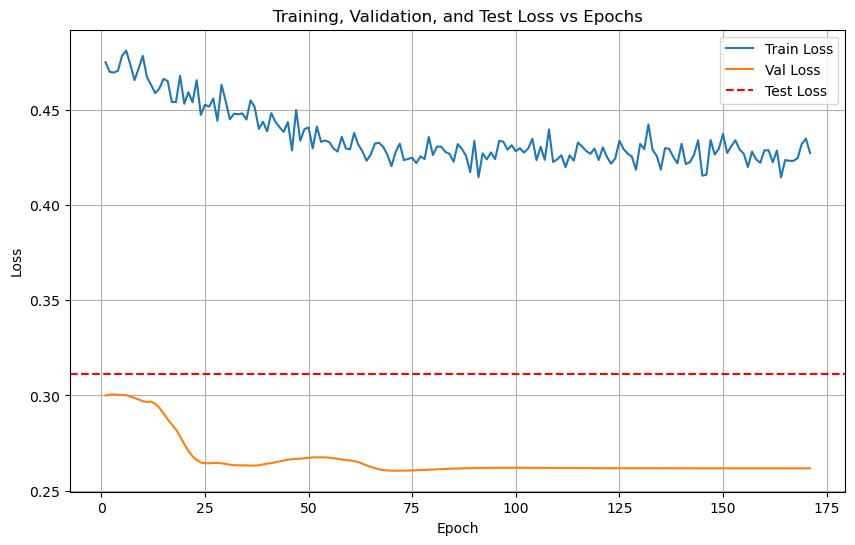

In [52]:
# Test Evaluation
sclsdl_model.eval()
sclsdl_total_test_loss = 0.0

with torch.no_grad():
    for batch_idx, (vectors, labels) in enumerate(sclsdl_test_loader):
        vectors = vectors.to(device).float()
        labels = labels.to(device)
        projections = sclsdl_model(vectors)
        loss = sclsdl_criterion(projections, labels)
        sclsdl_total_test_loss += loss.item()
        if (batch_idx + 1) % 10 == 0:
            print(f"Test Batch [{batch_idx + 1}/{len(sclsdl_test_loader)}], Loss: {loss.item():.4f}")

sclsdl_avg_test_loss = sclsdl_total_test_loss / len(sclsdl_test_loader)
print(f"\nTest Loss: {sclsdl_avg_test_loss:.4f}")


plt.figure(figsize=(10, 6))
sclsdl_num_epochs_run = len(sclsdl_train_loss_history)
plt.plot(range(1, sclsdl_num_epochs_run + 1), sclsdl_train_loss_history, label='Train Loss')
plt.plot(range(1, sclsdl_num_epochs_run + 1), sclsdl_val_loss_history, label='Val Loss')
# test loss = horizontal dashed line
plt.axhline(y=sclsdl_avg_test_loss, color='r', linestyle='--', label="Test Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training, Validation, and Test Loss vs Epochs")
plt.legend()
plt.grid(True)
plt.show()

### Saving the representations learnt by SCL w/ SDL Model

In [53]:
# dir to save the SCL representations
sclsdl_rep_dir = "sclsdl_representations"
os.makedirs(sclsdl_rep_dir, exist_ok=True)

sclsdl_loaders = {
    'train': sclsdl_train_loader,
    'val': sclsdl_val_loader,
    'test': sclsdl_test_loader
}

sclsdl_model.eval()

with torch.no_grad():
    for sclsdl_split_name, sclsdl_loader in sclsdl_loaders.items():
        print(f"\nExtracting SCL_SDL representations for the {sclsdl_split_name} dataset...")
        # creating subfolder for the split
        sclsdl_split_dir = os.path.join(sclsdl_rep_dir, sclsdl_split_name)
        os.makedirs(sclsdl_split_dir, exist_ok=True)
        
        # processing the data batch-wise
        for sclsdl_batch_idx, (sclsdl_vectors, sclsdl_labels) in enumerate(sclsdl_loader):
            sclsdl_vectors = sclsdl_vectors.to(device).float()
            # computing projections using the trained SCL model
            sclsdl_projections = sclsdl_model(sclsdl_vectors)
            
            # converting projections and labels to np arrays
            sclsdl_projections_np = sclsdl_projections.cpu().numpy()
            sclsdl_labels_np = sclsdl_labels.cpu().numpy()
            
            # saving the batch projections and labels
            np.save(os.path.join(sclsdl_split_dir, f"scl_encoded_batch_{sclsdl_batch_idx}.npy"), sclsdl_projections_np)
            np.save(os.path.join(sclsdl_split_dir, f"scl_labels_batch_{sclsdl_batch_idx}.npy"), sclsdl_labels_np)
            
            if (sclsdl_batch_idx + 1) % 10 == 0:
                print(f"  Processed batch {sclsdl_batch_idx + 1}/{len(sclsdl_loader)} for {sclsdl_split_name} dataset.")

        print(f"Completed extraction for the {sclsdl_split_name} dataset. Representations saved in '{sclsdl_split_dir}'.")

print("SCL representations extraction complete.")


Extracting SCL_SDL representations for the train dataset...
Completed extraction for the train dataset. Representations saved in 'sclsdl_representations\train'.

Extracting SCL_SDL representations for the val dataset...
Completed extraction for the val dataset. Representations saved in 'sclsdl_representations\val'.

Extracting SCL_SDL representations for the test dataset...


  Processed batch 10/49 for test dataset.
  Processed batch 20/49 for test dataset.


  Processed batch 30/49 for test dataset.


  Processed batch 40/49 for test dataset.
Completed extraction for the test dataset. Representations saved in 'sclsdl_representations\test'.
SCL representations extraction complete.


### Classifying the representations learnt by SCL w/ SDL Model with LRM

In [54]:
def load_sclsdl_reps_and_labels(split_dir):
    #gather all the scl_encoded_batch npy files in sorted order
    sclsdl_rep_files = sorted(glob.glob(os.path.join(split_dir, "scl_encoded_batch_*.npy")))

    sclsdl_all_reps = []
    sclsdl_all_labels = []

    for sclsdl_rep_file in sclsdl_rep_files:
        #deriving label filenames
        sclsdl_label_file = sclsdl_rep_file.replace("scl_encoded_batch_", "scl_labels_batch_")

        sclsdl_reps = np.load(sclsdl_rep_file)
        sclsdl_labels = np.load(sclsdl_label_file)

        sclsdl_all_reps.append(sclsdl_reps)
        sclsdl_all_labels.append(sclsdl_labels)

    #concat along first dim
    sclsdl_all_reps = np.concatenate(sclsdl_all_reps, axis = 0)
    sclsdl_all_labels = np.concatenate(sclsdl_all_labels, axis = 0)

    return sclsdl_all_reps, sclsdl_all_labels

In [55]:
sclsdl_lrm_train_dir = os.path.join("sclsdl_representations", "train")
sclsdl_lrm_val_dir   = os.path.join("sclsdl_representations", "val")
sclsdl_lrm_test_dir  = os.path.join("sclsdl_representations", "test")

sclsdl_lrm_train_reps, sclsdl_lrm_train_labels = load_sclsdl_reps_and_labels(sclsdl_lrm_train_dir)
sclsdl_lrm_val_reps, sclsdl_lrm_val_labels = load_sclsdl_reps_and_labels(sclsdl_lrm_val_dir)
sclsdl_lrm_test_reps, sclsdl_lrm_test_labels = load_sclsdl_reps_and_labels(sclsdl_lrm_test_dir)

print("Train reps shape:", sclsdl_lrm_train_reps.shape)
print("Train labels shape:", sclsdl_lrm_train_labels.shape)

print("Val reps shape:", sclsdl_lrm_val_reps.shape)
print("Val labels shape:", sclsdl_lrm_val_labels.shape)

print("Test reps shape:", sclsdl_lrm_test_reps.shape)
print("Test labels shape:", sclsdl_lrm_test_labels.shape)

Train reps shape: (70, 128)
Train labels shape: (70,)
Val reps shape: (70, 128)
Val labels shape: (70,)
Test reps shape: (3108, 128)
Test labels shape: (3108,)


In [56]:
# Train Logistic Regression Model on the SCLSDL representations
print("\nLOG: Training Logistic Regression model on SCL SDL representations...")
sclsdl_logistic_clf = LogisticRegression(max_iter=5000, random_state=42, class_weight='balanced')
sclsdl_logistic_clf.fit(sclsdl_lrm_train_reps, sclsdl_lrm_train_labels)
print("LOG: Logistic Regression training complete.")

# Evaluate on Validation Set
print("\nLOG: Evaluating on the validation set...")
sclsdl_lrm_val_predictions = sclsdl_logistic_clf.predict(sclsdl_lrm_val_reps)
sclsdl_lrm_val_accuracy = accuracy_score(sclsdl_lrm_val_labels, sclsdl_lrm_val_predictions)
print(f"Validation Accuracy: {sclsdl_lrm_val_accuracy * 100:.2f}%")
print("\nValidation Classification Report:\n", classification_report(sclsdl_lrm_val_labels, sclsdl_lrm_val_predictions))

# Evaluate on Test Set
print("\nLOG: Evaluating on the test set...")
sclsdl_lrm_test_predictions = sclsdl_logistic_clf.predict(sclsdl_lrm_test_reps)
sclsdl_lrm_test_accuracy = accuracy_score(sclsdl_lrm_test_labels, sclsdl_lrm_test_predictions)
print(f"Test Accuracy: {sclsdl_lrm_test_accuracy * 100:.2f}%")
print("\nTest Classification Report:\n", classification_report(sclsdl_lrm_test_labels, sclsdl_lrm_test_predictions))

np.save(os.path.join(predictions_dir, 'sclsdl_lrm_predictions.npy'), sclsdl_lrm_test_predictions)
np.save(os.path.join(predictions_dir, 'sclsdl_lrm_true_labels.npy'), sclsdl_lrm_test_labels)
print(f"Saved SCL_SDL+LRM predictions and true labels to {predictions_dir}")


LOG: Training Logistic Regression model on SCL SDL representations...
LOG: Logistic Regression training complete.

LOG: Evaluating on the validation set...
Validation Accuracy: 81.43%

Validation Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         5
           1       1.00      1.00      1.00         5
           2       1.00      0.60      0.75         5
           3       0.71      1.00      0.83         5
           4       1.00      0.40      0.57         5
           5       0.80      0.80      0.80         5
           6       0.83      1.00      0.91         5
           7       0.50      0.20      0.29         5
           8       0.71      1.00      0.83         5
           9       1.00      0.60      0.75         5
          10       0.83      1.00      0.91         5
          11       0.56      1.00      0.71         5
          12       0.80      0.80      0.80         5
          13       1.0

## Classifying the representations learnt by SCL w/ SDL Model with MLP Classifier

In [57]:
sclsdl_mlp_train_dir = os.path.join("sclsdl_representations", "train")
sclsdl_mlp_val_dir   = os.path.join("sclsdl_representations", "val")
sclsdl_mlp_test_dir  = os.path.join("sclsdl_representations", "test")

sclsdl_mlp_train_reps, sclsdl_mlp_train_labels = load_sclsdl_reps_and_labels(sclsdl_mlp_train_dir)
sclsdl_mlp_val_reps, sclsdl_mlp_val_labels = load_sclsdl_reps_and_labels(sclsdl_mlp_val_dir)
sclsdl_mlp_test_reps, sclsdl_mlp_test_labels = load_sclsdl_reps_and_labels(sclsdl_mlp_test_dir)

print("Train reps shape:", sclsdl_mlp_train_reps.shape)
print("Train labels shape:", sclsdl_mlp_train_labels.shape)

print("Val reps shape:", sclsdl_mlp_val_reps.shape)
print("Val labels shape:", sclsdl_mlp_val_labels.shape)

print("Test reps shape:", sclsdl_mlp_test_reps.shape)
print("Test labels shape:", sclsdl_mlp_test_labels.shape)

Train reps shape: (70, 128)
Train labels shape: (70,)
Val reps shape: (70, 128)
Val labels shape: (70,)
Test reps shape: (3108, 128)
Test labels shape: (3108,)


In [58]:
#converting arrays to torch tensors
sclsdl_mlp_train_embeddings_torch = torch.tensor(sclsdl_mlp_train_reps, dtype=torch.float32)
sclsdl_mlp_train_labels_torch = torch.tensor(sclsdl_mlp_train_labels, dtype=torch.long)

sclsdl_mlp_val_embeddings_torch = torch.tensor(sclsdl_mlp_val_reps, dtype=torch.float32)
sclsdl_mlp_val_labels_torch = torch.tensor(sclsdl_mlp_val_labels, dtype=torch.long)

sclsdl_mlp_test_embeddings_torch = torch.tensor(sclsdl_mlp_test_reps, dtype=torch.float32)
sclsdl_mlp_test_labels_torch = torch.tensor(sclsdl_mlp_test_labels, dtype=torch.long)

#building datasets for mlp
sclsdl_mlp_train_dataset = TensorDataset(sclsdl_mlp_train_embeddings_torch, sclsdl_mlp_train_labels_torch)
sclsdl_mlp_val_dataset = TensorDataset(sclsdl_mlp_val_embeddings_torch, sclsdl_mlp_val_labels_torch)
sclsdl_mlp_test_dataset = TensorDataset(sclsdl_mlp_test_embeddings_torch, sclsdl_mlp_test_labels_torch)

sclsdl_mlp_batch_size = 64
sclsdl_mlp_train_loader = DataLoader(sclsdl_mlp_train_dataset, batch_size=sclsdl_mlp_batch_size, shuffle=True)
sclsdl_mlp_val_loader = DataLoader(sclsdl_mlp_val_dataset, batch_size=sclsdl_mlp_batch_size, shuffle=False)
sclsdl_mlp_test_loader = DataLoader(sclsdl_mlp_test_dataset, batch_size=sclsdl_mlp_batch_size, shuffle=False)


[Epoch 1/1000] Train Loss: 2.6818  |  Val Loss: 2.6476
Validation loss improved from inf to 2.6476.
[Epoch 2/1000] Train Loss: 2.6727  |  Val Loss: 2.6414
Validation loss improved from 2.6476 to 2.6414.
[Epoch 3/1000] Train Loss: 2.6649  |  Val Loss: 2.6356
Validation loss improved from 2.6414 to 2.6356.
[Epoch 4/1000] Train Loss: 2.6582  |  Val Loss: 2.6301
Validation loss improved from 2.6356 to 2.6301.
[Epoch 5/1000] Train Loss: 2.6514  |  Val Loss: 2.6247
Validation loss improved from 2.6301 to 2.6247.
[Epoch 6/1000] Train Loss: 2.6446  |  Val Loss: 2.6192
Validation loss improved from 2.6247 to 2.6192.
[Epoch 7/1000] Train Loss: 2.6382  |  Val Loss: 2.6138
Validation loss improved from 2.6192 to 2.6138.
[Epoch 8/1000] Train Loss: 2.6318  |  Val Loss: 2.6084
Validation loss improved from 2.6138 to 2.6084.
[Epoch 9/1000] Train Loss: 2.6256  |  Val Loss: 2.6031
Validation loss improved from 2.6084 to 2.6031.
[Epoch 10/1000] Train Loss: 2.6191  |  Val Loss: 2.5977
Validation loss impr

[Epoch 23/1000] Train Loss: 2.5457  |  Val Loss: 2.5341
Validation loss improved from 2.5385 to 2.5341.
[Epoch 24/1000] Train Loss: 2.5407  |  Val Loss: 2.5298
Validation loss improved from 2.5341 to 2.5298.
[Epoch 25/1000] Train Loss: 2.5357  |  Val Loss: 2.5255
Validation loss improved from 2.5298 to 2.5255.
[Epoch 26/1000] Train Loss: 2.5308  |  Val Loss: 2.5211
Validation loss improved from 2.5255 to 2.5211.
[Epoch 27/1000] Train Loss: 2.5261  |  Val Loss: 2.5167
Validation loss improved from 2.5211 to 2.5167.
[Epoch 28/1000] Train Loss: 2.5210  |  Val Loss: 2.5126
Validation loss improved from 2.5167 to 2.5126.
[Epoch 29/1000] Train Loss: 2.5162  |  Val Loss: 2.5083
Validation loss improved from 2.5126 to 2.5083.
[Epoch 30/1000] Train Loss: 2.5117  |  Val Loss: 2.5039
Validation loss improved from 2.5083 to 2.5039.
[Epoch 31/1000] Train Loss: 2.5065  |  Val Loss: 2.4994
Validation loss improved from 2.5039 to 2.4994.
[Epoch 32/1000] Train Loss: 2.5015  |  Val Loss: 2.4949
Validati

[Epoch 35/1000] Train Loss: 2.4868  |  Val Loss: 2.4819
Validation loss improved from 2.4861 to 2.4819.
[Epoch 36/1000] Train Loss: 2.4821  |  Val Loss: 2.4777
Validation loss improved from 2.4819 to 2.4777.
[Epoch 37/1000] Train Loss: 2.4774  |  Val Loss: 2.4737
Validation loss improved from 2.4777 to 2.4737.
[Epoch 38/1000] Train Loss: 2.4728  |  Val Loss: 2.4695
Validation loss improved from 2.4737 to 2.4695.
[Epoch 39/1000] Train Loss: 2.4681  |  Val Loss: 2.4652
Validation loss improved from 2.4695 to 2.4652.
[Epoch 40/1000] Train Loss: 2.4635  |  Val Loss: 2.4607
Validation loss improved from 2.4652 to 2.4607.
[Epoch 41/1000] Train Loss: 2.4586  |  Val Loss: 2.4563
Validation loss improved from 2.4607 to 2.4563.
[Epoch 42/1000] Train Loss: 2.4538  |  Val Loss: 2.4519
Validation loss improved from 2.4563 to 2.4519.
[Epoch 43/1000] Train Loss: 2.4489  |  Val Loss: 2.4478
Validation loss improved from 2.4519 to 2.4478.
[Epoch 44/1000] Train Loss: 2.4443  |  Val Loss: 2.4437
Validati

[Epoch 63/1000] Train Loss: 2.3564  |  Val Loss: 2.3639
Validation loss improved from 2.3683 to 2.3639.
[Epoch 64/1000] Train Loss: 2.3514  |  Val Loss: 2.3596
Validation loss improved from 2.3639 to 2.3596.
[Epoch 65/1000] Train Loss: 2.3469  |  Val Loss: 2.3553
Validation loss improved from 2.3596 to 2.3553.
[Epoch 66/1000] Train Loss: 2.3421  |  Val Loss: 2.3511
Validation loss improved from 2.3553 to 2.3511.
[Epoch 67/1000] Train Loss: 2.3375  |  Val Loss: 2.3469
Validation loss improved from 2.3511 to 2.3469.
[Epoch 68/1000] Train Loss: 2.3329  |  Val Loss: 2.3427
Validation loss improved from 2.3469 to 2.3427.
[Epoch 69/1000] Train Loss: 2.3284  |  Val Loss: 2.3385
Validation loss improved from 2.3427 to 2.3385.
[Epoch 70/1000] Train Loss: 2.3239  |  Val Loss: 2.3346
Validation loss improved from 2.3385 to 2.3346.
[Epoch 71/1000] Train Loss: 2.3196  |  Val Loss: 2.3307
Validation loss improved from 2.3346 to 2.3307.


[Epoch 72/1000] Train Loss: 2.3154  |  Val Loss: 2.3270
Validation loss improved from 2.3307 to 2.3270.
[Epoch 73/1000] Train Loss: 2.3113  |  Val Loss: 2.3233
Validation loss improved from 2.3270 to 2.3233.
[Epoch 74/1000] Train Loss: 2.3072  |  Val Loss: 2.3196
Validation loss improved from 2.3233 to 2.3196.
[Epoch 75/1000] Train Loss: 2.3032  |  Val Loss: 2.3159
Validation loss improved from 2.3196 to 2.3159.
[Epoch 76/1000] Train Loss: 2.2990  |  Val Loss: 2.3121
Validation loss improved from 2.3159 to 2.3121.
[Epoch 77/1000] Train Loss: 2.2949  |  Val Loss: 2.3081
Validation loss improved from 2.3121 to 2.3081.
[Epoch 78/1000] Train Loss: 2.2903  |  Val Loss: 2.3041
Validation loss improved from 2.3081 to 2.3041.
[Epoch 79/1000] Train Loss: 2.2858  |  Val Loss: 2.3001
Validation loss improved from 2.3041 to 2.3001.
[Epoch 80/1000] Train Loss: 2.2812  |  Val Loss: 2.2960
Validation loss improved from 2.3001 to 2.2960.
[Epoch 81/1000] Train Loss: 2.2766  |  Val Loss: 2.2921
Validati

[Epoch 107/1000] Train Loss: 2.1501  |  Val Loss: 2.1783
Validation loss improved from 2.1832 to 2.1783.
[Epoch 108/1000] Train Loss: 2.1449  |  Val Loss: 2.1735
Validation loss improved from 2.1783 to 2.1735.
[Epoch 109/1000] Train Loss: 2.1394  |  Val Loss: 2.1686
Validation loss improved from 2.1735 to 2.1686.
[Epoch 110/1000] Train Loss: 2.1343  |  Val Loss: 2.1639
Validation loss improved from 2.1686 to 2.1639.
[Epoch 111/1000] Train Loss: 2.1290  |  Val Loss: 2.1592
Validation loss improved from 2.1639 to 2.1592.
[Epoch 112/1000] Train Loss: 2.1238  |  Val Loss: 2.1544
Validation loss improved from 2.1592 to 2.1544.
[Epoch 113/1000] Train Loss: 2.1185  |  Val Loss: 2.1496
Validation loss improved from 2.1544 to 2.1496.


[Epoch 114/1000] Train Loss: 2.1130  |  Val Loss: 2.1448
Validation loss improved from 2.1496 to 2.1448.
[Epoch 115/1000] Train Loss: 2.1077  |  Val Loss: 2.1401
Validation loss improved from 2.1448 to 2.1401.
[Epoch 116/1000] Train Loss: 2.1022  |  Val Loss: 2.1354
Validation loss improved from 2.1401 to 2.1354.
[Epoch 117/1000] Train Loss: 2.0969  |  Val Loss: 2.1308
Validation loss improved from 2.1354 to 2.1308.
[Epoch 118/1000] Train Loss: 2.0916  |  Val Loss: 2.1262
Validation loss improved from 2.1308 to 2.1262.
[Epoch 119/1000] Train Loss: 2.0862  |  Val Loss: 2.1213
Validation loss improved from 2.1262 to 2.1213.
[Epoch 120/1000] Train Loss: 2.0808  |  Val Loss: 2.1162
Validation loss improved from 2.1213 to 2.1162.
[Epoch 121/1000] Train Loss: 2.0748  |  Val Loss: 2.1108
Validation loss improved from 2.1162 to 2.1108.
[Epoch 122/1000] Train Loss: 2.0689  |  Val Loss: 2.1052
Validation loss improved from 2.1108 to 2.1052.
[Epoch 123/1000] Train Loss: 2.0630  |  Val Loss: 2.099

[Epoch 147/1000] Train Loss: 1.9146  |  Val Loss: 1.9686
Validation loss improved from 1.9739 to 1.9686.
[Epoch 148/1000] Train Loss: 1.9083  |  Val Loss: 1.9633
Validation loss improved from 1.9686 to 1.9633.
[Epoch 149/1000] Train Loss: 1.9021  |  Val Loss: 1.9580
Validation loss improved from 1.9633 to 1.9580.
[Epoch 150/1000] Train Loss: 1.8961  |  Val Loss: 1.9527
Validation loss improved from 1.9580 to 1.9527.
[Epoch 151/1000] Train Loss: 1.8899  |  Val Loss: 1.9472
Validation loss improved from 1.9527 to 1.9472.
[Epoch 152/1000] Train Loss: 1.8839  |  Val Loss: 1.9416
Validation loss improved from 1.9472 to 1.9416.
[Epoch 153/1000] Train Loss: 1.8776  |  Val Loss: 1.9360
Validation loss improved from 1.9416 to 1.9360.
[Epoch 154/1000] Train Loss: 1.8713  |  Val Loss: 1.9305
Validation loss improved from 1.9360 to 1.9305.
[Epoch 155/1000] Train Loss: 1.8649  |  Val Loss: 1.9249
Validation loss improved from 1.9305 to 1.9249.


[Epoch 156/1000] Train Loss: 1.8584  |  Val Loss: 1.9191
Validation loss improved from 1.9249 to 1.9191.
[Epoch 157/1000] Train Loss: 1.8518  |  Val Loss: 1.9134
Validation loss improved from 1.9191 to 1.9134.
[Epoch 158/1000] Train Loss: 1.8452  |  Val Loss: 1.9076
Validation loss improved from 1.9134 to 1.9076.
[Epoch 159/1000] Train Loss: 1.8386  |  Val Loss: 1.9018
Validation loss improved from 1.9076 to 1.9018.
[Epoch 160/1000] Train Loss: 1.8320  |  Val Loss: 1.8958
Validation loss improved from 1.9018 to 1.8958.
[Epoch 161/1000] Train Loss: 1.8252  |  Val Loss: 1.8899
Validation loss improved from 1.8958 to 1.8899.
[Epoch 162/1000] Train Loss: 1.8185  |  Val Loss: 1.8843
Validation loss improved from 1.8899 to 1.8843.
[Epoch 163/1000] Train Loss: 1.8123  |  Val Loss: 1.8788
Validation loss improved from 1.8843 to 1.8788.
[Epoch 164/1000] Train Loss: 1.8060  |  Val Loss: 1.8732
Validation loss improved from 1.8788 to 1.8732.
[Epoch 165/1000] Train Loss: 1.7993  |  Val Loss: 1.867

[Epoch 187/1000] Train Loss: 1.6485  |  Val Loss: 1.7315
Validation loss improved from 1.7380 to 1.7315.
[Epoch 188/1000] Train Loss: 1.6416  |  Val Loss: 1.7249
Validation loss improved from 1.7315 to 1.7249.
[Epoch 189/1000] Train Loss: 1.6344  |  Val Loss: 1.7184
Validation loss improved from 1.7249 to 1.7184.
[Epoch 190/1000] Train Loss: 1.6271  |  Val Loss: 1.7119
Validation loss improved from 1.7184 to 1.7119.
[Epoch 191/1000] Train Loss: 1.6202  |  Val Loss: 1.7056
Validation loss improved from 1.7119 to 1.7056.
[Epoch 192/1000] Train Loss: 1.6130  |  Val Loss: 1.6994
Validation loss improved from 1.7056 to 1.6994.
[Epoch 193/1000] Train Loss: 1.6060  |  Val Loss: 1.6932
Validation loss improved from 1.6994 to 1.6932.
[Epoch 194/1000] Train Loss: 1.5990  |  Val Loss: 1.6870
Validation loss improved from 1.6932 to 1.6870.


[Epoch 195/1000] Train Loss: 1.5921  |  Val Loss: 1.6807
Validation loss improved from 1.6870 to 1.6807.
[Epoch 196/1000] Train Loss: 1.5853  |  Val Loss: 1.6744
Validation loss improved from 1.6807 to 1.6744.
[Epoch 197/1000] Train Loss: 1.5782  |  Val Loss: 1.6681
Validation loss improved from 1.6744 to 1.6681.
[Epoch 198/1000] Train Loss: 1.5714  |  Val Loss: 1.6617
Validation loss improved from 1.6681 to 1.6617.
[Epoch 199/1000] Train Loss: 1.5643  |  Val Loss: 1.6555
Validation loss improved from 1.6617 to 1.6555.
[Epoch 200/1000] Train Loss: 1.5574  |  Val Loss: 1.6493
Validation loss improved from 1.6555 to 1.6493.
[Epoch 201/1000] Train Loss: 1.5508  |  Val Loss: 1.6429
Validation loss improved from 1.6493 to 1.6429.
[Epoch 202/1000] Train Loss: 1.5440  |  Val Loss: 1.6366
Validation loss improved from 1.6429 to 1.6366.
[Epoch 203/1000] Train Loss: 1.5372  |  Val Loss: 1.6304
Validation loss improved from 1.6366 to 1.6304.
[Epoch 204/1000] Train Loss: 1.5303  |  Val Loss: 1.624

[Epoch 227/1000] Train Loss: 1.3765  |  Val Loss: 1.4959
Validation loss improved from 1.5011 to 1.4959.
[Epoch 228/1000] Train Loss: 1.3701  |  Val Loss: 1.4908
Validation loss improved from 1.4959 to 1.4908.
[Epoch 229/1000] Train Loss: 1.3636  |  Val Loss: 1.4858
Validation loss improved from 1.4908 to 1.4858.
[Epoch 230/1000] Train Loss: 1.3575  |  Val Loss: 1.4807
Validation loss improved from 1.4858 to 1.4807.
[Epoch 231/1000] Train Loss: 1.3513  |  Val Loss: 1.4754
Validation loss improved from 1.4807 to 1.4754.
[Epoch 232/1000] Train Loss: 1.3450  |  Val Loss: 1.4699
Validation loss improved from 1.4754 to 1.4699.
[Epoch 233/1000] Train Loss: 1.3388  |  Val Loss: 1.4646
Validation loss improved from 1.4699 to 1.4646.
[Epoch 234/1000] Train Loss: 1.3325  |  Val Loss: 1.4592
Validation loss improved from 1.4646 to 1.4592.
[Epoch 235/1000] Train Loss: 1.3262  |  Val Loss: 1.4536
Validation loss improved from 1.4592 to 1.4536.
[Epoch 236/1000] Train Loss: 1.3196  |  Val Loss: 1.447

[Epoch 239/1000] Train Loss: 1.3003  |  Val Loss: 1.4307
Validation loss improved from 1.4362 to 1.4307.
[Epoch 240/1000] Train Loss: 1.2939  |  Val Loss: 1.4251
Validation loss improved from 1.4307 to 1.4251.
[Epoch 241/1000] Train Loss: 1.2875  |  Val Loss: 1.4194
Validation loss improved from 1.4251 to 1.4194.
[Epoch 242/1000] Train Loss: 1.2812  |  Val Loss: 1.4136
Validation loss improved from 1.4194 to 1.4136.
[Epoch 243/1000] Train Loss: 1.2747  |  Val Loss: 1.4079
Validation loss improved from 1.4136 to 1.4079.
[Epoch 244/1000] Train Loss: 1.2681  |  Val Loss: 1.4022
Validation loss improved from 1.4079 to 1.4022.
[Epoch 245/1000] Train Loss: 1.2618  |  Val Loss: 1.3969
Validation loss improved from 1.4022 to 1.3969.
[Epoch 246/1000] Train Loss: 1.2558  |  Val Loss: 1.3919
Validation loss improved from 1.3969 to 1.3919.
[Epoch 247/1000] Train Loss: 1.2496  |  Val Loss: 1.3869
Validation loss improved from 1.3919 to 1.3869.
[Epoch 248/1000] Train Loss: 1.2435  |  Val Loss: 1.382

[Epoch 269/1000] Train Loss: 1.1179  |  Val Loss: 1.2759
Validation loss improved from 1.2806 to 1.2759.
[Epoch 270/1000] Train Loss: 1.1122  |  Val Loss: 1.2713
Validation loss improved from 1.2759 to 1.2713.
[Epoch 271/1000] Train Loss: 1.1066  |  Val Loss: 1.2665
Validation loss improved from 1.2713 to 1.2665.
[Epoch 272/1000] Train Loss: 1.1009  |  Val Loss: 1.2616
Validation loss improved from 1.2665 to 1.2616.
[Epoch 273/1000] Train Loss: 1.0952  |  Val Loss: 1.2564
Validation loss improved from 1.2616 to 1.2564.
[Epoch 274/1000] Train Loss: 1.0895  |  Val Loss: 1.2510
Validation loss improved from 1.2564 to 1.2510.
[Epoch 275/1000] Train Loss: 1.0837  |  Val Loss: 1.2456
Validation loss improved from 1.2510 to 1.2456.
[Epoch 276/1000] Train Loss: 1.0780  |  Val Loss: 1.2405
Validation loss improved from 1.2456 to 1.2405.


[Epoch 277/1000] Train Loss: 1.0726  |  Val Loss: 1.2357
Validation loss improved from 1.2405 to 1.2357.
[Epoch 278/1000] Train Loss: 1.0670  |  Val Loss: 1.2310
Validation loss improved from 1.2357 to 1.2310.
[Epoch 279/1000] Train Loss: 1.0614  |  Val Loss: 1.2261
Validation loss improved from 1.2310 to 1.2261.
[Epoch 280/1000] Train Loss: 1.0560  |  Val Loss: 1.2212
Validation loss improved from 1.2261 to 1.2212.
[Epoch 281/1000] Train Loss: 1.0505  |  Val Loss: 1.2165
Validation loss improved from 1.2212 to 1.2165.
[Epoch 282/1000] Train Loss: 1.0447  |  Val Loss: 1.2119
Validation loss improved from 1.2165 to 1.2119.
[Epoch 283/1000] Train Loss: 1.0390  |  Val Loss: 1.2072
Validation loss improved from 1.2119 to 1.2072.
[Epoch 284/1000] Train Loss: 1.0337  |  Val Loss: 1.2023
Validation loss improved from 1.2072 to 1.2023.
[Epoch 285/1000] Train Loss: 1.0280  |  Val Loss: 1.1974
Validation loss improved from 1.2023 to 1.1974.
[Epoch 286/1000] Train Loss: 1.0226  |  Val Loss: 1.192

[Epoch 312/1000] Train Loss: 0.8894  |  Val Loss: 1.0898
Validation loss improved from 1.0929 to 1.0898.
[Epoch 313/1000] Train Loss: 0.8848  |  Val Loss: 1.0869
Validation loss improved from 1.0898 to 1.0869.
[Epoch 314/1000] Train Loss: 0.8801  |  Val Loss: 1.0836
Validation loss improved from 1.0869 to 1.0836.
[Epoch 315/1000] Train Loss: 0.8756  |  Val Loss: 1.0799
Validation loss improved from 1.0836 to 1.0799.
[Epoch 316/1000] Train Loss: 0.8710  |  Val Loss: 1.0765
Validation loss improved from 1.0799 to 1.0765.
[Epoch 317/1000] Train Loss: 0.8663  |  Val Loss: 1.0734
Validation loss improved from 1.0765 to 1.0734.
[Epoch 318/1000] Train Loss: 0.8619  |  Val Loss: 1.0700
Validation loss improved from 1.0734 to 1.0700.
[Epoch 319/1000] Train Loss: 0.8573  |  Val Loss: 1.0664
Validation loss improved from 1.0700 to 1.0664.
[Epoch 320/1000] Train Loss: 0.8528  |  Val Loss: 1.0631
Validation loss improved from 1.0664 to 1.0631.
[Epoch 321/1000] Train Loss: 0.8484  |  Val Loss: 1.060

[Epoch 352/1000] Train Loss: 0.7173  |  Val Loss: 0.9439
Validation loss improved from 0.9472 to 0.9439.
[Epoch 353/1000] Train Loss: 0.7138  |  Val Loss: 0.9404
Validation loss improved from 0.9439 to 0.9404.
[Epoch 354/1000] Train Loss: 0.7105  |  Val Loss: 0.9373
Validation loss improved from 0.9404 to 0.9373.
[Epoch 355/1000] Train Loss: 0.7071  |  Val Loss: 0.9345
Validation loss improved from 0.9373 to 0.9345.
[Epoch 356/1000] Train Loss: 0.7036  |  Val Loss: 0.9317
Validation loss improved from 0.9345 to 0.9317.
[Epoch 357/1000] Train Loss: 0.7001  |  Val Loss: 0.9293
Validation loss improved from 0.9317 to 0.9293.
[Epoch 358/1000] Train Loss: 0.6966  |  Val Loss: 0.9271
Validation loss improved from 0.9293 to 0.9271.
[Epoch 359/1000] Train Loss: 0.6928  |  Val Loss: 0.9247
Validation loss improved from 0.9271 to 0.9247.
[Epoch 360/1000] Train Loss: 0.6890  |  Val Loss: 0.9223
Validation loss improved from 0.9247 to 0.9223.
[Epoch 361/1000] Train Loss: 0.6853  |  Val Loss: 0.919

[Epoch 391/1000] Train Loss: 0.5843  |  Val Loss: 0.8509
Validation loss improved from 0.8531 to 0.8509.
[Epoch 392/1000] Train Loss: 0.5810  |  Val Loss: 0.8485
Validation loss improved from 0.8509 to 0.8485.
[Epoch 393/1000] Train Loss: 0.5780  |  Val Loss: 0.8459
Validation loss improved from 0.8485 to 0.8459.
[Epoch 394/1000] Train Loss: 0.5747  |  Val Loss: 0.8432
Validation loss improved from 0.8459 to 0.8432.
[Epoch 395/1000] Train Loss: 0.5718  |  Val Loss: 0.8404
Validation loss improved from 0.8432 to 0.8404.
[Epoch 396/1000] Train Loss: 0.5685  |  Val Loss: 0.8370
Validation loss improved from 0.8404 to 0.8370.
[Epoch 397/1000] Train Loss: 0.5654  |  Val Loss: 0.8336
Validation loss improved from 0.8370 to 0.8336.
[Epoch 398/1000] Train Loss: 0.5622  |  Val Loss: 0.8305
Validation loss improved from 0.8336 to 0.8305.
[Epoch 399/1000] Train Loss: 0.5592  |  Val Loss: 0.8276
Validation loss improved from 0.8305 to 0.8276.
[Epoch 400/1000] Train Loss: 0.5562  |  Val Loss: 0.824

[Epoch 430/1000] Train Loss: 0.4776  |  Val Loss: 0.7714
Validation loss improved from 0.7740 to 0.7714.
[Epoch 431/1000] Train Loss: 0.4752  |  Val Loss: 0.7693
Validation loss improved from 0.7714 to 0.7693.
[Epoch 432/1000] Train Loss: 0.4729  |  Val Loss: 0.7675
Validation loss improved from 0.7693 to 0.7675.
[Epoch 433/1000] Train Loss: 0.4705  |  Val Loss: 0.7659
Validation loss improved from 0.7675 to 0.7659.
[Epoch 434/1000] Train Loss: 0.4679  |  Val Loss: 0.7640
Validation loss improved from 0.7659 to 0.7640.
[Epoch 435/1000] Train Loss: 0.4654  |  Val Loss: 0.7619
Validation loss improved from 0.7640 to 0.7619.
[Epoch 436/1000] Train Loss: 0.4629  |  Val Loss: 0.7596
Validation loss improved from 0.7619 to 0.7596.
[Epoch 437/1000] Train Loss: 0.4605  |  Val Loss: 0.7577
Validation loss improved from 0.7596 to 0.7577.
[Epoch 438/1000] Train Loss: 0.4582  |  Val Loss: 0.7562
Validation loss improved from 0.7577 to 0.7562.
[Epoch 439/1000] Train Loss: 0.4560  |  Val Loss: 0.754

[Epoch 475/1000] Train Loss: 0.3807  |  Val Loss: 0.7014
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 476/1000] Train Loss: 0.3788  |  Val Loss: 0.7016
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 477/1000] Train Loss: 0.3768  |  Val Loss: 0.7014
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 478/1000] Train Loss: 0.3751  |  Val Loss: 0.7011
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 479/1000] Train Loss: 0.3732  |  Val Loss: 0.7003
Validation loss improved from 0.7009 to 0.7003.
[Epoch 480/1000] Train Loss: 0.3714  |  Val Loss: 0.6991
Validation loss improved from 0.7003 to 0.6991.
[Epoch 481/1000] Train Loss: 0.3698  |  Val Loss: 0.6979
Validation loss improved from 0.6991 to 0.6979.
[Epoch 482/1000] Train Loss: 0.3680  |  Val Loss: 0.6965
Validation loss improved from 0.6979 to 0.6965.
[Epoch 483/1000] Train Loss: 0.3664  |  Val Loss: 0.6950
Validation loss improved from 0.6965 to 0.6950.
[Epoch 484/1000] Train Loss: 0.

[Epoch 515/1000] Train Loss: 0.3144  |  Val Loss: 0.6473
Validation loss improved from 0.6484 to 0.6473.
[Epoch 516/1000] Train Loss: 0.3130  |  Val Loss: 0.6461
Validation loss improved from 0.6473 to 0.6461.
[Epoch 517/1000] Train Loss: 0.3116  |  Val Loss: 0.6445
Validation loss improved from 0.6461 to 0.6445.
[Epoch 518/1000] Train Loss: 0.3101  |  Val Loss: 0.6428
Validation loss improved from 0.6445 to 0.6428.
[Epoch 519/1000] Train Loss: 0.3089  |  Val Loss: 0.6414
Validation loss improved from 0.6428 to 0.6414.
[Epoch 520/1000] Train Loss: 0.3076  |  Val Loss: 0.6402
Validation loss improved from 0.6414 to 0.6402.
[Epoch 521/1000] Train Loss: 0.3063  |  Val Loss: 0.6393
Validation loss improved from 0.6402 to 0.6393.
[Epoch 522/1000] Train Loss: 0.3051  |  Val Loss: 0.6387
Validation loss improved from 0.6393 to 0.6387.
[Epoch 523/1000] Train Loss: 0.3039  |  Val Loss: 0.6384
Validation loss improved from 0.6387 to 0.6384.
[Epoch 524/1000] Train Loss: 0.3023  |  Val Loss: 0.638

[Epoch 557/1000] Train Loss: 0.2586  |  Val Loss: 0.6136
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 558/1000] Train Loss: 0.2576  |  Val Loss: 0.6142
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 559/1000] Train Loss: 0.2565  |  Val Loss: 0.6141
!! Validation loss did NOT improve !! Patience: 10/100
[Epoch 560/1000] Train Loss: 0.2554  |  Val Loss: 0.6134
!! Validation loss did NOT improve !! Patience: 11/100
[Epoch 561/1000] Train Loss: 0.2542  |  Val Loss: 0.6125
!! Validation loss did NOT improve !! Patience: 12/100
[Epoch 562/1000] Train Loss: 0.2532  |  Val Loss: 0.6117
!! Validation loss did NOT improve !! Patience: 13/100
[Epoch 563/1000] Train Loss: 0.2519  |  Val Loss: 0.6110
!! Validation loss did NOT improve !! Patience: 14/100
[Epoch 564/1000] Train Loss: 0.2507  |  Val Loss: 0.6103
Validation loss improved from 0.6105 to 0.6103.
[Epoch 565/1000] Train Loss: 0.2495  |  Val Loss: 0.6097
Validation loss improved from 0.6103 to 0.6097.
[Epoch 5

[Epoch 597/1000] Train Loss: 0.2143  |  Val Loss: 0.5768
Validation loss improved from 0.5780 to 0.5768.
[Epoch 598/1000] Train Loss: 0.2134  |  Val Loss: 0.5760
Validation loss improved from 0.5768 to 0.5760.
[Epoch 599/1000] Train Loss: 0.2124  |  Val Loss: 0.5757
Validation loss improved from 0.5760 to 0.5757.
[Epoch 600/1000] Train Loss: 0.2116  |  Val Loss: 0.5750
Validation loss improved from 0.5757 to 0.5750.
[Epoch 601/1000] Train Loss: 0.2106  |  Val Loss: 0.5737
Validation loss improved from 0.5750 to 0.5737.
[Epoch 602/1000] Train Loss: 0.2097  |  Val Loss: 0.5726
Validation loss improved from 0.5737 to 0.5726.
[Epoch 603/1000] Train Loss: 0.2087  |  Val Loss: 0.5717
Validation loss improved from 0.5726 to 0.5717.
[Epoch 604/1000] Train Loss: 0.2076  |  Val Loss: 0.5711
Validation loss improved from 0.5717 to 0.5711.
[Epoch 605/1000] Train Loss: 0.2065  |  Val Loss: 0.5703
Validation loss improved from 0.5711 to 0.5703.
[Epoch 606/1000] Train Loss: 0.2055  |  Val Loss: 0.569

[Epoch 638/1000] Train Loss: 0.1776  |  Val Loss: 0.5565
Validation loss improved from 0.5576 to 0.5565.
[Epoch 639/1000] Train Loss: 0.1768  |  Val Loss: 0.5548
Validation loss improved from 0.5565 to 0.5548.
[Epoch 640/1000] Train Loss: 0.1759  |  Val Loss: 0.5531
Validation loss improved from 0.5548 to 0.5531.
[Epoch 641/1000] Train Loss: 0.1752  |  Val Loss: 0.5517
Validation loss improved from 0.5531 to 0.5517.
[Epoch 642/1000] Train Loss: 0.1744  |  Val Loss: 0.5507
Validation loss improved from 0.5517 to 0.5507.
[Epoch 643/1000] Train Loss: 0.1738  |  Val Loss: 0.5500
Validation loss improved from 0.5507 to 0.5500.
[Epoch 644/1000] Train Loss: 0.1730  |  Val Loss: 0.5492
Validation loss improved from 0.5500 to 0.5492.
[Epoch 645/1000] Train Loss: 0.1723  |  Val Loss: 0.5485
Validation loss improved from 0.5492 to 0.5485.
[Epoch 646/1000] Train Loss: 0.1714  |  Val Loss: 0.5476
Validation loss improved from 0.5485 to 0.5476.
[Epoch 647/1000] Train Loss: 0.1707  |  Val Loss: 0.546

[Epoch 679/1000] Train Loss: 0.1485  |  Val Loss: 0.5418
Validation loss improved from 0.5435 to 0.5418.
[Epoch 680/1000] Train Loss: 0.1479  |  Val Loss: 0.5398
Validation loss improved from 0.5418 to 0.5398.
[Epoch 681/1000] Train Loss: 0.1473  |  Val Loss: 0.5379
Validation loss improved from 0.5398 to 0.5379.
[Epoch 682/1000] Train Loss: 0.1468  |  Val Loss: 0.5363
Validation loss improved from 0.5379 to 0.5363.
[Epoch 683/1000] Train Loss: 0.1463  |  Val Loss: 0.5349
Validation loss improved from 0.5363 to 0.5349.
[Epoch 684/1000] Train Loss: 0.1458  |  Val Loss: 0.5339
Validation loss improved from 0.5349 to 0.5339.
[Epoch 685/1000] Train Loss: 0.1453  |  Val Loss: 0.5333
Validation loss improved from 0.5339 to 0.5333.
[Epoch 686/1000] Train Loss: 0.1447  |  Val Loss: 0.5330
Validation loss improved from 0.5333 to 0.5330.
[Epoch 687/1000] Train Loss: 0.1441  |  Val Loss: 0.5328
Validation loss improved from 0.5330 to 0.5328.
[Epoch 688/1000] Train Loss: 0.1435  |  Val Loss: 0.532

[Epoch 716/1000] Train Loss: 0.1288  |  Val Loss: 0.5329
!! Validation loss did NOT improve !! Patience: 28/100
[Epoch 717/1000] Train Loss: 0.1283  |  Val Loss: 0.5323
Validation loss improved from 0.5326 to 0.5323.
[Epoch 718/1000] Train Loss: 0.1278  |  Val Loss: 0.5316
Validation loss improved from 0.5323 to 0.5316.
[Epoch 719/1000] Train Loss: 0.1274  |  Val Loss: 0.5311
Validation loss improved from 0.5316 to 0.5311.
[Epoch 720/1000] Train Loss: 0.1269  |  Val Loss: 0.5308
Validation loss improved from 0.5311 to 0.5308.
[Epoch 721/1000] Train Loss: 0.1263  |  Val Loss: 0.5311
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 722/1000] Train Loss: 0.1260  |  Val Loss: 0.5319
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 723/1000] Train Loss: 0.1256  |  Val Loss: 0.5329
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 724/1000] Train Loss: 0.1253  |  Val Loss: 0.5332
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 725/1000] Train L

[Epoch 758/1000] Train Loss: 0.1094  |  Val Loss: 0.5228
Validation loss improved from 0.5230 to 0.5228.
[Epoch 759/1000] Train Loss: 0.1089  |  Val Loss: 0.5229
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 760/1000] Train Loss: 0.1084  |  Val Loss: 0.5229
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 761/1000] Train Loss: 0.1080  |  Val Loss: 0.5225
Validation loss improved from 0.5228 to 0.5225.
[Epoch 762/1000] Train Loss: 0.1076  |  Val Loss: 0.5222
Validation loss improved from 0.5225 to 0.5222.
[Epoch 763/1000] Train Loss: 0.1071  |  Val Loss: 0.5224
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 764/1000] Train Loss: 0.1067  |  Val Loss: 0.5228
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 765/1000] Train Loss: 0.1063  |  Val Loss: 0.5231
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 766/1000] Train Loss: 0.1059  |  Val Loss: 0.5234
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 767/1000] Tr

[Epoch 800/1000] Train Loss: 0.0931  |  Val Loss: 0.5174
!! Validation loss did NOT improve !! Patience: 10/100
[Epoch 801/1000] Train Loss: 0.0927  |  Val Loss: 0.5171
!! Validation loss did NOT improve !! Patience: 11/100
[Epoch 802/1000] Train Loss: 0.0924  |  Val Loss: 0.5166
!! Validation loss did NOT improve !! Patience: 12/100
[Epoch 803/1000] Train Loss: 0.0920  |  Val Loss: 0.5163
!! Validation loss did NOT improve !! Patience: 13/100
[Epoch 804/1000] Train Loss: 0.0917  |  Val Loss: 0.5162
!! Validation loss did NOT improve !! Patience: 14/100
[Epoch 805/1000] Train Loss: 0.0914  |  Val Loss: 0.5162
!! Validation loss did NOT improve !! Patience: 15/100
[Epoch 806/1000] Train Loss: 0.0911  |  Val Loss: 0.5164
!! Validation loss did NOT improve !! Patience: 16/100
[Epoch 807/1000] Train Loss: 0.0908  |  Val Loss: 0.5166
!! Validation loss did NOT improve !! Patience: 17/100
[Epoch 808/1000] Train Loss: 0.0905  |  Val Loss: 0.5165
!! Validation loss did NOT improve !! Patience:

[Epoch 843/1000] Train Loss: 0.0793  |  Val Loss: 0.5142
!! Validation loss did NOT improve !! Patience: 53/100
[Epoch 844/1000] Train Loss: 0.0790  |  Val Loss: 0.5139
!! Validation loss did NOT improve !! Patience: 54/100
[Epoch 845/1000] Train Loss: 0.0788  |  Val Loss: 0.5138
!! Validation loss did NOT improve !! Patience: 55/100
[Epoch 846/1000] Train Loss: 0.0786  |  Val Loss: 0.5137
!! Validation loss did NOT improve !! Patience: 56/100
[Epoch 847/1000] Train Loss: 0.0784  |  Val Loss: 0.5134
!! Validation loss did NOT improve !! Patience: 57/100
[Epoch 848/1000] Train Loss: 0.0782  |  Val Loss: 0.5134
!! Validation loss did NOT improve !! Patience: 58/100
[Epoch 849/1000] Train Loss: 0.0780  |  Val Loss: 0.5137
!! Validation loss did NOT improve !! Patience: 59/100
[Epoch 850/1000] Train Loss: 0.0778  |  Val Loss: 0.5143
!! Validation loss did NOT improve !! Patience: 60/100
[Epoch 851/1000] Train Loss: 0.0776  |  Val Loss: 0.5150
!! Validation loss did NOT improve !! Patience:

[Epoch 887/1000] Train Loss: 0.0685  |  Val Loss: 0.5118
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 888/1000] Train Loss: 0.0683  |  Val Loss: 0.5122
!! Validation loss did NOT improve !! Patience: 10/100
[Epoch 889/1000] Train Loss: 0.0681  |  Val Loss: 0.5129
!! Validation loss did NOT improve !! Patience: 11/100
[Epoch 890/1000] Train Loss: 0.0680  |  Val Loss: 0.5136
!! Validation loss did NOT improve !! Patience: 12/100
[Epoch 891/1000] Train Loss: 0.0678  |  Val Loss: 0.5140
!! Validation loss did NOT improve !! Patience: 13/100
[Epoch 892/1000] Train Loss: 0.0676  |  Val Loss: 0.5141
!! Validation loss did NOT improve !! Patience: 14/100
[Epoch 893/1000] Train Loss: 0.0674  |  Val Loss: 0.5141
!! Validation loss did NOT improve !! Patience: 15/100
[Epoch 894/1000] Train Loss: 0.0672  |  Val Loss: 0.5141
!! Validation loss did NOT improve !! Patience: 16/100
[Epoch 895/1000] Train Loss: 0.0669  |  Val Loss: 0.5140
!! Validation loss did NOT improve !! Patience: 

[Epoch 930/1000] Train Loss: 0.0594  |  Val Loss: 0.5119
!! Validation loss did NOT improve !! Patience: 22/100
[Epoch 931/1000] Train Loss: 0.0592  |  Val Loss: 0.5125
!! Validation loss did NOT improve !! Patience: 23/100
[Epoch 932/1000] Train Loss: 0.0590  |  Val Loss: 0.5131
!! Validation loss did NOT improve !! Patience: 24/100
[Epoch 933/1000] Train Loss: 0.0589  |  Val Loss: 0.5134
!! Validation loss did NOT improve !! Patience: 25/100
[Epoch 934/1000] Train Loss: 0.0587  |  Val Loss: 0.5135
!! Validation loss did NOT improve !! Patience: 26/100
[Epoch 935/1000] Train Loss: 0.0586  |  Val Loss: 0.5139
!! Validation loss did NOT improve !! Patience: 27/100
[Epoch 936/1000] Train Loss: 0.0585  |  Val Loss: 0.5145
!! Validation loss did NOT improve !! Patience: 28/100
[Epoch 937/1000] Train Loss: 0.0585  |  Val Loss: 0.5153
!! Validation loss did NOT improve !! Patience: 29/100
[Epoch 938/1000] Train Loss: 0.0583  |  Val Loss: 0.5159
!! Validation loss did NOT improve !! Patience:

[Epoch 972/1000] Train Loss: 0.0519  |  Val Loss: 0.5066
Validation loss improved from 0.5074 to 0.5066.
[Epoch 973/1000] Train Loss: 0.0518  |  Val Loss: 0.5059
Validation loss improved from 0.5066 to 0.5059.
[Epoch 974/1000] Train Loss: 0.0516  |  Val Loss: 0.5051
Validation loss improved from 0.5059 to 0.5051.
[Epoch 975/1000] Train Loss: 0.0515  |  Val Loss: 0.5044
Validation loss improved from 0.5051 to 0.5044.
[Epoch 976/1000] Train Loss: 0.0513  |  Val Loss: 0.5043
Validation loss improved from 0.5044 to 0.5043.
[Epoch 977/1000] Train Loss: 0.0511  |  Val Loss: 0.5046
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 978/1000] Train Loss: 0.0510  |  Val Loss: 0.5051
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 979/1000] Train Loss: 0.0508  |  Val Loss: 0.5055
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 980/1000] Train Loss: 0.0506  |  Val Loss: 0.5058
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 981/1000] Train Loss: 0.

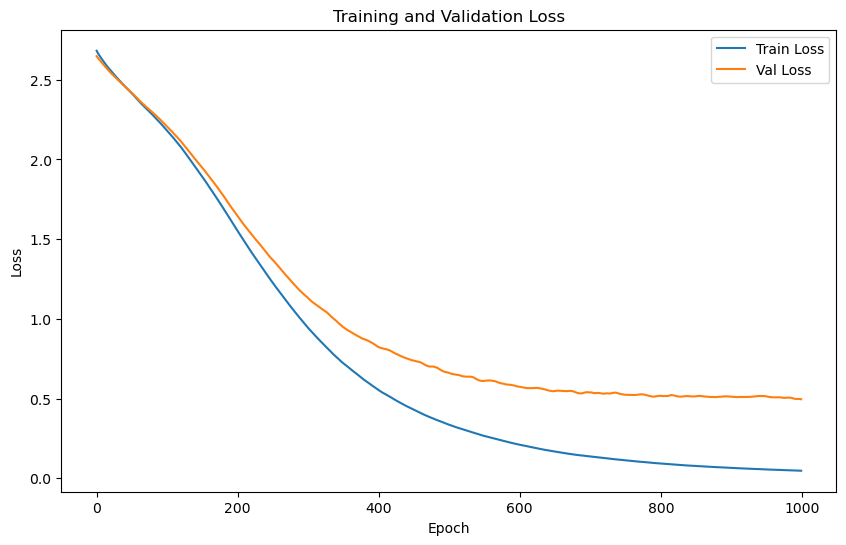

In [59]:
sclsdl_mlp_input_dim = sclsdl_mlp_train_reps.shape[1]
sclsdl_mlp_num_classes = len(torch.unique(sclsdl_mlp_train_labels_torch))
sclsdl_mlp_model = MLPClassifier(sclsdl_mlp_input_dim, sclsdl_mlp_num_classes).to(device)

sclsdl_mlp_criterion = nn.CrossEntropyLoss()
sclsdl_mlp_optimizer = optim.Adam(sclsdl_mlp_model.parameters(), lr=1e-4)

sclsdl_mlp_num_epochs = 1000
sclsdl_mlp_patience = 100

sclsdl_mlp_train_losses = []
sclsdl_mlp_val_losses = []

sclsdl_mlp_best_val_loss = float('inf')
sclsdl_mlp_epochs_without_improvement = 0

for sclsdl_mlp_epoch in range(sclsdl_mlp_num_epochs):
    # Training
    sclsdl_mlp_model.train()
    sclsdl_mlp_train_running_loss = 0.0
    
    for sclsdl_mlp_embeddings_batch, sclsdl_mlp_labels_batch in sclsdl_mlp_train_loader:
        sclsdl_mlp_embeddings_batch = sclsdl_mlp_embeddings_batch.to(device)
        sclsdl_mlp_labels_batch = sclsdl_mlp_labels_batch.to(device)
        
        sclsdl_mlp_optimizer.zero_grad()
        
        # Forward
        sclsdl_mlp_outputs = sclsdl_mlp_model(sclsdl_mlp_embeddings_batch)
        sclsdl_mlp_loss = sclsdl_mlp_criterion(sclsdl_mlp_outputs, sclsdl_mlp_labels_batch)
        
        # Backward & Update
        sclsdl_mlp_loss.backward()
        sclsdl_mlp_optimizer.step()
        
        sclsdl_mlp_train_running_loss += sclsdl_mlp_loss.item() * sclsdl_mlp_embeddings_batch.size(0)
    
    sclsdl_mlp_epoch_train_loss = sclsdl_mlp_train_running_loss / len(sclsdl_mlp_train_loader.dataset)
    sclsdl_mlp_train_losses.append(sclsdl_mlp_epoch_train_loss)

    # Validation
    sclsdl_mlp_model.eval()
    sclsdl_mlp_val_running_loss = 0.0
    
    with torch.no_grad():
        for sclsdl_mlp_val_embeddings_batch, sclsdl_mlp_val_labels_batch in sclsdl_mlp_val_loader:
            sclsdl_mlp_val_embeddings_batch = sclsdl_mlp_val_embeddings_batch.to(device)
            sclsdl_mlp_val_labels_batch = sclsdl_mlp_val_labels_batch.to(device)

            sclsdl_mlp_val_outputs = sclsdl_mlp_model(sclsdl_mlp_val_embeddings_batch)
            sclsdl_mlp_val_loss = sclsdl_mlp_criterion(sclsdl_mlp_val_outputs, sclsdl_mlp_val_labels_batch)

            sclsdl_mlp_val_running_loss += sclsdl_mlp_val_loss.item() * sclsdl_mlp_val_embeddings_batch.size(0)

    sclsdl_mlp_epoch_val_loss = sclsdl_mlp_val_running_loss / len(sclsdl_mlp_val_loader.dataset)
    sclsdl_mlp_val_losses.append(sclsdl_mlp_epoch_val_loss)

    print(f"[Epoch {sclsdl_mlp_epoch+1}/{sclsdl_mlp_num_epochs}] "
          f"Train Loss: {sclsdl_mlp_epoch_train_loss:.4f}  |  "
          f"Val Loss: {sclsdl_mlp_epoch_val_loss:.4f}")

    # Early stopping
    if sclsdl_mlp_epoch_val_loss < sclsdl_mlp_best_val_loss:
        print(f"Validation loss improved from {sclsdl_mlp_best_val_loss:.4f} to {sclsdl_mlp_epoch_val_loss:.4f}.")
        sclsdl_mlp_best_val_loss = sclsdl_mlp_epoch_val_loss
        sclsdl_mlp_epochs_without_improvement = 0


    else:
        sclsdl_mlp_epochs_without_improvement += 1
        print(f"!! Validation loss did NOT improve !! "
              f"Patience: {sclsdl_mlp_epochs_without_improvement}/{sclsdl_mlp_patience}")
        
        if sclsdl_mlp_epochs_without_improvement >= sclsdl_mlp_patience:
            print(f"!! Early stopping triggered at epoch {sclsdl_mlp_epoch+1} !!\n"
                  f"No improvement for {sclsdl_mlp_patience} epochs.")
            break

plt.figure(figsize=(10,6))
plt.plot(sclsdl_mlp_train_losses, label='Train Loss')
plt.plot(sclsdl_mlp_val_losses,   label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


Saved SCL_SDL+MLP predictions and true labels to model_predictions
Test Loss: 0.9045 | Test Accuracy: 70.24%


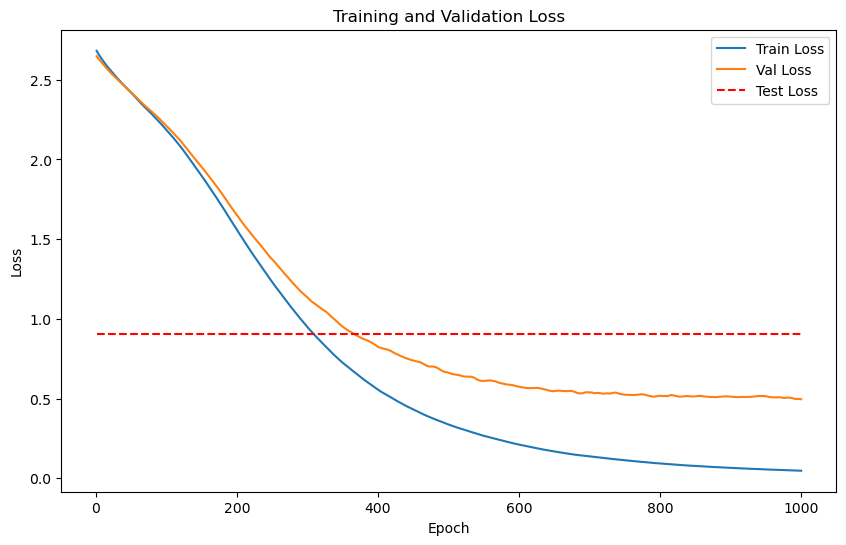

In [60]:
sclsdl_mlp_model.eval()

sclsdl_mlp_test_running_loss = 0.0
sclsdl_mlp_test_correct = 0
sclsdl_mlp_all_predictions = []
sclsdl_mlp_all_true_labels = []

with torch.no_grad():
    for sclsdl_mlp_test_embeddings_batch, sclsdl_mlp_test_labels_batch in sclsdl_mlp_test_loader:
        sclsdl_mlp_test_embeddings_batch = sclsdl_mlp_test_embeddings_batch.to(device)
        sclsdl_mlp_test_labels_batch = sclsdl_mlp_test_labels_batch.to(device)

        # Forward pass
        sclsdl_mlp_test_outputs = sclsdl_mlp_model(sclsdl_mlp_test_embeddings_batch)
        
        # Compute loss
        sclsdl_mlp_test_loss_batch = sclsdl_mlp_criterion(sclsdl_mlp_test_outputs, sclsdl_mlp_test_labels_batch)
        sclsdl_mlp_test_running_loss += sclsdl_mlp_test_loss_batch.item() * sclsdl_mlp_test_embeddings_batch.size(0)

        _, sclsdl_mlp_test_predicted = torch.max(sclsdl_mlp_test_outputs, dim=1)
        sclsdl_mlp_test_correct += (sclsdl_mlp_test_predicted == sclsdl_mlp_test_labels_batch).sum().item()

        sclsdl_mlp_all_predictions.extend(sclsdl_mlp_test_predicted.cpu().numpy())
        sclsdl_mlp_all_true_labels.extend(sclsdl_mlp_test_labels_batch.cpu().numpy())

np.save(os.path.join(predictions_dir, 'sclsdl_mlp_predictions.npy'), np.array(sclsdl_mlp_all_predictions))
np.save(os.path.join(predictions_dir, 'sclsdl_mlp_true_labels.npy'), np.array(sclsdl_mlp_all_true_labels))
print(f"Saved SCL_SDL+MLP predictions and true labels to {predictions_dir}")

sclsdl_mlp_epoch_test_loss = sclsdl_mlp_test_running_loss / len(sclsdl_mlp_test_loader.dataset)
sclsdl_mlp_test_accuracy = sclsdl_mlp_test_correct / len(sclsdl_mlp_test_loader.dataset)

sclsdl_mlp_test_accuracy_pct = sclsdl_mlp_test_accuracy * 100.0

print(f"Test Loss: {sclsdl_mlp_epoch_test_loss:.4f} | Test Accuracy: {sclsdl_mlp_test_accuracy_pct:.2f}%")

sclsdl_mlp_num_epochs_run = len(sclsdl_mlp_train_losses)

plt.figure(figsize=(10,6))

plt.plot(range(1, sclsdl_mlp_num_epochs_run + 1),
         sclsdl_mlp_train_losses,
         label='Train Loss')
plt.plot(range(1, sclsdl_mlp_num_epochs_run + 1),
         sclsdl_mlp_val_losses,
         label='Val Loss')

plt.plot(range(1, sclsdl_mlp_num_epochs_run + 1),
         [sclsdl_mlp_epoch_test_loss]*sclsdl_mlp_num_epochs_run,
         'r--',
         label='Test Loss')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


## Experimental Results and Confusion Matrices

In [61]:
def plot_conf_matrix(model_name, class_names = None, cm_save_dir='confusion_matrices'):
    os.makedirs(cm_save_dir, exist_ok = True)

    #loading predictions and true labels
    predictions_path = os.path.join(predictions_dir, f'{model_name}_predictions.npy')
    true_labels_path = os.path.join(predictions_dir, f'{model_name}_true_labels.npy')

    if not os.path.exists(predictions_path) or not os.path.exists(true_labels_path):
        print(f"Error: Files not found for model {model_name}")
        return
    
    cm_predictions = np.load(predictions_path)
    cm_true_labels = np.load(true_labels_path)

    conf_matrix = confusion_matrix(cm_true_labels, cm_predictions)
    plt.figure(figsize=(8,8))

    conf_matrix_normalised = conf_matrix.astype('float') / conf_matrix.sum(axis = 1)[:, np.newaxis]
    sns.heatmap(conf_matrix_normalised, annot=conf_matrix, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)

    plt.title(f"{model_name.upper()} Confusion Matrix", fontsize=16)
    plt.ylabel('True Label', fontsize=12)
    plt.xlabel('Predicted Label', fontsize=12)
    plt.tight_layout()

    cm_save_path = os.path.join(cm_save_dir, f'{model_name}_confusion_matrix.png')
    plt.savefig(cm_save_path, dpi=300, bbox_inches='tight')
    print(f"Saved confusion matrix to: {cm_save_path}")

    plt.show()

    accuracy = np.trace(conf_matrix) / np.sum(conf_matrix)
    print(f"Classification Accuracy: {accuracy*100:.2f}%")

Saving confusion matrices to: confusion_matrices


Saved confusion matrix to: confusion_matrices\e2e_cnn_confusion_matrix.png


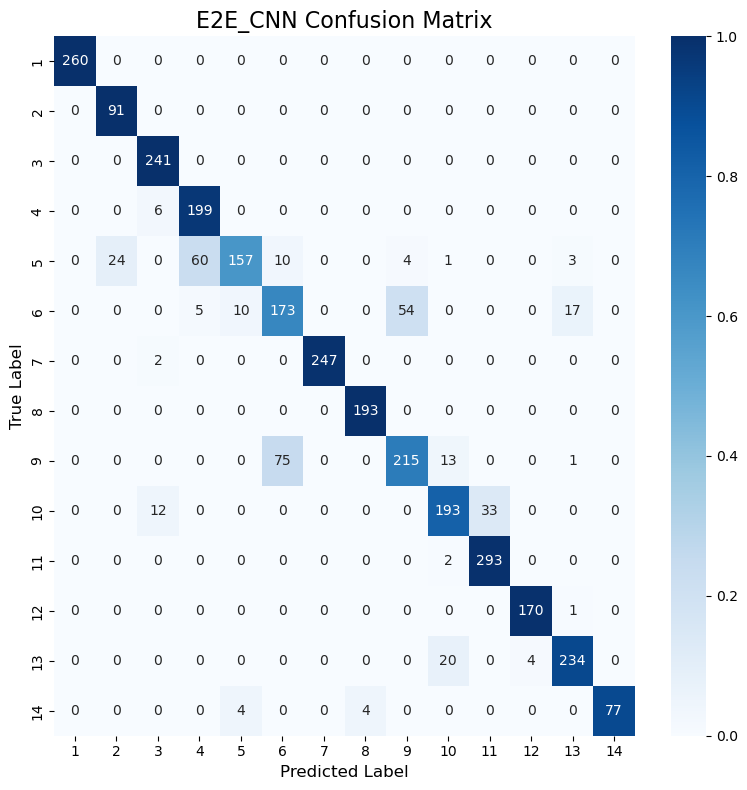

Classification Accuracy: 88.26%


Saved confusion matrix to: confusion_matrices\cae_lrm_confusion_matrix.png


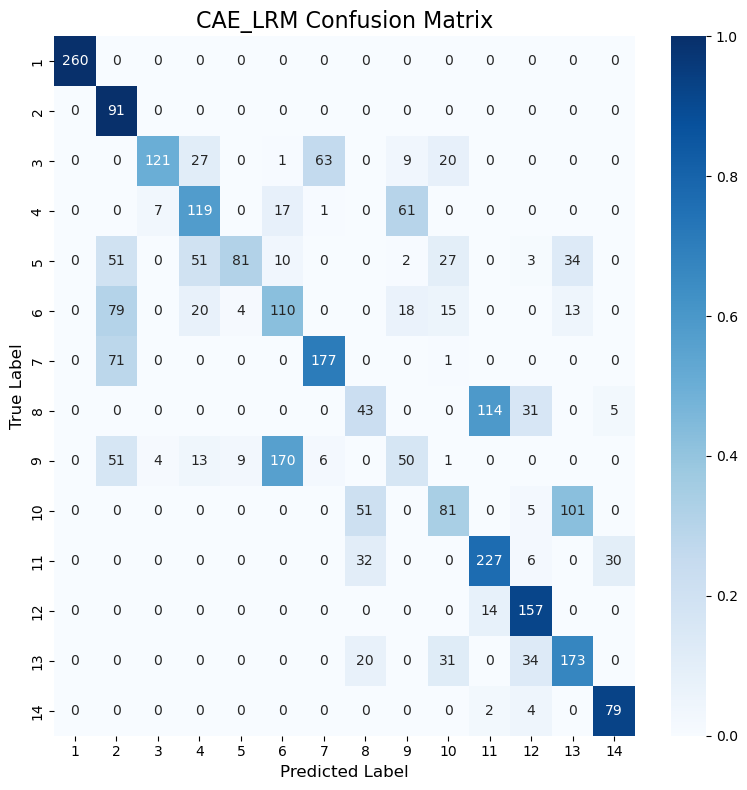

Classification Accuracy: 56.92%


Saved confusion matrix to: confusion_matrices\cae_mlp_confusion_matrix.png


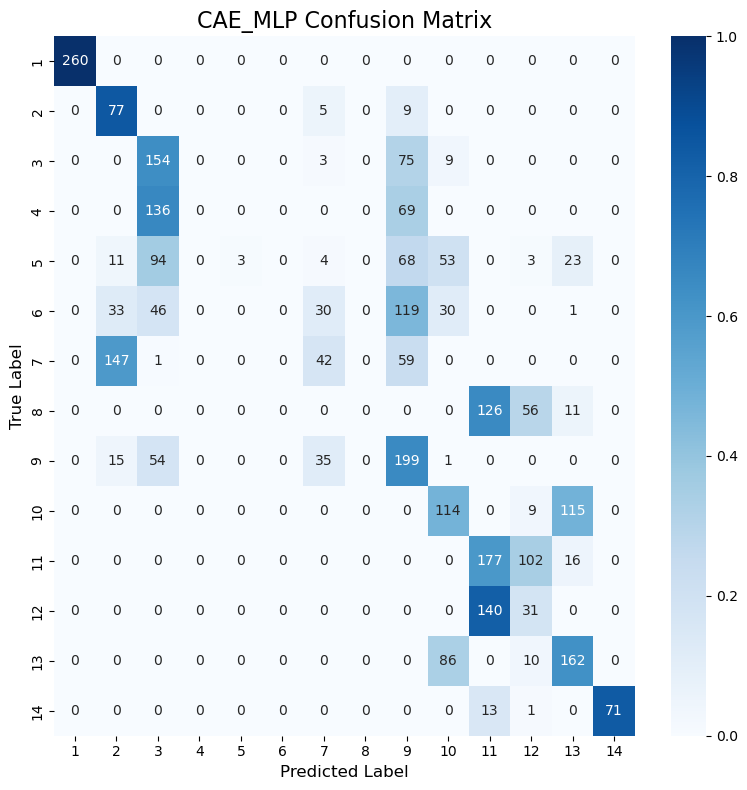

Classification Accuracy: 41.51%


Saved confusion matrix to: confusion_matrices\tscl_lrm_confusion_matrix.png


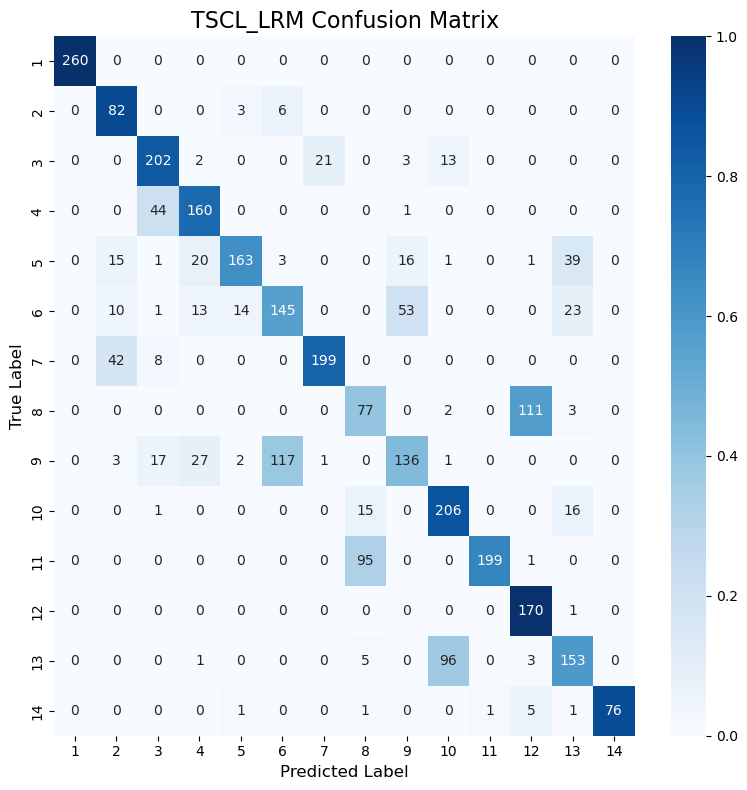

Classification Accuracy: 71.69%


Saved confusion matrix to: confusion_matrices\tscl_mlp_confusion_matrix.png


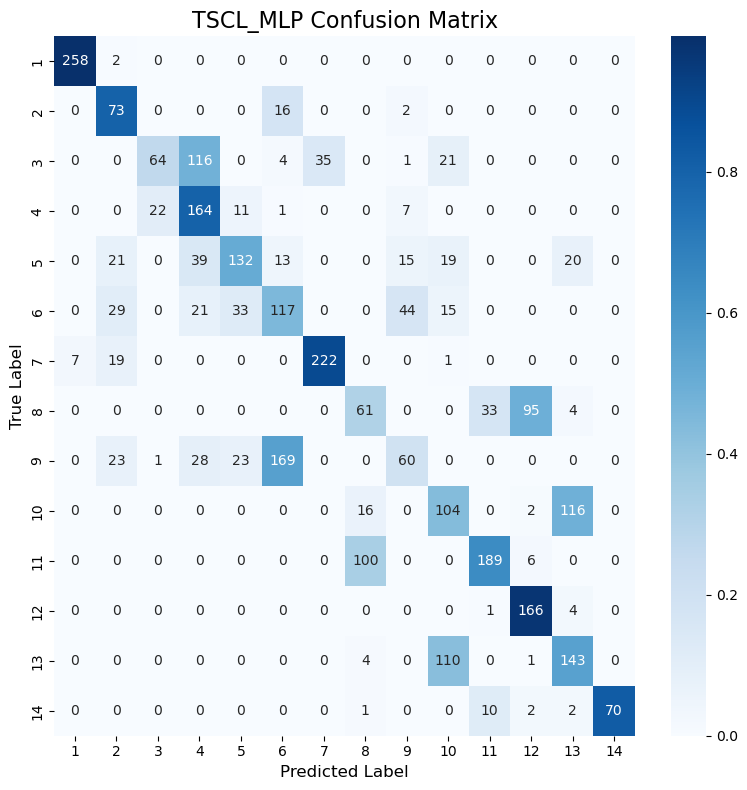

Classification Accuracy: 58.66%


Saved confusion matrix to: confusion_matrices\sclsdl_lrm_confusion_matrix.png


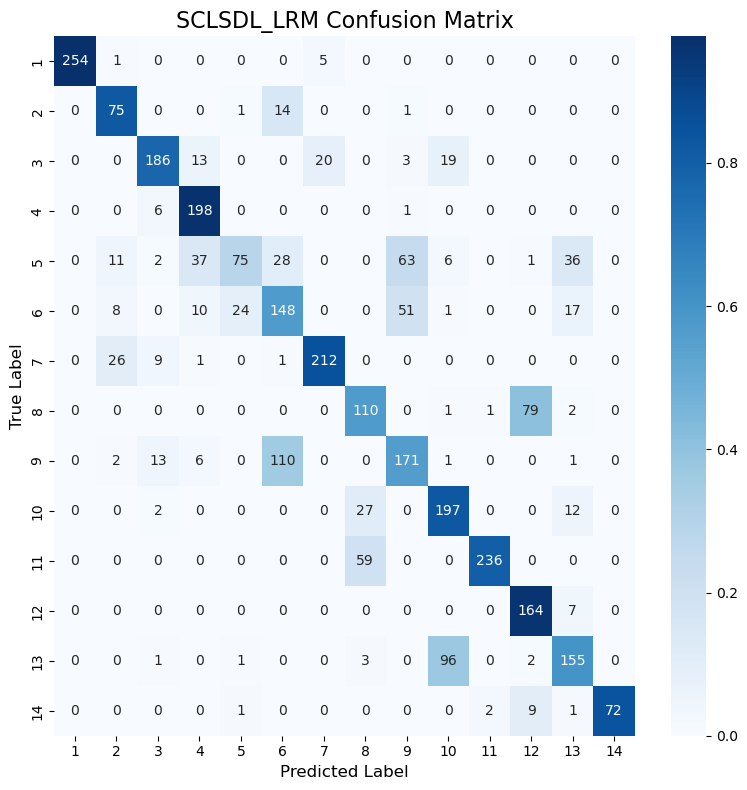

Classification Accuracy: 72.49%


Saved confusion matrix to: confusion_matrices\sclsdl_mlp_confusion_matrix.png


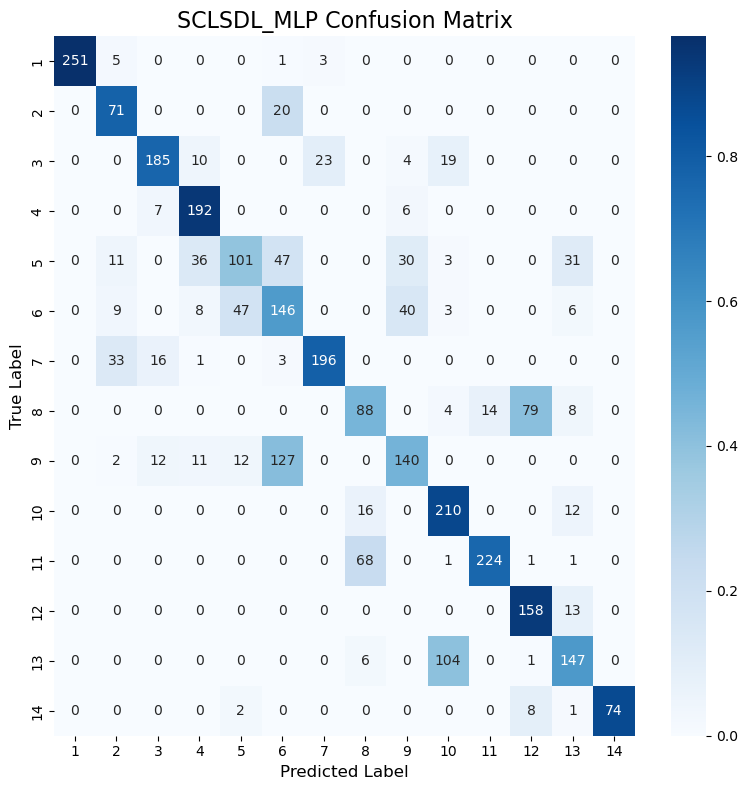

Classification Accuracy: 70.24%


In [62]:
class_names = [str(i+1) for i in range(len(np.unique(y_labels)))]
confusion_matrices_dir = 'confusion_matrices'
os.makedirs(confusion_matrices_dir, exist_ok=True)
print(f"Saving confusion matrices to: {confusion_matrices_dir}")
plot_conf_matrix('e2e_cnn', class_names, confusion_matrices_dir)
plot_conf_matrix('cae_lrm', class_names, confusion_matrices_dir)
plot_conf_matrix('cae_mlp', class_names, confusion_matrices_dir)
plot_conf_matrix('tscl_lrm', class_names, confusion_matrices_dir)
plot_conf_matrix('tscl_mlp', class_names, confusion_matrices_dir)
plot_conf_matrix('sclsdl_lrm', class_names, confusion_matrices_dir)
plot_conf_matrix('sclsdl_mlp', class_names, confusion_matrices_dir)

In [63]:
final_results_df = pd.DataFrame({
    "Model": ["E2E CNN", "LRM (CAE)", "MLP (CAE)", "TSCL LRM", "TSCL MLP", "SCL_SDL LRM", "SCL_SDL MLP"],
    "Test_Accuracy": [test_accuracy, lrm_test_accuracy * 100, cae_mlp_test_accuracy_pct, 
                      tscl_lrm_test_accuracy * 100, tscl_mlp_test_accuracy_pct, 
                      sclsdl_lrm_test_accuracy * 100, sclsdl_mlp_test_accuracy_pct]
})

pd.options.display.float_format = '{:.2f}'.format

print(final_results_df)
print(f"\nIn Desc. Order (Test Accu)\n{final_results_df.sort_values('Test_Accuracy', ascending=False)}")

         Model  Test_Accuracy
0      E2E CNN          88.26
1    LRM (CAE)          56.92
2    MLP (CAE)          41.51
3     TSCL LRM          71.69
4     TSCL MLP          58.66
5  SCL_SDL LRM          72.49
6  SCL_SDL MLP          70.24

In Desc. Order (Test Accu)
         Model  Test_Accuracy
0      E2E CNN          88.26
5  SCL_SDL LRM          72.49
3     TSCL LRM          71.69
6  SCL_SDL MLP          70.24
4     TSCL MLP          58.66
1    LRM (CAE)          56.92
2    MLP (CAE)          41.51
